In [1]:
import torch
import torch.nn as nn
from utils import data_loader
from utils.viewer import show_batch
import time
from mnist_classifier import test_model
from multiple_attacks import *

In [2]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [3]:
train_set, test_set = data_loader.get_data()

In [4]:
class VFAE_CONV_NeuralModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)

        )

        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 16, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True)
        )

        self.fc_mu = nn.Linear(50, 50)
        self.fc_log_var = nn.Linear(50, 50)

        # Sampling vector
        self.latent = nn.Sequential(

            nn.Linear(50, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),

            nn.Linear(50, 7 * 7 * 16),
            nn.BatchNorm1d(7 * 7 * 16),
            nn.ReLU(inplace=True)

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()

        )

    def reparameterize(self, mean, log_var):
        if self.training:
            std = log_var.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mean)
        else:
            return mean

    def forward(self, x):
        z, mu, log_var = self.get_latent(x)
        feature_map_latent = z.view(-1, 16, 7, 7)

        decoded = self.decoder(feature_map_latent)
        output = decoded.view(-1, 1, 28, 28)

        return output, mu, log_var
    
    def get_latent(self, x):
        encoded = self.encoder(x)

        encoded = encoded.view(-1, 7 * 7 * 16)

        fc = self.fc(encoded)

        mu = self.fc_mu(fc)
        log_var = self.fc_log_var(fc)

        z = self.reparameterize(mu, log_var)
        latent = self.latent(z)
        
        return latent, mu, log_var
        
        

In [5]:
batch_size = 512
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# vae = VAE_FC_NeuralModel()

def VAELoss(x_hat, x, mu, logvar, a, b):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return a*BCE + b*KLD

In [6]:
b_size = 512
def MMD_Loss(x, y):
    
    alpha =1
    B=b_size

    x = x.view(x.size(0), x.size(1) * 1)
    y = y.view(y.size(0), y.size(1) * 1)

    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    K = torch.exp(- alpha * (rx.t() + rx - 2*xx))
    L = torch.exp(- alpha * (ry.t() + ry - 2*yy))
    P = torch.exp(- alpha * (rx.t() + ry - 2*zz))

    beta = (1./(B*(B-1)))
    gamma = (2./(B*B)) 

    return beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)

In [7]:
def train_vae(model, train_data,a, b, adv_examples = False):
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_epochs = 10
    model.train()
    model.to(device)
    for epoch in range(n_epochs):
        if epoch%2 ==0:
            learning_rate/= 2  
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        if adv_examples is True: 
            # invariant representation training
            for epoch in range(n_epochs):
                for train in train_data:
                    for batch in train:
                        batch_images, adv_images, batch_labels = batch

                        batch_images = batch_images.to(device)
                        batch_labels = batch_labels.to(device)
                        adv_images = adv_images.to(device)

                        batch_output, mean, log_var = model(batch_images)

                        latent_1, _, _ = model.get_latent(batch_images)
                        latent_2, _, _ = model.get_latent(adv_images)

                        down_stream_loss = VAELoss(batch_output, batch_images.detach(), mean, log_var, a, b)
                        representation_loss = MMD_Loss(latent_1, latent_2)

                        total_loss = .00001*down_stream_loss + 10000*representation_loss


                        optimizer.zero_grad()
                        total_loss.backward(retain_graph=True)
                        optimizer.step()

                        print("The classification loss after processing this batch is: ", down_stream_loss.item())
                        print("The representation loss after processing this batch is: ", representation_loss.item())
        
        else:
            ## normal training
            for batch in train_data:
                batch_images, _ = batch
                batch_images = batch_images.to(device)

                batch_output, mean, log_var = model(batch_images)
                loss = VAELoss(batch_output, batch_images, mean, log_var, a, b)

                optimizer.zero_grad()
                loss.backward()
                print("*&**"*30)
                print("the loss after processing this batch is: ", loss.item())
                optimizer.step()

    return model

In [8]:
initial_vae = VFAE_CONV_NeuralModel().to(device)
#initial_vae = train_vae(initial_vae, train_loader, a=1, b=1, False)
#torch.save(initial_vae.state_dict(), "models/trained_vae_b=1_variant_rep")
initial_vae.load_state_dict(torch.load("models/trained_vae_b=1_variant_rep"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

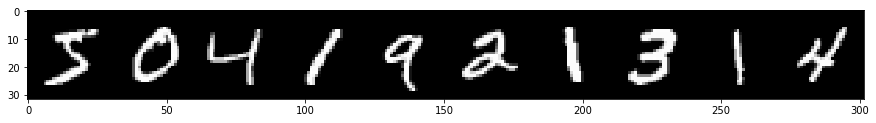

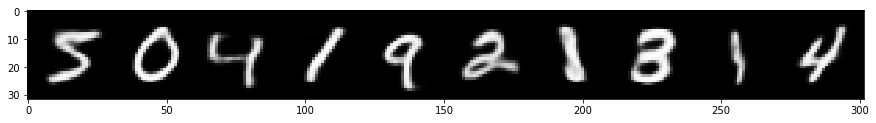

In [9]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
train_loader_iter = iter(train_loader)
first_images, first_labels = next(train_loader_iter)

show_batch(first_images)

recs, _, _ = initial_vae(first_images.to(device))
show_batch(recs.cpu())

In [10]:
class VFAEEClassifier(nn.Module):
    def __init__(self, beta, initial_VAE):
        super().__init__()
        
        self.vae = initial_vae
        
        self.classifier_part = self.encoder = nn.Sequential(

            nn.Conv2d(16, 14, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(14),
            nn.ReLU(inplace=True),

            nn.Conv2d(14, 12, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(12, 10, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(10),
            
        )
        
        self.fc = nn.Linear(10 * 1 * 1, 10)
        # no_of_last_channels* kernel_H * kernel_W, output_from_fully_conncected 
    def forward(self, x):
        #with torch.no_grad():
        vaee_features, _, _ = self.vae.get_latent(x)

        vaee_features = vaee_features.reshape(-1, 16, 7, 7)
        convolved = self.classifier_part(vaee_features)

        classification_logits = self.fc(convolved.view(convolved.size(0), -1))
        
        return  classification_logits
    

In [11]:
def train_classifier(model, train_data):
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_epochs = 15
    model.train()
    
    model.to(device)
    
    for epoch in range(n_epochs):
        if epoch %2 == 0:
            learning_rate /= 2.5
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for batch in train_data:
            batch_images, batch_labels = batch
            
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            batch_output = model(batch_images)
            loss = criterion(batch_output, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            model.vae = initial_classifier.vae
        print("the loss after processing this epoch is: ", loss.item())
            
    return model

In [12]:
b=1
initial_classifier = VFAEEClassifier(beta=b, initial_VAE=initial_vae).to(device)
model =  VFAEEClassifier(beta=b, initial_VAE=initial_vae).to(device)

batch_size = 512
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
model = train_classifier(model, train_loader)

the loss after processing this epoch is:  0.141626238822937
the loss after processing this epoch is:  0.0878150686621666
the loss after processing this epoch is:  0.08126844465732574
the loss after processing this epoch is:  0.08550894260406494
the loss after processing this epoch is:  0.08752479404211044
the loss after processing this epoch is:  0.08056680113077164
the loss after processing this epoch is:  0.08031261712312698
the loss after processing this epoch is:  0.0715905949473381
the loss after processing this epoch is:  0.07116461545228958
the loss after processing this epoch is:  0.06568051874637604
the loss after processing this epoch is:  0.06580808758735657
the loss after processing this epoch is:  0.06313348561525345
the loss after processing this epoch is:  0.06369435787200928
the loss after processing this epoch is:  0.06256580352783203
the loss after processing this epoch is:  0.06278074532747269


In [13]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
testing_accuracy_before_attack = test_model(model, test_loader)
print(testing_accuracy_before_attack)

0.9934


In [14]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)
print(attack(model, device, train_loader, fgsm, 0.3)[0])
print("=*" * 20)

print(attack(model, device, train_loader, pgd, 0.3, 1e-3, 50)[0])
print("=*" * 20)

print(attack(model, device, train_loader, pgd_linf, 0.3, 1e-3, 50)[0])
print("=*" * 20)

print(attack(model, device, train_loader, pgd_l2, 1.3, 0.3, 50)[0])

FGSM Attack : 
0.48855
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Projected Gradient Attack : 
0.99185
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
iFGSM Attack : 
0.56445
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Deep Fool Attack : 
0.1586


In [15]:
training_examples = []

examples = get_examples(model, device, train_loader, fgsm, 0.3)
training_examples.append(examples)

examples = get_examples(model, device, train_loader, pgd, 0.3, 1e-3, 50)
training_examples.append(examples)

examples = get_examples(model, device, train_loader, pgd_linf, 0.3, 1e-3, 50)
training_examples.append(examples)

examples = get_examples(model, device, train_loader, pgd_l2, 2, 0.3, 50)
training_examples.append(examples)


In [16]:
vafee = VFAE_CONV_NeuralModel().to(device)
train_vae(vafee, training_examples, 1, 1, adv_examples= True)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([512, 784])) that is different to the input size (torch.Size([512, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.


The classification loss after processing this batch is:  422804.875
The representation loss after processing this batch is:  0.003913894295692444
The classification loss after processing this batch is:  356736.9375
The representation loss after processing this batch is:  0.003913894295692444
The classification loss after processing this batch is:  295220.8125
The representation loss after processing this batch is:  0.003913894295692444
The classification loss after processing this batch is:  258187.03125
The representation loss after processing this batch is:  0.003913894295692444
The classification loss after processing this batch is:  233505.203125
The representation loss after processing this batch is:  0.003913892433047295
The classification loss after processing this batch is:  215406.078125
The representation loss after processing this batch is:  0.0039138938300311565
The classification loss after processing this batch is:  200558.9375
The representation loss after processing thi

The classification loss after processing this batch is:  97197.0859375
The representation loss after processing this batch is:  0.0039138877764344215
The classification loss after processing this batch is:  93940.3515625
The representation loss after processing this batch is:  0.00391387427225709
The classification loss after processing this batch is:  92820.40625
The representation loss after processing this batch is:  0.003913918510079384
The classification loss after processing this batch is:  91975.578125
The representation loss after processing this batch is:  0.003913750872015953
The classification loss after processing this batch is:  90667.7109375
The representation loss after processing this batch is:  0.0039139105938375
The classification loss after processing this batch is:  90592.0078125
The representation loss after processing this batch is:  0.003913928288966417
The classification loss after processing this batch is:  91836.140625
The representation loss after processing 

The classification loss after processing this batch is:  81305.9296875
The representation loss after processing this batch is:  0.003913909196853638
The classification loss after processing this batch is:  82180.03125
The representation loss after processing this batch is:  0.003914180677384138
The classification loss after processing this batch is:  80543.28125
The representation loss after processing this batch is:  0.003914206754416227
The classification loss after processing this batch is:  86100.3359375
The representation loss after processing this batch is:  0.0039137545973062515
The classification loss after processing this batch is:  85106.171875
The representation loss after processing this batch is:  0.003913515247404575
The classification loss after processing this batch is:  19208.287109375
The representation loss after processing this batch is:  0.0007338550058193505
The classification loss after processing this batch is:  80305.1484375
The representation loss after proces

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([96, 784])) that is different to the input size (torch.Size([96, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.


The classification loss after processing this batch is:  83318.953125
The representation loss after processing this batch is:  0.0039142281748354435
The classification loss after processing this batch is:  82886.0234375
The representation loss after processing this batch is:  0.003913734573870897
The classification loss after processing this batch is:  80856.375
The representation loss after processing this batch is:  0.003913977183401585
The classification loss after processing this batch is:  81031.8125
The representation loss after processing this batch is:  0.003913559950888157
The classification loss after processing this batch is:  82377.1640625
The representation loss after processing this batch is:  0.003913631197065115
The classification loss after processing this batch is:  77429.2578125
The representation loss after processing this batch is:  0.003913661930710077
The classification loss after processing this batch is:  84228.921875
The representation loss after processing th

The classification loss after processing this batch is:  222941.1875
The representation loss after processing this batch is:  4.797149449586868e-05
The classification loss after processing this batch is:  223675.0625
The representation loss after processing this batch is:  5.4057687520980835e-05
The classification loss after processing this batch is:  216402.21875
The representation loss after processing this batch is:  5.312543362379074e-05
The classification loss after processing this batch is:  211449.90625
The representation loss after processing this batch is:  4.9841590225696564e-05
The classification loss after processing this batch is:  210906.875
The representation loss after processing this batch is:  4.7577545046806335e-05
The classification loss after processing this batch is:  211635.96875
The representation loss after processing this batch is:  4.947185516357422e-05
The classification loss after processing this batch is:  211027.9375
The representation loss after processi

The classification loss after processing this batch is:  176071.15625
The representation loss after processing this batch is:  3.457069396972656e-05
The classification loss after processing this batch is:  173367.171875
The representation loss after processing this batch is:  3.632437437772751e-05
The classification loss after processing this batch is:  179556.609375
The representation loss after processing this batch is:  3.7443824112415314e-05
The classification loss after processing this batch is:  179018.5
The representation loss after processing this batch is:  3.8362108170986176e-05
The classification loss after processing this batch is:  37157.96875
The representation loss after processing this batch is:  5.013484042137861e-06
The classification loss after processing this batch is:  173568.328125
The representation loss after processing this batch is:  0.00023950543254613876
The classification loss after processing this batch is:  177627.4375
The representation loss after proces

The classification loss after processing this batch is:  162853.09375
The representation loss after processing this batch is:  5.2512623369693756e-05
The classification loss after processing this batch is:  168559.40625
The representation loss after processing this batch is:  5.520228296518326e-05
The classification loss after processing this batch is:  162019.484375
The representation loss after processing this batch is:  5.373544991016388e-05
The classification loss after processing this batch is:  165257.09375
The representation loss after processing this batch is:  5.245674401521683e-05
The classification loss after processing this batch is:  167481.28125
The representation loss after processing this batch is:  5.863513797521591e-05
The classification loss after processing this batch is:  162634.875
The representation loss after processing this batch is:  4.947744309902191e-05
The classification loss after processing this batch is:  165553.84375
The representation loss after proces

The classification loss after processing this batch is:  152295.78125
The representation loss after processing this batch is:  4.691164940595627e-05
The classification loss after processing this batch is:  151809.96875
The representation loss after processing this batch is:  4.6426430344581604e-05
The classification loss after processing this batch is:  156245.9375
The representation loss after processing this batch is:  4.548206925392151e-05
The classification loss after processing this batch is:  151000.09375
The representation loss after processing this batch is:  4.825834184885025e-05
The classification loss after processing this batch is:  151991.78125
The representation loss after processing this batch is:  4.745367914438248e-05
The classification loss after processing this batch is:  153247.84375
The representation loss after processing this batch is:  4.483852535486221e-05
The classification loss after processing this batch is:  151556.1875
The representation loss after process

The classification loss after processing this batch is:  145985.21875
The representation loss after processing this batch is:  0.00010696984827518463
The classification loss after processing this batch is:  147875.34375
The representation loss after processing this batch is:  0.00012010335922241211
The classification loss after processing this batch is:  144241.90625
The representation loss after processing this batch is:  0.00011358410120010376
The classification loss after processing this batch is:  141259.9375
The representation loss after processing this batch is:  0.00011342205107212067
The classification loss after processing this batch is:  146054.65625
The representation loss after processing this batch is:  0.00012432225048542023
The classification loss after processing this batch is:  142511.765625
The representation loss after processing this batch is:  0.0001265648752450943
The classification loss after processing this batch is:  141142.6875
The representation loss after pr

The classification loss after processing this batch is:  136196.9375
The representation loss after processing this batch is:  0.00010251440107822418
The classification loss after processing this batch is:  133182.796875
The representation loss after processing this batch is:  9.01632010936737e-05
The classification loss after processing this batch is:  136899.953125
The representation loss after processing this batch is:  9.855255484580994e-05
The classification loss after processing this batch is:  134284.96875
The representation loss after processing this batch is:  9.772554039955139e-05
The classification loss after processing this batch is:  135063.625
The representation loss after processing this batch is:  9.313598275184631e-05
The classification loss after processing this batch is:  135350.1875
The representation loss after processing this batch is:  0.00010319054126739502
The classification loss after processing this batch is:  135224.75
The representation loss after processing

The classification loss after processing this batch is:  136507.359375
The representation loss after processing this batch is:  0.0002676434814929962
The classification loss after processing this batch is:  137605.875
The representation loss after processing this batch is:  0.0002824068069458008
The classification loss after processing this batch is:  135266.5
The representation loss after processing this batch is:  0.0003155246376991272
The classification loss after processing this batch is:  138026.0625
The representation loss after processing this batch is:  0.0002959407866001129
The classification loss after processing this batch is:  140346.65625
The representation loss after processing this batch is:  0.0003012530505657196
The classification loss after processing this batch is:  135903.09375
The representation loss after processing this batch is:  0.0002885162830352783
The classification loss after processing this batch is:  137770.1875
The representation loss after processing th

The classification loss after processing this batch is:  131997.40625
The representation loss after processing this batch is:  0.0002331174910068512
The classification loss after processing this batch is:  126381.4375
The representation loss after processing this batch is:  0.00021152570843696594
The classification loss after processing this batch is:  127190.671875
The representation loss after processing this batch is:  0.00024656206369400024
The classification loss after processing this batch is:  123603.9453125
The representation loss after processing this batch is:  0.0002895444631576538
The classification loss after processing this batch is:  127308.8515625
The representation loss after processing this batch is:  0.0002517886459827423
The classification loss after processing this batch is:  125871.609375
The representation loss after processing this batch is:  0.00023972243070602417
The classification loss after processing this batch is:  122700.2265625
The representation loss af

The classification loss after processing this batch is:  126736.40625
The representation loss after processing this batch is:  4.3058767914772034e-05
The classification loss after processing this batch is:  123864.71875
The representation loss after processing this batch is:  4.1715800762176514e-05
The classification loss after processing this batch is:  121404.765625
The representation loss after processing this batch is:  4.301033914089203e-05
The classification loss after processing this batch is:  124201.734375
The representation loss after processing this batch is:  4.2458996176719666e-05
The classification loss after processing this batch is:  126193.03125
The representation loss after processing this batch is:  3.898888826370239e-05
The classification loss after processing this batch is:  128485.203125
The representation loss after processing this batch is:  4.185829311609268e-05
The classification loss after processing this batch is:  124737.234375
The representation loss after

The classification loss after processing this batch is:  121352.40625
The representation loss after processing this batch is:  2.6241876184940338e-05
The classification loss after processing this batch is:  120195.921875
The representation loss after processing this batch is:  2.7635134756565094e-05
The classification loss after processing this batch is:  122299.1484375
The representation loss after processing this batch is:  2.7501024305820465e-05
The classification loss after processing this batch is:  121300.671875
The representation loss after processing this batch is:  2.5199726223945618e-05
The classification loss after processing this batch is:  119778.6875
The representation loss after processing this batch is:  2.672336995601654e-05
The classification loss after processing this batch is:  122318.5703125
The representation loss after processing this batch is:  2.588704228401184e-05
The classification loss after processing this batch is:  120469.2578125
The representation loss a

The classification loss after processing this batch is:  116312.4453125
The representation loss after processing this batch is:  3.3834949135780334e-05
The classification loss after processing this batch is:  121397.875
The representation loss after processing this batch is:  3.443099558353424e-05
The classification loss after processing this batch is:  124446.0
The representation loss after processing this batch is:  3.511738032102585e-05
The classification loss after processing this batch is:  114579.015625
The representation loss after processing this batch is:  3.5181641578674316e-05
The classification loss after processing this batch is:  117448.7109375
The representation loss after processing this batch is:  3.087148070335388e-05
The classification loss after processing this batch is:  115205.578125
The representation loss after processing this batch is:  3.453809767961502e-05
The classification loss after processing this batch is:  114876.75
The representation loss after process

The classification loss after processing this batch is:  111019.3671875
The representation loss after processing this batch is:  3.1975097954273224e-05
The classification loss after processing this batch is:  112252.859375
The representation loss after processing this batch is:  3.4417957067489624e-05
The classification loss after processing this batch is:  109322.125
The representation loss after processing this batch is:  3.25031578540802e-05
The classification loss after processing this batch is:  109136.515625
The representation loss after processing this batch is:  3.270059823989868e-05
The classification loss after processing this batch is:  112565.0
The representation loss after processing this batch is:  3.25934961438179e-05
The classification loss after processing this batch is:  112276.21875
The representation loss after processing this batch is:  3.382004797458649e-05
The classification loss after processing this batch is:  114402.25
The representation loss after processing 

The classification loss after processing this batch is:  111141.515625
The representation loss after processing this batch is:  7.904134690761566e-05
The classification loss after processing this batch is:  112295.1640625
The representation loss after processing this batch is:  7.765460759401321e-05
The classification loss after processing this batch is:  107645.8125
The representation loss after processing this batch is:  8.221622556447983e-05
The classification loss after processing this batch is:  107096.765625
The representation loss after processing this batch is:  7.774494588375092e-05
The classification loss after processing this batch is:  109416.5078125
The representation loss after processing this batch is:  7.268041372299194e-05
The classification loss after processing this batch is:  113560.3203125
The representation loss after processing this batch is:  7.123034447431564e-05
The classification loss after processing this batch is:  113160.5625
The representation loss after 

The classification loss after processing this batch is:  104639.7265625
The representation loss after processing this batch is:  7.080286741256714e-05
The classification loss after processing this batch is:  102836.1953125
The representation loss after processing this batch is:  7.272697985172272e-05
The classification loss after processing this batch is:  104394.6484375
The representation loss after processing this batch is:  7.109902799129486e-05
The classification loss after processing this batch is:  103091.1171875
The representation loss after processing this batch is:  7.145106792449951e-05
The classification loss after processing this batch is:  103394.21875
The representation loss after processing this batch is:  7.022172212600708e-05
The classification loss after processing this batch is:  106953.21875
The representation loss after processing this batch is:  6.244704127311707e-05
The classification loss after processing this batch is:  102057.640625
The representation loss aft

The classification loss after processing this batch is:  106884.640625
The representation loss after processing this batch is:  0.00021918490529060364
The classification loss after processing this batch is:  106443.59375
The representation loss after processing this batch is:  0.0002516806125640869
The classification loss after processing this batch is:  110198.265625
The representation loss after processing this batch is:  0.00024925172328948975
The classification loss after processing this batch is:  109523.515625
The representation loss after processing this batch is:  0.0001900792121887207
The classification loss after processing this batch is:  110740.265625
The representation loss after processing this batch is:  0.00020372867584228516
The classification loss after processing this batch is:  107756.203125
The representation loss after processing this batch is:  0.00020105764269828796
The classification loss after processing this batch is:  112290.6640625
The representation loss a

The classification loss after processing this batch is:  102640.625
The representation loss after processing this batch is:  0.00018844753503799438
The classification loss after processing this batch is:  101952.796875
The representation loss after processing this batch is:  0.00018564611673355103
The classification loss after processing this batch is:  108062.953125
The representation loss after processing this batch is:  0.00019484013319015503
The classification loss after processing this batch is:  104744.234375
The representation loss after processing this batch is:  0.00020386278629302979
The classification loss after processing this batch is:  103829.40625
The representation loss after processing this batch is:  0.0001921243965625763
The classification loss after processing this batch is:  106767.078125
The representation loss after processing this batch is:  0.00018442049622535706
The classification loss after processing this batch is:  102784.4765625
The representation loss aft

The classification loss after processing this batch is:  103638.375
The representation loss after processing this batch is:  7.437542080879211e-05
The classification loss after processing this batch is:  97430.1171875
The representation loss after processing this batch is:  7.539615035057068e-05
The classification loss after processing this batch is:  104691.75
The representation loss after processing this batch is:  7.183849811553955e-05
The classification loss after processing this batch is:  99538.1171875
The representation loss after processing this batch is:  6.834976375102997e-05
The classification loss after processing this batch is:  109511.546875
The representation loss after processing this batch is:  6.823986768722534e-05
The classification loss after processing this batch is:  102905.3203125
The representation loss after processing this batch is:  6.319209933280945e-05
The classification loss after processing this batch is:  102043.5234375
The representation loss after proc

The classification loss after processing this batch is:  100119.7890625
The representation loss after processing this batch is:  2.3043714463710785e-05
The classification loss after processing this batch is:  99035.015625
The representation loss after processing this batch is:  2.4971552193164825e-05
The classification loss after processing this batch is:  101427.140625
The representation loss after processing this batch is:  2.319924533367157e-05
The classification loss after processing this batch is:  99230.453125
The representation loss after processing this batch is:  2.4954788386821747e-05
The classification loss after processing this batch is:  97068.359375
The representation loss after processing this batch is:  2.4828128516674042e-05
The classification loss after processing this batch is:  96647.875
The representation loss after processing this batch is:  2.3523345589637756e-05
The classification loss after processing this batch is:  100762.4375
The representation loss after pr

The classification loss after processing this batch is:  93621.0625
The representation loss after processing this batch is:  2.982933074235916e-05
The classification loss after processing this batch is:  97878.421875
The representation loss after processing this batch is:  2.8588809072971344e-05
The classification loss after processing this batch is:  98772.96875
The representation loss after processing this batch is:  2.7006492018699646e-05
The classification loss after processing this batch is:  96858.6640625
The representation loss after processing this batch is:  2.832571044564247e-05
The classification loss after processing this batch is:  97422.703125
The representation loss after processing this batch is:  2.9068440198898315e-05
The classification loss after processing this batch is:  98881.8828125
The representation loss after processing this batch is:  2.75331549346447e-05
The classification loss after processing this batch is:  93750.234375
The representation loss after proce

The classification loss after processing this batch is:  103451.9609375
The representation loss after processing this batch is:  2.8427690267562866e-05
The classification loss after processing this batch is:  96332.6796875
The representation loss after processing this batch is:  2.7723610401153564e-05
The classification loss after processing this batch is:  102375.9296875
The representation loss after processing this batch is:  2.732733264565468e-05
The classification loss after processing this batch is:  97041.515625
The representation loss after processing this batch is:  2.803746610879898e-05
The classification loss after processing this batch is:  95840.3046875
The representation loss after processing this batch is:  2.9088929295539856e-05
The classification loss after processing this batch is:  97082.4453125
The representation loss after processing this batch is:  2.5083310902118683e-05
The classification loss after processing this batch is:  96024.265625
The representation loss a

The classification loss after processing this batch is:  94780.734375
The representation loss after processing this batch is:  2.72504985332489e-05
The classification loss after processing this batch is:  94804.6484375
The representation loss after processing this batch is:  2.6972033083438873e-05
The classification loss after processing this batch is:  94833.0
The representation loss after processing this batch is:  2.9226765036582947e-05
The classification loss after processing this batch is:  100009.1875
The representation loss after processing this batch is:  3.088172525167465e-05
The classification loss after processing this batch is:  100668.9296875
The representation loss after processing this batch is:  2.968963235616684e-05
The classification loss after processing this batch is:  24894.5546875
The representation loss after processing this batch is:  6.23153755441308e-06
The classification loss after processing this batch is:  91478.4296875
The representation loss after process

The classification loss after processing this batch is:  97764.671875
The representation loss after processing this batch is:  5.932990461587906e-05
The classification loss after processing this batch is:  95526.3671875
The representation loss after processing this batch is:  7.115304470062256e-05
The classification loss after processing this batch is:  93443.0625
The representation loss after processing this batch is:  7.546320557594299e-05
The classification loss after processing this batch is:  96230.59375
The representation loss after processing this batch is:  6.190687417984009e-05
The classification loss after processing this batch is:  104357.59375
The representation loss after processing this batch is:  6.571132689714432e-05
The classification loss after processing this batch is:  95077.46875
The representation loss after processing this batch is:  6.301607936620712e-05
The classification loss after processing this batch is:  97923.359375
The representation loss after processin

The classification loss after processing this batch is:  92512.53125
The representation loss after processing this batch is:  5.132704973220825e-05
The classification loss after processing this batch is:  94526.15625
The representation loss after processing this batch is:  5.7544559240341187e-05
The classification loss after processing this batch is:  93889.8515625
The representation loss after processing this batch is:  5.462951958179474e-05
The classification loss after processing this batch is:  92703.328125
The representation loss after processing this batch is:  5.8370642364025116e-05
The classification loss after processing this batch is:  91377.640625
The representation loss after processing this batch is:  5.900207906961441e-05
The classification loss after processing this batch is:  98059.8359375
The representation loss after processing this batch is:  6.045587360858917e-05
The classification loss after processing this batch is:  92019.65625
The representation loss after proce

The classification loss after processing this batch is:  96572.3359375
The representation loss after processing this batch is:  0.0001863539218902588
The classification loss after processing this batch is:  99883.71875
The representation loss after processing this batch is:  0.00017042458057403564
The classification loss after processing this batch is:  103278.8828125
The representation loss after processing this batch is:  0.00018499046564102173
The classification loss after processing this batch is:  98300.890625
The representation loss after processing this batch is:  0.0001814328134059906
The classification loss after processing this batch is:  99725.453125
The representation loss after processing this batch is:  0.00016516074538230896
The classification loss after processing this batch is:  95837.4453125
The representation loss after processing this batch is:  0.00015735626220703125
The classification loss after processing this batch is:  95262.171875
The representation loss after

The classification loss after processing this batch is:  95912.875
The representation loss after processing this batch is:  0.00017961859703063965
The classification loss after processing this batch is:  92453.1875
The representation loss after processing this batch is:  0.00017566978931427002
The classification loss after processing this batch is:  94679.296875
The representation loss after processing this batch is:  0.00016419216990470886
The classification loss after processing this batch is:  95871.46875
The representation loss after processing this batch is:  0.0001637190580368042
The classification loss after processing this batch is:  91594.1171875
The representation loss after processing this batch is:  0.0001529492437839508
The classification loss after processing this batch is:  96023.9140625
The representation loss after processing this batch is:  0.0001752600073814392
The classification loss after processing this batch is:  91994.7109375
The representation loss after proces

The classification loss after processing this batch is:  90860.9296875
The representation loss after processing this batch is:  2.9032118618488312e-05
The classification loss after processing this batch is:  94417.78125
The representation loss after processing this batch is:  2.7013011276721954e-05
The classification loss after processing this batch is:  95602.8671875
The representation loss after processing this batch is:  2.6545487344264984e-05
The classification loss after processing this batch is:  99501.8125
The representation loss after processing this batch is:  2.658739686012268e-05
The classification loss after processing this batch is:  94406.671875
The representation loss after processing this batch is:  2.782978117465973e-05
The classification loss after processing this batch is:  94500.3671875
The representation loss after processing this batch is:  2.5428831577301025e-05
The classification loss after processing this batch is:  95675.0703125
The representation loss after p

The classification loss after processing this batch is:  94985.296875
The representation loss after processing this batch is:  1.8897000700235367e-05
The classification loss after processing this batch is:  93988.8125
The representation loss after processing this batch is:  1.7583370208740234e-05
The classification loss after processing this batch is:  93087.921875
The representation loss after processing this batch is:  1.9466504454612732e-05
The classification loss after processing this batch is:  96155.3046875
The representation loss after processing this batch is:  1.8169637769460678e-05
The classification loss after processing this batch is:  93846.9296875
The representation loss after processing this batch is:  1.6874633729457855e-05
The classification loss after processing this batch is:  96605.03125
The representation loss after processing this batch is:  1.8246006220579147e-05
The classification loss after processing this batch is:  93660.625
The representation loss after proc

The classification loss after processing this batch is:  101531.125
The representation loss after processing this batch is:  2.7567148208618164e-05
The classification loss after processing this batch is:  91313.9375
The representation loss after processing this batch is:  2.626422792673111e-05
The classification loss after processing this batch is:  93643.421875
The representation loss after processing this batch is:  2.3916363716125488e-05
The classification loss after processing this batch is:  92289.3359375
The representation loss after processing this batch is:  2.521602436900139e-05
The classification loss after processing this batch is:  91714.2109375
The representation loss after processing this batch is:  2.4514738470315933e-05
The classification loss after processing this batch is:  94731.109375
The representation loss after processing this batch is:  2.552242949604988e-05
The classification loss after processing this batch is:  93171.203125
The representation loss after proce

The classification loss after processing this batch is:  89267.7890625
The representation loss after processing this batch is:  2.5397632271051407e-05
The classification loss after processing this batch is:  89502.15625
The representation loss after processing this batch is:  2.3933593183755875e-05
The classification loss after processing this batch is:  93140.5625
The representation loss after processing this batch is:  2.4684704840183258e-05
The classification loss after processing this batch is:  93313.0625
The representation loss after processing this batch is:  2.5403685867786407e-05
The classification loss after processing this batch is:  95681.796875
The representation loss after processing this batch is:  2.5064684450626373e-05
The classification loss after processing this batch is:  93395.5390625
The representation loss after processing this batch is:  2.499530091881752e-05
The classification loss after processing this batch is:  91845.0
The representation loss after processin

The classification loss after processing this batch is:  90921.359375
The representation loss after processing this batch is:  6.051454693078995e-05
The classification loss after processing this batch is:  90807.5390625
The representation loss after processing this batch is:  5.86705282330513e-05
The classification loss after processing this batch is:  92637.625
The representation loss after processing this batch is:  5.452800542116165e-05
The classification loss after processing this batch is:  97315.5625
The representation loss after processing this batch is:  5.6422315537929535e-05
The classification loss after processing this batch is:  96568.546875
The representation loss after processing this batch is:  6.785709410905838e-05
The classification loss after processing this batch is:  93476.9609375
The representation loss after processing this batch is:  5.8348290622234344e-05
The classification loss after processing this batch is:  98654.9609375
The representation loss after process

The classification loss after processing this batch is:  90509.109375
The representation loss after processing this batch is:  5.221366882324219e-05
The classification loss after processing this batch is:  88754.125
The representation loss after processing this batch is:  5.698204040527344e-05
The classification loss after processing this batch is:  88362.40625
The representation loss after processing this batch is:  5.2162446081638336e-05
The classification loss after processing this batch is:  92011.2578125
The representation loss after processing this batch is:  5.203858017921448e-05
The classification loss after processing this batch is:  88047.5078125
The representation loss after processing this batch is:  5.4173171520233154e-05
The classification loss after processing this batch is:  90074.890625
The representation loss after processing this batch is:  5.0994567573070526e-05
The classification loss after processing this batch is:  91754.890625
The representation loss after proce

The classification loss after processing this batch is:  96140.3203125
The representation loss after processing this batch is:  0.0001826249063014984
The classification loss after processing this batch is:  95948.09375
The representation loss after processing this batch is:  0.00015944615006446838
The classification loss after processing this batch is:  97216.375
The representation loss after processing this batch is:  0.00016349926590919495
The classification loss after processing this batch is:  93768.0625
The representation loss after processing this batch is:  0.00017371028661727905
The classification loss after processing this batch is:  98178.578125
The representation loss after processing this batch is:  0.000173129141330719
The classification loss after processing this batch is:  95085.375
The representation loss after processing this batch is:  0.0001654587686061859
The classification loss after processing this batch is:  95823.9609375
The representation loss after processing 

The classification loss after processing this batch is:  96441.359375
The representation loss after processing this batch is:  0.00016066059470176697
The classification loss after processing this batch is:  92443.484375
The representation loss after processing this batch is:  0.0001648440957069397
The classification loss after processing this batch is:  91105.9921875
The representation loss after processing this batch is:  0.00016144663095474243
The classification loss after processing this batch is:  94664.8125
The representation loss after processing this batch is:  0.00016066431999206543
The classification loss after processing this batch is:  90094.671875
The representation loss after processing this batch is:  0.000165451318025589
The classification loss after processing this batch is:  90126.46875
The representation loss after processing this batch is:  0.000157281756401062
The classification loss after processing this batch is:  88660.1875
The representation loss after processin

The classification loss after processing this batch is:  92028.90625
The representation loss after processing this batch is:  5.944259464740753e-05
The classification loss after processing this batch is:  87834.859375
The representation loss after processing this batch is:  5.6507065892219543e-05
The classification loss after processing this batch is:  98852.125
The representation loss after processing this batch is:  5.557946860790253e-05
The classification loss after processing this batch is:  91121.71875
The representation loss after processing this batch is:  5.1233917474746704e-05
The classification loss after processing this batch is:  89705.5078125
The representation loss after processing this batch is:  4.8665329813957214e-05
The classification loss after processing this batch is:  87756.171875
The representation loss after processing this batch is:  4.5649707317352295e-05
The classification loss after processing this batch is:  87212.3828125
The representation loss after proce

The classification loss after processing this batch is:  90950.0390625
The representation loss after processing this batch is:  1.849886029958725e-05
The classification loss after processing this batch is:  87990.4375
The representation loss after processing this batch is:  2.0421110093593597e-05
The classification loss after processing this batch is:  86025.9765625
The representation loss after processing this batch is:  1.9711442291736603e-05
The classification loss after processing this batch is:  85547.078125
The representation loss after processing this batch is:  1.9162893295288086e-05
The classification loss after processing this batch is:  89646.6875
The representation loss after processing this batch is:  1.764623448252678e-05
The classification loss after processing this batch is:  89701.0546875
The representation loss after processing this batch is:  2.04574316740036e-05
The classification loss after processing this batch is:  88367.875
The representation loss after processi

The classification loss after processing this batch is:  83317.703125
The representation loss after processing this batch is:  2.6283320039510727e-05
The classification loss after processing this batch is:  87462.953125
The representation loss after processing this batch is:  2.5043264031410217e-05
The classification loss after processing this batch is:  88913.90625
The representation loss after processing this batch is:  2.389773726463318e-05
The classification loss after processing this batch is:  86642.0234375
The representation loss after processing this batch is:  2.340739592909813e-05
The classification loss after processing this batch is:  86941.515625
The representation loss after processing this batch is:  2.5039538741111755e-05
The classification loss after processing this batch is:  88673.546875
The representation loss after processing this batch is:  2.4088658392429352e-05
The classification loss after processing this batch is:  84529.3203125
The representation loss after p

The classification loss after processing this batch is:  93572.5
The representation loss after processing this batch is:  2.5568995624780655e-05
The classification loss after processing this batch is:  86029.796875
The representation loss after processing this batch is:  2.3284461349248886e-05
The classification loss after processing this batch is:  92355.5625
The representation loss after processing this batch is:  2.340087667107582e-05
The classification loss after processing this batch is:  86489.1875
The representation loss after processing this batch is:  2.3398548364639282e-05
The classification loss after processing this batch is:  85966.3671875
The representation loss after processing this batch is:  2.6071444153785706e-05
The classification loss after processing this batch is:  87057.2734375
The representation loss after processing this batch is:  2.2254884243011475e-05
The classification loss after processing this batch is:  85840.4140625
The representation loss after process

The classification loss after processing this batch is:  85066.71875
The representation loss after processing this batch is:  2.2431835532188416e-05
The classification loss after processing this batch is:  85070.6171875
The representation loss after processing this batch is:  2.2298656404018402e-05
The classification loss after processing this batch is:  85424.0625
The representation loss after processing this batch is:  2.5803223252296448e-05
The classification loss after processing this batch is:  90942.7578125
The representation loss after processing this batch is:  2.6667490601539612e-05
The classification loss after processing this batch is:  91222.484375
The representation loss after processing this batch is:  2.4905428290367126e-05
The classification loss after processing this batch is:  24062.79296875
The representation loss after processing this batch is:  5.4595875553786755e-06
The classification loss after processing this batch is:  81572.125
The representation loss after pr

The classification loss after processing this batch is:  83329.6875
The representation loss after processing this batch is:  6.070081144571304e-05
The classification loss after processing this batch is:  86292.65625
The representation loss after processing this batch is:  5.2578747272491455e-05
The classification loss after processing this batch is:  94164.140625
The representation loss after processing this batch is:  5.801115185022354e-05
The classification loss after processing this batch is:  84382.34375
The representation loss after processing this batch is:  5.3328461945056915e-05
The classification loss after processing this batch is:  87505.734375
The representation loss after processing this batch is:  4.4265761971473694e-05
The classification loss after processing this batch is:  92811.453125
The representation loss after processing this batch is:  5.37969172000885e-05
The classification loss after processing this batch is:  84823.8515625
The representation loss after process

The classification loss after processing this batch is:  84763.3046875
The representation loss after processing this batch is:  4.807300865650177e-05
The classification loss after processing this batch is:  82698.6875
The representation loss after processing this batch is:  4.932470619678497e-05
The classification loss after processing this batch is:  81968.2578125
The representation loss after processing this batch is:  4.892982542514801e-05
The classification loss after processing this batch is:  89755.0546875
The representation loss after processing this batch is:  5.1810406148433685e-05
The classification loss after processing this batch is:  82292.5390625
The representation loss after processing this batch is:  4.695076495409012e-05
The classification loss after processing this batch is:  83762.828125
The representation loss after processing this batch is:  4.8941001296043396e-05
The classification loss after processing this batch is:  83803.78125
The representation loss after pro

The classification loss after processing this batch is:  93124.84375
The representation loss after processing this batch is:  0.0001617521047592163
The classification loss after processing this batch is:  87118.84375
The representation loss after processing this batch is:  0.0001524798572063446
The classification loss after processing this batch is:  89307.1015625
The representation loss after processing this batch is:  0.000142659991979599
The classification loss after processing this batch is:  85389.75
The representation loss after processing this batch is:  0.00013720057904720306
The classification loss after processing this batch is:  85260.6875
The representation loss after processing this batch is:  0.00015126913785934448
The classification loss after processing this batch is:  87684.40625
The representation loss after processing this batch is:  0.00016652420163154602
The classification loss after processing this batch is:  86343.1328125
The representation loss after processing 

The classification loss after processing this batch is:  84827.53125
The representation loss after processing this batch is:  0.00013801828026771545
The classification loss after processing this batch is:  86669.9296875
The representation loss after processing this batch is:  0.00014464929699897766
The classification loss after processing this batch is:  81882.015625
The representation loss after processing this batch is:  0.00013316422700881958
The classification loss after processing this batch is:  86466.421875
The representation loss after processing this batch is:  0.00014560483396053314
The classification loss after processing this batch is:  82207.109375
The representation loss after processing this batch is:  0.00012767687439918518
The classification loss after processing this batch is:  83291.5390625
The representation loss after processing this batch is:  0.0001317635178565979
The classification loss after processing this batch is:  86113.328125
The representation loss after 

The classification loss after processing this batch is:  86056.2890625
The representation loss after processing this batch is:  2.1480955183506012e-05
The classification loss after processing this batch is:  85966.4453125
The representation loss after processing this batch is:  1.9650906324386597e-05
The classification loss after processing this batch is:  87271.859375
The representation loss after processing this batch is:  2.273544669151306e-05
The classification loss after processing this batch is:  83952.265625
The representation loss after processing this batch is:  2.0471401512622833e-05
The classification loss after processing this batch is:  87941.7265625
The representation loss after processing this batch is:  2.03549861907959e-05
The classification loss after processing this batch is:  91205.40625
The representation loss after processing this batch is:  1.9225291907787323e-05
The classification loss after processing this batch is:  85295.2421875
The representation loss after 

The classification loss after processing this batch is:  84899.265625
The representation loss after processing this batch is:  1.4548655599355698e-05
The classification loss after processing this batch is:  87835.5703125
The representation loss after processing this batch is:  1.535937190055847e-05
The classification loss after processing this batch is:  84989.015625
The representation loss after processing this batch is:  1.5015248209238052e-05
The classification loss after processing this batch is:  85704.96875
The representation loss after processing this batch is:  1.490442082285881e-05
The classification loss after processing this batch is:  83366.21875
The representation loss after processing this batch is:  1.5801284462213516e-05
The classification loss after processing this batch is:  83401.109375
The representation loss after processing this batch is:  1.6184523701667786e-05
The classification loss after processing this batch is:  85360.265625
The representation loss after pro

The classification loss after processing this batch is:  82179.3515625
The representation loss after processing this batch is:  2.1645333617925644e-05
The classification loss after processing this batch is:  84628.484375
The representation loss after processing this batch is:  2.1847430616617203e-05
The classification loss after processing this batch is:  83547.9375
The representation loss after processing this batch is:  2.2337771952152252e-05
The classification loss after processing this batch is:  81109.828125
The representation loss after processing this batch is:  2.223113551735878e-05
The classification loss after processing this batch is:  83881.65625
The representation loss after processing this batch is:  2.2499356418848038e-05
The classification loss after processing this batch is:  84178.140625
The representation loss after processing this batch is:  2.1164771169424057e-05
The classification loss after processing this batch is:  87985.65625
The representation loss after proc

The classification loss after processing this batch is:  86443.8046875
The representation loss after processing this batch is:  2.1388288587331772e-05
The classification loss after processing this batch is:  84187.84375
The representation loss after processing this batch is:  2.1849293261766434e-05
The classification loss after processing this batch is:  82425.6875
The representation loss after processing this batch is:  2.2094231098890305e-05
The classification loss after processing this batch is:  83844.5
The representation loss after processing this batch is:  2.118246629834175e-05
The classification loss after processing this batch is:  83722.9921875
The representation loss after processing this batch is:  2.1729152649641037e-05
The classification loss after processing this batch is:  82981.0625
The representation loss after processing this batch is:  2.3490749299526215e-05
The classification loss after processing this batch is:  84746.8046875
The representation loss after processi

The classification loss after processing this batch is:  88403.7421875
The representation loss after processing this batch is:  5.178060382604599e-05
The classification loss after processing this batch is:  93043.953125
The representation loss after processing this batch is:  5.22565096616745e-05
The classification loss after processing this batch is:  83409.2265625
The representation loss after processing this batch is:  5.655735731124878e-05
The classification loss after processing this batch is:  85218.7109375
The representation loss after processing this batch is:  4.482921212911606e-05
The classification loss after processing this batch is:  83607.3828125
The representation loss after processing this batch is:  5.219317972660065e-05
The classification loss after processing this batch is:  82647.578125
The representation loss after processing this batch is:  4.863552749156952e-05
The classification loss after processing this batch is:  85113.90625
The representation loss after proc

The classification loss after processing this batch is:  83549.5859375
The representation loss after processing this batch is:  4.619639366865158e-05
The classification loss after processing this batch is:  80278.03125
The representation loss after processing this batch is:  4.847254604101181e-05
The classification loss after processing this batch is:  80079.359375
The representation loss after processing this batch is:  4.3453648686408997e-05
The classification loss after processing this batch is:  83828.078125
The representation loss after processing this batch is:  4.4675543904304504e-05
The classification loss after processing this batch is:  84053.0078125
The representation loss after processing this batch is:  4.481244832277298e-05
The classification loss after processing this batch is:  86172.578125
The representation loss after processing this batch is:  4.632864147424698e-05
The classification loss after processing this batch is:  83535.53125
The representation loss after proc

The classification loss after processing this batch is:  87334.609375
The representation loss after processing this batch is:  0.0001444779336452484
The classification loss after processing this batch is:  83712.1015625
The representation loss after processing this batch is:  0.00014818087220191956
The classification loss after processing this batch is:  83942.375
The representation loss after processing this batch is:  0.00014383718371391296
The classification loss after processing this batch is:  83801.578125
The representation loss after processing this batch is:  0.00013452395796775818
The classification loss after processing this batch is:  88963.0546875
The representation loss after processing this batch is:  0.00014762580394744873
The classification loss after processing this batch is:  87470.171875
The representation loss after processing this batch is:  0.00014546141028404236
The classification loss after processing this batch is:  84966.7734375
The representation loss after p

The classification loss after processing this batch is:  81254.640625
The representation loss after processing this batch is:  0.00012789666652679443
The classification loss after processing this batch is:  82722.75
The representation loss after processing this batch is:  0.0001331828534603119
The classification loss after processing this batch is:  81576.75
The representation loss after processing this batch is:  0.000130554661154747
The classification loss after processing this batch is:  80814.6640625
The representation loss after processing this batch is:  0.00012637674808502197
The classification loss after processing this batch is:  83827.171875
The representation loss after processing this batch is:  0.00013079307973384857
The classification loss after processing this batch is:  80420.2890625
The representation loss after processing this batch is:  0.0001327376812696457
The classification loss after processing this batch is:  82316.625
The representation loss after processing th

The classification loss after processing this batch is:  81712.84375
The representation loss after processing this batch is:  3.459397703409195e-05
The classification loss after processing this batch is:  83654.8046875
The representation loss after processing this batch is:  3.3874064683914185e-05
The classification loss after processing this batch is:  82633.0
The representation loss after processing this batch is:  3.155414015054703e-05
The classification loss after processing this batch is:  85485.8046875
The representation loss after processing this batch is:  2.8848648071289062e-05
The classification loss after processing this batch is:  81125.1328125
The representation loss after processing this batch is:  3.0244700610637665e-05
The classification loss after processing this batch is:  86564.390625
The representation loss after processing this batch is:  2.9820948839187622e-05
The classification loss after processing this batch is:  82664.140625
The representation loss after proce

The classification loss after processing this batch is:  82292.078125
The representation loss after processing this batch is:  1.643691211938858e-05
The classification loss after processing this batch is:  86637.671875
The representation loss after processing this batch is:  1.570954918861389e-05
The classification loss after processing this batch is:  83412.546875
The representation loss after processing this batch is:  1.4916528016328812e-05
The classification loss after processing this batch is:  82867.6484375
The representation loss after processing this batch is:  1.535750925540924e-05
The classification loss after processing this batch is:  86350.296875
The representation loss after processing this batch is:  1.6001984477043152e-05
The classification loss after processing this batch is:  81793.015625
The representation loss after processing this batch is:  1.4504417777061462e-05
The classification loss after processing this batch is:  81631.265625
The representation loss after pr

The classification loss after processing this batch is:  79589.6953125
The representation loss after processing this batch is:  2.2266525775194168e-05
The classification loss after processing this batch is:  84386.203125
The representation loss after processing this batch is:  2.0756851881742477e-05
The classification loss after processing this batch is:  80464.234375
The representation loss after processing this batch is:  2.1239276975393295e-05
The classification loss after processing this batch is:  91068.75
The representation loss after processing this batch is:  2.1702144294977188e-05
The classification loss after processing this batch is:  82745.984375
The representation loss after processing this batch is:  2.2359658032655716e-05
The classification loss after processing this batch is:  80962.953125
The representation loss after processing this batch is:  2.2444874048233032e-05
The classification loss after processing this batch is:  80440.6953125
The representation loss after pr

The classification loss after processing this batch is:  80909.875
The representation loss after processing this batch is:  2.3593194782733917e-05
The classification loss after processing this batch is:  82885.921875
The representation loss after processing this batch is:  2.0712148398160934e-05
The classification loss after processing this batch is:  80730.4296875
The representation loss after processing this batch is:  2.1439045667648315e-05
The classification loss after processing this batch is:  79213.2578125
The representation loss after processing this batch is:  2.1440908312797546e-05
The classification loss after processing this batch is:  77894.890625
The representation loss after processing this batch is:  2.1051615476608276e-05
The classification loss after processing this batch is:  81677.34375
The representation loss after processing this batch is:  1.9982457160949707e-05
The classification loss after processing this batch is:  82435.640625
The representation loss after pr

The classification loss after processing this batch is:  80617.4765625
The representation loss after processing this batch is:  7.704878225922585e-05
The classification loss after processing this batch is:  82844.125
The representation loss after processing this batch is:  7.730070501565933e-05
The classification loss after processing this batch is:  80151.890625
The representation loss after processing this batch is:  6.889225915074348e-05
The classification loss after processing this batch is:  80492.015625
The representation loss after processing this batch is:  5.896901711821556e-05
The classification loss after processing this batch is:  82972.4375
The representation loss after processing this batch is:  6.150780245661736e-05
The classification loss after processing this batch is:  79596.921875
The representation loss after processing this batch is:  6.102630868554115e-05
The classification loss after processing this batch is:  84625.140625
The representation loss after processing

The classification loss after processing this batch is:  80223.390625
The representation loss after processing this batch is:  4.31109219789505e-05
The classification loss after processing this batch is:  87335.8125
The representation loss after processing this batch is:  4.477519541978836e-05
The classification loss after processing this batch is:  80252.2734375
The representation loss after processing this batch is:  4.519522190093994e-05
The classification loss after processing this batch is:  79943.6875
The representation loss after processing this batch is:  4.731118679046631e-05
The classification loss after processing this batch is:  81611.9140625
The representation loss after processing this batch is:  4.2411498725414276e-05
The classification loss after processing this batch is:  80211.2421875
The representation loss after processing this batch is:  4.617590457201004e-05
The classification loss after processing this batch is:  82025.6875
The representation loss after processin

The classification loss after processing this batch is:  79368.9375
The representation loss after processing this batch is:  4.010926932096481e-05
The classification loss after processing this batch is:  79596.515625
The representation loss after processing this batch is:  4.850327968597412e-05
The classification loss after processing this batch is:  85027.484375
The representation loss after processing this batch is:  4.7810375690460205e-05
The classification loss after processing this batch is:  84906.7734375
The representation loss after processing this batch is:  4.552770406007767e-05
The classification loss after processing this batch is:  23065.95703125
The representation loss after processing this batch is:  1.1766096577048302e-05
The classification loss after processing this batch is:  76227.875
The representation loss after processing this batch is:  0.00021070148795843124
The classification loss after processing this batch is:  79974.453125
The representation loss after proce

The classification loss after processing this batch is:  82055.0078125
The representation loss after processing this batch is:  0.0001531951129436493
The classification loss after processing this batch is:  79675.15625
The representation loss after processing this batch is:  0.00013886764645576477
The classification loss after processing this batch is:  82205.734375
The representation loss after processing this batch is:  0.00013647973537445068
The classification loss after processing this batch is:  90393.8125
The representation loss after processing this batch is:  0.00014968402683734894
The classification loss after processing this batch is:  81148.53125
The representation loss after processing this batch is:  0.00013112463057041168
The classification loss after processing this batch is:  84305.234375
The representation loss after processing this batch is:  0.00012600980699062347
The classification loss after processing this batch is:  90258.9375
The representation loss after proces

The classification loss after processing this batch is:  81955.875
The representation loss after processing this batch is:  0.00014140084385871887
The classification loss after processing this batch is:  81094.5234375
The representation loss after processing this batch is:  0.00012497790157794952
The classification loss after processing this batch is:  78742.59375
The representation loss after processing this batch is:  0.00013087503612041473
The classification loss after processing this batch is:  77833.2421875
The representation loss after processing this batch is:  0.00012781471014022827
The classification loss after processing this batch is:  86517.203125
The representation loss after processing this batch is:  0.00013802573084831238
The classification loss after processing this batch is:  78570.53125
The representation loss after processing this batch is:  0.0001370161771774292
The classification loss after processing this batch is:  80355.953125
The representation loss after proc

The classification loss after processing this batch is:  84134.53125
The representation loss after processing this batch is:  1.8563121557235718e-05
The classification loss after processing this batch is:  87339.96875
The representation loss after processing this batch is:  1.728767529129982e-05
The classification loss after processing this batch is:  81101.5390625
The representation loss after processing this batch is:  1.6931910067796707e-05
The classification loss after processing this batch is:  84544.390625
The representation loss after processing this batch is:  1.6743317246437073e-05
The classification loss after processing this batch is:  79770.484375
The representation loss after processing this batch is:  1.6659032553434372e-05
The classification loss after processing this batch is:  79864.4453125
The representation loss after processing this batch is:  1.778826117515564e-05
The classification loss after processing this batch is:  81959.90625
The representation loss after pro

The classification loss after processing this batch is:  79860.4375
The representation loss after processing this batch is:  1.4515593647956848e-05
The classification loss after processing this batch is:  79584.9375
The representation loss after processing this batch is:  1.4979392290115356e-05
The classification loss after processing this batch is:  82142.296875
The representation loss after processing this batch is:  1.3703946024179459e-05
The classification loss after processing this batch is:  77833.7890625
The representation loss after processing this batch is:  1.3782177120447159e-05
The classification loss after processing this batch is:  82269.953125
The representation loss after processing this batch is:  1.2929551303386688e-05
The classification loss after processing this batch is:  77769.1484375
The representation loss after processing this batch is:  1.386227086186409e-05
The classification loss after processing this batch is:  78818.5234375
The representation loss after pr

The classification loss after processing this batch is:  80125.6015625
The representation loss after processing this batch is:  2.0009465515613556e-05
The classification loss after processing this batch is:  80142.6875
The representation loss after processing this batch is:  1.9380822777748108e-05
The classification loss after processing this batch is:  84278.625
The representation loss after processing this batch is:  2.1001789718866348e-05
The classification loss after processing this batch is:  80482.5
The representation loss after processing this batch is:  2.0742882043123245e-05
The classification loss after processing this batch is:  80505.46875
The representation loss after processing this batch is:  1.9895844161510468e-05
The classification loss after processing this batch is:  81260.25
The representation loss after processing this batch is:  2.2218097001314163e-05
The classification loss after processing this batch is:  78030.109375
The representation loss after processing thi

The classification loss after processing this batch is:  80578.21875
The representation loss after processing this batch is:  2.0606443285942078e-05
The classification loss after processing this batch is:  79948.109375
The representation loss after processing this batch is:  2.177990972995758e-05
The classification loss after processing this batch is:  81506.7734375
The representation loss after processing this batch is:  1.9733794033527374e-05
The classification loss after processing this batch is:  80085.390625
The representation loss after processing this batch is:  1.9492115825414658e-05
The classification loss after processing this batch is:  83129.0
The representation loss after processing this batch is:  2.0472798496484756e-05
The classification loss after processing this batch is:  80223.09375
The representation loss after processing this batch is:  2.0267441868782043e-05
The classification loss after processing this batch is:  81128.1328125
The representation loss after proces

The classification loss after processing this batch is:  79630.6015625
The representation loss after processing this batch is:  5.1176175475120544e-05
The classification loss after processing this batch is:  81575.5
The representation loss after processing this batch is:  4.1455961763858795e-05
The classification loss after processing this batch is:  80297.0703125
The representation loss after processing this batch is:  4.860851913690567e-05
The classification loss after processing this batch is:  79286.453125
The representation loss after processing this batch is:  4.4628046452999115e-05
The classification loss after processing this batch is:  81495.5078125
The representation loss after processing this batch is:  4.361756145954132e-05
The classification loss after processing this batch is:  80120.578125
The representation loss after processing this batch is:  4.870165139436722e-05
The classification loss after processing this batch is:  77860.1328125
The representation loss after proc

The classification loss after processing this batch is:  77150.6640625
The representation loss after processing this batch is:  4.1493214666843414e-05
The classification loss after processing this batch is:  80931.2421875
The representation loss after processing this batch is:  4.2547471821308136e-05
The classification loss after processing this batch is:  81157.46875
The representation loss after processing this batch is:  4.3208710849285126e-05
The classification loss after processing this batch is:  83016.03125
The representation loss after processing this batch is:  4.3400563299655914e-05
The classification loss after processing this batch is:  80598.46875
The representation loss after processing this batch is:  4.811398684978485e-05
The classification loss after processing this batch is:  79024.2265625
The representation loss after processing this batch is:  4.3789856135845184e-05
The classification loss after processing this batch is:  80194.25
The representation loss after proce

The classification loss after processing this batch is:  80647.0703125
The representation loss after processing this batch is:  0.0001362524926662445
The classification loss after processing this batch is:  80128.953125
The representation loss after processing this batch is:  0.00012842193245887756
The classification loss after processing this batch is:  84583.421875
The representation loss after processing this batch is:  0.00013142824172973633
The classification loss after processing this batch is:  83398.984375
The representation loss after processing this batch is:  0.0001348257064819336
The classification loss after processing this batch is:  81065.734375
The representation loss after processing this batch is:  0.00013736821711063385
The classification loss after processing this batch is:  86353.5703125
The representation loss after processing this batch is:  0.0001393575221300125
The classification loss after processing this batch is:  91500.09375
The representation loss after pr

The classification loss after processing this batch is:  79496.296875
The representation loss after processing this batch is:  0.0001232791692018509
The classification loss after processing this batch is:  78088.765625
The representation loss after processing this batch is:  0.00012344680726528168
The classification loss after processing this batch is:  80948.484375
The representation loss after processing this batch is:  0.00012098439037799835
The classification loss after processing this batch is:  77989.078125
The representation loss after processing this batch is:  0.00012408383190631866
The classification loss after processing this batch is:  80015.640625
The representation loss after processing this batch is:  0.00012810155749320984
The classification loss after processing this batch is:  81238.0390625
The representation loss after processing this batch is:  0.0001345127820968628
The classification loss after processing this batch is:  78305.28125
The representation loss after pr

The classification loss after processing this batch is:  79421.4140625
The representation loss after processing this batch is:  2.8216280043125153e-05
The classification loss after processing this batch is:  82665.90625
The representation loss after processing this batch is:  2.6217661798000336e-05
The classification loss after processing this batch is:  78201.828125
The representation loss after processing this batch is:  2.6714988052845e-05
The classification loss after processing this batch is:  83779.984375
The representation loss after processing this batch is:  2.6701949536800385e-05
The classification loss after processing this batch is:  79921.25
The representation loss after processing this batch is:  2.6025809347629547e-05
The classification loss after processing this batch is:  79997.859375
The representation loss after processing this batch is:  2.487190067768097e-05
The classification loss after processing this batch is:  77123.625
The representation loss after processing 

The classification loss after processing this batch is:  81178.1015625
The representation loss after processing this batch is:  1.4168675988912582e-05
The classification loss after processing this batch is:  80004.3984375
The representation loss after processing this batch is:  1.4135148376226425e-05
The classification loss after processing this batch is:  83623.5546875
The representation loss after processing this batch is:  1.4344695955514908e-05
The classification loss after processing this batch is:  79438.515625
The representation loss after processing this batch is:  1.3801269233226776e-05
The classification loss after processing this batch is:  79211.953125
The representation loss after processing this batch is:  1.4622695744037628e-05
The classification loss after processing this batch is:  78424.640625
The representation loss after processing this batch is:  1.453980803489685e-05
The classification loss after processing this batch is:  79857.8671875
The representation loss aft

The classification loss after processing this batch is:  77748.328125
The representation loss after processing this batch is:  2.0071864128112793e-05
The classification loss after processing this batch is:  88652.84375
The representation loss after processing this batch is:  2.1185260266065598e-05
The classification loss after processing this batch is:  80373.171875
The representation loss after processing this batch is:  2.1737534552812576e-05
The classification loss after processing this batch is:  78203.1171875
The representation loss after processing this batch is:  2.1507032215595245e-05
The classification loss after processing this batch is:  77751.703125
The representation loss after processing this batch is:  2.039177343249321e-05
The classification loss after processing this batch is:  78313.484375
The representation loss after processing this batch is:  2.140086144208908e-05
The classification loss after processing this batch is:  80045.0703125
The representation loss after p

The classification loss after processing this batch is:  78295.03125
The representation loss after processing this batch is:  2.0524952560663223e-05
The classification loss after processing this batch is:  76510.703125
The representation loss after processing this batch is:  2.0538922399282455e-05
The classification loss after processing this batch is:  75208.4375
The representation loss after processing this batch is:  1.9825994968414307e-05
The classification loss after processing this batch is:  79319.1875
The representation loss after processing this batch is:  1.946510747075081e-05
The classification loss after processing this batch is:  80200.5546875
The representation loss after processing this batch is:  2.111075446009636e-05
The classification loss after processing this batch is:  78811.5078125
The representation loss after processing this batch is:  2.0104926079511642e-05
The classification loss after processing this batch is:  82346.6171875
The representation loss after proc

The classification loss after processing this batch is:  78438.7890625
The representation loss after processing this batch is:  7.205968722701073e-05
The classification loss after processing this batch is:  80426.703125
The representation loss after processing this batch is:  7.357681170105934e-05
The classification loss after processing this batch is:  77621.4609375
The representation loss after processing this batch is:  6.492063403129578e-05
The classification loss after processing this batch is:  78151.046875
The representation loss after processing this batch is:  5.3865835070610046e-05
The classification loss after processing this batch is:  79965.625
The representation loss after processing this batch is:  5.5188778787851334e-05
The classification loss after processing this batch is:  77331.1484375
The representation loss after processing this batch is:  5.766376852989197e-05
The classification loss after processing this batch is:  82091.421875
The representation loss after proc

The classification loss after processing this batch is:  78072.375
The representation loss after processing this batch is:  3.994069993495941e-05
The classification loss after processing this batch is:  85191.6171875
The representation loss after processing this batch is:  4.3594278395175934e-05
The classification loss after processing this batch is:  78113.875
The representation loss after processing this batch is:  4.3262727558612823e-05
The classification loss after processing this batch is:  77559.78125
The representation loss after processing this batch is:  4.699733108282089e-05
The classification loss after processing this batch is:  79556.984375
The representation loss after processing this batch is:  4.08366322517395e-05
The classification loss after processing this batch is:  77876.453125
The representation loss after processing this batch is:  4.524737596511841e-05
The classification loss after processing this batch is:  79452.265625
The representation loss after processing 

The classification loss after processing this batch is:  77461.46875
The representation loss after processing this batch is:  3.769155591726303e-05
The classification loss after processing this batch is:  77312.71875
The representation loss after processing this batch is:  4.405807703733444e-05
The classification loss after processing this batch is:  82295.0859375
The representation loss after processing this batch is:  4.5901164412498474e-05
The classification loss after processing this batch is:  81938.203125
The representation loss after processing this batch is:  4.2234547436237335e-05
The classification loss after processing this batch is:  22979.958984375
The representation loss after processing this batch is:  1.1181808076798916e-05
The classification loss after processing this batch is:  73853.1796875
The representation loss after processing this batch is:  0.000194585882127285
The classification loss after processing this batch is:  77473.28125
The representation loss after pr

The classification loss after processing this batch is:  79687.0625
The representation loss after processing this batch is:  0.00014343857765197754
The classification loss after processing this batch is:  76641.0234375
The representation loss after processing this batch is:  0.00012919120490550995
The classification loss after processing this batch is:  79375.2421875
The representation loss after processing this batch is:  0.00012661516666412354
The classification loss after processing this batch is:  87450.34375
The representation loss after processing this batch is:  0.00014370493590831757
The classification loss after processing this batch is:  77952.953125
The representation loss after processing this batch is:  0.0001231171190738678
The classification loss after processing this batch is:  81591.03125
The representation loss after processing this batch is:  0.00012015737593173981
The classification loss after processing this batch is:  88203.5625
The representation loss after proce

The classification loss after processing this batch is:  79247.609375
The representation loss after processing this batch is:  0.00013735704123973846
The classification loss after processing this batch is:  79026.90625
The representation loss after processing this batch is:  0.00011639483273029327
The classification loss after processing this batch is:  76572.671875
The representation loss after processing this batch is:  0.00012457557022571564
The classification loss after processing this batch is:  75444.796875
The representation loss after processing this batch is:  0.00012494996190071106
The classification loss after processing this batch is:  84254.2890625
The representation loss after processing this batch is:  0.00012953579425811768
The classification loss after processing this batch is:  76130.3125
The representation loss after processing this batch is:  0.000126618891954422
The classification loss after processing this batch is:  78184.359375
The representation loss after proc

The classification loss after processing this batch is:  82068.78125
The representation loss after processing this batch is:  1.7729587852954865e-05
The classification loss after processing this batch is:  85145.546875
The representation loss after processing this batch is:  1.6460195183753967e-05
The classification loss after processing this batch is:  78795.4375
The representation loss after processing this batch is:  1.599034294486046e-05
The classification loss after processing this batch is:  82514.4453125
The representation loss after processing this batch is:  1.5904661267995834e-05
The classification loss after processing this batch is:  77260.1015625
The representation loss after processing this batch is:  1.5861820429563522e-05
The classification loss after processing this batch is:  77491.265625
The representation loss after processing this batch is:  1.6986392438411713e-05
The classification loss after processing this batch is:  79704.890625
The representation loss after pr

The classification loss after processing this batch is:  77723.7578125
The representation loss after processing this batch is:  1.3884622603654861e-05
The classification loss after processing this batch is:  77093.0
The representation loss after processing this batch is:  1.4404766261577606e-05
The classification loss after processing this batch is:  80061.5390625
The representation loss after processing this batch is:  1.347716897726059e-05
The classification loss after processing this batch is:  75871.8671875
The representation loss after processing this batch is:  1.3415701687335968e-05
The classification loss after processing this batch is:  80122.40625
The representation loss after processing this batch is:  1.2605451047420502e-05
The classification loss after processing this batch is:  75766.734375
The representation loss after processing this batch is:  1.3398006558418274e-05
The classification loss after processing this batch is:  76783.6640625
The representation loss after pro

The classification loss after processing this batch is:  77637.796875
The representation loss after processing this batch is:  1.9901897758245468e-05
The classification loss after processing this batch is:  77652.5390625
The representation loss after processing this batch is:  1.9035767763853073e-05
The classification loss after processing this batch is:  81875.515625
The representation loss after processing this batch is:  1.9805971533060074e-05
The classification loss after processing this batch is:  77870.9921875
The representation loss after processing this batch is:  2.0301900804042816e-05
The classification loss after processing this batch is:  77972.9375
The representation loss after processing this batch is:  1.9197817891836166e-05
The classification loss after processing this batch is:  78669.7734375
The representation loss after processing this batch is:  2.163369208574295e-05
The classification loss after processing this batch is:  75789.65625
The representation loss after p

The classification loss after processing this batch is:  78442.5703125
The representation loss after processing this batch is:  1.9694212824106216e-05
The classification loss after processing this batch is:  77819.0
The representation loss after processing this batch is:  2.0876526832580566e-05
The classification loss after processing this batch is:  79393.375
The representation loss after processing this batch is:  1.9029248505830765e-05
The classification loss after processing this batch is:  77941.296875
The representation loss after processing this batch is:  1.909816637635231e-05
The classification loss after processing this batch is:  80846.1875
The representation loss after processing this batch is:  1.9198749214410782e-05
The classification loss after processing this batch is:  78146.6640625
The representation loss after processing this batch is:  1.9945204257965088e-05
The classification loss after processing this batch is:  78953.5
The representation loss after processing thi

The classification loss after processing this batch is:  77774.21875
The representation loss after processing this batch is:  4.5686960220336914e-05
The classification loss after processing this batch is:  77263.6015625
The representation loss after processing this batch is:  4.327390342950821e-05
The classification loss after processing this batch is:  79084.9375
The representation loss after processing this batch is:  4.22503799200058e-05
The classification loss after processing this batch is:  77726.0546875
The representation loss after processing this batch is:  4.621502012014389e-05
The classification loss after processing this batch is:  75956.1875
The representation loss after processing this batch is:  4.385318607091904e-05
The classification loss after processing this batch is:  77614.140625
The representation loss after processing this batch is:  4.314165562391281e-05
The classification loss after processing this batch is:  78056.734375
The representation loss after processin

The classification loss after processing this batch is:  78843.578125
The representation loss after processing this batch is:  4.049111157655716e-05
The classification loss after processing this batch is:  80876.9453125
The representation loss after processing this batch is:  4.163198173046112e-05
The classification loss after processing this batch is:  78522.6875
The representation loss after processing this batch is:  4.699360579252243e-05
The classification loss after processing this batch is:  76838.1328125
The representation loss after processing this batch is:  4.1961669921875e-05
The classification loss after processing this batch is:  78028.953125
The representation loss after processing this batch is:  3.716908395290375e-05
The classification loss after processing this batch is:  78013.5625
The representation loss after processing this batch is:  4.1561201214790344e-05
The classification loss after processing this batch is:  77310.390625
The representation loss after processin

The classification loss after processing this batch is:  82072.3984375
The representation loss after processing this batch is:  0.00012332946062088013
The classification loss after processing this batch is:  81034.09375
The representation loss after processing this batch is:  0.0001368951052427292
The classification loss after processing this batch is:  78716.75
The representation loss after processing this batch is:  0.00012861564755439758
The classification loss after processing this batch is:  83824.53125
The representation loss after processing this batch is:  0.00013400427997112274
The classification loss after processing this batch is:  89653.2421875
The representation loss after processing this batch is:  0.0001307521015405655
The classification loss after processing this batch is:  78463.640625
The representation loss after processing this batch is:  0.00012127310037612915
The classification loss after processing this batch is:  79743.078125
The representation loss after proces

The classification loss after processing this batch is:  78896.4453125
The representation loss after processing this batch is:  0.00011761114001274109
The classification loss after processing this batch is:  75536.0
The representation loss after processing this batch is:  0.00011420436203479767
The classification loss after processing this batch is:  77939.1171875
The representation loss after processing this batch is:  0.00012445449829101562
The classification loss after processing this batch is:  79470.609375
The representation loss after processing this batch is:  0.0001285076141357422
The classification loss after processing this batch is:  76504.8515625
The representation loss after processing this batch is:  0.0001222863793373108
The classification loss after processing this batch is:  75452.171875
The representation loss after processing this batch is:  0.00011421553790569305
The classification loss after processing this batch is:  79687.46875
The representation loss after proce

The classification loss after processing this batch is:  76305.21875
The representation loss after processing this batch is:  2.5062821805477142e-05
The classification loss after processing this batch is:  81654.890625
The representation loss after processing this batch is:  2.4230219423770905e-05
The classification loss after processing this batch is:  78010.015625
The representation loss after processing this batch is:  2.432800829410553e-05
The classification loss after processing this batch is:  77902.65625
The representation loss after processing this batch is:  2.3078173398971558e-05
The classification loss after processing this batch is:  74908.796875
The representation loss after processing this batch is:  2.2727064788341522e-05
The classification loss after processing this batch is:  76210.28125
The representation loss after processing this batch is:  2.1091662347316742e-05
The classification loss after processing this batch is:  76603.140625
The representation loss after proc

The classification loss after processing this batch is:  81499.015625
The representation loss after processing this batch is:  1.3881828635931015e-05
The classification loss after processing this batch is:  77297.375
The representation loss after processing this batch is:  1.325272023677826e-05
The classification loss after processing this batch is:  77013.3046875
The representation loss after processing this batch is:  1.4061108231544495e-05
The classification loss after processing this batch is:  76407.9375
The representation loss after processing this batch is:  1.3797543942928314e-05
The classification loss after processing this batch is:  77663.8671875
The representation loss after processing this batch is:  1.3476237654685974e-05
The classification loss after processing this batch is:  76771.4609375
The representation loss after processing this batch is:  1.4331191778182983e-05
The classification loss after processing this batch is:  75618.8984375
The representation loss after pr

The classification loss after processing this batch is:  77955.125
The representation loss after processing this batch is:  2.0411331206560135e-05
The classification loss after processing this batch is:  75766.234375
The representation loss after processing this batch is:  2.042483538389206e-05
The classification loss after processing this batch is:  75385.875
The representation loss after processing this batch is:  1.9875820726156235e-05
The classification loss after processing this batch is:  75995.828125
The representation loss after processing this batch is:  2.0198989659547806e-05
The classification loss after processing this batch is:  77745.65625
The representation loss after processing this batch is:  2.0606443285942078e-05
The classification loss after processing this batch is:  76276.484375
The representation loss after processing this batch is:  2.072984352707863e-05
The classification loss after processing this batch is:  79329.875
The representation loss after processing t

The classification loss after processing this batch is:  73246.859375
The representation loss after processing this batch is:  1.9394326955080032e-05
The classification loss after processing this batch is:  77320.4375
The representation loss after processing this batch is:  1.8889084458351135e-05
The classification loss after processing this batch is:  78229.203125
The representation loss after processing this batch is:  2.0907726138830185e-05
The classification loss after processing this batch is:  76980.5859375
The representation loss after processing this batch is:  2.0029954612255096e-05
The classification loss after processing this batch is:  80371.21875
The representation loss after processing this batch is:  1.963786780834198e-05
The classification loss after processing this batch is:  77716.8828125
The representation loss after processing this batch is:  1.900969073176384e-05
The classification loss after processing this batch is:  76348.265625
The representation loss after pro

The classification loss after processing this batch is:  75365.3125
The representation loss after processing this batch is:  6.102491170167923e-05
The classification loss after processing this batch is:  76167.5625
The representation loss after processing this batch is:  5.1989685744047165e-05
The classification loss after processing this batch is:  77679.3515625
The representation loss after processing this batch is:  5.466165021061897e-05
The classification loss after processing this batch is:  75276.7734375
The representation loss after processing this batch is:  5.316734313964844e-05
The classification loss after processing this batch is:  80180.75
The representation loss after processing this batch is:  5.08786179125309e-05
The classification loss after processing this batch is:  75784.078125
The representation loss after processing this batch is:  4.708254709839821e-05
The classification loss after processing this batch is:  87122.5546875
The representation loss after processing 

The classification loss after processing this batch is:  75666.1796875
The representation loss after processing this batch is:  4.1416846215724945e-05
The classification loss after processing this batch is:  75558.78125
The representation loss after processing this batch is:  4.4209882616996765e-05
The classification loss after processing this batch is:  77575.90625
The representation loss after processing this batch is:  3.89833003282547e-05
The classification loss after processing this batch is:  75803.609375
The representation loss after processing this batch is:  4.321616142988205e-05
The classification loss after processing this batch is:  77206.0390625
The representation loss after processing this batch is:  4.215911030769348e-05
The classification loss after processing this batch is:  75428.8046875
The representation loss after processing this batch is:  4.144292324781418e-05
The classification loss after processing this batch is:  73778.9296875
The representation loss after pro

The classification loss after processing this batch is:  80661.75
The representation loss after processing this batch is:  4.383828490972519e-05
The classification loss after processing this batch is:  80182.2421875
The representation loss after processing this batch is:  4.0891580283641815e-05
The classification loss after processing this batch is:  22896.03125
The representation loss after processing this batch is:  9.998795576393604e-06
The classification loss after processing this batch is:  72030.8515625
The representation loss after processing this batch is:  0.0001781182363629341
The classification loss after processing this batch is:  75598.5
The representation loss after processing this batch is:  0.00018176808953285217
The classification loss after processing this batch is:  77831.09375
The representation loss after processing this batch is:  0.0001715347170829773
The classification loss after processing this batch is:  75818.4375
The representation loss after processing this

The classification loss after processing this batch is:  77920.328125
The representation loss after processing this batch is:  0.00012148171663284302
The classification loss after processing this batch is:  85864.421875
The representation loss after processing this batch is:  0.00014210864901542664
The classification loss after processing this batch is:  75964.1875
The representation loss after processing this batch is:  0.00012021325528621674
The classification loss after processing this batch is:  79720.171875
The representation loss after processing this batch is:  0.00011568143963813782
The classification loss after processing this batch is:  86479.46875
The representation loss after processing this batch is:  0.0001277439296245575
The classification loss after processing this batch is:  77862.9453125
The representation loss after processing this batch is:  0.0001276414841413498
The classification loss after processing this batch is:  85947.765625
The representation loss after proc

The classification loss after processing this batch is:  75115.9375
The representation loss after processing this batch is:  0.00011963024735450745
The classification loss after processing this batch is:  73936.5546875
The representation loss after processing this batch is:  0.00011820532381534576
The classification loss after processing this batch is:  82584.125
The representation loss after processing this batch is:  0.00011942163109779358
The classification loss after processing this batch is:  74427.515625
The representation loss after processing this batch is:  0.00011915713548660278
The classification loss after processing this batch is:  76361.4453125
The representation loss after processing this batch is:  0.00010812841355800629
The classification loss after processing this batch is:  76677.8984375
The representation loss after processing this batch is:  0.00011174753308296204
The classification loss after processing this batch is:  76559.015625
The representation loss after pr

The classification loss after processing this batch is:  77006.0859375
The representation loss after processing this batch is:  1.56499445438385e-05
The classification loss after processing this batch is:  80736.1328125
The representation loss after processing this batch is:  1.532258465886116e-05
The classification loss after processing this batch is:  75593.0625
The representation loss after processing this batch is:  1.532910391688347e-05
The classification loss after processing this batch is:  75808.296875
The representation loss after processing this batch is:  1.625576987862587e-05
The classification loss after processing this batch is:  77751.5703125
The representation loss after processing this batch is:  1.5898607671260834e-05
The classification loss after processing this batch is:  77538.828125
The representation loss after processing this batch is:  1.5589408576488495e-05
The classification loss after processing this batch is:  75198.734375
The representation loss after proc

The classification loss after processing this batch is:  78645.21875
The representation loss after processing this batch is:  1.308973878622055e-05
The classification loss after processing this batch is:  74510.578125
The representation loss after processing this batch is:  1.308368518948555e-05
The classification loss after processing this batch is:  78513.8515625
The representation loss after processing this batch is:  1.2285076081752777e-05
The classification loss after processing this batch is:  74053.09375
The representation loss after processing this batch is:  1.315586268901825e-05
The classification loss after processing this batch is:  75108.984375
The representation loss after processing this batch is:  1.3340730220079422e-05
The classification loss after processing this batch is:  76871.375
The representation loss after processing this batch is:  1.2822449207305908e-05
The classification loss after processing this batch is:  77805.171875
The representation loss after process

The classification loss after processing this batch is:  80375.453125
The representation loss after processing this batch is:  1.942180097103119e-05
The classification loss after processing this batch is:  76226.015625
The representation loss after processing this batch is:  1.979433000087738e-05
The classification loss after processing this batch is:  76521.234375
The representation loss after processing this batch is:  1.8594320863485336e-05
The classification loss after processing this batch is:  76978.8203125
The representation loss after processing this batch is:  2.1278858184814453e-05
The classification loss after processing this batch is:  73888.59375
The representation loss after processing this batch is:  1.9783619791269302e-05
The classification loss after processing this batch is:  78771.7265625
The representation loss after processing this batch is:  1.9304919987916946e-05
The classification loss after processing this batch is:  81387.0625
The representation loss after pro

The classification loss after processing this batch is:  77763.1875
The representation loss after processing this batch is:  1.856265589594841e-05
The classification loss after processing this batch is:  76466.7890625
The representation loss after processing this batch is:  1.8440652638673782e-05
The classification loss after processing this batch is:  79078.546875
The representation loss after processing this batch is:  1.872563734650612e-05
The classification loss after processing this batch is:  76583.484375
The representation loss after processing this batch is:  1.9367318600416183e-05
The classification loss after processing this batch is:  77093.0625
The representation loss after processing this batch is:  1.9344501197338104e-05
The classification loss after processing this batch is:  74685.7265625
The representation loss after processing this batch is:  1.997780054807663e-05
The classification loss after processing this batch is:  74400.046875
The representation loss after proce

The classification loss after processing this batch is:  75961.625
The representation loss after processing this batch is:  4.5311637222766876e-05
The classification loss after processing this batch is:  75423.875
The representation loss after processing this batch is:  4.2020343244075775e-05
The classification loss after processing this batch is:  77202.1953125
The representation loss after processing this batch is:  4.0160492062568665e-05
The classification loss after processing this batch is:  75977.484375
The representation loss after processing this batch is:  4.618894308805466e-05
The classification loss after processing this batch is:  74545.171875
The representation loss after processing this batch is:  4.227086901664734e-05
The classification loss after processing this batch is:  75778.703125
The representation loss after processing this batch is:  4.086829721927643e-05
The classification loss after processing this batch is:  76111.234375
The representation loss after processi

The classification loss after processing this batch is:  77056.96875
The representation loss after processing this batch is:  3.856699913740158e-05
The classification loss after processing this batch is:  79514.0
The representation loss after processing this batch is:  4.0679238736629486e-05
The classification loss after processing this batch is:  77138.984375
The representation loss after processing this batch is:  4.4347718358039856e-05
The classification loss after processing this batch is:  75170.34375
The representation loss after processing this batch is:  4.042964428663254e-05
The classification loss after processing this batch is:  76553.75
The representation loss after processing this batch is:  3.659538924694061e-05
The classification loss after processing this batch is:  76064.953125
The representation loss after processing this batch is:  4.061870276927948e-05
The classification loss after processing this batch is:  75495.640625
The representation loss after processing this

The classification loss after processing this batch is:  80310.4375
The representation loss after processing this batch is:  0.00012119300663471222
The classification loss after processing this batch is:  79129.25
The representation loss after processing this batch is:  0.0001239590346813202
The classification loss after processing this batch is:  76837.390625
The representation loss after processing this batch is:  0.00012676231563091278
The classification loss after processing this batch is:  81792.0390625
The representation loss after processing this batch is:  0.00012612342834472656
The classification loss after processing this batch is:  87904.265625
The representation loss after processing this batch is:  0.0001331232488155365
The classification loss after processing this batch is:  77059.0703125
The representation loss after processing this batch is:  0.0001158006489276886
The classification loss after processing this batch is:  77920.375
The representation loss after processing

The classification loss after processing this batch is:  77038.8984375
The representation loss after processing this batch is:  0.00011800788342952728
The classification loss after processing this batch is:  73674.234375
The representation loss after processing this batch is:  0.00010970048606395721
The classification loss after processing this batch is:  76150.828125
The representation loss after processing this batch is:  0.00011922605335712433
The classification loss after processing this batch is:  77840.265625
The representation loss after processing this batch is:  0.0001283697783946991
The classification loss after processing this batch is:  74614.0859375
The representation loss after processing this batch is:  0.00011839903891086578
The classification loss after processing this batch is:  73493.4375
The representation loss after processing this batch is:  0.00010958686470985413
The classification loss after processing this batch is:  77637.1015625
The representation loss after 

The classification loss after processing this batch is:  74932.8515625
The representation loss after processing this batch is:  2.3964792490005493e-05
The classification loss after processing this batch is:  80604.0234375
The representation loss after processing this batch is:  2.333894371986389e-05
The classification loss after processing this batch is:  76562.75
The representation loss after processing this batch is:  2.337247133255005e-05
The classification loss after processing this batch is:  76425.890625
The representation loss after processing this batch is:  2.2182241082191467e-05
The classification loss after processing this batch is:  73750.7421875
The representation loss after processing this batch is:  2.144649624824524e-05
The classification loss after processing this batch is:  74740.0625
The representation loss after processing this batch is:  2.0256265997886658e-05
The classification loss after processing this batch is:  75186.7265625
The representation loss after proce

The classification loss after processing this batch is:  79817.734375
The representation loss after processing this batch is:  1.3767741620540619e-05
The classification loss after processing this batch is:  76095.515625
The representation loss after processing this batch is:  1.3084150850772858e-05
The classification loss after processing this batch is:  75513.6484375
The representation loss after processing this batch is:  1.3446900993585587e-05
The classification loss after processing this batch is:  74815.625
The representation loss after processing this batch is:  1.3503246009349823e-05
The classification loss after processing this batch is:  76251.46875
The representation loss after processing this batch is:  1.3081822544336319e-05
The classification loss after processing this batch is:  75147.8046875
The representation loss after processing this batch is:  1.3893470168113708e-05
The classification loss after processing this batch is:  74284.0078125
The representation loss after p

The classification loss after processing this batch is:  76349.296875
The representation loss after processing this batch is:  2.0603183656930923e-05
The classification loss after processing this batch is:  74296.046875
The representation loss after processing this batch is:  2.0449049770832062e-05
The classification loss after processing this batch is:  73938.7734375
The representation loss after processing this batch is:  2.006813883781433e-05
The classification loss after processing this batch is:  74572.5703125
The representation loss after processing this batch is:  2.0336825400590897e-05
The classification loss after processing this batch is:  76418.5859375
The representation loss after processing this batch is:  2.0836014300584793e-05
The classification loss after processing this batch is:  74769.0703125
The representation loss after processing this batch is:  2.0044390112161636e-05
The classification loss after processing this batch is:  77664.703125
The representation loss aft

The classification loss after processing this batch is:  71696.984375
The representation loss after processing this batch is:  1.9511673599481583e-05
The classification loss after processing this batch is:  75836.859375
The representation loss after processing this batch is:  1.862412318587303e-05
The classification loss after processing this batch is:  76731.125
The representation loss after processing this batch is:  2.0345672965049744e-05
The classification loss after processing this batch is:  75350.171875
The representation loss after processing this batch is:  1.918291673064232e-05
The classification loss after processing this batch is:  78609.53125
The representation loss after processing this batch is:  1.928349956870079e-05
The classification loss after processing this batch is:  76039.359375
The representation loss after processing this batch is:  1.920526847243309e-05
The classification loss after processing this batch is:  74885.078125
The representation loss after processi

The classification loss after processing this batch is:  73274.421875
The representation loss after processing this batch is:  5.76656311750412e-05
The classification loss after processing this batch is:  74230.015625
The representation loss after processing this batch is:  4.8068817704916e-05
The classification loss after processing this batch is:  75807.78125
The representation loss after processing this batch is:  5.1705632358789444e-05
The classification loss after processing this batch is:  73494.9765625
The representation loss after processing this batch is:  4.9866270273923874e-05
The classification loss after processing this batch is:  78424.5390625
The representation loss after processing this batch is:  5.050003528594971e-05
The classification loss after processing this batch is:  74004.4296875
The representation loss after processing this batch is:  4.516076296567917e-05
The classification loss after processing this batch is:  85292.125
The representation loss after processi

The classification loss after processing this batch is:  73672.703125
The representation loss after processing this batch is:  4.038400948047638e-05
The classification loss after processing this batch is:  73829.296875
The representation loss after processing this batch is:  4.279334098100662e-05
The classification loss after processing this batch is:  75906.671875
The representation loss after processing this batch is:  3.8158148527145386e-05
The classification loss after processing this batch is:  73964.1484375
The representation loss after processing this batch is:  4.2486004531383514e-05
The classification loss after processing this batch is:  75073.5546875
The representation loss after processing this batch is:  4.188157618045807e-05
The classification loss after processing this batch is:  73341.609375
The representation loss after processing this batch is:  3.9519742131233215e-05
The classification loss after processing this batch is:  71709.0859375
The representation loss after 

The classification loss after processing this batch is:  78107.4765625
The representation loss after processing this batch is:  4.2310915887355804e-05
The classification loss after processing this batch is:  77440.28125
The representation loss after processing this batch is:  4.018191248178482e-05
The classification loss after processing this batch is:  22379.9921875
The representation loss after processing this batch is:  9.199953638017178e-06
The classification loss after processing this batch is:  69817.4296875
The representation loss after processing this batch is:  0.00017084646970033646
The classification loss after processing this batch is:  73324.375
The representation loss after processing this batch is:  0.0001743631437420845
The classification loss after processing this batch is:  75462.6484375
The representation loss after processing this batch is:  0.0001611616462469101
The classification loss after processing this batch is:  73223.40625
The representation loss after proce

The classification loss after processing this batch is:  75517.578125
The representation loss after processing this batch is:  0.00011462904512882233
The classification loss after processing this batch is:  83579.0625
The representation loss after processing this batch is:  0.00012549199163913727
The classification loss after processing this batch is:  73275.9609375
The representation loss after processing this batch is:  0.0001120641827583313
The classification loss after processing this batch is:  77309.4375
The representation loss after processing this batch is:  0.00010872446000576019
The classification loss after processing this batch is:  83871.828125
The representation loss after processing this batch is:  0.0001228824257850647
The classification loss after processing this batch is:  74913.109375
The representation loss after processing this batch is:  0.00012125074863433838
The classification loss after processing this batch is:  83164.0546875
The representation loss after proc

The classification loss after processing this batch is:  72560.234375
The representation loss after processing this batch is:  0.00011322461068630219
The classification loss after processing this batch is:  71495.140625
The representation loss after processing this batch is:  0.00011549890041351318
The classification loss after processing this batch is:  80075.125
The representation loss after processing this batch is:  0.00011774152517318726
The classification loss after processing this batch is:  71983.34375
The representation loss after processing this batch is:  0.00011642090976238251
The classification loss after processing this batch is:  73921.75
The representation loss after processing this batch is:  0.00010483898222446442
The classification loss after processing this batch is:  74117.4609375
The representation loss after processing this batch is:  0.00011076591908931732
The classification loss after processing this batch is:  73985.4140625
The representation loss after proces

The classification loss after processing this batch is:  73952.671875
The representation loss after processing this batch is:  1.4997553080320358e-05
The classification loss after processing this batch is:  77604.046875
The representation loss after processing this batch is:  1.4733057469129562e-05
The classification loss after processing this batch is:  72667.1640625
The representation loss after processing this batch is:  1.4635734260082245e-05
The classification loss after processing this batch is:  72979.8359375
The representation loss after processing this batch is:  1.561315730214119e-05
The classification loss after processing this batch is:  74534.4140625
The representation loss after processing this batch is:  1.529557630419731e-05
The classification loss after processing this batch is:  74721.5625
The representation loss after processing this batch is:  1.4878343790769577e-05
The classification loss after processing this batch is:  72310.75
The representation loss after proce

The classification loss after processing this batch is:  75642.171875
The representation loss after processing this batch is:  1.2720469385385513e-05
The classification loss after processing this batch is:  71707.7890625
The representation loss after processing this batch is:  1.2668315321207047e-05
The classification loss after processing this batch is:  75673.5625
The representation loss after processing this batch is:  1.198798418045044e-05
The classification loss after processing this batch is:  71161.609375
The representation loss after processing this batch is:  1.261197030544281e-05
The classification loss after processing this batch is:  72122.96875
The representation loss after processing this batch is:  1.2857373803853989e-05
The classification loss after processing this batch is:  73702.015625
The representation loss after processing this batch is:  1.2216158211231232e-05
The classification loss after processing this batch is:  74788.7109375
The representation loss after pro

The classification loss after processing this batch is:  77340.1640625
The representation loss after processing this batch is:  1.887977123260498e-05
The classification loss after processing this batch is:  73162.2734375
The representation loss after processing this batch is:  1.9260216504335403e-05
The classification loss after processing this batch is:  73759.296875
The representation loss after processing this batch is:  1.8122605979442596e-05
The classification loss after processing this batch is:  74332.1640625
The representation loss after processing this batch is:  2.0202714949846268e-05
The classification loss after processing this batch is:  71049.65625
The representation loss after processing this batch is:  1.9113067537546158e-05
The classification loss after processing this batch is:  75935.578125
The representation loss after processing this batch is:  1.8822960555553436e-05
The classification loss after processing this batch is:  78284.765625
The representation loss after

The classification loss after processing this batch is:  74809.90625
The representation loss after processing this batch is:  1.8177088350057602e-05
The classification loss after processing this batch is:  73766.03125
The representation loss after processing this batch is:  1.789303496479988e-05
The classification loss after processing this batch is:  76322.765625
The representation loss after processing this batch is:  1.8595252186059952e-05
The classification loss after processing this batch is:  73888.5390625
The representation loss after processing this batch is:  1.9144732505083084e-05
The classification loss after processing this batch is:  74389.5
The representation loss after processing this batch is:  1.9154977053403854e-05
The classification loss after processing this batch is:  71677.796875
The representation loss after processing this batch is:  1.9130762666463852e-05
The classification loss after processing this batch is:  71560.953125
The representation loss after process

The classification loss after processing this batch is:  73452.171875
The representation loss after processing this batch is:  4.314258694648743e-05
The classification loss after processing this batch is:  72846.359375
The representation loss after processing this batch is:  4.070531576871872e-05
The classification loss after processing this batch is:  74564.46875
The representation loss after processing this batch is:  3.926549106836319e-05
The classification loss after processing this batch is:  73403.2578125
The representation loss after processing this batch is:  4.472024738788605e-05
The classification loss after processing this batch is:  72263.0390625
The representation loss after processing this batch is:  4.0803104639053345e-05
The classification loss after processing this batch is:  73098.671875
The representation loss after processing this batch is:  3.991462290287018e-05
The classification loss after processing this batch is:  73388.5078125
The representation loss after pro

The classification loss after processing this batch is:  74418.875
The representation loss after processing this batch is:  3.647804260253906e-05
The classification loss after processing this batch is:  76873.171875
The representation loss after processing this batch is:  3.965198993682861e-05
The classification loss after processing this batch is:  74854.578125
The representation loss after processing this batch is:  4.2951665818691254e-05
The classification loss after processing this batch is:  72713.6484375
The representation loss after processing this batch is:  3.857165575027466e-05
The classification loss after processing this batch is:  73914.0
The representation loss after processing this batch is:  3.634672611951828e-05
The classification loss after processing this batch is:  73595.6328125
The representation loss after processing this batch is:  3.892183303833008e-05
The classification loss after processing this batch is:  72981.3046875
The representation loss after processing

The classification loss after processing this batch is:  78179.09375
The representation loss after processing this batch is:  0.00011489726603031158
The classification loss after processing this batch is:  77135.890625
The representation loss after processing this batch is:  0.00012156181037425995
The classification loss after processing this batch is:  74808.328125
The representation loss after processing this batch is:  0.00012321211397647858
The classification loss after processing this batch is:  79952.984375
The representation loss after processing this batch is:  0.00012457743287086487
The classification loss after processing this batch is:  86090.9375
The representation loss after processing this batch is:  0.0001235324889421463
The classification loss after processing this batch is:  75281.265625
The representation loss after processing this batch is:  0.0001120343804359436
The classification loss after processing this batch is:  76402.75
The representation loss after processin

The classification loss after processing this batch is:  75131.84375
The representation loss after processing this batch is:  0.00011317245662212372
The classification loss after processing this batch is:  71544.0859375
The representation loss after processing this batch is:  0.00010587461292743683
The classification loss after processing this batch is:  74027.875
The representation loss after processing this batch is:  0.00011455640196800232
The classification loss after processing this batch is:  75768.53125
The representation loss after processing this batch is:  0.00011837296187877655
The classification loss after processing this batch is:  72562.6640625
The representation loss after processing this batch is:  0.00011118128895759583
The classification loss after processing this batch is:  71498.2421875
The representation loss after processing this batch is:  0.00010931678116321564
The classification loss after processing this batch is:  75631.5078125
The representation loss after p

The classification loss after processing this batch is:  72465.0625
The representation loss after processing this batch is:  2.291705459356308e-05
The classification loss after processing this batch is:  77713.7265625
The representation loss after processing this batch is:  2.2234395146369934e-05
The classification loss after processing this batch is:  73945.8125
The representation loss after processing this batch is:  2.1901912987232208e-05
The classification loss after processing this batch is:  73548.671875
The representation loss after processing this batch is:  2.1103769540786743e-05
The classification loss after processing this batch is:  71188.5625
The representation loss after processing this batch is:  2.0517967641353607e-05
The classification loss after processing this batch is:  72290.453125
The representation loss after processing this batch is:  1.917034387588501e-05
The classification loss after processing this batch is:  72661.8203125
The representation loss after proces

The classification loss after processing this batch is:  77146.0078125
The representation loss after processing this batch is:  1.3296026736497879e-05
The classification loss after processing this batch is:  73642.453125
The representation loss after processing this batch is:  1.2713950127363205e-05
The classification loss after processing this batch is:  73039.6875
The representation loss after processing this batch is:  1.3197772204875946e-05
The classification loss after processing this batch is:  72097.6015625
The representation loss after processing this batch is:  1.3068784028291702e-05
The classification loss after processing this batch is:  73530.46875
The representation loss after processing this batch is:  1.2685079127550125e-05
The classification loss after processing this batch is:  72687.40625
The representation loss after processing this batch is:  1.3655982911586761e-05
The classification loss after processing this batch is:  71692.515625
The representation loss after pr

The classification loss after processing this batch is:  73718.734375
The representation loss after processing this batch is:  1.958431676030159e-05
The classification loss after processing this batch is:  71802.875
The representation loss after processing this batch is:  1.9563362002372742e-05
The classification loss after processing this batch is:  71638.7421875
The representation loss after processing this batch is:  1.941574737429619e-05
The classification loss after processing this batch is:  72416.1640625
The representation loss after processing this batch is:  1.9781291484832764e-05
The classification loss after processing this batch is:  74062.796875
The representation loss after processing this batch is:  2.0102597773075104e-05
The classification loss after processing this batch is:  72298.1328125
The representation loss after processing this batch is:  1.9440893083810806e-05
The classification loss after processing this batch is:  74883.3984375
The representation loss after p

The classification loss after processing this batch is:  69443.5
The representation loss after processing this batch is:  1.8839258700609207e-05
The classification loss after processing this batch is:  73697.125
The representation loss after processing this batch is:  1.800013706088066e-05
The classification loss after processing this batch is:  74378.203125
The representation loss after processing this batch is:  1.9943807274103165e-05
The classification loss after processing this batch is:  72935.59375
The representation loss after processing this batch is:  1.8503982573747635e-05
The classification loss after processing this batch is:  76037.25
The representation loss after processing this batch is:  1.884065568447113e-05
The classification loss after processing this batch is:  73629.03125
The representation loss after processing this batch is:  1.854030415415764e-05
The classification loss after processing this batch is:  72641.2265625
The representation loss after processing this 

The classification loss after processing this batch is:  73594.5625
The representation loss after processing this batch is:  5.078921094536781e-05
The classification loss after processing this batch is:  71392.734375
The representation loss after processing this batch is:  5.004787817597389e-05
The classification loss after processing this batch is:  76168.1484375
The representation loss after processing this batch is:  4.777032881975174e-05
The classification loss after processing this batch is:  71817.671875
The representation loss after processing this batch is:  4.382431507110596e-05
The classification loss after processing this batch is:  82852.96875
The representation loss after processing this batch is:  4.7736335545778275e-05
The classification loss after processing this batch is:  74621.71875
The representation loss after processing this batch is:  4.879012703895569e-05
The classification loss after processing this batch is:  73032.0625
The representation loss after processing

The classification loss after processing this batch is:  74186.59375
The representation loss after processing this batch is:  3.690924495458603e-05
The classification loss after processing this batch is:  72265.3984375
The representation loss after processing this batch is:  4.012417048215866e-05
The classification loss after processing this batch is:  73102.6953125
The representation loss after processing this batch is:  3.985408693552017e-05
The classification loss after processing this batch is:  71570.6875
The representation loss after processing this batch is:  3.8411468267440796e-05
The classification loss after processing this batch is:  70480.71875
The representation loss after processing this batch is:  3.90075147151947e-05
The classification loss after processing this batch is:  69108.765625
The representation loss after processing this batch is:  4.0189363062381744e-05
The classification loss after processing this batch is:  73506.78125
The representation loss after processi

The classification loss after processing this batch is:  68949.9375
The representation loss after processing this batch is:  0.00016342755407094955
The classification loss after processing this batch is:  72501.359375
The representation loss after processing this batch is:  0.0001669870689511299
The classification loss after processing this batch is:  74349.71875
The representation loss after processing this batch is:  0.00015376228839159012
The classification loss after processing this batch is:  71625.6875
The representation loss after processing this batch is:  0.00015422049909830093
The classification loss after processing this batch is:  73238.7578125
The representation loss after processing this batch is:  0.0001355428248643875
The classification loss after processing this batch is:  76058.890625
The representation loss after processing this batch is:  0.0001325933262705803
The classification loss after processing this batch is:  73431.1015625
The representation loss after proces

The classification loss after processing this batch is:  82770.34375
The representation loss after processing this batch is:  0.00011928193271160126
The classification loss after processing this batch is:  73729.984375
The representation loss after processing this batch is:  0.00011648237705230713
The classification loss after processing this batch is:  81943.4375
The representation loss after processing this batch is:  0.00011938624083995819
The classification loss after processing this batch is:  73418.953125
The representation loss after processing this batch is:  0.00011076778173446655
The classification loss after processing this batch is:  73613.0
The representation loss after processing this batch is:  0.00011675432324409485
The classification loss after processing this batch is:  75857.75
The representation loss after processing this batch is:  0.00010810047388076782
The classification loss after processing this batch is:  73771.4609375
The representation loss after processing 

The classification loss after processing this batch is:  72993.8828125
The representation loss after processing this batch is:  0.00010584481060504913
The classification loss after processing this batch is:  73057.125
The representation loss after processing this batch is:  0.0001061614602804184
The classification loss after processing this batch is:  73045.140625
The representation loss after processing this batch is:  0.00012861378490924835
The classification loss after processing this batch is:  77687.296875
The representation loss after processing this batch is:  0.00012040883302688599
The classification loss after processing this batch is:  77065.59375
The representation loss after processing this batch is:  0.0001237243413925171
The classification loss after processing this batch is:  21846.076171875
The representation loss after processing this batch is:  2.6091933250427246e-05
The classification loss after processing this batch is:  70143.390625
The representation loss after pr

The classification loss after processing this batch is:  73735.546875
The representation loss after processing this batch is:  1.4758668839931488e-05
The classification loss after processing this batch is:  74214.5625
The representation loss after processing this batch is:  1.4360528439283371e-05
The classification loss after processing this batch is:  71743.1171875
The representation loss after processing this batch is:  1.4190096408128738e-05
The classification loss after processing this batch is:  74836.1875
The representation loss after processing this batch is:  1.3571232557296753e-05
The classification loss after processing this batch is:  80945.6015625
The representation loss after processing this batch is:  1.5422701835632324e-05
The classification loss after processing this batch is:  72215.53125
The representation loss after processing this batch is:  1.3922341167926788e-05
The classification loss after processing this batch is:  75564.0078125
The representation loss after pr

The classification loss after processing this batch is:  71606.421875
The representation loss after processing this batch is:  1.259753480553627e-05
The classification loss after processing this batch is:  73270.65625
The representation loss after processing this batch is:  1.2009404599666595e-05
The classification loss after processing this batch is:  74239.703125
The representation loss after processing this batch is:  1.2536998838186264e-05
The classification loss after processing this batch is:  71627.3125
The representation loss after processing this batch is:  1.2443400919437408e-05
The classification loss after processing this batch is:  70487.546875
The representation loss after processing this batch is:  1.2574717402458191e-05
The classification loss after processing this batch is:  77476.1875
The representation loss after processing this batch is:  1.2617092579603195e-05
The classification loss after processing this batch is:  71225.484375
The representation loss after proces

The classification loss after processing this batch is:  70311.015625
The representation loss after processing this batch is:  1.9235070794820786e-05
The classification loss after processing this batch is:  75306.859375
The representation loss after processing this batch is:  1.8431805074214935e-05
The classification loss after processing this batch is:  77217.09375
The representation loss after processing this batch is:  1.920713111758232e-05
The classification loss after processing this batch is:  71827.390625
The representation loss after processing this batch is:  1.8152408301830292e-05
The classification loss after processing this batch is:  75571.5
The representation loss after processing this batch is:  1.842854544520378e-05
The classification loss after processing this batch is:  70861.6328125
The representation loss after processing this batch is:  1.7721671611070633e-05
The classification loss after processing this batch is:  70995.84375
The representation loss after processi

The classification loss after processing this batch is:  73924.90625
The representation loss after processing this batch is:  1.8975231796503067e-05
The classification loss after processing this batch is:  70916.015625
The representation loss after processing this batch is:  1.8908176571130753e-05
The classification loss after processing this batch is:  70824.1640625
The representation loss after processing this batch is:  1.8676742911338806e-05
The classification loss after processing this batch is:  74152.484375
The representation loss after processing this batch is:  1.823529601097107e-05
The classification loss after processing this batch is:  70414.578125
The representation loss after processing this batch is:  1.8477439880371094e-05
The classification loss after processing this batch is:  74562.28125
The representation loss after processing this batch is:  1.7723068594932556e-05
The classification loss after processing this batch is:  69615.03125
The representation loss after pro

The classification loss after processing this batch is:  71656.1171875
The representation loss after processing this batch is:  4.0236860513687134e-05
The classification loss after processing this batch is:  72253.2421875
The representation loss after processing this batch is:  3.895070403814316e-05
The classification loss after processing this batch is:  72468.140625
The representation loss after processing this batch is:  3.551598638296127e-05
The classification loss after processing this batch is:  76560.828125
The representation loss after processing this batch is:  3.7044286727905273e-05
The classification loss after processing this batch is:  72800.046875
The representation loss after processing this batch is:  3.7875957787036896e-05
The classification loss after processing this batch is:  73140.1875
The representation loss after processing this batch is:  3.765895962715149e-05
The classification loss after processing this batch is:  73351.5859375
The representation loss after pr

The classification loss after processing this batch is:  73247.359375
The representation loss after processing this batch is:  3.510434180498123e-05
The classification loss after processing this batch is:  73009.9765625
The representation loss after processing this batch is:  3.784429281949997e-05
The classification loss after processing this batch is:  72250.46875
The representation loss after processing this batch is:  3.884267061948776e-05
The classification loss after processing this batch is:  73557.515625
The representation loss after processing this batch is:  3.62275168299675e-05
The classification loss after processing this batch is:  72728.390625
The representation loss after processing this batch is:  3.830995410680771e-05
The classification loss after processing this batch is:  76069.171875
The representation loss after processing this batch is:  3.7153251469135284e-05
The classification loss after processing this batch is:  72704.84375
The representation loss after process

The classification loss after processing this batch is:  84895.75
The representation loss after processing this batch is:  0.00011812709271907806
The classification loss after processing this batch is:  73845.078125
The representation loss after processing this batch is:  0.0001105479896068573
The classification loss after processing this batch is:  75210.046875
The representation loss after processing this batch is:  0.00011034123599529266
The classification loss after processing this batch is:  74964.75
The representation loss after processing this batch is:  0.00012080930173397064
The classification loss after processing this batch is:  73368.5546875
The representation loss after processing this batch is:  0.0001046210527420044
The classification loss after processing this batch is:  75418.109375
The representation loss after processing this batch is:  0.00010878965258598328
The classification loss after processing this batch is:  73958.09375
The representation loss after processing

The classification loss after processing this batch is:  72368.3046875
The representation loss after processing this batch is:  0.00010906346142292023
The classification loss after processing this batch is:  71265.1171875
The representation loss after processing this batch is:  0.00010494701564311981
The classification loss after processing this batch is:  75060.15625
The representation loss after processing this batch is:  0.00010369159281253815
The classification loss after processing this batch is:  75093.28125
The representation loss after processing this batch is:  0.00010836124420166016
The classification loss after processing this batch is:  78355.28125
The representation loss after processing this batch is:  0.00010886788368225098
The classification loss after processing this batch is:  75337.7109375
The representation loss after processing this batch is:  0.0001196395605802536
The classification loss after processing this batch is:  73663.578125
The representation loss after p

The classification loss after processing this batch is:  70660.953125
The representation loss after processing this batch is:  1.9877217710018158e-05
The classification loss after processing this batch is:  71821.3125
The representation loss after processing this batch is:  1.848861575126648e-05
The classification loss after processing this batch is:  72061.453125
The representation loss after processing this batch is:  1.8724240362644196e-05
The classification loss after processing this batch is:  76462.234375
The representation loss after processing this batch is:  1.773703843355179e-05
The classification loss after processing this batch is:  75596.375
The representation loss after processing this batch is:  1.8532387912273407e-05
The classification loss after processing this batch is:  73191.7734375
The representation loss after processing this batch is:  1.5558209270238876e-05
The classification loss after processing this batch is:  77270.7734375
The representation loss after proce

The classification loss after processing this batch is:  72766.59375
The representation loss after processing this batch is:  1.2625940144062042e-05
The classification loss after processing this batch is:  72278.234375
The representation loss after processing this batch is:  1.3236887753009796e-05
The classification loss after processing this batch is:  71218.4140625
The representation loss after processing this batch is:  1.329183578491211e-05
The classification loss after processing this batch is:  74080.4375
The representation loss after processing this batch is:  1.3230368494987488e-05
The classification loss after processing this batch is:  70693.7578125
The representation loss after processing this batch is:  1.2736767530441284e-05
The classification loss after processing this batch is:  73106.2578125
The representation loss after processing this batch is:  1.3660639524459839e-05
The classification loss after processing this batch is:  75239.2890625
The representation loss after 

The classification loss after processing this batch is:  73543.140625
The representation loss after processing this batch is:  1.9958242774009705e-05
The classification loss after processing this batch is:  71724.28125
The representation loss after processing this batch is:  1.9306782633066177e-05
The classification loss after processing this batch is:  74156.609375
The representation loss after processing this batch is:  1.8277205526828766e-05
The classification loss after processing this batch is:  70585.640625
The representation loss after processing this batch is:  1.8584076315164566e-05
The classification loss after processing this batch is:  77222.4375
The representation loss after processing this batch is:  1.900782808661461e-05
The classification loss after processing this batch is:  71607.296875
The representation loss after processing this batch is:  1.885928213596344e-05
The classification loss after processing this batch is:  71363.4921875
The representation loss after proc

The classification loss after processing this batch is:  75172.640625
The representation loss after processing this batch is:  1.8626917153596878e-05
The classification loss after processing this batch is:  72795.421875
The representation loss after processing this batch is:  1.8373597413301468e-05
The classification loss after processing this batch is:  72053.4453125
The representation loss after processing this batch is:  1.818174496293068e-05
The classification loss after processing this batch is:  75619.03125
The representation loss after processing this batch is:  1.8307939171791077e-05
The classification loss after processing this batch is:  72100.1875
The representation loss after processing this batch is:  1.8027611076831818e-05
The classification loss after processing this batch is:  71471.703125
The representation loss after processing this batch is:  1.8098857253789902e-05
The classification loss after processing this batch is:  70377.71875
The representation loss after proc

The classification loss after processing this batch is:  75338.359375
The representation loss after processing this batch is:  4.817405715584755e-05
The classification loss after processing this batch is:  71055.78125
The representation loss after processing this batch is:  4.260428249835968e-05
The classification loss after processing this batch is:  81846.140625
The representation loss after processing this batch is:  4.566274583339691e-05
The classification loss after processing this batch is:  73809.578125
The representation loss after processing this batch is:  4.7415029257535934e-05
The classification loss after processing this batch is:  72294.4140625
The representation loss after processing this batch is:  4.4454820454120636e-05
The classification loss after processing this batch is:  71876.6875
The representation loss after processing this batch is:  4.192674532532692e-05
The classification loss after processing this batch is:  72534.921875
The representation loss after proces

The classification loss after processing this batch is:  72119.3515625
The representation loss after processing this batch is:  3.948435187339783e-05
The classification loss after processing this batch is:  70750.375
The representation loss after processing this batch is:  3.85260209441185e-05
The classification loss after processing this batch is:  69980.234375
The representation loss after processing this batch is:  3.953929990530014e-05
The classification loss after processing this batch is:  68336.828125
The representation loss after processing this batch is:  3.936048597097397e-05
The classification loss after processing this batch is:  72847.2109375
The representation loss after processing this batch is:  3.6279670894145966e-05
The classification loss after processing this batch is:  72909.125
The representation loss after processing this batch is:  4.4053420424461365e-05
The classification loss after processing this batch is:  71764.9296875
The representation loss after processi

The classification loss after processing this batch is:  73550.4609375
The representation loss after processing this batch is:  0.00015233922749757767
The classification loss after processing this batch is:  71004.4609375
The representation loss after processing this batch is:  0.00014971941709518433
The classification loss after processing this batch is:  72443.328125
The representation loss after processing this batch is:  0.00013158749788999557
The classification loss after processing this batch is:  75357.3984375
The representation loss after processing this batch is:  0.00012849830090999603
The classification loss after processing this batch is:  72757.84375
The representation loss after processing this batch is:  0.0001244526356458664
The classification loss after processing this batch is:  79202.53125
The representation loss after processing this batch is:  0.00011732801795005798
The classification loss after processing this batch is:  74970.265625
The representation loss after 

The classification loss after processing this batch is:  80784.0234375
The representation loss after processing this batch is:  0.00011537224054336548
The classification loss after processing this batch is:  72636.515625
The representation loss after processing this batch is:  0.00011036917567253113
The classification loss after processing this batch is:  72938.5546875
The representation loss after processing this batch is:  0.00011356361210346222
The classification loss after processing this batch is:  75025.90625
The representation loss after processing this batch is:  0.00010497868061065674
The classification loss after processing this batch is:  72927.4375
The representation loss after processing this batch is:  0.00011110678315162659
The classification loss after processing this batch is:  73467.8125
The representation loss after processing this batch is:  0.00010720454156398773
The classification loss after processing this batch is:  72436.2734375
The representation loss after pr

The classification loss after processing this batch is:  72444.640625
The representation loss after processing this batch is:  0.0001242365688085556
The classification loss after processing this batch is:  76903.2578125
The representation loss after processing this batch is:  0.00011686235666275024
The classification loss after processing this batch is:  76172.5234375
The representation loss after processing this batch is:  0.0001175273209810257
The classification loss after processing this batch is:  21597.18359375
The representation loss after processing this batch is:  2.4259090423583984e-05
The classification loss after processing this batch is:  69242.4453125
The representation loss after processing this batch is:  5.504488945007324e-05
The classification loss after processing this batch is:  72063.703125
The representation loss after processing this batch is:  5.0395727157592773e-05
The classification loss after processing this batch is:  73967.328125
The representation loss afte

The classification loss after processing this batch is:  71301.0
The representation loss after processing this batch is:  1.4068558812141418e-05
The classification loss after processing this batch is:  74161.734375
The representation loss after processing this batch is:  1.354096457362175e-05
The classification loss after processing this batch is:  80296.8828125
The representation loss after processing this batch is:  1.5364959836006165e-05
The classification loss after processing this batch is:  71636.703125
The representation loss after processing this batch is:  1.3974495232105255e-05
The classification loss after processing this batch is:  74772.2734375
The representation loss after processing this batch is:  1.3051088899374008e-05
The classification loss after processing this batch is:  79172.5078125
The representation loss after processing this batch is:  1.3731420040130615e-05
The classification loss after processing this batch is:  72363.1328125
The representation loss after pr

The classification loss after processing this batch is:  73643.8828125
The representation loss after processing this batch is:  1.2611504644155502e-05
The classification loss after processing this batch is:  71005.21875
The representation loss after processing this batch is:  1.253793016076088e-05
The classification loss after processing this batch is:  70006.375
The representation loss after processing this batch is:  1.2554693967103958e-05
The classification loss after processing this batch is:  77028.1875
The representation loss after processing this batch is:  1.2587755918502808e-05
The classification loss after processing this batch is:  70704.8125
The representation loss after processing this batch is:  1.2311618775129318e-05
The classification loss after processing this batch is:  72172.046875
The representation loss after processing this batch is:  1.2559350579977036e-05
The classification loss after processing this batch is:  72312.375
The representation loss after processing 

The classification loss after processing this batch is:  75169.2421875
The representation loss after processing this batch is:  1.8539372831583023e-05
The classification loss after processing this batch is:  70397.484375
The representation loss after processing this batch is:  1.771189272403717e-05
The classification loss after processing this batch is:  70593.921875
The representation loss after processing this batch is:  1.9168946892023087e-05
The classification loss after processing this batch is:  71855.890625
The representation loss after processing this batch is:  1.9337981939315796e-05
The classification loss after processing this batch is:  72436.515625
The representation loss after processing this batch is:  1.9153114408254623e-05
The classification loss after processing this batch is:  70296.9609375
The representation loss after processing this batch is:  1.8796883523464203e-05
The classification loss after processing this batch is:  73065.6484375
The representation loss afte

The classification loss after processing this batch is:  69955.109375
The representation loss after processing this batch is:  1.8273945897817612e-05
The classification loss after processing this batch is:  74087.921875
The representation loss after processing this batch is:  1.744646579027176e-05
The classification loss after processing this batch is:  69255.921875
The representation loss after processing this batch is:  1.8168706446886063e-05
The classification loss after processing this batch is:  70334.0546875
The representation loss after processing this batch is:  1.7961952835321426e-05
The classification loss after processing this batch is:  71872.5546875
The representation loss after processing this batch is:  1.7904676496982574e-05
The classification loss after processing this batch is:  72980.421875
The representation loss after processing this batch is:  1.8160324543714523e-05
The classification loss after processing this batch is:  70268.375
The representation loss after pr

The classification loss after processing this batch is:  72803.515625
The representation loss after processing this batch is:  4.134420305490494e-05
The classification loss after processing this batch is:  69560.671875
The representation loss after processing this batch is:  3.8895756006240845e-05
The classification loss after processing this batch is:  74677.0234375
The representation loss after processing this batch is:  3.851763904094696e-05
The classification loss after processing this batch is:  77082.34375
The representation loss after processing this batch is:  3.98559495806694e-05
The classification loss after processing this batch is:  71003.953125
The representation loss after processing this batch is:  3.694463521242142e-05
The classification loss after processing this batch is:  75190.875
The representation loss after processing this batch is:  3.869552165269852e-05
The classification loss after processing this batch is:  70419.96875
The representation loss after processing

The classification loss after processing this batch is:  72207.078125
The representation loss after processing this batch is:  3.7896446883678436e-05
The classification loss after processing this batch is:  73205.5
The representation loss after processing this batch is:  4.1507184505462646e-05
The classification loss after processing this batch is:  70055.3046875
The representation loss after processing this batch is:  3.805197775363922e-05
The classification loss after processing this batch is:  69773.359375
The representation loss after processing this batch is:  3.641936928033829e-05
The classification loss after processing this batch is:  73436.21875
The representation loss after processing this batch is:  3.844313323497772e-05
The classification loss after processing this batch is:  69535.265625
The representation loss after processing this batch is:  3.65525484085083e-05
The classification loss after processing this batch is:  73844.421875
The representation loss after processing

The classification loss after processing this batch is:  73793.7734375
The representation loss after processing this batch is:  0.00011000595986843109
The classification loss after processing this batch is:  71755.8984375
The representation loss after processing this batch is:  0.00011330470442771912
The classification loss after processing this batch is:  73681.890625
The representation loss after processing this batch is:  0.00010595470666885376
The classification loss after processing this batch is:  75167.3828125
The representation loss after processing this batch is:  9.838864207267761e-05
The classification loss after processing this batch is:  77796.375
The representation loss after processing this batch is:  0.00011113844811916351
The classification loss after processing this batch is:  74357.3125
The representation loss after processing this batch is:  0.0001020282506942749
The classification loss after processing this batch is:  75120.7578125
The representation loss after pro

The classification loss after processing this batch is:  72540.0
The representation loss after processing this batch is:  0.00010408088564872742
The classification loss after processing this batch is:  73980.640625
The representation loss after processing this batch is:  0.00010449625551700592
The classification loss after processing this batch is:  73524.703125
The representation loss after processing this batch is:  0.00010262243449687958
The classification loss after processing this batch is:  72668.3125
The representation loss after processing this batch is:  0.00010981783270835876
The classification loss after processing this batch is:  73212.7265625
The representation loss after processing this batch is:  0.0001049283891916275
The classification loss after processing this batch is:  73399.5859375
The representation loss after processing this batch is:  0.00010420568287372589
The classification loss after processing this batch is:  78022.7265625
The representation loss after proce

The classification loss after processing this batch is:  76616.625
The representation loss after processing this batch is:  1.7573125660419464e-05
The classification loss after processing this batch is:  82924.1875
The representation loss after processing this batch is:  1.8139369785785675e-05
The classification loss after processing this batch is:  72453.4765625
The representation loss after processing this batch is:  1.6975682228803635e-05
The classification loss after processing this batch is:  75154.484375
The representation loss after processing this batch is:  1.4922581613063812e-05
The classification loss after processing this batch is:  73023.2734375
The representation loss after processing this batch is:  1.4706049114465714e-05
The classification loss after processing this batch is:  72925.296875
The representation loss after processing this batch is:  1.54753215610981e-05
The classification loss after processing this batch is:  74333.21875
The representation loss after proces

The classification loss after processing this batch is:  75110.125
The representation loss after processing this batch is:  1.1885538697242737e-05
The classification loss after processing this batch is:  72285.703125
The representation loss after processing this batch is:  1.2848526239395142e-05
The classification loss after processing this batch is:  71416.203125
The representation loss after processing this batch is:  1.1582858860492706e-05
The classification loss after processing this batch is:  73975.25
The representation loss after processing this batch is:  1.2685544788837433e-05
The classification loss after processing this batch is:  74089.71875
The representation loss after processing this batch is:  1.1686235666275024e-05
The classification loss after processing this batch is:  76387.1484375
The representation loss after processing this batch is:  1.2413598597049713e-05
The classification loss after processing this batch is:  74764.09375
The representation loss after processi

The classification loss after processing this batch is:  70847.234375
The representation loss after processing this batch is:  1.8873251974582672e-05
The classification loss after processing this batch is:  68642.9921875
The representation loss after processing this batch is:  1.8633902072906494e-05
The classification loss after processing this batch is:  69560.5
The representation loss after processing this batch is:  1.8493738025426865e-05
The classification loss after processing this batch is:  69999.625
The representation loss after processing this batch is:  1.8839258700609207e-05
The classification loss after processing this batch is:  74362.3125
The representation loss after processing this batch is:  1.8408987671136856e-05
The classification loss after processing this batch is:  74107.390625
The representation loss after processing this batch is:  1.9058119505643845e-05
The classification loss after processing this batch is:  71227.0625
The representation loss after processing 

The classification loss after processing this batch is:  69920.7890625
The representation loss after processing this batch is:  1.7425045371055603e-05
The classification loss after processing this batch is:  71178.046875
The representation loss after processing this batch is:  1.760246232151985e-05
The classification loss after processing this batch is:  71106.9375
The representation loss after processing this batch is:  1.834612339735031e-05
The classification loss after processing this batch is:  69795.3125
The representation loss after processing this batch is:  1.841830089688301e-05
The classification loss after processing this batch is:  72831.3125
The representation loss after processing this batch is:  1.8244143575429916e-05
The classification loss after processing this batch is:  69264.671875
The representation loss after processing this batch is:  1.750607043504715e-05
The classification loss after processing this batch is:  71812.59375
The representation loss after processing

The classification loss after processing this batch is:  72168.5
The representation loss after processing this batch is:  4.732981324195862e-05
The classification loss after processing this batch is:  74044.390625
The representation loss after processing this batch is:  5.0706323236227036e-05
The classification loss after processing this batch is:  71942.6640625
The representation loss after processing this batch is:  3.9297621697187424e-05
The classification loss after processing this batch is:  74269.6484375
The representation loss after processing this batch is:  3.8786791265010834e-05
The classification loss after processing this batch is:  70223.3515625
The representation loss after processing this batch is:  4.248227924108505e-05
The classification loss after processing this batch is:  76505.609375
The representation loss after processing this batch is:  4.001148045063019e-05
The classification loss after processing this batch is:  71773.78125
The representation loss after proces

The classification loss after processing this batch is:  71260.96875
The representation loss after processing this batch is:  3.735162317752838e-05
The classification loss after processing this batch is:  74260.625
The representation loss after processing this batch is:  4.016142338514328e-05
The classification loss after processing this batch is:  71662.7265625
The representation loss after processing this batch is:  3.749411553144455e-05
The classification loss after processing this batch is:  71199.421875
The representation loss after processing this batch is:  3.5585835576057434e-05
The classification loss after processing this batch is:  75124.7109375
The representation loss after processing this batch is:  3.731902688741684e-05
The classification loss after processing this batch is:  71276.6875
The representation loss after processing this batch is:  3.7010759115219116e-05
The classification loss after processing this batch is:  70514.2890625
The representation loss after process

The classification loss after processing this batch is:  74143.34375
The representation loss after processing this batch is:  0.00011094100773334503
The classification loss after processing this batch is:  85664.046875
The representation loss after processing this batch is:  0.00010859034955501556
The classification loss after processing this batch is:  77242.203125
The representation loss after processing this batch is:  0.00011157803237438202
The classification loss after processing this batch is:  76436.625
The representation loss after processing this batch is:  0.0001124311238527298
The classification loss after processing this batch is:  74976.8203125
The representation loss after processing this batch is:  0.00011429749429225922
The classification loss after processing this batch is:  75835.078125
The representation loss after processing this batch is:  0.00011703558266162872
The classification loss after processing this batch is:  77190.390625
The representation loss after proc

The classification loss after processing this batch is:  71729.875
The representation loss after processing this batch is:  0.00010751187801361084
The classification loss after processing this batch is:  70725.7265625
The representation loss after processing this batch is:  0.0001012701541185379
The classification loss after processing this batch is:  68972.390625
The representation loss after processing this batch is:  9.739398956298828e-05
The classification loss after processing this batch is:  73567.59375
The representation loss after processing this batch is:  0.00010256655514240265
The classification loss after processing this batch is:  72800.984375
The representation loss after processing this batch is:  0.0001087486743927002
The classification loss after processing this batch is:  72361.8828125
The representation loss after processing this batch is:  0.00010742619633674622
The classification loss after processing this batch is:  76615.8046875
The representation loss after proc

The classification loss after processing this batch is:  71849.53125
The representation loss after processing this batch is:  4.976056516170502e-05
The classification loss after processing this batch is:  73288.3359375
The representation loss after processing this batch is:  4.29544597864151e-05
The classification loss after processing this batch is:  70542.375
The representation loss after processing this batch is:  4.2885541915893555e-05
The classification loss after processing this batch is:  71542.53125
The representation loss after processing this batch is:  4.368089139461517e-05
The classification loss after processing this batch is:  73927.28125
The representation loss after processing this batch is:  3.849528729915619e-05
The classification loss after processing this batch is:  70194.2578125
The representation loss after processing this batch is:  3.8973987102508545e-05
The classification loss after processing this batch is:  75926.8671875
The representation loss after processi

The classification loss after processing this batch is:  71905.46875
The representation loss after processing this batch is:  1.3140961527824402e-05
The classification loss after processing this batch is:  78454.578125
The representation loss after processing this batch is:  1.330627128481865e-05
The classification loss after processing this batch is:  71766.6953125
The representation loss after processing this batch is:  1.3488810509443283e-05
The classification loss after processing this batch is:  72137.5
The representation loss after processing this batch is:  1.3996846973896027e-05
The classification loss after processing this batch is:  74148.5546875
The representation loss after processing this batch is:  1.2498348951339722e-05
The classification loss after processing this batch is:  72162.9375
The representation loss after processing this batch is:  1.4223624020814896e-05
The classification loss after processing this batch is:  72618.2734375
The representation loss after proces

The classification loss after processing this batch is:  71944.765625
The representation loss after processing this batch is:  1.3013370335102081e-05
The classification loss after processing this batch is:  72529.9609375
The representation loss after processing this batch is:  1.2796372175216675e-05
The classification loss after processing this batch is:  77103.078125
The representation loss after processing this batch is:  1.4699995517730713e-05
The classification loss after processing this batch is:  75394.4375
The representation loss after processing this batch is:  1.3202894479036331e-05
The classification loss after processing this batch is:  22325.537109375
The representation loss after processing this batch is:  2.110318746417761e-06
The classification loss after processing this batch is:  69294.578125
The representation loss after processing this batch is:  2.1047890186309814e-05
The classification loss after processing this batch is:  72480.4765625
The representation loss afte

The classification loss after processing this batch is:  72157.0625
The representation loss after processing this batch is:  1.9105616956949234e-05
The classification loss after processing this batch is:  70036.46875
The representation loss after processing this batch is:  1.828279346227646e-05
The classification loss after processing this batch is:  72588.1171875
The representation loss after processing this batch is:  1.839781180024147e-05
The classification loss after processing this batch is:  78983.421875
The representation loss after processing this batch is:  2.011982724070549e-05
The classification loss after processing this batch is:  69934.015625
The representation loss after processing this batch is:  1.812772825360298e-05
The classification loss after processing this batch is:  73408.2109375
The representation loss after processing this batch is:  1.7694197595119476e-05
The classification loss after processing this batch is:  77844.78125
The representation loss after proces

The classification loss after processing this batch is:  71558.953125
The representation loss after processing this batch is:  1.793680712580681e-05
The classification loss after processing this batch is:  72559.7265625
The representation loss after processing this batch is:  1.8013175576925278e-05
The classification loss after processing this batch is:  69930.484375
The representation loss after processing this batch is:  1.7970334738492966e-05
The classification loss after processing this batch is:  68815.7421875
The representation loss after processing this batch is:  1.8009915947914124e-05
The classification loss after processing this batch is:  76090.40625
The representation loss after processing this batch is:  1.8063466995954514e-05
The classification loss after processing this batch is:  69502.765625
The representation loss after processing this batch is:  1.802947372198105e-05
The classification loss after processing this batch is:  71040.203125
The representation loss after p

The classification loss after processing this batch is:  74058.25
The representation loss after processing this batch is:  3.8525089621543884e-05
The classification loss after processing this batch is:  76480.765625
The representation loss after processing this batch is:  3.942660987377167e-05
The classification loss after processing this batch is:  70366.5546875
The representation loss after processing this batch is:  3.551412373781204e-05
The classification loss after processing this batch is:  74530.8984375
The representation loss after processing this batch is:  3.7328340113162994e-05
The classification loss after processing this batch is:  70008.8203125
The representation loss after processing this batch is:  3.528222441673279e-05
The classification loss after processing this batch is:  70145.03125
The representation loss after processing this batch is:  3.719981759786606e-05
The classification loss after processing this batch is:  70987.2421875
The representation loss after proce

The classification loss after processing this batch is:  69886.9765625
The representation loss after processing this batch is:  3.668386489152908e-05
The classification loss after processing this batch is:  69463.1796875
The representation loss after processing this batch is:  3.707315772771835e-05
The classification loss after processing this batch is:  72956.625
The representation loss after processing this batch is:  3.770273178815842e-05
The classification loss after processing this batch is:  69133.6640625
The representation loss after processing this batch is:  3.647804260253906e-05
The classification loss after processing this batch is:  73439.6875
The representation loss after processing this batch is:  3.4710392355918884e-05
The classification loss after processing this batch is:  68517.3125
The representation loss after processing this batch is:  3.654696047306061e-05
The classification loss after processing this batch is:  69425.234375
The representation loss after processin

The classification loss after processing this batch is:  71809.28125
The representation loss after processing this batch is:  0.00010831281542778015
The classification loss after processing this batch is:  71509.421875
The representation loss after processing this batch is:  9.884685277938843e-05
The classification loss after processing this batch is:  75974.9609375
The representation loss after processing this batch is:  0.00011232495307922363
The classification loss after processing this batch is:  71852.0078125
The representation loss after processing this batch is:  0.00010183081030845642
The classification loss after processing this batch is:  72664.28125
The representation loss after processing this batch is:  0.00010774843394756317
The classification loss after processing this batch is:  72851.5
The representation loss after processing this batch is:  0.00010665319859981537
The classification loss after processing this batch is:  70063.1875
The representation loss after processi

The classification loss after processing this batch is:  71187.4609375
The representation loss after processing this batch is:  9.777769446372986e-05
The classification loss after processing this batch is:  70563.8125
The representation loss after processing this batch is:  0.00010421313345432281
The classification loss after processing this batch is:  72308.28125
The representation loss after processing this batch is:  0.00010412931442260742
The classification loss after processing this batch is:  71231.7109375
The representation loss after processing this batch is:  0.00010159611701965332
The classification loss after processing this batch is:  74617.125
The representation loss after processing this batch is:  9.835138916969299e-05
The classification loss after processing this batch is:  71957.46875
The representation loss after processing this batch is:  0.00010046549141407013
The classification loss after processing this batch is:  72461.859375
The representation loss after process

The classification loss after processing this batch is:  69828.515625
The representation loss after processing this batch is:  2.860184758901596e-05
The classification loss after processing this batch is:  73344.7109375
The representation loss after processing this batch is:  2.3523345589637756e-05
The classification loss after processing this batch is:  69759.84375
The representation loss after processing this batch is:  2.3395754396915436e-05
The classification loss after processing this batch is:  70242.0859375
The representation loss after processing this batch is:  2.4831853806972504e-05
The classification loss after processing this batch is:  71314.28125
The representation loss after processing this batch is:  2.291705459356308e-05
The classification loss after processing this batch is:  71379.890625
The representation loss after processing this batch is:  2.317037433385849e-05
The classification loss after processing this batch is:  69606.4296875
The representation loss after pr

The classification loss after processing this batch is:  69815.6015625
The representation loss after processing this batch is:  1.5486497431993484e-05
The classification loss after processing this batch is:  72241.953125
The representation loss after processing this batch is:  1.778174191713333e-05
The classification loss after processing this batch is:  72742.8359375
The representation loss after processing this batch is:  1.533934846520424e-05
The classification loss after processing this batch is:  74416.1796875
The representation loss after processing this batch is:  1.6334932297468185e-05
The classification loss after processing this batch is:  72813.4921875
The representation loss after processing this batch is:  1.568300649523735e-05
The classification loss after processing this batch is:  71229.1171875
The representation loss after processing this batch is:  1.612817868590355e-05
The classification loss after processing this batch is:  72906.953125
The representation loss after

The classification loss after processing this batch is:  68469.3046875
The representation loss after processing this batch is:  1.8619932234287262e-05
The classification loss after processing this batch is:  68801.796875
The representation loss after processing this batch is:  1.9337981939315796e-05
The classification loss after processing this batch is:  73157.1875
The representation loss after processing this batch is:  1.849653199315071e-05
The classification loss after processing this batch is:  72575.8515625
The representation loss after processing this batch is:  1.953495666384697e-05
The classification loss after processing this batch is:  70127.875
The representation loss after processing this batch is:  1.7632730305194855e-05
The classification loss after processing this batch is:  74213.890625
The representation loss after processing this batch is:  1.8791761249303818e-05
The classification loss after processing this batch is:  79938.546875
The representation loss after proce

The classification loss after processing this batch is:  70634.0
The representation loss after processing this batch is:  1.8612947314977646e-05
The classification loss after processing this batch is:  69241.078125
The representation loss after processing this batch is:  1.8795952200889587e-05
The classification loss after processing this batch is:  72298.0078125
The representation loss after processing this batch is:  1.8274877220392227e-05
The classification loss after processing this batch is:  68937.046875
The representation loss after processing this batch is:  1.7909333109855652e-05
The classification loss after processing this batch is:  70232.234375
The representation loss after processing this batch is:  1.9328203052282333e-05
The classification loss after processing this batch is:  72059.3125
The representation loss after processing this batch is:  1.7989426851272583e-05
The classification loss after processing this batch is:  70055.0
The representation loss after processing 

The classification loss after processing this batch is:  70113.625
The representation loss after processing this batch is:  3.7794001400470734e-05
The classification loss after processing this batch is:  72421.234375
The representation loss after processing this batch is:  3.693206235766411e-05
The classification loss after processing this batch is:  69562.6796875
The representation loss after processing this batch is:  3.96212562918663e-05
The classification loss after processing this batch is:  76779.140625
The representation loss after processing this batch is:  3.889016807079315e-05
The classification loss after processing this batch is:  69560.1015625
The representation loss after processing this batch is:  4.010973498225212e-05
The classification loss after processing this batch is:  69902.328125
The representation loss after processing this batch is:  3.8389116525650024e-05
The classification loss after processing this batch is:  67922.65625
The representation loss after process

The classification loss after processing this batch is:  71222.90625
The representation loss after processing this batch is:  3.537442535161972e-05
The classification loss after processing this batch is:  70659.640625
The representation loss after processing this batch is:  3.480259329080582e-05
The classification loss after processing this batch is:  73232.7734375
The representation loss after processing this batch is:  3.704149276018143e-05
The classification loss after processing this batch is:  69987.53125
The representation loss after processing this batch is:  3.585498780012131e-05
The classification loss after processing this batch is:  69302.21875
The representation loss after processing this batch is:  3.5556964576244354e-05
The classification loss after processing this batch is:  68634.0
The representation loss after processing this batch is:  3.852136433124542e-05
The classification loss after processing this batch is:  69776.9921875
The representation loss after processing 

The classification loss after processing this batch is:  73158.421875
The representation loss after processing this batch is:  0.00012216437608003616
The classification loss after processing this batch is:  72469.375
The representation loss after processing this batch is:  0.00012360978871583939
The classification loss after processing this batch is:  72364.9921875
The representation loss after processing this batch is:  0.00012005772441625595
The classification loss after processing this batch is:  73563.921875
The representation loss after processing this batch is:  0.00011962000280618668
The classification loss after processing this batch is:  75006.2578125
The representation loss after processing this batch is:  0.0001150667667388916
The classification loss after processing this batch is:  73462.4375
The representation loss after processing this batch is:  0.00011067651212215424
The classification loss after processing this batch is:  76052.03125
The representation loss after proce

The classification loss after processing this batch is:  67293.75
The representation loss after processing this batch is:  9.683147072792053e-05
The classification loss after processing this batch is:  71471.390625
The representation loss after processing this batch is:  9.794533252716064e-05
The classification loss after processing this batch is:  72375.640625
The representation loss after processing this batch is:  0.00010483711957931519
The classification loss after processing this batch is:  71054.8671875
The representation loss after processing this batch is:  0.00010224804282188416
The classification loss after processing this batch is:  73675.25
The representation loss after processing this batch is:  9.847059845924377e-05
The classification loss after processing this batch is:  71473.6953125
The representation loss after processing this batch is:  0.00010500475764274597
The classification loss after processing this batch is:  71247.796875
The representation loss after processin

The classification loss after processing this batch is:  68302.9296875
The representation loss after processing this batch is:  4.412233829498291e-05
The classification loss after processing this batch is:  69310.828125
The representation loss after processing this batch is:  4.578195512294769e-05
The classification loss after processing this batch is:  71230.9375
The representation loss after processing this batch is:  4.1095539927482605e-05
The classification loss after processing this batch is:  68465.40625
The representation loss after processing this batch is:  4.352256655693054e-05
The classification loss after processing this batch is:  73678.21875
The representation loss after processing this batch is:  4.019588232040405e-05
The classification loss after processing this batch is:  69316.578125
The representation loss after processing this batch is:  3.970786929130554e-05
The classification loss after processing this batch is:  79015.8828125
The representation loss after process

The classification loss after processing this batch is:  69874.8984375
The representation loss after processing this batch is:  1.668417826294899e-05
The classification loss after processing this batch is:  70306.1953125
The representation loss after processing this batch is:  1.76355242729187e-05
The classification loss after processing this batch is:  71913.828125
The representation loss after processing this batch is:  1.5323515981435776e-05
The classification loss after processing this batch is:  70862.640625
The representation loss after processing this batch is:  1.76895409822464e-05
The classification loss after processing this batch is:  71121.359375
The representation loss after processing this batch is:  1.6079284250736237e-05
The classification loss after processing this batch is:  70092.9453125
The representation loss after processing this batch is:  1.7855316400527954e-05
The classification loss after processing this batch is:  69403.9375
The representation loss after proc

The classification loss after processing this batch is:  77224.671875
The representation loss after processing this batch is:  1.8171966075897217e-05
The classification loss after processing this batch is:  75126.96875
The representation loss after processing this batch is:  1.5692319720983505e-05
The classification loss after processing this batch is:  22770.71484375
The representation loss after processing this batch is:  2.229004167020321e-06
The classification loss after processing this batch is:  68360.859375
The representation loss after processing this batch is:  2.1721236407756805e-05
The classification loss after processing this batch is:  72480.671875
The representation loss after processing this batch is:  1.9991770386695862e-05
The classification loss after processing this batch is:  71783.390625
The representation loss after processing this batch is:  1.856870949268341e-05
The classification loss after processing this batch is:  67514.8203125
The representation loss after 

The classification loss after processing this batch is:  71743.8203125
The representation loss after processing this batch is:  1.849886029958725e-05
The classification loss after processing this batch is:  77536.78125
The representation loss after processing this batch is:  2.045324072241783e-05
The classification loss after processing this batch is:  68867.6796875
The representation loss after processing this batch is:  1.8291641026735306e-05
The classification loss after processing this batch is:  71598.671875
The representation loss after processing this batch is:  1.7539598047733307e-05
The classification loss after processing this batch is:  76122.6875
The representation loss after processing this batch is:  1.893984153866768e-05
The classification loss after processing this batch is:  70038.515625
The representation loss after processing this batch is:  1.8091872334480286e-05
The classification loss after processing this batch is:  75341.4765625
The representation loss after pro

The classification loss after processing this batch is:  69565.71875
The representation loss after processing this batch is:  1.814262941479683e-05
The classification loss after processing this batch is:  68346.140625
The representation loss after processing this batch is:  1.813238486647606e-05
The classification loss after processing this batch is:  74406.71875
The representation loss after processing this batch is:  1.8341001123189926e-05
The classification loss after processing this batch is:  68709.3671875
The representation loss after processing this batch is:  1.793866977095604e-05
The classification loss after processing this batch is:  70139.2734375
The representation loss after processing this batch is:  1.8294434994459152e-05
The classification loss after processing this batch is:  70337.7578125
The representation loss after processing this batch is:  1.8506310880184174e-05
The classification loss after processing this batch is:  71275.53125
The representation loss after pro

The classification loss after processing this batch is:  69065.9765625
The representation loss after processing this batch is:  3.482308238744736e-05
The classification loss after processing this batch is:  69431.9375
The representation loss after processing this batch is:  3.6629848182201385e-05
The classification loss after processing this batch is:  70170.1015625
The representation loss after processing this batch is:  3.733765333890915e-05
The classification loss after processing this batch is:  71875.4375
The representation loss after processing this batch is:  4.0858983993530273e-05
The classification loss after processing this batch is:  70027.40625
The representation loss after processing this batch is:  4.2518600821495056e-05
The classification loss after processing this batch is:  71488.3125
The representation loss after processing this batch is:  3.80929559469223e-05
The classification loss after processing this batch is:  77326.3828125
The representation loss after processi

The classification loss after processing this batch is:  72550.546875
The representation loss after processing this batch is:  3.3877789974212646e-05
The classification loss after processing this batch is:  68207.109375
The representation loss after processing this batch is:  3.576558083295822e-05
The classification loss after processing this batch is:  68905.1484375
The representation loss after processing this batch is:  3.3709220588207245e-05
The classification loss after processing this batch is:  70539.2578125
The representation loss after processing this batch is:  3.496930003166199e-05
The classification loss after processing this batch is:  71451.65625
The representation loss after processing this batch is:  3.579631447792053e-05
The classification loss after processing this batch is:  69241.703125
The representation loss after processing this batch is:  3.584660589694977e-05
The classification loss after processing this batch is:  67903.140625
The representation loss after pro

The classification loss after processing this batch is:  72268.171875
The representation loss after processing this batch is:  0.00010338984429836273
The classification loss after processing this batch is:  72963.78125
The representation loss after processing this batch is:  0.00010136514902114868
The classification loss after processing this batch is:  70117.46875
The representation loss after processing this batch is:  0.00010739453136920929
The classification loss after processing this batch is:  74189.265625
The representation loss after processing this batch is:  0.00010080449283123016
The classification loss after processing this batch is:  76389.40625
The representation loss after processing this batch is:  0.0001021306961774826
The classification loss after processing this batch is:  70166.71875
The representation loss after processing this batch is:  9.793415665626526e-05
The classification loss after processing this batch is:  74001.265625
The representation loss after proces

The classification loss after processing this batch is:  74571.359375
The representation loss after processing this batch is:  9.804405272006989e-05
The classification loss after processing this batch is:  71880.9609375
The representation loss after processing this batch is:  9.964406490325928e-05
The classification loss after processing this batch is:  72469.015625
The representation loss after processing this batch is:  0.00010183639824390411
The classification loss after processing this batch is:  69154.7265625
The representation loss after processing this batch is:  0.00010276585817337036
The classification loss after processing this batch is:  69018.359375
The representation loss after processing this batch is:  0.00010255910456180573
The classification loss after processing this batch is:  72315.21875
The representation loss after processing this batch is:  9.919144213199615e-05
The classification loss after processing this batch is:  68595.34375
The representation loss after pro

The classification loss after processing this batch is:  71702.9375
The representation loss after processing this batch is:  1.9295141100883484e-05
The classification loss after processing this batch is:  71605.1953125
The representation loss after processing this batch is:  1.966487616300583e-05
The classification loss after processing this batch is:  69851.71875
The representation loss after processing this batch is:  2.0596198737621307e-05
The classification loss after processing this batch is:  70642.5078125
The representation loss after processing this batch is:  1.8854625523090363e-05
The classification loss after processing this batch is:  70485.1796875
The representation loss after processing this batch is:  1.89291313290596e-05
The classification loss after processing this batch is:  75274.5546875
The representation loss after processing this batch is:  1.861806958913803e-05
The classification loss after processing this batch is:  71219.640625
The representation loss after pro

The classification loss after processing this batch is:  72771.890625
The representation loss after processing this batch is:  1.4247838407754898e-05
The classification loss after processing this batch is:  71187.2890625
The representation loss after processing this batch is:  1.4895107597112656e-05
The classification loss after processing this batch is:  72816.90625
The representation loss after processing this batch is:  1.4825724065303802e-05
The classification loss after processing this batch is:  71557.28125
The representation loss after processing this batch is:  1.3978220522403717e-05
The classification loss after processing this batch is:  71042.546875
The representation loss after processing this batch is:  1.581059768795967e-05
The classification loss after processing this batch is:  73145.3828125
The representation loss after processing this batch is:  1.4005694538354874e-05
The classification loss after processing this batch is:  71713.4375
The representation loss after pro

The classification loss after processing this batch is:  69807.09375
The representation loss after processing this batch is:  1.748558133840561e-05
The classification loss after processing this batch is:  73906.7578125
The representation loss after processing this batch is:  1.8850434571504593e-05
The classification loss after processing this batch is:  79677.53125
The representation loss after processing this batch is:  2.0328909158706665e-05
The classification loss after processing this batch is:  69753.390625
The representation loss after processing this batch is:  1.9443687051534653e-05
The classification loss after processing this batch is:  73389.296875
The representation loss after processing this batch is:  1.7840415239334106e-05
The classification loss after processing this batch is:  69525.296875
The representation loss after processing this batch is:  1.783529296517372e-05
The classification loss after processing this batch is:  70078.609375
The representation loss after pro

The classification loss after processing this batch is:  69973.65625
The representation loss after processing this batch is:  1.891283318400383e-05
The classification loss after processing this batch is:  71959.28125
The representation loss after processing this batch is:  1.7775222659111023e-05
The classification loss after processing this batch is:  69936.5546875
The representation loss after processing this batch is:  1.8866732716560364e-05
The classification loss after processing this batch is:  69650.375
The representation loss after processing this batch is:  1.6994774341583252e-05
The classification loss after processing this batch is:  71765.2421875
The representation loss after processing this batch is:  1.866789534687996e-05
The classification loss after processing this batch is:  72262.4140625
The representation loss after processing this batch is:  1.8085353076457977e-05
The classification loss after processing this batch is:  73735.7421875
The representation loss after pro

The classification loss after processing this batch is:  69421.03125
The representation loss after processing this batch is:  3.967154771089554e-05
The classification loss after processing this batch is:  69583.6328125
The representation loss after processing this batch is:  3.9740465581417084e-05
The classification loss after processing this batch is:  67584.0
The representation loss after processing this batch is:  3.894837573170662e-05
The classification loss after processing this batch is:  68007.640625
The representation loss after processing this batch is:  4.094000905752182e-05
The classification loss after processing this batch is:  68483.40625
The representation loss after processing this batch is:  3.835884854197502e-05
The classification loss after processing this batch is:  73048.3125
The representation loss after processing this batch is:  3.6924611777067184e-05
The classification loss after processing this batch is:  72664.40625
The representation loss after processing th

The classification loss after processing this batch is:  69356.734375
The representation loss after processing this batch is:  3.676116466522217e-05
The classification loss after processing this batch is:  68694.3828125
The representation loss after processing this batch is:  3.816559910774231e-05
The classification loss after processing this batch is:  69734.21875
The representation loss after processing this batch is:  3.396905958652496e-05
The classification loss after processing this batch is:  70128.578125
The representation loss after processing this batch is:  3.8119032979011536e-05
The classification loss after processing this batch is:  68677.1171875
The representation loss after processing this batch is:  3.514811396598816e-05
The classification loss after processing this batch is:  71790.78125
The representation loss after processing this batch is:  3.419443964958191e-05
The classification loss after processing this batch is:  68228.96875
The representation loss after proces

The classification loss after processing this batch is:  72048.6640625
The representation loss after processing this batch is:  0.0001119738444685936
The classification loss after processing this batch is:  73309.34375
The representation loss after processing this batch is:  0.00011435337364673615
The classification loss after processing this batch is:  74743.5703125
The representation loss after processing this batch is:  0.00010918453335762024
The classification loss after processing this batch is:  73168.234375
The representation loss after processing this batch is:  0.00010207109153270721
The classification loss after processing this batch is:  75768.078125
The representation loss after processing this batch is:  0.00010790862143039703
The classification loss after processing this batch is:  72137.453125
The representation loss after processing this batch is:  0.00010757148265838623
The classification loss after processing this batch is:  78979.6171875
The representation loss after

The classification loss after processing this batch is:  72083.28125
The representation loss after processing this batch is:  0.00010351091623306274
The classification loss after processing this batch is:  70827.75
The representation loss after processing this batch is:  0.00010070390999317169
The classification loss after processing this batch is:  73635.7578125
The representation loss after processing this batch is:  9.56077128648758e-05
The classification loss after processing this batch is:  71434.9296875
The representation loss after processing this batch is:  0.00010300800204277039
The classification loss after processing this batch is:  71192.328125
The representation loss after processing this batch is:  9.854510426521301e-05
The classification loss after processing this batch is:  74114.84375
The representation loss after processing this batch is:  9.551271796226501e-05
The classification loss after processing this batch is:  70048.25
The representation loss after processing t

The classification loss after processing this batch is:  73464.484375
The representation loss after processing this batch is:  3.93986701965332e-05
The classification loss after processing this batch is:  69168.3984375
The representation loss after processing this batch is:  3.867410123348236e-05
The classification loss after processing this batch is:  78629.21875
The representation loss after processing this batch is:  3.738328814506531e-05
The classification loss after processing this batch is:  70627.609375
The representation loss after processing this batch is:  3.6310404539108276e-05
The classification loss after processing this batch is:  68458.859375
The representation loss after processing this batch is:  3.45129519701004e-05
The classification loss after processing this batch is:  68470.8671875
The representation loss after processing this batch is:  3.307219594717026e-05
The classification loss after processing this batch is:  69792.6328125
The representation loss after proce

The classification loss after processing this batch is:  70955.9375
The representation loss after processing this batch is:  1.5301164239645004e-05
The classification loss after processing this batch is:  69936.0
The representation loss after processing this batch is:  1.729000359773636e-05
The classification loss after processing this batch is:  69401.3671875
The representation loss after processing this batch is:  1.6367994248867035e-05
The classification loss after processing this batch is:  67356.234375
The representation loss after processing this batch is:  1.601269468665123e-05
The classification loss after processing this batch is:  71592.3515625
The representation loss after processing this batch is:  1.4314427971839905e-05
The classification loss after processing this batch is:  72811.578125
The representation loss after processing this batch is:  1.7078593373298645e-05
The classification loss after processing this batch is:  71654.59375
The representation loss after processi

The classification loss after processing this batch is:  68261.03125
The representation loss after processing this batch is:  2.1284446120262146e-05
The classification loss after processing this batch is:  72216.578125
The representation loss after processing this batch is:  1.9712839275598526e-05
The classification loss after processing this batch is:  71596.296875
The representation loss after processing this batch is:  1.8520280718803406e-05
The classification loss after processing this batch is:  67414.4375
The representation loss after processing this batch is:  1.8487684428691864e-05
The classification loss after processing this batch is:  68792.390625
The representation loss after processing this batch is:  1.938687637448311e-05
The classification loss after processing this batch is:  70757.7578125
The representation loss after processing this batch is:  1.8394552171230316e-05
The classification loss after processing this batch is:  69154.71875
The representation loss after proc

The classification loss after processing this batch is:  75930.3515625
The representation loss after processing this batch is:  1.8670689314603806e-05
The classification loss after processing this batch is:  69841.453125
The representation loss after processing this batch is:  1.8221791833639145e-05
The classification loss after processing this batch is:  75125.890625
The representation loss after processing this batch is:  1.778220757842064e-05
The classification loss after processing this batch is:  69161.1328125
The representation loss after processing this batch is:  1.8163584172725677e-05
The classification loss after processing this batch is:  69605.015625
The representation loss after processing this batch is:  1.932913437485695e-05
The classification loss after processing this batch is:  71267.6171875
The representation loss after processing this batch is:  1.707533374428749e-05
The classification loss after processing this batch is:  70219.6171875
The representation loss after

The classification loss after processing this batch is:  69921.890625
The representation loss after processing this batch is:  1.8557067960500717e-05
The classification loss after processing this batch is:  70090.125
The representation loss after processing this batch is:  1.857476308941841e-05
The classification loss after processing this batch is:  71077.8671875
The representation loss after processing this batch is:  2.0158477127552032e-05
The classification loss after processing this batch is:  76702.21875
The representation loss after processing this batch is:  2.1420419216156006e-05
The classification loss after processing this batch is:  74545.890625
The representation loss after processing this batch is:  2.026231959462166e-05
The classification loss after processing this batch is:  22772.7421875
The representation loss after processing this batch is:  3.6979326978325844e-06
The classification loss after processing this batch is:  67787.2890625
The representation loss after pro

The classification loss after processing this batch is:  69876.3828125
The representation loss after processing this batch is:  4.23165038228035e-05
The classification loss after processing this batch is:  71296.78125
The representation loss after processing this batch is:  3.821961581707001e-05
The classification loss after processing this batch is:  77068.859375
The representation loss after processing this batch is:  4.225596785545349e-05
The classification loss after processing this batch is:  68355.7890625
The representation loss after processing this batch is:  3.9254315197467804e-05
The classification loss after processing this batch is:  71358.25
The representation loss after processing this batch is:  3.3641234040260315e-05
The classification loss after processing this batch is:  75957.09375
The representation loss after processing this batch is:  3.724079579114914e-05
The classification loss after processing this batch is:  69583.5546875
The representation loss after processi

The classification loss after processing this batch is:  71080.4453125
The representation loss after processing this batch is:  3.618374466896057e-05
The classification loss after processing this batch is:  68999.5546875
The representation loss after processing this batch is:  3.553275018930435e-05
The classification loss after processing this batch is:  67701.3125
The representation loss after processing this batch is:  3.5853125154972076e-05
The classification loss after processing this batch is:  73871.8515625
The representation loss after processing this batch is:  3.782007843255997e-05
The classification loss after processing this batch is:  68024.8125
The representation loss after processing this batch is:  3.508012741804123e-05
The classification loss after processing this batch is:  69610.875
The representation loss after processing this batch is:  3.494881093502045e-05
The classification loss after processing this batch is:  70138.296875
The representation loss after processin

The classification loss after processing this batch is:  76076.34375
The representation loss after processing this batch is:  9.959377348423004e-05
The classification loss after processing this batch is:  69624.125
The representation loss after processing this batch is:  9.633973240852356e-05
The classification loss after processing this batch is:  73514.703125
The representation loss after processing this batch is:  9.595789015293121e-05
The classification loss after processing this batch is:  69333.59375
The representation loss after processing this batch is:  8.975900709629059e-05
The classification loss after processing this batch is:  70057.0
The representation loss after processing this batch is:  0.00010099261999130249
The classification loss after processing this batch is:  70938.8671875
The representation loss after processing this batch is:  0.0001053977757692337
The classification loss after processing this batch is:  71968.140625
The representation loss after processing thi

The classification loss after processing this batch is:  68689.9140625
The representation loss after processing this batch is:  0.00010174140334129333
The classification loss after processing this batch is:  72034.09375
The representation loss after processing this batch is:  9.795650839805603e-05
The classification loss after processing this batch is:  68376.703125
The representation loss after processing this batch is:  9.28342342376709e-05
The classification loss after processing this batch is:  72638.1328125
The representation loss after processing this batch is:  0.00010048225522041321
The classification loss after processing this batch is:  68002.625
The representation loss after processing this batch is:  9.333528578281403e-05
The classification loss after processing this batch is:  68502.6015625
The representation loss after processing this batch is:  9.163655340671539e-05
The classification loss after processing this batch is:  70438.984375
The representation loss after proces

The classification loss after processing this batch is:  70261.796875
The representation loss after processing this batch is:  1.8559396266937256e-05
The classification loss after processing this batch is:  75108.5078125
The representation loss after processing this batch is:  1.8194317817687988e-05
The classification loss after processing this batch is:  71050.140625
The representation loss after processing this batch is:  1.968909054994583e-05
The classification loss after processing this batch is:  71574.875
The representation loss after processing this batch is:  1.7813406884670258e-05
The classification loss after processing this batch is:  71364.4375
The representation loss after processing this batch is:  2.0372681319713593e-05
The classification loss after processing this batch is:  69041.9375
The representation loss after processing this batch is:  1.9166618585586548e-05
The classification loss after processing this batch is:  73290.53125
The representation loss after processi

The classification loss after processing this batch is:  70946.6015625
The representation loss after processing this batch is:  1.5500932931900024e-05
The classification loss after processing this batch is:  73030.7109375
The representation loss after processing this batch is:  1.3776589184999466e-05
The classification loss after processing this batch is:  71593.390625
The representation loss after processing this batch is:  1.3683922588825226e-05
The classification loss after processing this batch is:  74287.09375
The representation loss after processing this batch is:  1.4234334230422974e-05
The classification loss after processing this batch is:  72761.8515625
The representation loss after processing this batch is:  1.413002610206604e-05
The classification loss after processing this batch is:  73060.359375
The representation loss after processing this batch is:  1.3955868780612946e-05
The classification loss after processing this batch is:  69480.25
The representation loss after pro

The classification loss after processing this batch is:  73216.25
The representation loss after processing this batch is:  1.7894897609949112e-05
The classification loss after processing this batch is:  69415.765625
The representation loss after processing this batch is:  1.751398667693138e-05
The classification loss after processing this batch is:  69921.390625
The representation loss after processing this batch is:  1.854635775089264e-05
The classification loss after processing this batch is:  71395.2109375
The representation loss after processing this batch is:  1.805415377020836e-05
The classification loss after processing this batch is:  71164.328125
The representation loss after processing this batch is:  1.838570460677147e-05
The classification loss after processing this batch is:  69244.734375
The representation loss after processing this batch is:  1.898873597383499e-05
The classification loss after processing this batch is:  70034.703125
The representation loss after processi

The classification loss after processing this batch is:  71575.8671875
The representation loss after processing this batch is:  1.8800143152475357e-05
The classification loss after processing this batch is:  72106.0625
The representation loss after processing this batch is:  1.7727725207805634e-05
The classification loss after processing this batch is:  73494.6953125
The representation loss after processing this batch is:  1.846160739660263e-05
The classification loss after processing this batch is:  72178.015625
The representation loss after processing this batch is:  1.8095597624778748e-05
The classification loss after processing this batch is:  70610.1953125
The representation loss after processing this batch is:  1.840991899371147e-05
The classification loss after processing this batch is:  72162.828125
The representation loss after processing this batch is:  1.8055085092782974e-05
The classification loss after processing this batch is:  70976.6015625
The representation loss after 

The classification loss after processing this batch is:  68470.15625
The representation loss after processing this batch is:  3.768829628825188e-05
The classification loss after processing this batch is:  72929.515625
The representation loss after processing this batch is:  3.746291622519493e-05
The classification loss after processing this batch is:  72513.8046875
The representation loss after processing this batch is:  4.078913480043411e-05
The classification loss after processing this batch is:  69696.4921875
The representation loss after processing this batch is:  3.565521910786629e-05
The classification loss after processing this batch is:  73759.203125
The representation loss after processing this batch is:  4.069320857524872e-05
The classification loss after processing this batch is:  79104.6015625
The representation loss after processing this batch is:  4.293955862522125e-05
The classification loss after processing this batch is:  69574.75
The representation loss after processi

The classification loss after processing this batch is:  68450.015625
The representation loss after processing this batch is:  3.465358167886734e-05
The classification loss after processing this batch is:  71588.9375
The representation loss after processing this batch is:  3.4353695809841156e-05
The classification loss after processing this batch is:  67981.6875
The representation loss after processing this batch is:  3.732927143573761e-05
The classification loss after processing this batch is:  69615.6640625
The representation loss after processing this batch is:  3.5188160836696625e-05
The classification loss after processing this batch is:  71283.046875
The representation loss after processing this batch is:  3.495439887046814e-05
The classification loss after processing this batch is:  69280.1953125
The representation loss after processing this batch is:  3.6636367440223694e-05
The classification loss after processing this batch is:  68899.046875
The representation loss after proce

The classification loss after processing this batch is:  75594.921875
The representation loss after processing this batch is:  0.00010538473725318909
The classification loss after processing this batch is:  71881.34375
The representation loss after processing this batch is:  0.00010507926344871521
The classification loss after processing this batch is:  78783.9140625
The representation loss after processing this batch is:  0.00010053813457489014
The classification loss after processing this batch is:  73156.9609375
The representation loss after processing this batch is:  0.00010242685675621033
The classification loss after processing this batch is:  73693.6796875
The representation loss after processing this batch is:  9.89474356174469e-05
The classification loss after processing this batch is:  70462.4921875
The representation loss after processing this batch is:  0.0001048557460308075
The classification loss after processing this batch is:  70459.0546875
The representation loss after

The classification loss after processing this batch is:  70975.2421875
The representation loss after processing this batch is:  9.724125266075134e-05
The classification loss after processing this batch is:  73938.7578125
The representation loss after processing this batch is:  9.541399776935577e-05
The classification loss after processing this batch is:  69851.28125
The representation loss after processing this batch is:  0.00010251998901367188
The classification loss after processing this batch is:  69181.6640625
The representation loss after processing this batch is:  9.61553305387497e-05
The classification loss after processing this batch is:  68532.296875
The representation loss after processing this batch is:  9.804777801036835e-05
The classification loss after processing this batch is:  69465.53125
The representation loss after processing this batch is:  9.781494736671448e-05
The classification loss after processing this batch is:  69908.1484375
The representation loss after proc

The classification loss after processing this batch is:  68395.8046875
The representation loss after processing this batch is:  3.4285709261894226e-05
The classification loss after processing this batch is:  68358.0
The representation loss after processing this batch is:  3.2611191272735596e-05
The classification loss after processing this batch is:  69707.4140625
The representation loss after processing this batch is:  3.138650208711624e-05
The classification loss after processing this batch is:  70979.046875
The representation loss after processing this batch is:  3.000255674123764e-05
The classification loss after processing this batch is:  69552.546875
The representation loss after processing this batch is:  2.9115937650203705e-05
The classification loss after processing this batch is:  71695.59375
The representation loss after processing this batch is:  2.687610685825348e-05
The classification loss after processing this batch is:  68717.609375
The representation loss after process

The classification loss after processing this batch is:  71373.75
The representation loss after processing this batch is:  1.427624374628067e-05
The classification loss after processing this batch is:  72576.375
The representation loss after processing this batch is:  1.7039012163877487e-05
The classification loss after processing this batch is:  71433.609375
The representation loss after processing this batch is:  1.631723716855049e-05
The classification loss after processing this batch is:  73411.0
The representation loss after processing this batch is:  1.5298835933208466e-05
The classification loss after processing this batch is:  71756.78125
The representation loss after processing this batch is:  1.4845747500658035e-05
The classification loss after processing this batch is:  71095.75
The representation loss after processing this batch is:  1.5161465853452682e-05
The classification loss after processing this batch is:  73500.640625
The representation loss after processing this bat

The classification loss after processing this batch is:  68714.109375
The representation loss after processing this batch is:  1.9657425582408905e-05
The classification loss after processing this batch is:  70665.765625
The representation loss after processing this batch is:  1.8455088138580322e-05
The classification loss after processing this batch is:  69074.0390625
The representation loss after processing this batch is:  1.9570812582969666e-05
The classification loss after processing this batch is:  72631.65625
The representation loss after processing this batch is:  1.8489547073841095e-05
The classification loss after processing this batch is:  68759.6171875
The representation loss after processing this batch is:  1.86823308467865e-05
The classification loss after processing this batch is:  77397.3203125
The representation loss after processing this batch is:  1.920526847243309e-05
The classification loss after processing this batch is:  70982.46875
The representation loss after pr

The classification loss after processing this batch is:  69598.5
The representation loss after processing this batch is:  1.92299485206604e-05
The classification loss after processing this batch is:  71139.1875
The representation loss after processing this batch is:  1.7078593373298645e-05
The classification loss after processing this batch is:  70089.625
The representation loss after processing this batch is:  2.0180363208055496e-05
The classification loss after processing this batch is:  70436.984375
The representation loss after processing this batch is:  1.785019412636757e-05
The classification loss after processing this batch is:  69397.609375
The representation loss after processing this batch is:  1.8892809748649597e-05
The classification loss after processing this batch is:  68780.765625
The representation loss after processing this batch is:  1.8655788153409958e-05
The classification loss after processing this batch is:  66823.15625
The representation loss after processing thi

The classification loss after processing this batch is:  74464.6875
The representation loss after processing this batch is:  1.966673880815506e-05
The classification loss after processing this batch is:  22685.876953125
The representation loss after processing this batch is:  3.824534360319376e-06
The classification loss after processing this batch is:  67642.40625
The representation loss after processing this batch is:  6.123539060354233e-05
The classification loss after processing this batch is:  71650.734375
The representation loss after processing this batch is:  4.960969090461731e-05
The classification loss after processing this batch is:  71046.6171875
The representation loss after processing this batch is:  5.505559965968132e-05
The classification loss after processing this batch is:  66724.796875
The representation loss after processing this batch is:  4.994682967662811e-05
The classification loss after processing this batch is:  68139.484375
The representation loss after proce

The classification loss after processing this batch is:  71204.53125
The representation loss after processing this batch is:  3.3820513635873795e-05
The classification loss after processing this batch is:  75818.640625
The representation loss after processing this batch is:  3.723427653312683e-05
The classification loss after processing this batch is:  69420.703125
The representation loss after processing this batch is:  3.569107502698898e-05
The classification loss after processing this batch is:  75224.5546875
The representation loss after processing this batch is:  3.695022314786911e-05
The classification loss after processing this batch is:  68775.03125
The representation loss after processing this batch is:  3.7760473787784576e-05
The classification loss after processing this batch is:  69255.6640625
The representation loss after processing this batch is:  3.942754119634628e-05
The classification loss after processing this batch is:  70760.0234375
The representation loss after pro

The classification loss after processing this batch is:  67891.421875
The representation loss after processing this batch is:  3.495160490274429e-05
The classification loss after processing this batch is:  69391.21875
The representation loss after processing this batch is:  3.4914351999759674e-05
The classification loss after processing this batch is:  69880.2734375
The representation loss after processing this batch is:  3.3019110560417175e-05
The classification loss after processing this batch is:  70565.03125
The representation loss after processing this batch is:  3.9993785321712494e-05
The classification loss after processing this batch is:  76416.2421875
The representation loss after processing this batch is:  4.05237078666687e-05
The classification loss after processing this batch is:  74047.375
The representation loss after processing this batch is:  3.7942081689834595e-05
The classification loss after processing this batch is:  22630.845703125
The representation loss after pro

The classification loss after processing this batch is:  69979.1328125
The representation loss after processing this batch is:  9.930320084095001e-05
The classification loss after processing this batch is:  70682.640625
The representation loss after processing this batch is:  0.00010356120765209198
The classification loss after processing this batch is:  71730.15625
The representation loss after processing this batch is:  0.00010494329035282135
The classification loss after processing this batch is:  69865.6875
The representation loss after processing this batch is:  9.895488619804382e-05
The classification loss after processing this batch is:  71500.171875
The representation loss after processing this batch is:  9.931623935699463e-05
The classification loss after processing this batch is:  77742.1953125
The representation loss after processing this batch is:  0.00010999664664268494
The classification loss after processing this batch is:  68569.34375
The representation loss after proce

The classification loss after processing this batch is:  67939.84375
The representation loss after processing this batch is:  9.35625284910202e-05
The classification loss after processing this batch is:  68494.265625
The representation loss after processing this batch is:  9.201280772686005e-05
The classification loss after processing this batch is:  70465.859375
The representation loss after processing this batch is:  0.00010349415242671967
The classification loss after processing this batch is:  71086.4375
The representation loss after processing this batch is:  9.905733168125153e-05
The classification loss after processing this batch is:  68722.578125
The representation loss after processing this batch is:  9.702704846858978e-05
The classification loss after processing this batch is:  67467.7421875
The representation loss after processing this batch is:  9.719096124172211e-05
The classification loss after processing this batch is:  74813.8359375
The representation loss after process

The classification loss after processing this batch is:  71166.5625
The representation loss after processing this batch is:  2.0242296159267426e-05
The classification loss after processing this batch is:  68907.421875
The representation loss after processing this batch is:  1.9026920199394226e-05
The classification loss after processing this batch is:  73230.8125
The representation loss after processing this batch is:  1.9223429262638092e-05
The classification loss after processing this batch is:  74568.203125
The representation loss after processing this batch is:  1.7547979950904846e-05
The classification loss after processing this batch is:  69848.890625
The representation loss after processing this batch is:  1.7128419131040573e-05
The classification loss after processing this batch is:  72968.859375
The representation loss after processing this batch is:  1.7292797565460205e-05
The classification loss after processing this batch is:  68850.921875
The representation loss after proc

The classification loss after processing this batch is:  72534.9609375
The representation loss after processing this batch is:  1.4089047908782959e-05
The classification loss after processing this batch is:  72876.5
The representation loss after processing this batch is:  1.3760291039943695e-05
The classification loss after processing this batch is:  69357.25
The representation loss after processing this batch is:  1.4563556760549545e-05
The classification loss after processing this batch is:  69474.6796875
The representation loss after processing this batch is:  1.539476215839386e-05
The classification loss after processing this batch is:  72317.8359375
The representation loss after processing this batch is:  1.4238990843296051e-05
The classification loss after processing this batch is:  68935.046875
The representation loss after processing this batch is:  1.3832468539476395e-05
The classification loss after processing this batch is:  72558.9765625
The representation loss after proces

The classification loss after processing this batch is:  70942.21875
The representation loss after processing this batch is:  1.889001578092575e-05
The classification loss after processing this batch is:  69053.9453125
The representation loss after processing this batch is:  1.9009225070476532e-05
The classification loss after processing this batch is:  69896.5390625
The representation loss after processing this batch is:  1.7789658159017563e-05
The classification loss after processing this batch is:  69839.65625
The representation loss after processing this batch is:  1.7551239579916e-05
The classification loss after processing this batch is:  73942.046875
The representation loss after processing this batch is:  1.8503982573747635e-05
The classification loss after processing this batch is:  70301.921875
The representation loss after processing this batch is:  1.8750783056020737e-05
The classification loss after processing this batch is:  71310.109375
The representation loss after proc

The classification loss after processing this batch is:  70439.1953125
The representation loss after processing this batch is:  1.865532249212265e-05
The classification loss after processing this batch is:  71923.5625
The representation loss after processing this batch is:  1.8030870705842972e-05
The classification loss after processing this batch is:  70774.46875
The representation loss after processing this batch is:  1.8205028027296066e-05
The classification loss after processing this batch is:  70379.3828125
The representation loss after processing this batch is:  1.9163358956575394e-05
The classification loss after processing this batch is:  72480.890625
The representation loss after processing this batch is:  1.735147088766098e-05
The classification loss after processing this batch is:  71080.0625
The representation loss after processing this batch is:  1.7483718693256378e-05
The classification loss after processing this batch is:  73659.4609375
The representation loss after proc

The classification loss after processing this batch is:  73609.734375
The representation loss after processing this batch is:  4.0162354707717896e-05
The classification loss after processing this batch is:  78933.40625
The representation loss after processing this batch is:  4.2217783629894257e-05
The classification loss after processing this batch is:  69355.6953125
The representation loss after processing this batch is:  4.214886575937271e-05
The classification loss after processing this batch is:  72991.53125
The representation loss after processing this batch is:  3.533065319061279e-05
The classification loss after processing this batch is:  69277.96875
The representation loss after processing this batch is:  4.0522776544094086e-05
The classification loss after processing this batch is:  69442.09375
The representation loss after processing this batch is:  3.8106925785541534e-05
The classification loss after processing this batch is:  71119.78125
The representation loss after proces

The classification loss after processing this batch is:  71335.3515625
The representation loss after processing this batch is:  3.515835851430893e-05
The classification loss after processing this batch is:  69294.4453125
The representation loss after processing this batch is:  3.5896897315979004e-05
The classification loss after processing this batch is:  68934.3203125
The representation loss after processing this batch is:  3.456976264715195e-05
The classification loss after processing this batch is:  71155.921875
The representation loss after processing this batch is:  3.468804061412811e-05
The classification loss after processing this batch is:  71659.2265625
The representation loss after processing this batch is:  3.4018419682979584e-05
The classification loss after processing this batch is:  73087.0546875
The representation loss after processing this batch is:  3.702379763126373e-05
The classification loss after processing this batch is:  71742.8125
The representation loss after p

The classification loss after processing this batch is:  73298.1875
The representation loss after processing this batch is:  9.72449779510498e-05
The classification loss after processing this batch is:  70141.9453125
The representation loss after processing this batch is:  0.0001021362841129303
The classification loss after processing this batch is:  70092.78125
The representation loss after processing this batch is:  0.00010024197399616241
The classification loss after processing this batch is:  71406.734375
The representation loss after processing this batch is:  9.660422801971436e-05
The classification loss after processing this batch is:  75604.546875
The representation loss after processing this batch is:  9.397417306900024e-05
The classification loss after processing this batch is:  75851.1640625
The representation loss after processing this batch is:  0.0001040436327457428
The classification loss after processing this batch is:  71827.9375
The representation loss after processin

The classification loss after processing this batch is:  68533.4921875
The representation loss after processing this batch is:  9.452365338802338e-05
The classification loss after processing this batch is:  69484.0703125
The representation loss after processing this batch is:  9.694322943687439e-05
The classification loss after processing this batch is:  69820.84375
The representation loss after processing this batch is:  9.280815720558167e-05
The classification loss after processing this batch is:  68384.5
The representation loss after processing this batch is:  9.31471586227417e-05
The classification loss after processing this batch is:  71333.5625
The representation loss after processing this batch is:  9.380839765071869e-05
The classification loss after processing this batch is:  68115.734375
The representation loss after processing this batch is:  9.478814899921417e-05
The classification loss after processing this batch is:  69864.1875
The representation loss after processing this

The classification loss after processing this batch is:  69348.578125
The representation loss after processing this batch is:  2.8582289814949036e-05
The classification loss after processing this batch is:  71504.875
The representation loss after processing this batch is:  2.6484951376914978e-05
The classification loss after processing this batch is:  68540.046875
The representation loss after processing this batch is:  2.754107117652893e-05
The classification loss after processing this batch is:  74394.5703125
The representation loss after processing this batch is:  2.629496157169342e-05
The classification loss after processing this batch is:  69403.8515625
The representation loss after processing this batch is:  2.687610685825348e-05
The classification loss after processing this batch is:  69086.375
The representation loss after processing this batch is:  2.5313347578048706e-05
The classification loss after processing this batch is:  67305.796875
The representation loss after process

The classification loss after processing this batch is:  71560.9375
The representation loss after processing this batch is:  1.4880672097206116e-05
The classification loss after processing this batch is:  70936.125
The representation loss after processing this batch is:  1.509394496679306e-05
The classification loss after processing this batch is:  73370.28125
The representation loss after processing this batch is:  1.512700691819191e-05
The classification loss after processing this batch is:  70442.359375
The representation loss after processing this batch is:  1.4233402907848358e-05
The classification loss after processing this batch is:  69569.484375
The representation loss after processing this batch is:  1.4994293451309204e-05
The classification loss after processing this batch is:  68999.1796875
The representation loss after processing this batch is:  1.4617107808589935e-05
The classification loss after processing this batch is:  70179.484375
The representation loss after process

The classification loss after processing this batch is:  68528.8671875
The representation loss after processing this batch is:  1.8854625523090363e-05
The classification loss after processing this batch is:  77152.671875
The representation loss after processing this batch is:  1.909630373120308e-05
The classification loss after processing this batch is:  70776.28125
The representation loss after processing this batch is:  1.991400495171547e-05
The classification loss after processing this batch is:  69072.1640625
The representation loss after processing this batch is:  1.9362661987543106e-05
The classification loss after processing this batch is:  68919.65625
The representation loss after processing this batch is:  1.8928200006484985e-05
The classification loss after processing this batch is:  70229.28125
The representation loss after processing this batch is:  1.9526109099388123e-05
The classification loss after processing this batch is:  71610.59375
The representation loss after proc

The classification loss after processing this batch is:  69184.6484375
The representation loss after processing this batch is:  1.8869992345571518e-05
The classification loss after processing this batch is:  68623.6171875
The representation loss after processing this batch is:  1.8919818103313446e-05
The classification loss after processing this batch is:  66633.015625
The representation loss after processing this batch is:  1.823483034968376e-05
The classification loss after processing this batch is:  70846.2421875
The representation loss after processing this batch is:  1.7637386918067932e-05
The classification loss after processing this batch is:  72192.9609375
The representation loss after processing this batch is:  1.900317147374153e-05
The classification loss after processing this batch is:  70982.421875
The representation loss after processing this batch is:  1.8830876797437668e-05
The classification loss after processing this batch is:  72896.7109375
The representation loss aft

The classification loss after processing this batch is:  71425.9375
The representation loss after processing this batch is:  4.957802593708038e-05
The classification loss after processing this batch is:  70840.8125
The representation loss after processing this batch is:  5.502067506313324e-05
The classification loss after processing this batch is:  66575.78125
The representation loss after processing this batch is:  4.928233101963997e-05
The classification loss after processing this batch is:  68029.1953125
The representation loss after processing this batch is:  4.297448322176933e-05
The classification loss after processing this batch is:  70022.6875
The representation loss after processing this batch is:  4.684552550315857e-05
The classification loss after processing this batch is:  68562.8203125
The representation loss after processing this batch is:  4.8412010073661804e-05
The classification loss after processing this batch is:  72032.6328125
The representation loss after processin

The classification loss after processing this batch is:  69335.609375
The representation loss after processing this batch is:  3.571249544620514e-05
The classification loss after processing this batch is:  75086.6484375
The representation loss after processing this batch is:  3.6942772567272186e-05
The classification loss after processing this batch is:  68673.296875
The representation loss after processing this batch is:  3.756675869226456e-05
The classification loss after processing this batch is:  69069.28125
The representation loss after processing this batch is:  3.98736447095871e-05
The classification loss after processing this batch is:  70608.0
The representation loss after processing this batch is:  3.600306808948517e-05
The classification loss after processing this batch is:  69616.484375
The representation loss after processing this batch is:  3.7185847759246826e-05
The classification loss after processing this batch is:  69763.75
The representation loss after processing thi

The classification loss after processing this batch is:  69836.7109375
The representation loss after processing this batch is:  3.328640013933182e-05
The classification loss after processing this batch is:  70450.4140625
The representation loss after processing this batch is:  3.944709897041321e-05
The classification loss after processing this batch is:  76269.8515625
The representation loss after processing this batch is:  3.9507634937763214e-05
The classification loss after processing this batch is:  73794.5078125
The representation loss after processing this batch is:  3.80026176571846e-05
The classification loss after processing this batch is:  22522.517578125
The representation loss after processing this batch is:  8.41484870761633e-06
The classification loss after processing this batch is:  66747.0625
The representation loss after processing this batch is:  0.00012739375233650208
The classification loss after processing this batch is:  70630.828125
The representation loss after p

The classification loss after processing this batch is:  71602.734375
The representation loss after processing this batch is:  0.0001053977757692337
The classification loss after processing this batch is:  69822.8671875
The representation loss after processing this batch is:  9.832717478275299e-05
The classification loss after processing this batch is:  71399.0625
The representation loss after processing this batch is:  9.766407310962677e-05
The classification loss after processing this batch is:  77779.6640625
The representation loss after processing this batch is:  0.00010876543819904327
The classification loss after processing this batch is:  68541.890625
The representation loss after processing this batch is:  9.33334231376648e-05
The classification loss after processing this batch is:  72015.2578125
The representation loss after processing this batch is:  9.444542229175568e-05
The classification loss after processing this batch is:  77003.984375
The representation loss after proce

The classification loss after processing this batch is:  70445.640625
The representation loss after processing this batch is:  0.00010152719914913177
The classification loss after processing this batch is:  70980.4140625
The representation loss after processing this batch is:  9.753555059432983e-05
The classification loss after processing this batch is:  68526.546875
The representation loss after processing this batch is:  9.757280349731445e-05
The classification loss after processing this batch is:  67349.5703125
The representation loss after processing this batch is:  9.671598672866821e-05
The classification loss after processing this batch is:  74770.03125
The representation loss after processing this batch is:  9.850412607192993e-05
The classification loss after processing this batch is:  67651.375
The representation loss after processing this batch is:  9.843893349170685e-05
The classification loss after processing this batch is:  69639.1875
The representation loss after processin

The classification loss after processing this batch is:  73179.3671875
The representation loss after processing this batch is:  1.912284642457962e-05
The classification loss after processing this batch is:  74488.2265625
The representation loss after processing this batch is:  1.737847924232483e-05
The classification loss after processing this batch is:  69712.25
The representation loss after processing this batch is:  1.7118174582719803e-05
The classification loss after processing this batch is:  72818.4375
The representation loss after processing this batch is:  1.7154961824417114e-05
The classification loss after processing this batch is:  68679.59375
The representation loss after processing this batch is:  1.6979407519102097e-05
The classification loss after processing this batch is:  69080.9765625
The representation loss after processing this batch is:  1.807045191526413e-05
The classification loss after processing this batch is:  70277.203125
The representation loss after process

The classification loss after processing this batch is:  69215.5859375
The representation loss after processing this batch is:  1.460593193769455e-05
The classification loss after processing this batch is:  69343.640625
The representation loss after processing this batch is:  1.5292316675186157e-05
The classification loss after processing this batch is:  72176.0
The representation loss after processing this batch is:  1.417752355337143e-05
The classification loss after processing this batch is:  68822.75
The representation loss after processing this batch is:  1.3753306120634079e-05
The classification loss after processing this batch is:  72426.0625
The representation loss after processing this batch is:  1.3162381947040558e-05
The classification loss after processing this batch is:  68813.75
The representation loss after processing this batch is:  1.3903714716434479e-05
The classification loss after processing this batch is:  69390.203125
The representation loss after processing this 

The classification loss after processing this batch is:  69849.765625
The representation loss after processing this batch is:  1.7822720110416412e-05
The classification loss after processing this batch is:  69809.71875
The representation loss after processing this batch is:  1.7438549548387527e-05
The classification loss after processing this batch is:  73789.6015625
The representation loss after processing this batch is:  1.8234364688396454e-05
The classification loss after processing this batch is:  70217.6171875
The representation loss after processing this batch is:  1.831166446208954e-05
The classification loss after processing this batch is:  71312.75
The representation loss after processing this batch is:  1.7611775547266006e-05
The classification loss after processing this batch is:  70628.484375
The representation loss after processing this batch is:  1.9794795662164688e-05
The classification loss after processing this batch is:  68543.5859375
The representation loss after pro

The classification loss after processing this batch is:  70650.0859375
The representation loss after processing this batch is:  1.862645149230957e-05
The classification loss after processing this batch is:  70321.796875
The representation loss after processing this batch is:  1.8991995602846146e-05
The classification loss after processing this batch is:  72361.7421875
The representation loss after processing this batch is:  1.775287091732025e-05
The classification loss after processing this batch is:  71008.6640625
The representation loss after processing this batch is:  1.7431098967790604e-05
The classification loss after processing this batch is:  73523.2734375
The representation loss after processing this batch is:  1.783343032002449e-05
The classification loss after processing this batch is:  72026.6015625
The representation loss after processing this batch is:  1.802714541554451e-05
The classification loss after processing this batch is:  72338.6875
The representation loss after p

The classification loss after processing this batch is:  69417.359375
The representation loss after processing this batch is:  4.198029637336731e-05
The classification loss after processing this batch is:  73051.390625
The representation loss after processing this batch is:  3.5367440432310104e-05
The classification loss after processing this batch is:  69280.625
The representation loss after processing this batch is:  3.973441198468208e-05
The classification loss after processing this batch is:  69436.9765625
The representation loss after processing this batch is:  3.865640610456467e-05
The classification loss after processing this batch is:  71067.296875
The representation loss after processing this batch is:  3.6098528653383255e-05
The classification loss after processing this batch is:  70495.421875
The representation loss after processing this batch is:  4.139170050621033e-05
The classification loss after processing this batch is:  68891.4140625
The representation loss after proce

The classification loss after processing this batch is:  68776.1328125
The representation loss after processing this batch is:  3.4759752452373505e-05
The classification loss after processing this batch is:  70992.5859375
The representation loss after processing this batch is:  3.467686474323273e-05
The classification loss after processing this batch is:  71472.78125
The representation loss after processing this batch is:  3.457348793745041e-05
The classification loss after processing this batch is:  72953.4375
The representation loss after processing this batch is:  3.68775799870491e-05
The classification loss after processing this batch is:  71602.625
The representation loss after processing this batch is:  4.0891580283641815e-05
The classification loss after processing this batch is:  69941.265625
The representation loss after processing this batch is:  3.6318786442279816e-05
The classification loss after processing this batch is:  71448.234375
The representation loss after processi

The classification loss after processing this batch is:  69901.6015625
The representation loss after processing this batch is:  9.826198220252991e-05
The classification loss after processing this batch is:  71137.6015625
The representation loss after processing this batch is:  9.612180292606354e-05
The classification loss after processing this batch is:  75295.671875
The representation loss after processing this batch is:  9.367428719997406e-05
The classification loss after processing this batch is:  75476.0625
The representation loss after processing this batch is:  0.00010276772081851959
The classification loss after processing this batch is:  71502.296875
The representation loss after processing this batch is:  0.00010180473327636719
The classification loss after processing this batch is:  75696.828125
The representation loss after processing this batch is:  0.00010261684656143188
The classification loss after processing this batch is:  80165.6484375
The representation loss after pr

The classification loss after processing this batch is:  69528.2109375
The representation loss after processing this batch is:  9.458698332309723e-05
The classification loss after processing this batch is:  68109.625
The representation loss after processing this batch is:  9.226612746715546e-05
The classification loss after processing this batch is:  71119.375
The representation loss after processing this batch is:  9.389780461788177e-05
The classification loss after processing this batch is:  67872.78125
The representation loss after processing this batch is:  9.255670011043549e-05
The classification loss after processing this batch is:  69614.265625
The representation loss after processing this batch is:  9.87127423286438e-05
The classification loss after processing this batch is:  71551.8125
The representation loss after processing this batch is:  0.0001003313809633255
The classification loss after processing this batch is:  69264.15625
The representation loss after processing this 

The classification loss after processing this batch is:  68407.15625
The representation loss after processing this batch is:  2.7093105018138885e-05
The classification loss after processing this batch is:  74351.0546875
The representation loss after processing this batch is:  2.628657966852188e-05
The classification loss after processing this batch is:  69398.953125
The representation loss after processing this batch is:  2.682674676179886e-05
The classification loss after processing this batch is:  69036.1640625
The representation loss after processing this batch is:  2.5608576834201813e-05
The classification loss after processing this batch is:  67175.703125
The representation loss after processing this batch is:  2.4789944291114807e-05
The classification loss after processing this batch is:  68217.3125
The representation loss after processing this batch is:  2.34115868806839e-05
The classification loss after processing this batch is:  68423.78125
The representation loss after proces

The classification loss after processing this batch is:  73341.609375
The representation loss after processing this batch is:  1.5090219676494598e-05
The classification loss after processing this batch is:  70351.515625
The representation loss after processing this batch is:  1.4262739568948746e-05
The classification loss after processing this batch is:  69432.671875
The representation loss after processing this batch is:  1.4978460967540741e-05
The classification loss after processing this batch is:  68922.8125
The representation loss after processing this batch is:  1.4582648873329163e-05
The classification loss after processing this batch is:  70082.15625
The representation loss after processing this batch is:  1.4310237020254135e-05
The classification loss after processing this batch is:  70495.96875
The representation loss after processing this batch is:  1.5590805560350418e-05
The classification loss after processing this batch is:  69062.5859375
The representation loss after pro

The classification loss after processing this batch is:  70628.2734375
The representation loss after processing this batch is:  1.9799917936325073e-05
The classification loss after processing this batch is:  68953.8046875
The representation loss after processing this batch is:  1.950003206729889e-05
The classification loss after processing this batch is:  68735.859375
The representation loss after processing this batch is:  1.9224826246500015e-05
The classification loss after processing this batch is:  70153.0546875
The representation loss after processing this batch is:  1.935567706823349e-05
The classification loss after processing this batch is:  71493.3984375
The representation loss after processing this batch is:  1.9704457372426987e-05
The classification loss after processing this batch is:  69363.578125
The representation loss after processing this batch is:  1.938687637448311e-05
The classification loss after processing this batch is:  71392.203125
The representation loss after

The classification loss after processing this batch is:  66531.453125
The representation loss after processing this batch is:  1.8450431525707245e-05
The classification loss after processing this batch is:  70799.265625
The representation loss after processing this batch is:  1.7533544450998306e-05
The classification loss after processing this batch is:  72020.765625
The representation loss after processing this batch is:  1.9286293536424637e-05
The classification loss after processing this batch is:  70823.546875
The representation loss after processing this batch is:  1.8738675862550735e-05
The classification loss after processing this batch is:  72694.09375
The representation loss after processing this batch is:  1.832190901041031e-05
The classification loss after processing this batch is:  71012.984375
The representation loss after processing this batch is:  1.862458884716034e-05
The classification loss after processing this batch is:  70485.4375
The representation loss after proce

The classification loss after processing this batch is:  66457.109375
The representation loss after processing this batch is:  4.892610013484955e-05
The classification loss after processing this batch is:  67893.484375
The representation loss after processing this batch is:  4.354305565357208e-05
The classification loss after processing this batch is:  69861.765625
The representation loss after processing this batch is:  4.608789458870888e-05
The classification loss after processing this batch is:  68391.984375
The representation loss after processing this batch is:  4.8263464123010635e-05
The classification loss after processing this batch is:  71826.375
The representation loss after processing this batch is:  4.5896973460912704e-05
The classification loss after processing this batch is:  67970.3515625
The representation loss after processing this batch is:  3.82913276553154e-05
The classification loss after processing this batch is:  76730.484375
The representation loss after process

The classification loss after processing this batch is:  68561.34375
The representation loss after processing this batch is:  3.7991441786289215e-05
The classification loss after processing this batch is:  69049.3125
The representation loss after processing this batch is:  3.9754435420036316e-05
The classification loss after processing this batch is:  70572.1640625
The representation loss after processing this batch is:  3.604171797633171e-05
The classification loss after processing this batch is:  69674.65625
The representation loss after processing this batch is:  3.752484917640686e-05
The classification loss after processing this batch is:  69852.0
The representation loss after processing this batch is:  3.664381802082062e-05
The classification loss after processing this batch is:  68754.296875
The representation loss after processing this batch is:  3.566872328519821e-05
The classification loss after processing this batch is:  68375.03125
The representation loss after processing th

The classification loss after processing this batch is:  76120.1875
The representation loss after processing this batch is:  3.995280712842941e-05
The classification loss after processing this batch is:  73688.40625
The representation loss after processing this batch is:  3.7886202335357666e-05
The classification loss after processing this batch is:  22499.22265625
The representation loss after processing this batch is:  7.976195774972439e-06
The classification loss after processing this batch is:  66615.640625
The representation loss after processing this batch is:  0.0001257648691534996
The classification loss after processing this batch is:  70491.25
The representation loss after processing this batch is:  0.0001286771148443222
The classification loss after processing this batch is:  70390.65625
The representation loss after processing this batch is:  0.00013118982315063477
The classification loss after processing this batch is:  66574.859375
The representation loss after processing

The classification loss after processing this batch is:  68534.1328125
The representation loss after processing this batch is:  9.482912719249725e-05
The classification loss after processing this batch is:  71961.4140625
The representation loss after processing this batch is:  9.368918836116791e-05
The classification loss after processing this batch is:  76737.34375
The representation loss after processing this batch is:  9.924732148647308e-05
The classification loss after processing this batch is:  69806.09375
The representation loss after processing this batch is:  0.00010056421160697937
The classification loss after processing this batch is:  76010.65625
The representation loss after processing this batch is:  9.804777801036835e-05
The classification loss after processing this batch is:  68593.265625
The representation loss after processing this batch is:  9.297952055931091e-05
The classification loss after processing this batch is:  68864.859375
The representation loss after proces

The classification loss after processing this batch is:  74696.6875
The representation loss after processing this batch is:  9.750202298164368e-05
The classification loss after processing this batch is:  67547.78125
The representation loss after processing this batch is:  9.495578706264496e-05
The classification loss after processing this batch is:  69435.8046875
The representation loss after processing this batch is:  9.02712345123291e-05
The classification loss after processing this batch is:  70093.4765625
The representation loss after processing this batch is:  9.558722376823425e-05
The classification loss after processing this batch is:  69565.9609375
The representation loss after processing this batch is:  0.00010370835661888123
The classification loss after processing this batch is:  75201.3515625
The representation loss after processing this batch is:  0.00010462291538715363
The classification loss after processing this batch is:  73423.3203125
The representation loss after pro

The classification loss after processing this batch is:  68536.59375
The representation loss after processing this batch is:  1.695193350315094e-05
The classification loss after processing this batch is:  68956.484375
The representation loss after processing this batch is:  1.787859946489334e-05
The classification loss after processing this batch is:  70068.4375
The representation loss after processing this batch is:  1.7162412405014038e-05
The classification loss after processing this batch is:  71875.09375
The representation loss after processing this batch is:  1.6852281987667084e-05
The classification loss after processing this batch is:  70032.4375
The representation loss after processing this batch is:  1.667765900492668e-05
The classification loss after processing this batch is:  71522.0625
The representation loss after processing this batch is:  1.6137491911649704e-05
The classification loss after processing this batch is:  77353.71875
The representation loss after processing t

The classification loss after processing this batch is:  72353.125
The representation loss after processing this batch is:  1.3249460607767105e-05
The classification loss after processing this batch is:  68773.546875
The representation loss after processing this batch is:  1.3926997780799866e-05
The classification loss after processing this batch is:  69318.046875
The representation loss after processing this batch is:  1.4301855117082596e-05
The classification loss after processing this batch is:  70630.75
The representation loss after processing this batch is:  1.3246200978755951e-05
The classification loss after processing this batch is:  71452.578125
The representation loss after processing this batch is:  1.4046207070350647e-05
The classification loss after processing this batch is:  69508.515625
The representation loss after processing this batch is:  1.4077406376600266e-05
The classification loss after processing this batch is:  68333.375
The representation loss after processing

The classification loss after processing this batch is:  71101.7265625
The representation loss after processing this batch is:  1.7519108951091766e-05
The classification loss after processing this batch is:  70416.828125
The representation loss after processing this batch is:  1.975707709789276e-05
The classification loss after processing this batch is:  68330.6796875
The representation loss after processing this batch is:  1.92960724234581e-05
The classification loss after processing this batch is:  72417.296875
The representation loss after processing this batch is:  1.8716324120759964e-05
The classification loss after processing this batch is:  74303.7421875
The representation loss after processing this batch is:  1.891516149044037e-05
The classification loss after processing this batch is:  69140.8125
The representation loss after processing this batch is:  1.8158461898565292e-05
The classification loss after processing this batch is:  72260.0
The representation loss after processi

The classification loss after processing this batch is:  73333.90625
The representation loss after processing this batch is:  1.790793612599373e-05
The classification loss after processing this batch is:  71906.0859375
The representation loss after processing this batch is:  1.830747351050377e-05
The classification loss after processing this batch is:  72211.890625
The representation loss after processing this batch is:  1.878337934613228e-05
The classification loss after processing this batch is:  68759.5859375
The representation loss after processing this batch is:  1.8646009266376495e-05
The classification loss after processing this batch is:  68776.4609375
The representation loss after processing this batch is:  1.9337516278028488e-05
The classification loss after processing this batch is:  71778.03125
The representation loss after processing this batch is:  1.8017832189798355e-05
The classification loss after processing this batch is:  68275.625
The representation loss after proce

The classification loss after processing this batch is:  68825.8828125
The representation loss after processing this batch is:  3.754161298274994e-05
The classification loss after processing this batch is:  69516.09375
The representation loss after processing this batch is:  3.718258813023567e-05
The classification loss after processing this batch is:  69552.046875
The representation loss after processing this batch is:  3.382144495844841e-05
The classification loss after processing this batch is:  73536.0703125
The representation loss after processing this batch is:  3.651529550552368e-05
The classification loss after processing this batch is:  69951.734375
The representation loss after processing this batch is:  3.645848482847214e-05
The classification loss after processing this batch is:  70977.0
The representation loss after processing this batch is:  3.5797711461782455e-05
The classification loss after processing this batch is:  70409.1953125
The representation loss after processi

The classification loss after processing this batch is:  71200.046875
The representation loss after processing this batch is:  3.439188003540039e-05
The classification loss after processing this batch is:  70224.40625
The representation loss after processing this batch is:  3.521982580423355e-05
The classification loss after processing this batch is:  69736.46875
The representation loss after processing this batch is:  3.693997859954834e-05
The classification loss after processing this batch is:  71710.3125
The representation loss after processing this batch is:  3.4178607165813446e-05
The classification loss after processing this batch is:  70563.8828125
The representation loss after processing this batch is:  3.683660179376602e-05
The classification loss after processing this batch is:  73245.125
The representation loss after processing this batch is:  3.492366522550583e-05
The classification loss after processing this batch is:  71345.5703125
The representation loss after processing

The classification loss after processing this batch is:  73327.65625
The representation loss after processing this batch is:  9.524822235107422e-05
The classification loss after processing this batch is:  71441.5390625
The representation loss after processing this batch is:  9.820424020290375e-05
The classification loss after processing this batch is:  70597.078125
The representation loss after processing this batch is:  9.444169700145721e-05
The classification loss after processing this batch is:  72194.890625
The representation loss after processing this batch is:  9.67029482126236e-05
The classification loss after processing this batch is:  71309.3984375
The representation loss after processing this batch is:  9.741261601448059e-05
The classification loss after processing this batch is:  69742.7265625
The representation loss after processing this batch is:  0.00010292418301105499
The classification loss after processing this batch is:  70665.0078125
The representation loss after pro

The classification loss after processing this batch is:  71060.7421875
The representation loss after processing this batch is:  9.009428322315216e-05
The classification loss after processing this batch is:  71299.390625
The representation loss after processing this batch is:  9.630806744098663e-05
The classification loss after processing this batch is:  73139.8203125
The representation loss after processing this batch is:  9.22810286283493e-05
The classification loss after processing this batch is:  71257.53125
The representation loss after processing this batch is:  0.00010048598051071167
The classification loss after processing this batch is:  69850.28125
The representation loss after processing this batch is:  9.285472333431244e-05
The classification loss after processing this batch is:  71141.3828125
The representation loss after processing this batch is:  9.211525321006775e-05
The classification loss after processing this batch is:  70576.640625
The representation loss after proce

The classification loss after processing this batch is:  71919.421875
The representation loss after processing this batch is:  2.383533865213394e-05
The classification loss after processing this batch is:  69592.9921875
The representation loss after processing this batch is:  1.976359635591507e-05
The classification loss after processing this batch is:  73273.6484375
The representation loss after processing this batch is:  2.277456223964691e-05
The classification loss after processing this batch is:  79481.359375
The representation loss after processing this batch is:  2.2944994270801544e-05
The classification loss after processing this batch is:  69439.03125
The representation loss after processing this batch is:  2.2744759917259216e-05
The classification loss after processing this batch is:  72810.75
The representation loss after processing this batch is:  1.9145198166370392e-05
The classification loss after processing this batch is:  69870.40625
The representation loss after process

The classification loss after processing this batch is:  68478.0859375
The representation loss after processing this batch is:  1.4851801097393036e-05
The classification loss after processing this batch is:  69718.125
The representation loss after processing this batch is:  1.552235335111618e-05
The classification loss after processing this batch is:  71725.1953125
The representation loss after processing this batch is:  1.4023389667272568e-05
The classification loss after processing this batch is:  69644.2578125
The representation loss after processing this batch is:  1.565646380186081e-05
The classification loss after processing this batch is:  69288.65625
The representation loss after processing this batch is:  1.3794749975204468e-05
The classification loss after processing this batch is:  71527.6875
The representation loss after processing this batch is:  1.5951227396726608e-05
The classification loss after processing this batch is:  72029.484375
The representation loss after proce

The classification loss after processing this batch is:  75705.328125
The representation loss after processing this batch is:  1.871073618531227e-05
The classification loss after processing this batch is:  68861.421875
The representation loss after processing this batch is:  1.884903758764267e-05
The classification loss after processing this batch is:  68789.1015625
The representation loss after processing this batch is:  1.84779055416584e-05
The classification loss after processing this batch is:  67078.3125
The representation loss after processing this batch is:  1.8341466784477234e-05
The classification loss after processing this batch is:  67514.875
The representation loss after processing this batch is:  1.8878839910030365e-05
The classification loss after processing this batch is:  67904.0234375
The representation loss after processing this batch is:  1.861853525042534e-05
The classification loss after processing this batch is:  72179.796875
The representation loss after processi

The classification loss after processing this batch is:  69806.6875
The representation loss after processing this batch is:  1.8009450286626816e-05
The classification loss after processing this batch is:  68918.8984375
The representation loss after processing this batch is:  1.7978716641664505e-05
The classification loss after processing this batch is:  68408.078125
The representation loss after processing this batch is:  1.766066998243332e-05
The classification loss after processing this batch is:  69519.921875
The representation loss after processing this batch is:  1.7428770661354065e-05
The classification loss after processing this batch is:  69867.9375
The representation loss after processing this batch is:  1.8636230379343033e-05
The classification loss after processing this batch is:  68417.359375
The representation loss after processing this batch is:  1.8309336155653e-05
The classification loss after processing this batch is:  71508.046875
The representation loss after process

The classification loss after processing this batch is:  69045.2578125
The representation loss after processing this batch is:  4.009716212749481e-05
The classification loss after processing this batch is:  68851.34375
The representation loss after processing this batch is:  3.8304366171360016e-05
The classification loss after processing this batch is:  70028.171875
The representation loss after processing this batch is:  4.433188587427139e-05
The classification loss after processing this batch is:  71592.609375
The representation loss after processing this batch is:  5.007721483707428e-05
The classification loss after processing this batch is:  69372.2890625
The representation loss after processing this batch is:  3.727572038769722e-05
The classification loss after processing this batch is:  71733.2578125
The representation loss after processing this batch is:  3.797747194766998e-05
The classification loss after processing this batch is:  68899.34375
The representation loss after proc

The classification loss after processing this batch is:  70452.5859375
The representation loss after processing this batch is:  3.425544127821922e-05
The classification loss after processing this batch is:  71528.5546875
The representation loss after processing this batch is:  4.051532596349716e-05
The classification loss after processing this batch is:  70250.46875
The representation loss after processing this batch is:  3.63057479262352e-05
The classification loss after processing this batch is:  72286.484375
The representation loss after processing this batch is:  3.9781443774700165e-05
The classification loss after processing this batch is:  70492.3125
The representation loss after processing this batch is:  3.57823446393013e-05
The classification loss after processing this batch is:  70117.96875
The representation loss after processing this batch is:  3.4607015550136566e-05
The classification loss after processing this batch is:  72741.6328125
The representation loss after process

The classification loss after processing this batch is:  68200.96875
The representation loss after processing this batch is:  0.00011497084051370621
The classification loss after processing this batch is:  72810.546875
The representation loss after processing this batch is:  0.00011376943439245224
The classification loss after processing this batch is:  68845.21875
The representation loss after processing this batch is:  0.00010599475353956223
The classification loss after processing this batch is:  78824.359375
The representation loss after processing this batch is:  0.00010409858077764511
The classification loss after processing this batch is:  71644.7109375
The representation loss after processing this batch is:  0.00010828394442796707
The classification loss after processing this batch is:  71051.9296875
The representation loss after processing this batch is:  0.00010765157639980316
The classification loss after processing this batch is:  70773.625
The representation loss after pro

The classification loss after processing this batch is:  69587.6640625
The representation loss after processing this batch is:  9.351596236228943e-05
The classification loss after processing this batch is:  70012.1484375
The representation loss after processing this batch is:  9.54754650592804e-05
The classification loss after processing this batch is:  68834.796875
The representation loss after processing this batch is:  9.682402014732361e-05
The classification loss after processing this batch is:  68422.203125
The representation loss after processing this batch is:  9.042397141456604e-05
The classification loss after processing this batch is:  66367.265625
The representation loss after processing this batch is:  9.18116420507431e-05
The classification loss after processing this batch is:  70607.6953125
The representation loss after processing this batch is:  8.984282612800598e-05
The classification loss after processing this batch is:  71372.1328125
The representation loss after proc

The classification loss after processing this batch is:  69926.0390625
The representation loss after processing this batch is:  4.7205016016960144e-05
The classification loss after processing this batch is:  70848.4375
The representation loss after processing this batch is:  4.193931818008423e-05
The classification loss after processing this batch is:  67324.15625
The representation loss after processing this batch is:  4.269927740097046e-05
The classification loss after processing this batch is:  68365.96875
The representation loss after processing this batch is:  4.4154003262519836e-05
The classification loss after processing this batch is:  70613.5390625
The representation loss after processing this batch is:  3.932975232601166e-05
The classification loss after processing this batch is:  67629.9921875
The representation loss after processing this batch is:  4.133954644203186e-05
The classification loss after processing this batch is:  73056.5234375
The representation loss after proc

The classification loss after processing this batch is:  69727.390625
The representation loss after processing this batch is:  1.5573110431432724e-05
The classification loss after processing this batch is:  74799.6484375
The representation loss after processing this batch is:  1.5578698366880417e-05
The classification loss after processing this batch is:  68987.203125
The representation loss after processing this batch is:  1.569371670484543e-05
The classification loss after processing this batch is:  69614.3984375
The representation loss after processing this batch is:  1.668836921453476e-05
The classification loss after processing this batch is:  70986.828125
The representation loss after processing this batch is:  1.4491844922304153e-05
The classification loss after processing this batch is:  70120.8984375
The representation loss after processing this batch is:  1.6549602150917053e-05
The classification loss after processing this batch is:  70264.5078125
The representation loss afte

The classification loss after processing this batch is:  69946.40625
The representation loss after processing this batch is:  1.4698132872581482e-05
The classification loss after processing this batch is:  70967.609375
The representation loss after processing this batch is:  1.4598481357097626e-05
The classification loss after processing this batch is:  76499.8515625
The representation loss after processing this batch is:  1.726113259792328e-05
The classification loss after processing this batch is:  74233.234375
The representation loss after processing this batch is:  1.4971941709518433e-05
The classification loss after processing this batch is:  22402.4375
The representation loss after processing this batch is:  2.2375606931746006e-06
The classification loss after processing this batch is:  67691.53125
The representation loss after processing this batch is:  2.1239742636680603e-05
The classification loss after processing this batch is:  71463.0859375
The representation loss after pro

The classification loss after processing this batch is:  71536.28125
The representation loss after processing this batch is:  1.9029248505830765e-05
The classification loss after processing this batch is:  69740.09375
The representation loss after processing this batch is:  1.8380582332611084e-05
The classification loss after processing this batch is:  71065.6796875
The representation loss after processing this batch is:  1.8527265638113022e-05
The classification loss after processing this batch is:  76717.234375
The representation loss after processing this batch is:  2.0052306354045868e-05
The classification loss after processing this batch is:  68079.75
The representation loss after processing this batch is:  1.8413644284009933e-05
The classification loss after processing this batch is:  70876.5625
The representation loss after processing this batch is:  1.7659272998571396e-05
The classification loss after processing this batch is:  75262.5390625
The representation loss after proces

The classification loss after processing this batch is:  70077.1015625
The representation loss after processing this batch is:  1.7788726836442947e-05
The classification loss after processing this batch is:  70898.390625
The representation loss after processing this batch is:  1.8106307834386826e-05
The classification loss after processing this batch is:  68926.625
The representation loss after processing this batch is:  1.7866957932710648e-05
The classification loss after processing this batch is:  67731.1640625
The representation loss after processing this batch is:  1.8053222447633743e-05
The classification loss after processing this batch is:  73694.515625
The representation loss after processing this batch is:  1.8265563994646072e-05
The classification loss after processing this batch is:  68090.8984375
The representation loss after processing this batch is:  1.7885584384202957e-05
The classification loss after processing this batch is:  69546.8828125
The representation loss after

The classification loss after processing this batch is:  72386.078125
The representation loss after processing this batch is:  3.658328205347061e-05
The classification loss after processing this batch is:  74378.6796875
The representation loss after processing this batch is:  3.6425888538360596e-05
The classification loss after processing this batch is:  68839.03125
The representation loss after processing this batch is:  3.562960773706436e-05
The classification loss after processing this batch is:  72218.0546875
The representation loss after processing this batch is:  3.578420728445053e-05
The classification loss after processing this batch is:  68218.0703125
The representation loss after processing this batch is:  3.411248326301575e-05
The classification loss after processing this batch is:  68806.078125
The representation loss after processing this batch is:  3.618746995925903e-05
The classification loss after processing this batch is:  69241.53125
The representation loss after proc

The classification loss after processing this batch is:  68140.53125
The representation loss after processing this batch is:  3.652740269899368e-05
The classification loss after processing this batch is:  68155.015625
The representation loss after processing this batch is:  3.479141741991043e-05
The classification loss after processing this batch is:  71373.5
The representation loss after processing this batch is:  3.6310404539108276e-05
The classification loss after processing this batch is:  67717.890625
The representation loss after processing this batch is:  3.526266664266586e-05
The classification loss after processing this batch is:  71939.796875
The representation loss after processing this batch is:  3.410317003726959e-05
The classification loss after processing this batch is:  67495.375
The representation loss after processing this batch is:  3.5842880606651306e-05
The classification loss after processing this batch is:  68167.9609375
The representation loss after processing t

The classification loss after processing this batch is:  74570.25
The representation loss after processing this batch is:  9.783543646335602e-05
The classification loss after processing this batch is:  70944.375
The representation loss after processing this batch is:  8.985772728919983e-05
The classification loss after processing this batch is:  71170.5234375
The representation loss after processing this batch is:  9.363889694213867e-05
The classification loss after processing this batch is:  71529.9609375
The representation loss after processing this batch is:  9.551830589771271e-05
The classification loss after processing this batch is:  68515.1875
The representation loss after processing this batch is:  0.00010040774941444397
The classification loss after processing this batch is:  72879.40625
The representation loss after processing this batch is:  9.36463475227356e-05
The classification loss after processing this batch is:  75537.15625
The representation loss after processing this

The classification loss after processing this batch is:  71240.515625
The representation loss after processing this batch is:  9.386800229549408e-05
The classification loss after processing this batch is:  70492.0
The representation loss after processing this batch is:  9.230896830558777e-05
The classification loss after processing this batch is:  73898.0546875
The representation loss after processing this batch is:  9.113550186157227e-05
The classification loss after processing this batch is:  71263.828125
The representation loss after processing this batch is:  9.35867428779602e-05
The classification loss after processing this batch is:  72122.7421875
The representation loss after processing this batch is:  9.568408131599426e-05
The classification loss after processing this batch is:  68394.2890625
The representation loss after processing this batch is:  9.701773524284363e-05
The classification loss after processing this batch is:  68246.140625
The representation loss after processin

The classification loss after processing this batch is:  71133.546875
The representation loss after processing this batch is:  1.8339604139328003e-05
The classification loss after processing this batch is:  70855.78125
The representation loss after processing this batch is:  1.8710270524024963e-05
The classification loss after processing this batch is:  69446.765625
The representation loss after processing this batch is:  1.9544735550880432e-05
The classification loss after processing this batch is:  70051.296875
The representation loss after processing this batch is:  1.7993152141571045e-05
The classification loss after processing this batch is:  69676.3125
The representation loss after processing this batch is:  1.824367791414261e-05
The classification loss after processing this batch is:  74107.25
The representation loss after processing this batch is:  1.7919577658176422e-05
The classification loss after processing this batch is:  70286.609375
The representation loss after processi

The classification loss after processing this batch is:  72010.53125
The representation loss after processing this batch is:  1.3955403119325638e-05
The classification loss after processing this batch is:  70509.578125
The representation loss after processing this batch is:  1.4637596905231476e-05
The classification loss after processing this batch is:  71993.3984375
The representation loss after processing this batch is:  1.4585442841053009e-05
The classification loss after processing this batch is:  70781.0546875
The representation loss after processing this batch is:  1.3744458556175232e-05
The classification loss after processing this batch is:  70403.515625
The representation loss after processing this batch is:  1.5327241271734238e-05
The classification loss after processing this batch is:  72440.2890625
The representation loss after processing this batch is:  1.3729557394981384e-05
The classification loss after processing this batch is:  71055.6875
The representation loss after 

The classification loss after processing this batch is:  69123.3515625
The representation loss after processing this batch is:  1.754891127347946e-05
The classification loss after processing this batch is:  72971.6953125
The representation loss after processing this batch is:  1.871306449174881e-05
The classification loss after processing this batch is:  78920.546875
The representation loss after processing this batch is:  2.02287919819355e-05
The classification loss after processing this batch is:  69068.0390625
The representation loss after processing this batch is:  1.9459519535303116e-05
The classification loss after processing this batch is:  72757.390625
The representation loss after processing this batch is:  1.7764046788215637e-05
The classification loss after processing this batch is:  68934.7890625
The representation loss after processing this batch is:  1.7749611288309097e-05
The classification loss after processing this batch is:  69235.59375
The representation loss after p

The classification loss after processing this batch is:  69260.046875
The representation loss after processing this batch is:  1.87787227332592e-05
The classification loss after processing this batch is:  71151.765625
The representation loss after processing this batch is:  1.7775222659111023e-05
The classification loss after processing this batch is:  69177.53125
The representation loss after processing this batch is:  1.9210856407880783e-05
The classification loss after processing this batch is:  68977.6328125
The representation loss after processing this batch is:  1.7294660210609436e-05
The classification loss after processing this batch is:  71043.890625
The representation loss after processing this batch is:  1.8724240362644196e-05
The classification loss after processing this batch is:  71530.75
The representation loss after processing this batch is:  1.7853453755378723e-05
The classification loss after processing this batch is:  72923.9609375
The representation loss after proce

The classification loss after processing this batch is:  68841.3359375
The representation loss after processing this batch is:  4.001520574092865e-05
The classification loss after processing this batch is:  68941.7890625
The representation loss after processing this batch is:  3.790762275457382e-05
The classification loss after processing this batch is:  67051.453125
The representation loss after processing this batch is:  3.7250109016895294e-05
The classification loss after processing this batch is:  67417.890625
The representation loss after processing this batch is:  4.076724871993065e-05
The classification loss after processing this batch is:  67928.75
The representation loss after processing this batch is:  3.7132296711206436e-05
The classification loss after processing this batch is:  72309.9765625
The representation loss after processing this batch is:  3.692973405122757e-05
The classification loss after processing this batch is:  71860.765625
The representation loss after proce

The classification loss after processing this batch is:  68734.0859375
The representation loss after processing this batch is:  3.533530980348587e-05
The classification loss after processing this batch is:  68013.3984375
The representation loss after processing this batch is:  3.7192367017269135e-05
The classification loss after processing this batch is:  69044.234375
The representation loss after processing this batch is:  3.327708691358566e-05
The classification loss after processing this batch is:  69521.65625
The representation loss after processing this batch is:  3.840681165456772e-05
The classification loss after processing this batch is:  68044.4375
The representation loss after processing this batch is:  3.462471067905426e-05
The classification loss after processing this batch is:  71097.578125
The representation loss after processing this batch is:  3.3416785299777985e-05
The classification loss after processing this batch is:  67642.0625
The representation loss after process

The classification loss after processing this batch is:  73273.2109375
The representation loss after processing this batch is:  0.00010127387940883636
The classification loss after processing this batch is:  71841.65625
The representation loss after processing this batch is:  9.564869105815887e-05
The classification loss after processing this batch is:  74366.9375
The representation loss after processing this batch is:  0.0001008007675409317
The classification loss after processing this batch is:  70815.765625
The representation loss after processing this batch is:  9.908154606819153e-05
The classification loss after processing this batch is:  77351.3359375
The representation loss after processing this batch is:  9.591691195964813e-05
The classification loss after processing this batch is:  72167.625
The representation loss after processing this batch is:  9.745731949806213e-05
The classification loss after processing this batch is:  72480.859375
The representation loss after processin

The classification loss after processing this batch is:  73008.8359375
The representation loss after processing this batch is:  9.057670831680298e-05
The classification loss after processing this batch is:  70701.8671875
The representation loss after processing this batch is:  9.63360071182251e-05
The classification loss after processing this batch is:  70587.0078125
The representation loss after processing this batch is:  9.313225746154785e-05
The classification loss after processing this batch is:  73553.5078125
The representation loss after processing this batch is:  9.141489863395691e-05
The classification loss after processing this batch is:  69557.234375
The representation loss after processing this batch is:  9.822659194469452e-05
The classification loss after processing this batch is:  68835.265625
The representation loss after processing this batch is:  9.20463353395462e-05
The classification loss after processing this batch is:  68198.0546875
The representation loss after pro

The classification loss after processing this batch is:  72882.96875
The representation loss after processing this batch is:  3.797188401222229e-05
The classification loss after processing this batch is:  68461.515625
The representation loss after processing this batch is:  3.7264078855514526e-05
The classification loss after processing this batch is:  77516.5703125
The representation loss after processing this batch is:  3.621913492679596e-05
The classification loss after processing this batch is:  69776.578125
The representation loss after processing this batch is:  3.521330654621124e-05
The classification loss after processing this batch is:  67697.703125
The representation loss after processing this batch is:  3.3564865589141846e-05
The classification loss after processing this batch is:  67721.953125
The representation loss after processing this batch is:  3.178883343935013e-05
The classification loss after processing this batch is:  69131.1640625
The representation loss after pro

The classification loss after processing this batch is:  70165.453125
The representation loss after processing this batch is:  1.4993362128734589e-05
The classification loss after processing this batch is:  69214.171875
The representation loss after processing this batch is:  1.694587990641594e-05
The classification loss after processing this batch is:  68799.078125
The representation loss after processing this batch is:  1.593446359038353e-05
The classification loss after processing this batch is:  66616.5859375
The representation loss after processing this batch is:  1.5659257769584656e-05
The classification loss after processing this batch is:  70855.046875
The representation loss after processing this batch is:  1.414446160197258e-05
The classification loss after processing this batch is:  71922.140625
The representation loss after processing this batch is:  1.6650184988975525e-05
The classification loss after processing this batch is:  70769.875
The representation loss after proce

The classification loss after processing this batch is:  67555.4765625
The representation loss after processing this batch is:  2.0998530089855194e-05
The classification loss after processing this batch is:  71290.28125
The representation loss after processing this batch is:  1.9640661776065826e-05
The classification loss after processing this batch is:  70784.6171875
The representation loss after processing this batch is:  1.8464867025613785e-05
The classification loss after processing this batch is:  66753.640625
The representation loss after processing this batch is:  1.844344660639763e-05
The classification loss after processing this batch is:  68150.2578125
The representation loss after processing this batch is:  1.9272323697805405e-05
The classification loss after processing this batch is:  70151.0859375
The representation loss after processing this batch is:  1.8238089978694916e-05
The classification loss after processing this batch is:  68661.28125
The representation loss after

The classification loss after processing this batch is:  75247.78125
The representation loss after processing this batch is:  1.857476308941841e-05
The classification loss after processing this batch is:  69186.421875
The representation loss after processing this batch is:  1.848209649324417e-05
The classification loss after processing this batch is:  74306.2734375
The representation loss after processing this batch is:  1.7801299691200256e-05
The classification loss after processing this batch is:  68470.7578125
The representation loss after processing this batch is:  1.846160739660263e-05
The classification loss after processing this batch is:  69050.1328125
The representation loss after processing this batch is:  1.928163692355156e-05
The classification loss after processing this batch is:  70484.296875
The representation loss after processing this batch is:  1.7171725630760193e-05
The classification loss after processing this batch is:  69586.546875
The representation loss after pr

The classification loss after processing this batch is:  69398.3125
The representation loss after processing this batch is:  1.8180347979068756e-05
The classification loss after processing this batch is:  69430.625
The representation loss after processing this batch is:  1.8763821572065353e-05
The classification loss after processing this batch is:  70503.2578125
The representation loss after processing this batch is:  2.0226463675498962e-05
The classification loss after processing this batch is:  76185.234375
The representation loss after processing this batch is:  2.148980274796486e-05
The classification loss after processing this batch is:  73910.34375
The representation loss after processing this batch is:  1.9929371774196625e-05
The classification loss after processing this batch is:  22422.953125
The representation loss after processing this batch is:  3.710563760250807e-06
The classification loss after processing this batch is:  67123.890625
The representation loss after process

The classification loss after processing this batch is:  69302.96875
The representation loss after processing this batch is:  4.076957702636719e-05
The classification loss after processing this batch is:  70624.4453125
The representation loss after processing this batch is:  3.7182122468948364e-05
The classification loss after processing this batch is:  76363.234375
The representation loss after processing this batch is:  4.273653030395508e-05
The classification loss after processing this batch is:  67696.609375
The representation loss after processing this batch is:  3.9579346776008606e-05
The classification loss after processing this batch is:  70738.046875
The representation loss after processing this batch is:  3.362121060490608e-05
The classification loss after processing this batch is:  75305.765625
The representation loss after processing this batch is:  3.68533656001091e-05
The classification loss after processing this batch is:  68949.625
The representation loss after processi

The classification loss after processing this batch is:  70536.453125
The representation loss after processing this batch is:  3.5210512578487396e-05
The classification loss after processing this batch is:  68485.8359375
The representation loss after processing this batch is:  3.544706851243973e-05
The classification loss after processing this batch is:  67218.515625
The representation loss after processing this batch is:  3.507360816001892e-05
The classification loss after processing this batch is:  73328.5625
The representation loss after processing this batch is:  3.7270598113536835e-05
The classification loss after processing this batch is:  67429.6640625
The representation loss after processing this batch is:  3.493763506412506e-05
The classification loss after processing this batch is:  69053.046875
The representation loss after processing this batch is:  3.460235893726349e-05
The classification loss after processing this batch is:  69558.421875
The representation loss after proc

The classification loss after processing this batch is:  75404.6484375
The representation loss after processing this batch is:  9.335391223430634e-05
The classification loss after processing this batch is:  68794.5546875
The representation loss after processing this batch is:  9.014271199703217e-05
The classification loss after processing this batch is:  72781.03125
The representation loss after processing this batch is:  9.094737470149994e-05
The classification loss after processing this batch is:  68627.6328125
The representation loss after processing this batch is:  8.660554885864258e-05
The classification loss after processing this batch is:  69295.34375
The representation loss after processing this batch is:  9.506754577159882e-05
The classification loss after processing this batch is:  69867.4765625
The representation loss after processing this batch is:  9.78522002696991e-05
The classification loss after processing this batch is:  71044.5546875
The representation loss after proc

The classification loss after processing this batch is:  67861.171875
The representation loss after processing this batch is:  9.563006460666656e-05
The classification loss after processing this batch is:  71284.625
The representation loss after processing this batch is:  9.265914559364319e-05
The classification loss after processing this batch is:  67736.5390625
The representation loss after processing this batch is:  8.897855877876282e-05
The classification loss after processing this batch is:  72097.96875
The representation loss after processing this batch is:  9.331293404102325e-05
The classification loss after processing this batch is:  67376.2421875
The representation loss after processing this batch is:  9.05897468328476e-05
The classification loss after processing this batch is:  67962.75
The representation loss after processing this batch is:  8.747540414333344e-05
The classification loss after processing this batch is:  69764.1796875
The representation loss after processing t

The classification loss after processing this batch is:  69575.0546875
The representation loss after processing this batch is:  1.8122605979442596e-05
The classification loss after processing this batch is:  73895.203125
The representation loss after processing this batch is:  1.792609691619873e-05
The classification loss after processing this batch is:  70138.6015625
The representation loss after processing this batch is:  1.9310973584651947e-05
The classification loss after processing this batch is:  70844.7421875
The representation loss after processing this batch is:  1.7544254660606384e-05
The classification loss after processing this batch is:  70638.046875
The representation loss after processing this batch is:  1.9742175936698914e-05
The classification loss after processing this batch is:  68205.3203125
The representation loss after processing this batch is:  1.8800608813762665e-05
The classification loss after processing this batch is:  72753.84375
The representation loss afte

The classification loss after processing this batch is:  70364.984375
The representation loss after processing this batch is:  1.5422236174345016e-05
The classification loss after processing this batch is:  72389.140625
The representation loss after processing this batch is:  1.3642478734254837e-05
The classification loss after processing this batch is:  70961.171875
The representation loss after processing this batch is:  1.353677362203598e-05
The classification loss after processing this batch is:  73581.953125
The representation loss after processing this batch is:  1.4103483408689499e-05
The classification loss after processing this batch is:  72103.734375
The representation loss after processing this batch is:  1.4023389667272568e-05
The classification loss after processing this batch is:  72420.0234375
The representation loss after processing this batch is:  1.3807788491249084e-05
The classification loss after processing this batch is:  68921.5546875
The representation loss after

The classification loss after processing this batch is:  72652.65625
The representation loss after processing this batch is:  1.788698136806488e-05
The classification loss after processing this batch is:  68861.40625
The representation loss after processing this batch is:  1.795729622244835e-05
The classification loss after processing this batch is:  69167.4140625
The representation loss after processing this batch is:  1.8595252186059952e-05
The classification loss after processing this batch is:  70810.2890625
The representation loss after processing this batch is:  1.8369872123003006e-05
The classification loss after processing this batch is:  70385.15625
The representation loss after processing this batch is:  1.8816441297531128e-05
The classification loss after processing this batch is:  68617.953125
The representation loss after processing this batch is:  1.892959699034691e-05
The classification loss after processing this batch is:  69429.984375
The representation loss after proc

The classification loss after processing this batch is:  70895.609375
The representation loss after processing this batch is:  1.8946360796689987e-05
The classification loss after processing this batch is:  71420.71875
The representation loss after processing this batch is:  1.7890240997076035e-05
The classification loss after processing this batch is:  72704.578125
The representation loss after processing this batch is:  1.803552731871605e-05
The classification loss after processing this batch is:  71560.25
The representation loss after processing this batch is:  1.7855316400527954e-05
The classification loss after processing this batch is:  70018.671875
The representation loss after processing this batch is:  1.8382910639047623e-05
The classification loss after processing this batch is:  71363.7421875
The representation loss after processing this batch is:  1.7986632883548737e-05
The classification loss after processing this batch is:  70237.9296875
The representation loss after proc

The classification loss after processing this batch is:  67899.5625
The representation loss after processing this batch is:  3.689015284180641e-05
The classification loss after processing this batch is:  72254.328125
The representation loss after processing this batch is:  3.5785604268312454e-05
The classification loss after processing this batch is:  71739.0078125
The representation loss after processing this batch is:  3.870483487844467e-05
The classification loss after processing this batch is:  69142.3125
The representation loss after processing this batch is:  3.5068951547145844e-05
The classification loss after processing this batch is:  72964.390625
The representation loss after processing this batch is:  3.9828475564718246e-05
The classification loss after processing this batch is:  78381.484375
The representation loss after processing this batch is:  4.127621650695801e-05
The classification loss after processing this batch is:  68918.359375
The representation loss after proces

The classification loss after processing this batch is:  67871.4140625
The representation loss after processing this batch is:  3.5147182643413544e-05
The classification loss after processing this batch is:  70987.6875
The representation loss after processing this batch is:  3.364495933055878e-05
The classification loss after processing this batch is:  67540.34375
The representation loss after processing this batch is:  3.6735087633132935e-05
The classification loss after processing this batch is:  69128.1171875
The representation loss after processing this batch is:  3.3874064683914185e-05
The classification loss after processing this batch is:  70770.578125
The representation loss after processing this batch is:  3.556814044713974e-05
The classification loss after processing this batch is:  68823.7890625
The representation loss after processing this batch is:  3.5295262932777405e-05
The classification loss after processing this batch is:  68504.0234375
The representation loss after p

The classification loss after processing this batch is:  74337.8125
The representation loss after processing this batch is:  9.865313768386841e-05
The classification loss after processing this batch is:  70825.1796875
The representation loss after processing this batch is:  9.814277291297913e-05
The classification loss after processing this batch is:  77279.734375
The representation loss after processing this batch is:  9.457021951675415e-05
The classification loss after processing this batch is:  72065.3515625
The representation loss after processing this batch is:  9.720772504806519e-05
The classification loss after processing this batch is:  72339.5546875
The representation loss after processing this batch is:  9.399466216564178e-05
The classification loss after processing this batch is:  69378.4453125
The representation loss after processing this batch is:  9.700655937194824e-05
The classification loss after processing this batch is:  69458.078125
The representation loss after proc

The classification loss after processing this batch is:  70457.578125
The representation loss after processing this batch is:  9.241700172424316e-05
The classification loss after processing this batch is:  73336.09375
The representation loss after processing this batch is:  9.10591334104538e-05
The classification loss after processing this batch is:  69349.859375
The representation loss after processing this batch is:  9.793788194656372e-05
The classification loss after processing this batch is:  68601.03125
The representation loss after processing this batch is:  9.33520495891571e-05
The classification loss after processing this batch is:  68002.390625
The representation loss after processing this batch is:  9.211711585521698e-05
The classification loss after processing this batch is:  68844.3203125
The representation loss after processing this batch is:  9.446963667869568e-05
The classification loss after processing this batch is:  69448.9296875
The representation loss after processi

The classification loss after processing this batch is:  67784.109375
The representation loss after processing this batch is:  3.33394855260849e-05
The classification loss after processing this batch is:  67687.5546875
The representation loss after processing this batch is:  3.181770443916321e-05
The classification loss after processing this batch is:  69147.78125
The representation loss after processing this batch is:  3.07280570268631e-05
The classification loss after processing this batch is:  70068.9375
The representation loss after processing this batch is:  2.9416754841804504e-05
The classification loss after processing this batch is:  68684.6015625
The representation loss after processing this batch is:  2.8417445719242096e-05
The classification loss after processing this batch is:  70937.15625
The representation loss after processing this batch is:  2.6402994990348816e-05
The classification loss after processing this batch is:  67956.125
The representation loss after processing

The classification loss after processing this batch is:  70735.6875
The representation loss after processing this batch is:  1.4225952327251434e-05
The classification loss after processing this batch is:  71772.4296875
The representation loss after processing this batch is:  1.6835518181324005e-05
The classification loss after processing this batch is:  70619.09375
The representation loss after processing this batch is:  1.621432602405548e-05
The classification loss after processing this batch is:  72713.03125
The representation loss after processing this batch is:  1.528533175587654e-05
The classification loss after processing this batch is:  71049.9921875
The representation loss after processing this batch is:  1.474795863032341e-05
The classification loss after processing this batch is:  70455.671875
The representation loss after processing this batch is:  1.505063846707344e-05
The classification loss after processing this batch is:  72933.265625
The representation loss after proces

The classification loss after processing this batch is:  68074.8359375
The representation loss after processing this batch is:  1.9344501197338104e-05
The classification loss after processing this batch is:  70049.15625
The representation loss after processing this batch is:  1.8497463315725327e-05
The classification loss after processing this batch is:  68559.828125
The representation loss after processing this batch is:  1.9287224858999252e-05
The classification loss after processing this batch is:  72003.90625
The representation loss after processing this batch is:  1.8788035959005356e-05
The classification loss after processing this batch is:  68080.4609375
The representation loss after processing this batch is:  1.8635764718055725e-05
The classification loss after processing this batch is:  76521.390625
The representation loss after processing this batch is:  1.917034387588501e-05
The classification loss after processing this batch is:  70292.421875
The representation loss after p

The classification loss after processing this batch is:  68919.09375
The representation loss after processing this batch is:  1.9141007214784622e-05
The classification loss after processing this batch is:  70377.96875
The representation loss after processing this batch is:  1.735379919409752e-05
The classification loss after processing this batch is:  69529.9140625
The representation loss after processing this batch is:  2.046162262558937e-05
The classification loss after processing this batch is:  69697.890625
The representation loss after processing this batch is:  1.7733778804540634e-05
The classification loss after processing this batch is:  68724.359375
The representation loss after processing this batch is:  1.8971040844917297e-05
The classification loss after processing this batch is:  68223.8359375
The representation loss after processing this batch is:  1.8621329218149185e-05
The classification loss after processing this batch is:  66127.1953125
The representation loss after p

The classification loss after processing this batch is:  73735.890625
The representation loss after processing this batch is:  1.9638799130916595e-05
The classification loss after processing this batch is:  22348.5859375
The representation loss after processing this batch is:  3.7053250707685947e-06
The classification loss after processing this batch is:  66927.046875
The representation loss after processing this batch is:  5.682045593857765e-05
The classification loss after processing this batch is:  70816.546875
The representation loss after processing this batch is:  4.829280078411102e-05
The classification loss after processing this batch is:  70270.2109375
The representation loss after processing this batch is:  5.187885835766792e-05
The classification loss after processing this batch is:  66164.5703125
The representation loss after processing this batch is:  4.7573819756507874e-05
The classification loss after processing this batch is:  67607.3046875
The representation loss after

The classification loss after processing this batch is:  76256.921875
The representation loss after processing this batch is:  4.151277244091034e-05
The classification loss after processing this batch is:  67659.3984375
The representation loss after processing this batch is:  3.962591290473938e-05
The classification loss after processing this batch is:  70651.390625
The representation loss after processing this batch is:  3.335438668727875e-05
The classification loss after processing this batch is:  75242.0546875
The representation loss after processing this batch is:  3.632158041000366e-05
The classification loss after processing this batch is:  68890.8984375
The representation loss after processing this batch is:  3.511272370815277e-05
The classification loss after processing this batch is:  74522.8671875
The representation loss after processing this batch is:  3.671552985906601e-05
The classification loss after processing this batch is:  68192.671875
The representation loss after pr

The classification loss after processing this batch is:  67033.46875
The representation loss after processing this batch is:  3.54275107383728e-05
The classification loss after processing this batch is:  73094.671875
The representation loss after processing this batch is:  3.729667514562607e-05
The classification loss after processing this batch is:  67250.1875
The representation loss after processing this batch is:  3.439001739025116e-05
The classification loss after processing this batch is:  68857.703125
The representation loss after processing this batch is:  3.4864991903305054e-05
The classification loss after processing this batch is:  69298.6953125
The representation loss after processing this batch is:  3.327988088130951e-05
The classification loss after processing this batch is:  69933.5
The representation loss after processing this batch is:  3.972649574279785e-05
The classification loss after processing this batch is:  75825.109375
The representation loss after processing th

The classification loss after processing this batch is:  69278.203125
The representation loss after processing this batch is:  9.317323565483093e-05
The classification loss after processing this batch is:  69842.328125
The representation loss after processing this batch is:  9.660981595516205e-05
The classification loss after processing this batch is:  71082.65625
The representation loss after processing this batch is:  9.934976696968079e-05
The classification loss after processing this batch is:  69413.71875
The representation loss after processing this batch is:  9.738840162754059e-05
The classification loss after processing this batch is:  70923.40625
The representation loss after processing this batch is:  9.307824075222015e-05
The classification loss after processing this batch is:  77223.140625
The representation loss after processing this batch is:  0.00010552629828453064
The classification loss after processing this batch is:  67979.046875
The representation loss after processi

The classification loss after processing this batch is:  67525.375
The representation loss after processing this batch is:  8.941255509853363e-05
The classification loss after processing this batch is:  68067.203125
The representation loss after processing this batch is:  8.756108582019806e-05
The classification loss after processing this batch is:  69892.6171875
The representation loss after processing this batch is:  9.805895388126373e-05
The classification loss after processing this batch is:  70553.25
The representation loss after processing this batch is:  9.418465197086334e-05
The classification loss after processing this batch is:  68111.796875
The representation loss after processing this batch is:  9.558536112308502e-05
The classification loss after processing this batch is:  67114.328125
The representation loss after processing this batch is:  9.359791874885559e-05
The classification loss after processing this batch is:  74545.28125
The representation loss after processing th

The classification loss after processing this batch is:  70496.40625
The representation loss after processing this batch is:  1.9830651581287384e-05
The classification loss after processing this batch is:  68145.1875
The representation loss after processing this batch is:  1.8796883523464203e-05
The classification loss after processing this batch is:  72698.515625
The representation loss after processing this batch is:  1.8987804651260376e-05
The classification loss after processing this batch is:  73962.8515625
The representation loss after processing this batch is:  1.7440877854824066e-05
The classification loss after processing this batch is:  69120.34375
The representation loss after processing this batch is:  1.6943085938692093e-05
The classification loss after processing this batch is:  72210.65625
The representation loss after processing this batch is:  1.699896529316902e-05
The classification loss after processing this batch is:  68104.3046875
The representation loss after proc

The classification loss after processing this batch is:  72021.640625
The representation loss after processing this batch is:  1.4014076441526413e-05
The classification loss after processing this batch is:  72357.953125
The representation loss after processing this batch is:  1.3854820281267166e-05
The classification loss after processing this batch is:  68834.90625
The representation loss after processing this batch is:  1.4623161405324936e-05
The classification loss after processing this batch is:  68830.015625
The representation loss after processing this batch is:  1.5327241271734238e-05
The classification loss after processing this batch is:  71733.96875
The representation loss after processing this batch is:  1.397775486111641e-05
The classification loss after processing this batch is:  68348.8515625
The representation loss after processing this batch is:  1.3835728168487549e-05
The classification loss after processing this batch is:  72045.609375
The representation loss after pr

The classification loss after processing this batch is:  70330.84375
The representation loss after processing this batch is:  1.8704216927289963e-05
The classification loss after processing this batch is:  68573.625
The representation loss after processing this batch is:  1.9147060811519623e-05
The classification loss after processing this batch is:  69348.53125
The representation loss after processing this batch is:  1.7914455384016037e-05
The classification loss after processing this batch is:  69228.75
The representation loss after processing this batch is:  1.7751939594745636e-05
The classification loss after processing this batch is:  73187.015625
The representation loss after processing this batch is:  1.8355902284383774e-05
The classification loss after processing this batch is:  69630.3515625
The representation loss after processing this batch is:  1.8741004168987274e-05
The classification loss after processing this batch is:  70732.828125
The representation loss after processi

The classification loss after processing this batch is:  69930.0625
The representation loss after processing this batch is:  1.8606893718242645e-05
The classification loss after processing this batch is:  71282.890625
The representation loss after processing this batch is:  1.8283259123563766e-05
The classification loss after processing this batch is:  70219.015625
The representation loss after processing this batch is:  1.7940998077392578e-05
The classification loss after processing this batch is:  69915.265625
The representation loss after processing this batch is:  1.905066892504692e-05
The classification loss after processing this batch is:  71976.921875
The representation loss after processing this batch is:  1.7364509403705597e-05
The classification loss after processing this batch is:  70547.8203125
The representation loss after processing this batch is:  1.7635058611631393e-05
The classification loss after processing this batch is:  73038.859375
The representation loss after pr

The classification loss after processing this batch is:  72755.890625
The representation loss after processing this batch is:  3.978423774242401e-05
The classification loss after processing this batch is:  78232.1875
The representation loss after processing this batch is:  4.024337977170944e-05
The classification loss after processing this batch is:  68810.140625
The representation loss after processing this batch is:  4.098471254110336e-05
The classification loss after processing this batch is:  72512.0
The representation loss after processing this batch is:  3.436580300331116e-05
The classification loss after processing this batch is:  68782.4609375
The representation loss after processing this batch is:  3.9445701986551285e-05
The classification loss after processing this batch is:  68846.09375
The representation loss after processing this batch is:  3.7167686969041824e-05
The classification loss after processing this batch is:  70628.53125
The representation loss after processing t

The classification loss after processing this batch is:  70703.6875
The representation loss after processing this batch is:  3.4996308386325836e-05
The classification loss after processing this batch is:  68772.609375
The representation loss after processing this batch is:  3.5303644835948944e-05
The classification loss after processing this batch is:  68410.484375
The representation loss after processing this batch is:  3.399048000574112e-05
The classification loss after processing this batch is:  70504.890625
The representation loss after processing this batch is:  3.513135015964508e-05
The classification loss after processing this batch is:  70978.875
The representation loss after processing this batch is:  3.37427482008934e-05
The classification loss after processing this batch is:  72341.8046875
The representation loss after processing this batch is:  3.6189332604408264e-05
The classification loss after processing this batch is:  71072.828125
The representation loss after processi

The classification loss after processing this batch is:  72042.6015625
The representation loss after processing this batch is:  9.373016655445099e-05
The classification loss after processing this batch is:  69125.6171875
The representation loss after processing this batch is:  9.724684059619904e-05
The classification loss after processing this batch is:  69199.65625
The representation loss after processing this batch is:  9.398907423019409e-05
The classification loss after processing this batch is:  70432.2734375
The representation loss after processing this batch is:  9.072758257389069e-05
The classification loss after processing this batch is:  74610.0
The representation loss after processing this batch is:  9.055063128471375e-05
The classification loss after processing this batch is:  74576.65625
The representation loss after processing this batch is:  9.825080633163452e-05
The classification loss after processing this batch is:  71023.7109375
The representation loss after processin

The classification loss after processing this batch is:  67691.40625
The representation loss after processing this batch is:  9.105727076530457e-05
The classification loss after processing this batch is:  68600.9140625
The representation loss after processing this batch is:  9.236857295036316e-05
The classification loss after processing this batch is:  69202.953125
The representation loss after processing this batch is:  9.145215153694153e-05
The classification loss after processing this batch is:  67718.8203125
The representation loss after processing this batch is:  8.820369839668274e-05
The classification loss after processing this batch is:  70937.5
The representation loss after processing this batch is:  9.018741548061371e-05
The classification loss after processing this batch is:  67599.578125
The representation loss after processing this batch is:  8.811615407466888e-05
The classification loss after processing this batch is:  69197.828125
The representation loss after processing

The classification loss after processing this batch is:  68663.3515625
The representation loss after processing this batch is:  2.8306618332862854e-05
The classification loss after processing this batch is:  70909.09375
The representation loss after processing this batch is:  2.628471702337265e-05
The classification loss after processing this batch is:  67823.8828125
The representation loss after processing this batch is:  2.685748040676117e-05
The classification loss after processing this batch is:  73635.0078125
The representation loss after processing this batch is:  2.6370398700237274e-05
The classification loss after processing this batch is:  68759.40625
The representation loss after processing this batch is:  2.672988921403885e-05
The classification loss after processing this batch is:  68352.0625
The representation loss after processing this batch is:  2.53310427069664e-05
The classification loss after processing this batch is:  66540.171875
The representation loss after proces

The classification loss after processing this batch is:  70928.5546875
The representation loss after processing this batch is:  1.4811288565397263e-05
The classification loss after processing this batch is:  70371.578125
The representation loss after processing this batch is:  1.4952383935451508e-05
The classification loss after processing this batch is:  72808.484375
The representation loss after processing this batch is:  1.5086028724908829e-05
The classification loss after processing this batch is:  69786.203125
The representation loss after processing this batch is:  1.4239922165870667e-05
The classification loss after processing this batch is:  68881.4375
The representation loss after processing this batch is:  1.4857389032840729e-05
The classification loss after processing this batch is:  68410.0
The representation loss after processing this batch is:  1.4648307114839554e-05
The classification loss after processing this batch is:  69536.1875
The representation loss after processi

The classification loss after processing this batch is:  68048.5625
The representation loss after processing this batch is:  1.8833670765161514e-05
The classification loss after processing this batch is:  76361.390625
The representation loss after processing this batch is:  1.9156374037265778e-05
The classification loss after processing this batch is:  70279.4453125
The representation loss after processing this batch is:  1.9497238099575043e-05
The classification loss after processing this batch is:  68561.0078125
The representation loss after processing this batch is:  1.9366852939128876e-05
The classification loss after processing this batch is:  68385.796875
The representation loss after processing this batch is:  1.8733087927103043e-05
The classification loss after processing this batch is:  69896.671875
The representation loss after processing this batch is:  1.896871253848076e-05
The classification loss after processing this batch is:  71039.265625
The representation loss after p

The classification loss after processing this batch is:  68586.875
The representation loss after processing this batch is:  1.9092578440904617e-05
The classification loss after processing this batch is:  68100.6171875
The representation loss after processing this batch is:  1.8587801605463028e-05
The classification loss after processing this batch is:  66013.828125
The representation loss after processing this batch is:  1.8091872334480286e-05
The classification loss after processing this batch is:  70314.8984375
The representation loss after processing this batch is:  1.7529353499412537e-05
The classification loss after processing this batch is:  71440.34375
The representation loss after processing this batch is:  1.9097235053777695e-05
The classification loss after processing this batch is:  70306.921875
The representation loss after processing this batch is:  1.890026032924652e-05
The classification loss after processing this batch is:  72237.828125
The representation loss after pro

The classification loss after processing this batch is:  70743.125
The representation loss after processing this batch is:  4.778057336807251e-05
The classification loss after processing this batch is:  70186.1484375
The representation loss after processing this batch is:  5.237944424152374e-05
The classification loss after processing this batch is:  66086.8515625
The representation loss after processing this batch is:  4.730094224214554e-05
The classification loss after processing this batch is:  67548.1640625
The representation loss after processing this batch is:  4.230113700032234e-05
The classification loss after processing this batch is:  69530.2578125
The representation loss after processing this batch is:  4.415912553668022e-05
The classification loss after processing this batch is:  68052.2265625
The representation loss after processing this batch is:  4.7239940613508224e-05
The classification loss after processing this batch is:  71465.859375
The representation loss after pro

The classification loss after processing this batch is:  68700.8828125
The representation loss after processing this batch is:  3.541819751262665e-05
The classification loss after processing this batch is:  74275.8984375
The representation loss after processing this batch is:  3.633648157119751e-05
The classification loss after processing this batch is:  67987.59375
The representation loss after processing this batch is:  3.738421946763992e-05
The classification loss after processing this batch is:  68540.3125
The representation loss after processing this batch is:  3.871507942676544e-05
The classification loss after processing this batch is:  70013.328125
The representation loss after processing this batch is:  3.60049307346344e-05
The classification loss after processing this batch is:  69164.421875
The representation loss after processing this batch is:  3.7182122468948364e-05
The classification loss after processing this batch is:  69213.953125
The representation loss after process

The classification loss after processing this batch is:  69347.5
The representation loss after processing this batch is:  3.268290311098099e-05
The classification loss after processing this batch is:  69848.09375
The representation loss after processing this batch is:  3.92301008105278e-05
The classification loss after processing this batch is:  75880.75
The representation loss after processing this batch is:  3.9109960198402405e-05
The classification loss after processing this batch is:  73332.765625
The representation loss after processing this batch is:  3.7250109016895294e-05
The classification loss after processing this batch is:  22292.998046875
The representation loss after processing this batch is:  7.926486432552338e-06
The classification loss after processing this batch is:  66247.1796875
The representation loss after processing this batch is:  0.0001186644658446312
The classification loss after processing this batch is:  70033.5625
The representation loss after processing th

The classification loss after processing this batch is:  70893.8828125
The representation loss after processing this batch is:  9.410083293914795e-05
The classification loss after processing this batch is:  77151.4765625
The representation loss after processing this batch is:  0.00010532699525356293
The classification loss after processing this batch is:  67943.53125
The representation loss after processing this batch is:  9.09212976694107e-05
The classification loss after processing this batch is:  71558.6796875
The representation loss after processing this batch is:  9.131990373134613e-05
The classification loss after processing this batch is:  76479.9296875
The representation loss after processing this batch is:  9.816326200962067e-05
The classification loss after processing this batch is:  69390.796875
The representation loss after processing this batch is:  9.51085239648819e-05
The classification loss after processing this batch is:  75473.09375
The representation loss after proce

The classification loss after processing this batch is:  67988.296875
The representation loss after processing this batch is:  9.652413427829742e-05
The classification loss after processing this batch is:  67093.40625
The representation loss after processing this batch is:  9.304657578468323e-05
The classification loss after processing this batch is:  74356.4453125
The representation loss after processing this batch is:  9.538978338241577e-05
The classification loss after processing this batch is:  67528.90625
The representation loss after processing this batch is:  9.127706289291382e-05
The classification loss after processing this batch is:  69412.1015625
The representation loss after processing this batch is:  8.772872388362885e-05
The classification loss after processing this batch is:  69994.1484375
The representation loss after processing this batch is:  9.388662874698639e-05
The classification loss after processing this batch is:  69440.0
The representation loss after processing

The classification loss after processing this batch is:  69037.984375
The representation loss after processing this batch is:  1.704040914773941e-05
The classification loss after processing this batch is:  72108.984375
The representation loss after processing this batch is:  1.709582284092903e-05
The classification loss after processing this batch is:  68025.8828125
The representation loss after processing this batch is:  1.680152490735054e-05
The classification loss after processing this batch is:  68526.5703125
The representation loss after processing this batch is:  1.782085746526718e-05
The classification loss after processing this batch is:  69595.96875
The representation loss after processing this batch is:  1.7280690371990204e-05
The classification loss after processing this batch is:  71454.875
The representation loss after processing this batch is:  1.6837380826473236e-05
The classification loss after processing this batch is:  69697.8828125
The representation loss after proce

The classification loss after processing this batch is:  71696.546875
The representation loss after processing this batch is:  1.4015939086675644e-05
The classification loss after processing this batch is:  68277.53125
The representation loss after processing this batch is:  1.3693701475858688e-05
The classification loss after processing this batch is:  71988.15625
The representation loss after processing this batch is:  1.318473368883133e-05
The classification loss after processing this batch is:  68389.8671875
The representation loss after processing this batch is:  1.3903714716434479e-05
The classification loss after processing this batch is:  68829.484375
The representation loss after processing this batch is:  1.4162156730890274e-05
The classification loss after processing this batch is:  70168.421875
The representation loss after processing this batch is:  1.3273674994707108e-05
The classification loss after processing this batch is:  70987.640625
The representation loss after pr

The classification loss after processing this batch is:  72954.4375
The representation loss after processing this batch is:  1.850072294473648e-05
The classification loss after processing this batch is:  69474.1484375
The representation loss after processing this batch is:  1.8592458218336105e-05
The classification loss after processing this batch is:  70594.8984375
The representation loss after processing this batch is:  1.807278022170067e-05
The classification loss after processing this batch is:  69968.796875
The representation loss after processing this batch is:  1.9752420485019684e-05
The classification loss after processing this batch is:  67802.8125
The representation loss after processing this batch is:  1.903250813484192e-05
The classification loss after processing this batch is:  71994.125
The representation loss after processing this batch is:  1.883646473288536e-05
The classification loss after processing this batch is:  73818.9609375
The representation loss after processi

The classification loss after processing this batch is:  71941.9375
The representation loss after processing this batch is:  1.7584767192602158e-05
The classification loss after processing this batch is:  70438.078125
The representation loss after processing this batch is:  1.7756130546331406e-05
The classification loss after processing this batch is:  72925.140625
The representation loss after processing this batch is:  1.769373193383217e-05
The classification loss after processing this batch is:  71538.4140625
The representation loss after processing this batch is:  1.854030415415764e-05
The classification loss after processing this batch is:  71846.5859375
The representation loss after processing this batch is:  1.846812665462494e-05
The classification loss after processing this batch is:  68397.6328125
The representation loss after processing this batch is:  1.8850434571504593e-05
The classification loss after processing this batch is:  68389.4765625
The representation loss after p

The classification loss after processing this batch is:  68785.8984375
The representation loss after processing this batch is:  3.94405797123909e-05
The classification loss after processing this batch is:  68820.765625
The representation loss after processing this batch is:  3.729155287146568e-05
The classification loss after processing this batch is:  70561.296875
The representation loss after processing this batch is:  3.541586920619011e-05
The classification loss after processing this batch is:  69869.5546875
The representation loss after processing this batch is:  4.1227322071790695e-05
The classification loss after processing this batch is:  68378.203125
The representation loss after processing this batch is:  3.6940909922122955e-05
The classification loss after processing this batch is:  69172.0390625
The representation loss after processing this batch is:  3.638351336121559e-05
The classification loss after processing this batch is:  69095.765625
The representation loss after pr

The classification loss after processing this batch is:  71001.953125
The representation loss after processing this batch is:  3.4147873520851135e-05
The classification loss after processing this batch is:  72391.59375
The representation loss after processing this batch is:  3.640912473201752e-05
The classification loss after processing this batch is:  71089.7734375
The representation loss after processing this batch is:  3.9939768612384796e-05
The classification loss after processing this batch is:  69507.515625
The representation loss after processing this batch is:  3.607477992773056e-05
The classification loss after processing this batch is:  70827.75
The representation loss after processing this batch is:  3.3775344491004944e-05
The classification loss after processing this batch is:  69878.1875
The representation loss after processing this batch is:  3.505125641822815e-05
The classification loss after processing this batch is:  69530.5390625
The representation loss after processi

The classification loss after processing this batch is:  69403.796875
The representation loss after processing this batch is:  0.00011826213449239731
The classification loss after processing this batch is:  73476.0
The representation loss after processing this batch is:  0.00011675991117954254
The classification loss after processing this batch is:  78882.7890625
The representation loss after processing this batch is:  0.00011746399104595184
The classification loss after processing this batch is:  69122.796875
The representation loss after processing this batch is:  0.00011041294783353806
The classification loss after processing this batch is:  72750.171875
The representation loss after processing this batch is:  0.00011805910617113113
The classification loss after processing this batch is:  69207.625
The representation loss after processing this batch is:  0.00011814385652542114
The classification loss after processing this batch is:  69180.6796875
The representation loss after proces

The classification loss after processing this batch is:  68978.828125
The representation loss after processing this batch is:  9.498186409473419e-05
The classification loss after processing this batch is:  70397.40625
The representation loss after processing this batch is:  9.781494736671448e-05
The classification loss after processing this batch is:  68844.859375
The representation loss after processing this batch is:  9.537674486637115e-05
The classification loss after processing this batch is:  68742.953125
The representation loss after processing this batch is:  9.088404476642609e-05
The classification loss after processing this batch is:  70610.4609375
The representation loss after processing this batch is:  8.979625999927521e-05
The classification loss after processing this batch is:  71156.1953125
The representation loss after processing this batch is:  9.741634130477905e-05
The classification loss after processing this batch is:  72375.828125
The representation loss after proce

The classification loss after processing this batch is:  67157.3359375
The representation loss after processing this batch is:  3.646686673164368e-05
The classification loss after processing this batch is:  67026.4765625
The representation loss after processing this batch is:  3.617815673351288e-05
The classification loss after processing this batch is:  65698.1015625
The representation loss after processing this batch is:  3.565847873687744e-05
The classification loss after processing this batch is:  66323.296875
The representation loss after processing this batch is:  3.40193510055542e-05
The classification loss after processing this batch is:  66595.84375
The representation loss after processing this batch is:  3.300420939922333e-05
The classification loss after processing this batch is:  70503.8515625
The representation loss after processing this batch is:  3.165286034345627e-05
The classification loss after processing this batch is:  70153.0546875
The representation loss after pro

The classification loss after processing this batch is:  67652.4375
The representation loss after processing this batch is:  2.2280961275100708e-05
The classification loss after processing this batch is:  67100.84375
The representation loss after processing this batch is:  2.215523272752762e-05
The classification loss after processing this batch is:  67930.796875
The representation loss after processing this batch is:  2.0985491573810577e-05
The classification loss after processing this batch is:  68899.9765625
The representation loss after processing this batch is:  2.3690983653068542e-05
The classification loss after processing this batch is:  67390.40625
The representation loss after processing this batch is:  2.2999010980129242e-05
The classification loss after processing this batch is:  70639.0
The representation loss after processing this batch is:  2.2071413695812225e-05
The classification loss after processing this batch is:  67427.703125
The representation loss after processin

The classification loss after processing this batch is:  66795.3828125
The representation loss after processing this batch is:  2.1724030375480652e-05
The classification loss after processing this batch is:  68728.4296875
The representation loss after processing this batch is:  2.213846892118454e-05
The classification loss after processing this batch is:  69934.453125
The representation loss after processing this batch is:  2.23526731133461e-05
The classification loss after processing this batch is:  67738.0546875
The representation loss after processing this batch is:  2.1920539438724518e-05
The classification loss after processing this batch is:  69705.859375
The representation loss after processing this batch is:  2.036895602941513e-05
The classification loss after processing this batch is:  67903.9765625
The representation loss after processing this batch is:  2.1235086023807526e-05
The classification loss after processing this batch is:  74455.65625
The representation loss after p

The classification loss after processing this batch is:  71395.21875
The representation loss after processing this batch is:  2.1821819245815277e-05
The classification loss after processing this batch is:  70132.890625
The representation loss after processing this batch is:  2.1192245185375214e-05
The classification loss after processing this batch is:  71310.9375
The representation loss after processing this batch is:  1.9860919564962387e-05
The classification loss after processing this batch is:  70732.53125
The representation loss after processing this batch is:  1.9702594727277756e-05
The classification loss after processing this batch is:  69739.734375
The representation loss after processing this batch is:  1.9733328372240067e-05
The classification loss after processing this batch is:  71515.359375
The representation loss after processing this batch is:  1.99219211935997e-05
The classification loss after processing this batch is:  68598.5546875
The representation loss after proce

The classification loss after processing this batch is:  68371.234375
The representation loss after processing this batch is:  3.909645602107048e-05
The classification loss after processing this batch is:  67225.921875
The representation loss after processing this batch is:  4.401570186018944e-05
The classification loss after processing this batch is:  70213.6875
The representation loss after processing this batch is:  4.144711419939995e-05
The classification loss after processing this batch is:  66580.453125
The representation loss after processing this batch is:  3.614695742726326e-05
The classification loss after processing this batch is:  74072.578125
The representation loss after processing this batch is:  3.62698920071125e-05
The classification loss after processing this batch is:  69515.4375
The representation loss after processing this batch is:  3.9002858102321625e-05
The classification loss after processing this batch is:  67505.1328125
The representation loss after processin

The classification loss after processing this batch is:  69551.390625
The representation loss after processing this batch is:  3.575766459107399e-05
The classification loss after processing this batch is:  68617.546875
The representation loss after processing this batch is:  3.637373447418213e-05
The classification loss after processing this batch is:  68644.453125
The representation loss after processing this batch is:  3.611575812101364e-05
The classification loss after processing this batch is:  67753.3828125
The representation loss after processing this batch is:  3.5023316740989685e-05
The classification loss after processing this batch is:  67392.859375
The representation loss after processing this batch is:  3.768131136894226e-05
The classification loss after processing this batch is:  65447.4921875
The representation loss after processing this batch is:  3.609340637922287e-05
The classification loss after processing this batch is:  69879.6328125
The representation loss after pr

The classification loss after processing this batch is:  66141.0
The representation loss after processing this batch is:  0.00011047441512346268
The classification loss after processing this batch is:  70847.109375
The representation loss after processing this batch is:  0.00011487957090139389
The classification loss after processing this batch is:  69951.40625
The representation loss after processing this batch is:  0.00012026727199554443
The classification loss after processing this batch is:  64802.8125
The representation loss after processing this batch is:  0.00011879857629537582
The classification loss after processing this batch is:  66304.6015625
The representation loss after processing this batch is:  0.00011121761053800583
The classification loss after processing this batch is:  68257.484375
The representation loss after processing this batch is:  0.00011749006807804108
The classification loss after processing this batch is:  67015.84375
The representation loss after processi

The classification loss after processing this batch is:  74654.8125
The representation loss after processing this batch is:  9.94950532913208e-05
The classification loss after processing this batch is:  68490.34375
The representation loss after processing this batch is:  9.763054549694061e-05
The classification loss after processing this batch is:  74245.25
The representation loss after processing this batch is:  9.892508387565613e-05
The classification loss after processing this batch is:  68117.734375
The representation loss after processing this batch is:  9.16793942451477e-05
The classification loss after processing this batch is:  68282.7578125
The representation loss after processing this batch is:  9.883381426334381e-05
The classification loss after processing this batch is:  70081.8671875
The representation loss after processing this batch is:  9.193457663059235e-05
The classification loss after processing this batch is:  68990.0
The representation loss after processing this ba

The classification loss after processing this batch is:  68501.375
The representation loss after processing this batch is:  8.560903370380402e-05
The classification loss after processing this batch is:  68918.84375
The representation loss after processing this batch is:  9.181536734104156e-05
The classification loss after processing this batch is:  69482.1875
The representation loss after processing this batch is:  9.523145854473114e-05
The classification loss after processing this batch is:  75902.5859375
The representation loss after processing this batch is:  9.708106517791748e-05
The classification loss after processing this batch is:  73623.90625
The representation loss after processing this batch is:  9.990856051445007e-05
The classification loss after processing this batch is:  22309.04296875
The representation loss after processing this batch is:  1.851748675107956e-05
The classification loss after processing this batch is:  66019.765625
The representation loss after processing

The classification loss after processing this batch is:  68713.59375
The representation loss after processing this batch is:  2.385396510362625e-05
The classification loss after processing this batch is:  70227.3671875
The representation loss after processing this batch is:  2.2623687982559204e-05
The classification loss after processing this batch is:  76100.4375
The representation loss after processing this batch is:  2.4638138711452484e-05
The classification loss after processing this batch is:  67182.15625
The representation loss after processing this batch is:  2.2998079657554626e-05
The classification loss after processing this batch is:  69255.9375
The representation loss after processing this batch is:  2.1402724087238312e-05
The classification loss after processing this batch is:  73349.7734375
The representation loss after processing this batch is:  2.238340675830841e-05
The classification loss after processing this batch is:  67809.03125
The representation loss after process

The classification loss after processing this batch is:  69462.625
The representation loss after processing this batch is:  1.8320046365261078e-05
The classification loss after processing this batch is:  67564.328125
The representation loss after processing this batch is:  1.8032267689704895e-05
The classification loss after processing this batch is:  67006.09375
The representation loss after processing this batch is:  1.811981201171875e-05
The classification loss after processing this batch is:  73180.234375
The representation loss after processing this batch is:  1.7881393432617188e-05
The classification loss after processing this batch is:  67335.125
The representation loss after processing this batch is:  1.803971827030182e-05
The classification loss after processing this batch is:  68633.375
The representation loss after processing this batch is:  1.814216375350952e-05
The classification loss after processing this batch is:  68585.5625
The representation loss after processing this

The classification loss after processing this batch is:  72984.1875
The representation loss after processing this batch is:  2.0551960915327072e-05
The classification loss after processing this batch is:  68360.7265625
The representation loss after processing this batch is:  1.9603874534368515e-05
The classification loss after processing this batch is:  70464.96875
The representation loss after processing this batch is:  1.9937753677368164e-05
The classification loss after processing this batch is:  66726.3359375
The representation loss after processing this batch is:  1.9580591470003128e-05
The classification loss after processing this batch is:  67454.75
The representation loss after processing this batch is:  2.0718201994895935e-05
The classification loss after processing this batch is:  68920.65625
The representation loss after processing this batch is:  2.0889565348625183e-05
The classification loss after processing this batch is:  70552.25
The representation loss after processing

The classification loss after processing this batch is:  68061.84375
The representation loss after processing this batch is:  2.0640436559915543e-05
The classification loss after processing this batch is:  69693.875
The representation loss after processing this batch is:  1.910049468278885e-05
The classification loss after processing this batch is:  67012.6796875
The representation loss after processing this batch is:  1.8741004168987274e-05
The classification loss after processing this batch is:  70590.203125
The representation loss after processing this batch is:  1.799594610929489e-05
The classification loss after processing this batch is:  67894.859375
The representation loss after processing this batch is:  1.905905082821846e-05
The classification loss after processing this batch is:  68242.609375
The representation loss after processing this batch is:  1.935986801981926e-05
The classification loss after processing this batch is:  69233.4296875
The representation loss after proces

The classification loss after processing this batch is:  68106.765625
The representation loss after processing this batch is:  3.2895710319280624e-05
The classification loss after processing this batch is:  72027.984375
The representation loss after processing this batch is:  3.613019362092018e-05
The classification loss after processing this batch is:  68997.375
The representation loss after processing this batch is:  3.657396882772446e-05
The classification loss after processing this batch is:  69392.234375
The representation loss after processing this batch is:  3.481796011328697e-05
The classification loss after processing this batch is:  69334.5546875
The representation loss after processing this batch is:  3.946665674448013e-05
The classification loss after processing this batch is:  67328.28125
The representation loss after processing this batch is:  3.7826597690582275e-05
The classification loss after processing this batch is:  71301.5234375
The representation loss after proces

The classification loss after processing this batch is:  69040.2265625
The representation loss after processing this batch is:  3.6143697798252106e-05
The classification loss after processing this batch is:  71536.9609375
The representation loss after processing this batch is:  3.375299274921417e-05
The classification loss after processing this batch is:  69747.609375
The representation loss after processing this batch is:  3.6417506635189056e-05
The classification loss after processing this batch is:  71835.171875
The representation loss after processing this batch is:  3.53250652551651e-05
The classification loss after processing this batch is:  70765.390625
The representation loss after processing this batch is:  3.5529956221580505e-05
The classification loss after processing this batch is:  70841.453125
The representation loss after processing this batch is:  3.9449892938137054e-05
The classification loss after processing this batch is:  67878.8359375
The representation loss after 

The classification loss after processing this batch is:  73873.015625
The representation loss after processing this batch is:  9.63602215051651e-05
The classification loss after processing this batch is:  69931.53125
The representation loss after processing this batch is:  9.83942300081253e-05
The classification loss after processing this batch is:  69941.3125
The representation loss after processing this batch is:  9.049102663993835e-05
The classification loss after processing this batch is:  71946.3984375
The representation loss after processing this batch is:  9.493343532085419e-05
The classification loss after processing this batch is:  71323.90625
The representation loss after processing this batch is:  0.000101407989859581
The classification loss after processing this batch is:  69071.65625
The representation loss after processing this batch is:  9.964220225811005e-05
The classification loss after processing this batch is:  70209.53125
The representation loss after processing thi

The classification loss after processing this batch is:  70184.296875
The representation loss after processing this batch is:  8.598528802394867e-05
The classification loss after processing this batch is:  70762.625
The representation loss after processing this batch is:  9.135715663433075e-05
The classification loss after processing this batch is:  72055.3671875
The representation loss after processing this batch is:  8.849240839481354e-05
The classification loss after processing this batch is:  70764.0859375
The representation loss after processing this batch is:  9.445101022720337e-05
The classification loss after processing this batch is:  69300.03125
The representation loss after processing this batch is:  8.636526763439178e-05
The classification loss after processing this batch is:  70568.4375
The representation loss after processing this batch is:  8.858367800712585e-05
The classification loss after processing this batch is:  69380.7421875
The representation loss after processin

The classification loss after processing this batch is:  70172.4609375
The representation loss after processing this batch is:  3.1820498406887054e-05
The classification loss after processing this batch is:  67661.1015625
The representation loss after processing this batch is:  2.6943162083625793e-05
The classification loss after processing this batch is:  71838.5859375
The representation loss after processing this batch is:  3.095250576734543e-05
The classification loss after processing this batch is:  77780.1953125
The representation loss after processing this batch is:  2.98917293548584e-05
The classification loss after processing this batch is:  67509.515625
The representation loss after processing this batch is:  3.1259842216968536e-05
The classification loss after processing this batch is:  71169.96875
The representation loss after processing this batch is:  2.5899149477481842e-05
The classification loss after processing this batch is:  67667.1875
The representation loss after pr

The classification loss after processing this batch is:  67644.21875
The representation loss after processing this batch is:  1.9323080778121948e-05
The classification loss after processing this batch is:  68327.1875
The representation loss after processing this batch is:  1.9929371774196625e-05
The classification loss after processing this batch is:  69877.34375
The representation loss after processing this batch is:  1.794658601284027e-05
The classification loss after processing this batch is:  68400.421875
The representation loss after processing this batch is:  2.031121402978897e-05
The classification loss after processing this batch is:  68303.0625
The representation loss after processing this batch is:  1.7976388335227966e-05
The classification loss after processing this batch is:  70045.8515625
The representation loss after processing this batch is:  2.0934268832206726e-05
The classification loss after processing this batch is:  70498.09375
The representation loss after processi

The classification loss after processing this batch is:  74668.578125
The representation loss after processing this batch is:  2.0362436771392822e-05
The classification loss after processing this batch is:  67565.421875
The representation loss after processing this batch is:  2.0971521735191345e-05
The classification loss after processing this batch is:  67321.234375
The representation loss after processing this batch is:  2.017151564359665e-05
The classification loss after processing this batch is:  66176.90625
The representation loss after processing this batch is:  2.0159874111413956e-05
The classification loss after processing this batch is:  66812.375
The representation loss after processing this batch is:  2.029072493314743e-05
The classification loss after processing this batch is:  67127.6953125
The representation loss after processing this batch is:  2.0483508706092834e-05
The classification loss after processing this batch is:  70867.96875
The representation loss after proces

The classification loss after processing this batch is:  68693.140625
The representation loss after processing this batch is:  1.8473248928785324e-05
The classification loss after processing this batch is:  67924.7421875
The representation loss after processing this batch is:  1.928955316543579e-05
The classification loss after processing this batch is:  67473.640625
The representation loss after processing this batch is:  1.8970109522342682e-05
The classification loss after processing this batch is:  68534.5859375
The representation loss after processing this batch is:  1.8694903701543808e-05
The classification loss after processing this batch is:  69387.46875
The representation loss after processing this batch is:  1.9752420485019684e-05
The classification loss after processing this batch is:  67762.015625
The representation loss after processing this batch is:  1.9634142518043518e-05
The classification loss after processing this batch is:  70963.5625
The representation loss after pr

The classification loss after processing this batch is:  67654.265625
The representation loss after processing this batch is:  3.7536490708589554e-05
The classification loss after processing this batch is:  66914.5859375
The representation loss after processing this batch is:  3.5853125154972076e-05
The classification loss after processing this batch is:  68771.9375
The representation loss after processing this batch is:  4.612468183040619e-05
The classification loss after processing this batch is:  70162.703125
The representation loss after processing this batch is:  5.197618156671524e-05
The classification loss after processing this batch is:  67946.15625
The representation loss after processing this batch is:  3.6553479731082916e-05
The classification loss after processing this batch is:  70099.859375
The representation loss after processing this batch is:  3.655068576335907e-05
The classification loss after processing this batch is:  67945.03125
The representation loss after proces

The classification loss after processing this batch is:  69870.4296875
The representation loss after processing this batch is:  3.500515595078468e-05
The classification loss after processing this batch is:  71479.828125
The representation loss after processing this batch is:  3.8236379623413086e-05
The classification loss after processing this batch is:  70088.25
The representation loss after processing this batch is:  3.595557063817978e-05
The classification loss after processing this batch is:  71111.5625
The representation loss after processing this batch is:  3.867223858833313e-05
The classification loss after processing this batch is:  70629.40625
The representation loss after processing this batch is:  3.5332515835762024e-05
The classification loss after processing this batch is:  69743.03125
The representation loss after processing this batch is:  3.438349813222885e-05
The classification loss after processing this batch is:  71574.09375
The representation loss after processing t

The classification loss after processing this batch is:  66425.375
The representation loss after processing this batch is:  0.00010938569903373718
The classification loss after processing this batch is:  68361.671875
The representation loss after processing this batch is:  0.00011442787945270538
The classification loss after processing this batch is:  67112.890625
The representation loss after processing this batch is:  0.00011281203478574753
The classification loss after processing this batch is:  70495.8984375
The representation loss after processing this batch is:  0.00011306442320346832
The classification loss after processing this batch is:  66753.8984375
The representation loss after processing this batch is:  0.00010649673640727997
The classification loss after processing this batch is:  74962.21875
The representation loss after processing this batch is:  0.00010805390775203705
The classification loss after processing this batch is:  70037.2734375
The representation loss after p

The classification loss after processing this batch is:  68260.0625
The representation loss after processing this batch is:  9.817630052566528e-05
The classification loss after processing this batch is:  70053.28125
The representation loss after processing this batch is:  8.969567716121674e-05
The classification loss after processing this batch is:  68939.8984375
The representation loss after processing this batch is:  9.088777005672455e-05
The classification loss after processing this batch is:  69302.8125
The representation loss after processing this batch is:  9.285658597946167e-05
The classification loss after processing this batch is:  67941.21875
The representation loss after processing this batch is:  9.262934327125549e-05
The classification loss after processing this batch is:  67496.984375
The representation loss after processing this batch is:  8.699111640453339e-05
The classification loss after processing this batch is:  65555.7265625
The representation loss after processing

The classification loss after processing this batch is:  73433.5
The representation loss after processing this batch is:  9.831041097640991e-05
The classification loss after processing this batch is:  22178.732421875
The representation loss after processing this batch is:  1.7815385945141315e-05
The classification loss after processing this batch is:  65895.5
The representation loss after processing this batch is:  4.8663467168807983e-05
The classification loss after processing this batch is:  69919.4140625
The representation loss after processing this batch is:  4.492513835430145e-05
The classification loss after processing this batch is:  69716.7109375
The representation loss after processing this batch is:  4.0333718061447144e-05
The classification loss after processing this batch is:  65254.5859375
The representation loss after processing this batch is:  4.207342863082886e-05
The classification loss after processing this batch is:  66618.015625
The representation loss after process

The classification loss after processing this batch is:  76098.8359375
The representation loss after processing this batch is:  2.3529864847660065e-05
The classification loss after processing this batch is:  67197.8515625
The representation loss after processing this batch is:  2.1843239665031433e-05
The classification loss after processing this batch is:  69286.453125
The representation loss after processing this batch is:  2.0395033061504364e-05
The classification loss after processing this batch is:  73391.765625
The representation loss after processing this batch is:  2.1464191377162933e-05
The classification loss after processing this batch is:  67857.546875
The representation loss after processing this batch is:  2.1092593669891357e-05
The classification loss after processing this batch is:  72856.5625
The representation loss after processing this batch is:  2.0442530512809753e-05
The classification loss after processing this batch is:  67800.328125
The representation loss after 

The classification loss after processing this batch is:  66990.40625
The representation loss after processing this batch is:  1.7531216144561768e-05
The classification loss after processing this batch is:  73181.921875
The representation loss after processing this batch is:  1.731235533952713e-05
The classification loss after processing this batch is:  67363.6328125
The representation loss after processing this batch is:  1.7277896404266357e-05
The classification loss after processing this batch is:  68665.796875
The representation loss after processing this batch is:  1.749768853187561e-05
The classification loss after processing this batch is:  68600.25
The representation loss after processing this batch is:  1.8171966075897217e-05
The classification loss after processing this batch is:  69762.0703125
The representation loss after processing this batch is:  1.8166378140449524e-05
The classification loss after processing this batch is:  75387.890625
The representation loss after proce

The classification loss after processing this batch is:  70480.59375
The representation loss after processing this batch is:  1.987861469388008e-05
The classification loss after processing this batch is:  66734.0
The representation loss after processing this batch is:  1.92360021173954e-05
The classification loss after processing this batch is:  67478.953125
The representation loss after processing this batch is:  2.048024907708168e-05
The classification loss after processing this batch is:  68924.71875
The representation loss after processing this batch is:  2.0386185497045517e-05
The classification loss after processing this batch is:  70581.921875
The representation loss after processing this batch is:  2.0091887563467026e-05
The classification loss after processing this batch is:  69052.484375
The representation loss after processing this batch is:  1.980271190404892e-05
The classification loss after processing this batch is:  70510.78125
The representation loss after processing th

The classification loss after processing this batch is:  66972.453125
The representation loss after processing this batch is:  1.8801074475049973e-05
The classification loss after processing this batch is:  70592.140625
The representation loss after processing this batch is:  1.8042046576738358e-05
The classification loss after processing this batch is:  67829.21875
The representation loss after processing this batch is:  1.8903519958257675e-05
The classification loss after processing this batch is:  68219.015625
The representation loss after processing this batch is:  1.9168946892023087e-05
The classification loss after processing this batch is:  69197.046875
The representation loss after processing this batch is:  1.864321529865265e-05
The classification loss after processing this batch is:  69495.859375
The representation loss after processing this batch is:  1.9040890038013458e-05
The classification loss after processing this batch is:  67540.328125
The representation loss after pr

The classification loss after processing this batch is:  68949.8203125
The representation loss after processing this batch is:  3.6510638892650604e-05
The classification loss after processing this batch is:  69424.953125
The representation loss after processing this batch is:  3.533484414219856e-05
The classification loss after processing this batch is:  69342.0078125
The representation loss after processing this batch is:  3.988482058048248e-05
The classification loss after processing this batch is:  67335.125
The representation loss after processing this batch is:  3.734603524208069e-05
The classification loss after processing this batch is:  71342.609375
The representation loss after processing this batch is:  3.6131590604782104e-05
The classification loss after processing this batch is:  73135.484375
The representation loss after processing this batch is:  3.63960862159729e-05
The classification loss after processing this batch is:  68123.609375
The representation loss after proces

The classification loss after processing this batch is:  69730.4609375
The representation loss after processing this batch is:  3.5799574106931686e-05
The classification loss after processing this batch is:  71767.109375
The representation loss after processing this batch is:  3.480445593595505e-05
The classification loss after processing this batch is:  70658.203125
The representation loss after processing this batch is:  3.5890378057956696e-05
The classification loss after processing this batch is:  70810.65625
The representation loss after processing this batch is:  3.892369568347931e-05
The classification loss after processing this batch is:  67794.03125
The representation loss after processing this batch is:  3.578048199415207e-05
The classification loss after processing this batch is:  67698.953125
The representation loss after processing this batch is:  3.555417060852051e-05
The classification loss after processing this batch is:  69493.0546875
The representation loss after proc

The classification loss after processing this batch is:  69976.609375
The representation loss after processing this batch is:  9.030662477016449e-05
The classification loss after processing this batch is:  72080.8203125
The representation loss after processing this batch is:  9.467266499996185e-05
The classification loss after processing this batch is:  71438.96875
The representation loss after processing this batch is:  9.895302355289459e-05
The classification loss after processing this batch is:  69102.625
The representation loss after processing this batch is:  9.75094735622406e-05
The classification loss after processing this batch is:  70247.453125
The representation loss after processing this batch is:  9.091757237911224e-05
The classification loss after processing this batch is:  70391.0234375
The representation loss after processing this batch is:  8.630380034446716e-05
The classification loss after processing this batch is:  73638.0
The representation loss after processing thi

The classification loss after processing this batch is:  71924.4921875
The representation loss after processing this batch is:  8.930452167987823e-05
The classification loss after processing this batch is:  70605.734375
The representation loss after processing this batch is:  9.589642286300659e-05
The classification loss after processing this batch is:  69195.34375
The representation loss after processing this batch is:  8.605606853961945e-05
The classification loss after processing this batch is:  70492.7890625
The representation loss after processing this batch is:  8.784793317317963e-05
The classification loss after processing this batch is:  69376.296875
The representation loss after processing this batch is:  8.777901530265808e-05
The classification loss after processing this batch is:  69337.9921875
The representation loss after processing this batch is:  9.346380829811096e-05
The classification loss after processing this batch is:  71353.4921875
The representation loss after pro

The classification loss after processing this batch is:  71717.921875
The representation loss after processing this batch is:  3.028661012649536e-05
The classification loss after processing this batch is:  77719.8125
The representation loss after processing this batch is:  2.9218383133411407e-05
The classification loss after processing this batch is:  67484.1328125
The representation loss after processing this batch is:  3.0308030545711517e-05
The classification loss after processing this batch is:  71127.796875
The representation loss after processing this batch is:  2.522207796573639e-05
The classification loss after processing this batch is:  67650.703125
The representation loss after processing this batch is:  2.5150366127490997e-05
The classification loss after processing this batch is:  67982.78125
The representation loss after processing this batch is:  2.6782043278217316e-05
The classification loss after processing this batch is:  69455.6015625
The representation loss after pro

The classification loss after processing this batch is:  69841.9140625
The representation loss after processing this batch is:  1.768488436937332e-05
The classification loss after processing this batch is:  68353.4296875
The representation loss after processing this batch is:  1.980457454919815e-05
The classification loss after processing this batch is:  68272.203125
The representation loss after processing this batch is:  1.7549842596054077e-05
The classification loss after processing this batch is:  70009.6171875
The representation loss after processing this batch is:  2.0461156964302063e-05
The classification loss after processing this batch is:  70457.7890625
The representation loss after processing this batch is:  1.7422251403331757e-05
The classification loss after processing this batch is:  71718.453125
The representation loss after processing this batch is:  1.8450431525707245e-05
The classification loss after processing this batch is:  70829.5625
The representation loss after 

The classification loss after processing this batch is:  67300.328125
The representation loss after processing this batch is:  1.9974075257778168e-05
The classification loss after processing this batch is:  66159.71875
The representation loss after processing this batch is:  2.00723297894001e-05
The classification loss after processing this batch is:  66749.3046875
The representation loss after processing this batch is:  1.998385414481163e-05
The classification loss after processing this batch is:  67097.7890625
The representation loss after processing this batch is:  2.0339619368314743e-05
The classification loss after processing this batch is:  70854.859375
The representation loss after processing this batch is:  1.9673723727464676e-05
The classification loss after processing this batch is:  70150.515625
The representation loss after processing this batch is:  2.1161511540412903e-05
The classification loss after processing this batch is:  67978.109375
The representation loss after pr

The classification loss after processing this batch is:  67447.5859375
The representation loss after processing this batch is:  1.874193549156189e-05
The classification loss after processing this batch is:  68503.234375
The representation loss after processing this batch is:  1.8672551959753036e-05
The classification loss after processing this batch is:  69364.2265625
The representation loss after processing this batch is:  1.9503291696310043e-05
The classification loss after processing this batch is:  67690.0390625
The representation loss after processing this batch is:  1.9576866179704666e-05
The classification loss after processing this batch is:  70941.359375
The representation loss after processing this batch is:  1.9482802599668503e-05
The classification loss after processing this batch is:  67853.84375
The representation loss after processing this batch is:  1.919083297252655e-05
The classification loss after processing this batch is:  68264.375
The representation loss after pro

The classification loss after processing this batch is:  68728.1640625
The representation loss after processing this batch is:  4.622526466846466e-05
The classification loss after processing this batch is:  70139.5546875
The representation loss after processing this batch is:  5.164416506886482e-05
The classification loss after processing this batch is:  67862.640625
The representation loss after processing this batch is:  3.6842189729213715e-05
The classification loss after processing this batch is:  70056.1875
The representation loss after processing this batch is:  3.6360230296850204e-05
The classification loss after processing this batch is:  67882.921875
The representation loss after processing this batch is:  3.80990095436573e-05
The classification loss after processing this batch is:  74291.90625
The representation loss after processing this batch is:  3.669457510113716e-05
The classification loss after processing this batch is:  67467.140625
The representation loss after proces

The classification loss after processing this batch is:  69948.4375
The representation loss after processing this batch is:  3.6425888538360596e-05
The classification loss after processing this batch is:  71018.671875
The representation loss after processing this batch is:  3.913324326276779e-05
The classification loss after processing this batch is:  70513.921875
The representation loss after processing this batch is:  3.536790609359741e-05
The classification loss after processing this batch is:  69639.5
The representation loss after processing this batch is:  3.416277468204498e-05
The classification loss after processing this batch is:  71513.09375
The representation loss after processing this batch is:  3.6978162825107574e-05
The classification loss after processing this batch is:  68328.3125
The representation loss after processing this batch is:  3.664800897240639e-05
The classification loss after processing this batch is:  67744.515625
The representation loss after processing thi

The classification loss after processing this batch is:  67029.671875
The representation loss after processing this batch is:  0.00011037103831768036
The classification loss after processing this batch is:  70444.9296875
The representation loss after processing this batch is:  0.00011162832379341125
The classification loss after processing this batch is:  66667.203125
The representation loss after processing this batch is:  0.00010448135435581207
The classification loss after processing this batch is:  74873.296875
The representation loss after processing this batch is:  0.00010771211236715317
The classification loss after processing this batch is:  69924.234375
The representation loss after processing this batch is:  0.00011228770017623901
The classification loss after processing this batch is:  68691.1796875
The representation loss after processing this batch is:  0.00010900106281042099
The classification loss after processing this batch is:  67805.5078125
The representation loss aft

The classification loss after processing this batch is:  68859.921875
The representation loss after processing this batch is:  9.172968566417694e-05
The classification loss after processing this batch is:  69132.6796875
The representation loss after processing this batch is:  9.339116513729095e-05
The classification loss after processing this batch is:  67879.296875
The representation loss after processing this batch is:  9.148754179477692e-05
The classification loss after processing this batch is:  67440.390625
The representation loss after processing this batch is:  8.780509233474731e-05
The classification loss after processing this batch is:  65495.26171875
The representation loss after processing this batch is:  8.672662079334259e-05
The classification loss after processing this batch is:  69851.6484375
The representation loss after processing this batch is:  8.576363325119019e-05
The classification loss after processing this batch is:  71040.015625
The representation loss after pr

The classification loss after processing this batch is:  69787.015625
The representation loss after processing this batch is:  4.497542977333069e-05
The classification loss after processing this batch is:  69660.515625
The representation loss after processing this batch is:  4.0397047996520996e-05
The classification loss after processing this batch is:  65260.80078125
The representation loss after processing this batch is:  4.168972373008728e-05
The classification loss after processing this batch is:  66664.65625
The representation loss after processing this batch is:  4.404783248901367e-05
The classification loss after processing this batch is:  68759.703125
The representation loss after processing this batch is:  3.9888545870780945e-05
The classification loss after processing this batch is:  66443.2578125
The representation loss after processing this batch is:  4.254281520843506e-05
The classification loss after processing this batch is:  70825.0078125
The representation loss after p

The classification loss after processing this batch is:  67838.28125
The representation loss after processing this batch is:  2.069678157567978e-05
The classification loss after processing this batch is:  72794.671875
The representation loss after processing this batch is:  2.0354054868221283e-05
The classification loss after processing this batch is:  67747.671875
The representation loss after processing this batch is:  2.0178034901618958e-05
The classification loss after processing this batch is:  68398.5703125
The representation loss after processing this batch is:  2.1982938051223755e-05
The classification loss after processing this batch is:  69435.3359375
The representation loss after processing this batch is:  1.872982829809189e-05
The classification loss after processing this batch is:  68769.7578125
The representation loss after processing this batch is:  2.1344050765037537e-05
The classification loss after processing this batch is:  68729.2421875
The representation loss after

The classification loss after processing this batch is:  68578.8984375
The representation loss after processing this batch is:  1.8013641238212585e-05
The classification loss after processing this batch is:  69739.0546875
The representation loss after processing this batch is:  1.7861835658550262e-05
The classification loss after processing this batch is:  75320.859375
The representation loss after processing this batch is:  2.2009946405887604e-05
The classification loss after processing this batch is:  73370.34375
The representation loss after processing this batch is:  1.8759630620479584e-05
The classification loss after processing this batch is:  22226.595703125
The representation loss after processing this batch is:  2.384069375693798e-06
The classification loss after processing this batch is:  66540.5703125
The representation loss after processing this batch is:  2.3297034204006195e-05
The classification loss after processing this batch is:  70743.328125
The representation loss af

The classification loss after processing this batch is:  70470.453125
The representation loss after processing this batch is:  2.0261388272047043e-05
The classification loss after processing this batch is:  68993.8671875
The representation loss after processing this batch is:  1.958664506673813e-05
The classification loss after processing this batch is:  70453.9140625
The representation loss after processing this batch is:  1.9825529307127e-05
The classification loss after processing this batch is:  76048.203125
The representation loss after processing this batch is:  2.140318974852562e-05
The classification loss after processing this batch is:  67504.6171875
The representation loss after processing this batch is:  1.942180097103119e-05
The classification loss after processing this batch is:  69264.0390625
The representation loss after processing this batch is:  1.8530990928411484e-05
The classification loss after processing this batch is:  73593.8046875
The representation loss after p

The classification loss after processing this batch is:  69117.46875
The representation loss after processing this batch is:  1.8369406461715698e-05
The classification loss after processing this batch is:  69432.5
The representation loss after processing this batch is:  1.8944498151540756e-05
The classification loss after processing this batch is:  67466.8203125
The representation loss after processing this batch is:  1.9049271941184998e-05
The classification loss after processing this batch is:  66868.984375
The representation loss after processing this batch is:  1.8835999071598053e-05
The classification loss after processing this batch is:  73019.65625
The representation loss after processing this batch is:  1.911912113428116e-05
The classification loss after processing this batch is:  67281.140625
The representation loss after processing this batch is:  1.8617603927850723e-05
The classification loss after processing this batch is:  68517.46875
The representation loss after processi

The classification loss after processing this batch is:  68051.140625
The representation loss after processing this batch is:  3.46871092915535e-05
The classification loss after processing this batch is:  70364.921875
The representation loss after processing this batch is:  3.584474325180054e-05
The classification loss after processing this batch is:  66649.09375
The representation loss after processing this batch is:  3.456324338912964e-05
The classification loss after processing this batch is:  67473.09375
The representation loss after processing this batch is:  3.513786941766739e-05
The classification loss after processing this batch is:  68521.671875
The representation loss after processing this batch is:  3.747362643480301e-05
The classification loss after processing this batch is:  70113.59375
The representation loss after processing this batch is:  3.9190053939819336e-05
The classification loss after processing this batch is:  68714.890625
The representation loss after processin

The classification loss after processing this batch is:  69451.859375
The representation loss after processing this batch is:  3.6514364182949066e-05
The classification loss after processing this batch is:  66599.796875
The representation loss after processing this batch is:  3.483332693576813e-05
The classification loss after processing this batch is:  70474.53125
The representation loss after processing this batch is:  3.410549834370613e-05
The classification loss after processing this batch is:  67318.7578125
The representation loss after processing this batch is:  3.572273999452591e-05
The classification loss after processing this batch is:  67754.40625
The representation loss after processing this batch is:  3.3319927752017975e-05
The classification loss after processing this batch is:  68662.0
The representation loss after processing this batch is:  3.474578261375427e-05
The classification loss after processing this batch is:  69329.5234375
The representation loss after processin

The classification loss after processing this batch is:  73539.3984375
The representation loss after processing this batch is:  9.509548544883728e-05
The classification loss after processing this batch is:  70378.640625
The representation loss after processing this batch is:  9.094923734664917e-05
The classification loss after processing this batch is:  71373.4375
The representation loss after processing this batch is:  9.072385728359222e-05
The classification loss after processing this batch is:  71117.46875
The representation loss after processing this batch is:  9.161233901977539e-05
The classification loss after processing this batch is:  68760.1015625
The representation loss after processing this batch is:  9.537488222122192e-05
The classification loss after processing this batch is:  72374.296875
The representation loss after processing this batch is:  8.821673691272736e-05
The classification loss after processing this batch is:  74845.8828125
The representation loss after proces

The classification loss after processing this batch is:  71258.2109375
The representation loss after processing this batch is:  8.94647091627121e-05
The classification loss after processing this batch is:  69454.390625
The representation loss after processing this batch is:  8.72444361448288e-05
The classification loss after processing this batch is:  72323.828125
The representation loss after processing this batch is:  8.67992639541626e-05
The classification loss after processing this batch is:  70215.859375
The representation loss after processing this batch is:  8.712150156497955e-05
The classification loss after processing this batch is:  70895.1796875
The representation loss after processing this batch is:  8.79783183336258e-05
The classification loss after processing this batch is:  67176.765625
The representation loss after processing this batch is:  9.287148714065552e-05
The classification loss after processing this batch is:  67715.0703125
The representation loss after process

The classification loss after processing this batch is:  69478.4453125
The representation loss after processing this batch is:  2.4720095098018646e-05
The classification loss after processing this batch is:  69381.921875
The representation loss after processing this batch is:  2.4518929421901703e-05
The classification loss after processing this batch is:  67618.875
The representation loss after processing this batch is:  2.5802291929721832e-05
The classification loss after processing this batch is:  68362.5859375
The representation loss after processing this batch is:  2.394057810306549e-05
The classification loss after processing this batch is:  67617.171875
The representation loss after processing this batch is:  2.3857690393924713e-05
The classification loss after processing this batch is:  71586.03125
The representation loss after processing this batch is:  2.379622310400009e-05
The classification loss after processing this batch is:  68567.9765625
The representation loss after pro

The classification loss after processing this batch is:  70795.6171875
The representation loss after processing this batch is:  1.758430153131485e-05
The classification loss after processing this batch is:  69502.6953125
The representation loss after processing this batch is:  1.8048100173473358e-05
The classification loss after processing this batch is:  70784.578125
The representation loss after processing this batch is:  1.7982907593250275e-05
The classification loss after processing this batch is:  69386.328125
The representation loss after processing this batch is:  1.672562211751938e-05
The classification loss after processing this batch is:  69290.453125
The representation loss after processing this batch is:  1.9088387489318848e-05
The classification loss after processing this batch is:  71713.34375
The representation loss after processing this batch is:  1.6884412616491318e-05
The classification loss after processing this batch is:  69757.703125
The representation loss after p

The classification loss after processing this batch is:  67975.8984375
The representation loss after processing this batch is:  1.8499791622161865e-05
The classification loss after processing this batch is:  72041.265625
The representation loss after processing this batch is:  2.0565465092658997e-05
The classification loss after processing this batch is:  78372.734375
The representation loss after processing this batch is:  2.1637417376041412e-05
The classification loss after processing this batch is:  67848.171875
The representation loss after processing this batch is:  2.1112151443958282e-05
The classification loss after processing this batch is:  71580.6640625
The representation loss after processing this batch is:  1.8946826457977295e-05
The classification loss after processing this batch is:  67760.8203125
The representation loss after processing this batch is:  1.8728431314229965e-05
The classification loss after processing this batch is:  68493.234375
The representation loss aft

The classification loss after processing this batch is:  68285.953125
The representation loss after processing this batch is:  1.9777100533246994e-05
The classification loss after processing this batch is:  69811.421875
The representation loss after processing this batch is:  1.8584076315164566e-05
The classification loss after processing this batch is:  68491.484375
The representation loss after processing this batch is:  2.0133331418037415e-05
The classification loss after processing this batch is:  68447.109375
The representation loss after processing this batch is:  1.810956746339798e-05
The classification loss after processing this batch is:  70207.921875
The representation loss after processing this batch is:  2.0227394998073578e-05
The classification loss after processing this batch is:  70254.4765625
The representation loss after processing this batch is:  1.8851831555366516e-05
The classification loss after processing this batch is:  71506.75
The representation loss after proc

The classification loss after processing this batch is:  67532.3125
The representation loss after processing this batch is:  3.872206434607506e-05
The classification loss after processing this batch is:  67283.9296875
The representation loss after processing this batch is:  3.6763958632946014e-05
The classification loss after processing this batch is:  66132.3671875
The representation loss after processing this batch is:  3.7181656807661057e-05
The classification loss after processing this batch is:  66635.0625
The representation loss after processing this batch is:  4.004407674074173e-05
The classification loss after processing this batch is:  67078.953125
The representation loss after processing this batch is:  3.616558387875557e-05
The classification loss after processing this batch is:  70825.5703125
The representation loss after processing this batch is:  3.533158451318741e-05
The classification loss after processing this batch is:  70097.5390625
The representation loss after proc

The classification loss after processing this batch is:  67759.5859375
The representation loss after processing this batch is:  3.5354867577552795e-05
The classification loss after processing this batch is:  67124.7421875
The representation loss after processing this batch is:  3.689806908369064e-05
The classification loss after processing this batch is:  68240.734375
The representation loss after processing this batch is:  3.3945776522159576e-05
The classification loss after processing this batch is:  69015.3515625
The representation loss after processing this batch is:  3.7620775401592255e-05
The classification loss after processing this batch is:  67429.8828125
The representation loss after processing this batch is:  3.526173532009125e-05
The classification loss after processing this batch is:  70785.796875
The representation loss after processing this batch is:  3.4271739423274994e-05
The classification loss after processing this batch is:  67623.7734375
The representation loss aft

The classification loss after processing this batch is:  67648.2109375
The representation loss after processing this batch is:  0.00010898802429437637
The classification loss after processing this batch is:  69538.6015625
The representation loss after processing this batch is:  0.00010381452739238739
The classification loss after processing this batch is:  71130.8984375
The representation loss after processing this batch is:  0.00010837055742740631
The classification loss after processing this batch is:  69295.6796875
The representation loss after processing this batch is:  0.00010108202695846558
The classification loss after processing this batch is:  71948.328125
The representation loss after processing this batch is:  0.00010949559509754181
The classification loss after processing this batch is:  69276.5390625
The representation loss after processing this batch is:  0.00010406970977783203
The classification loss after processing this batch is:  76110.84375
The representation loss af

The classification loss after processing this batch is:  70870.671875
The representation loss after processing this batch is:  9.321607649326324e-05
The classification loss after processing this batch is:  70049.9453125
The representation loss after processing this batch is:  8.784979581832886e-05
The classification loss after processing this batch is:  71717.75
The representation loss after processing this batch is:  8.67452472448349e-05
The classification loss after processing this batch is:  69984.0078125
The representation loss after processing this batch is:  9.378977119922638e-05
The classification loss after processing this batch is:  69510.015625
The representation loss after processing this batch is:  8.98260623216629e-05
The classification loss after processing this batch is:  72224.625
The representation loss after processing this batch is:  8.684024214744568e-05
The classification loss after processing this batch is:  68320.15625
The representation loss after processing thi

The classification loss after processing this batch is:  68722.375
The representation loss after processing this batch is:  3.954209387302399e-05
The classification loss after processing this batch is:  66364.84375
The representation loss after processing this batch is:  4.250556230545044e-05
The classification loss after processing this batch is:  70782.4375
The representation loss after processing this batch is:  4.030577838420868e-05
The classification loss after processing this batch is:  66850.3046875
The representation loss after processing this batch is:  3.9594247937202454e-05
The classification loss after processing this batch is:  75627.46875
The representation loss after processing this batch is:  3.898143768310547e-05
The classification loss after processing this batch is:  68655.5234375
The representation loss after processing this batch is:  3.902241587638855e-05
The classification loss after processing this batch is:  66627.703125
The representation loss after processing

The classification loss after processing this batch is:  69416.3203125
The representation loss after processing this batch is:  1.855846494436264e-05
The classification loss after processing this batch is:  68763.875
The representation loss after processing this batch is:  2.128537744283676e-05
The classification loss after processing this batch is:  68748.09375
The representation loss after processing this batch is:  1.923833042383194e-05
The classification loss after processing this batch is:  67900.28125
The representation loss after processing this batch is:  2.1639280021190643e-05
The classification loss after processing this batch is:  67442.015625
The representation loss after processing this batch is:  2.0740553736686707e-05
The classification loss after processing this batch is:  65287.1171875
The representation loss after processing this batch is:  1.993868499994278e-05
The classification loss after processing this batch is:  69694.8671875
The representation loss after proces

The classification loss after processing this batch is:  66529.8984375
The representation loss after processing this batch is:  2.294778823852539e-05
The classification loss after processing this batch is:  70716.234375
The representation loss after processing this batch is:  2.1416693925857544e-05
The classification loss after processing this batch is:  69979.125
The representation loss after processing this batch is:  1.94525346159935e-05
The classification loss after processing this batch is:  65275.0390625
The representation loss after processing this batch is:  1.981295645236969e-05
The classification loss after processing this batch is:  66700.828125
The representation loss after processing this batch is:  2.0910054445266724e-05
The classification loss after processing this batch is:  68519.0
The representation loss after processing this batch is:  1.936405897140503e-05
The classification loss after processing this batch is:  67325.9453125
The representation loss after processing

The classification loss after processing this batch is:  73486.453125
The representation loss after processing this batch is:  1.978222280740738e-05
The classification loss after processing this batch is:  67814.8828125
The representation loss after processing this batch is:  1.925881952047348e-05
The classification loss after processing this batch is:  72991.078125
The representation loss after processing this batch is:  1.8902122974395752e-05
The classification loss after processing this batch is:  67893.59375
The representation loss after processing this batch is:  1.94464810192585e-05
The classification loss after processing this batch is:  68527.1796875
The representation loss after processing this batch is:  2.0533334463834763e-05
The classification loss after processing this batch is:  69646.0
The representation loss after processing this batch is:  1.813611015677452e-05
The classification loss after processing this batch is:  68849.0
The representation loss after processing thi

The classification loss after processing this batch is:  68527.8984375
The representation loss after processing this batch is:  1.9132625311613083e-05
The classification loss after processing this batch is:  68399.1875
The representation loss after processing this batch is:  1.9410159438848495e-05
The classification loss after processing this batch is:  69714.8671875
The representation loss after processing this batch is:  2.090493217110634e-05
The classification loss after processing this batch is:  75214.21875
The representation loss after processing this batch is:  2.294778823852539e-05
The classification loss after processing this batch is:  73358.890625
The representation loss after processing this batch is:  2.0843464881181717e-05
The classification loss after processing this batch is:  22206.4140625
The representation loss after processing this batch is:  3.6815763451159e-06
The classification loss after processing this batch is:  66440.765625
The representation loss after proce

The classification loss after processing this batch is:  68473.328125
The representation loss after processing this batch is:  3.6776065826416016e-05
The classification loss after processing this batch is:  70079.65625
The representation loss after processing this batch is:  3.8955360651016235e-05
The classification loss after processing this batch is:  68705.890625
The representation loss after processing this batch is:  4.005245864391327e-05
The classification loss after processing this batch is:  70151.9296875
The representation loss after processing this batch is:  3.7027522921562195e-05
The classification loss after processing this batch is:  75694.7890625
The representation loss after processing this batch is:  4.1754916310310364e-05
The classification loss after processing this batch is:  67131.25
The representation loss after processing this batch is:  3.873370587825775e-05
The classification loss after processing this batch is:  69038.109375
The representation loss after proce

The classification loss after processing this batch is:  67695.40625
The representation loss after processing this batch is:  3.300141543149948e-05
The classification loss after processing this batch is:  68580.3515625
The representation loss after processing this batch is:  3.4739263355731964e-05
The classification loss after processing this batch is:  69307.9453125
The representation loss after processing this batch is:  3.55057418346405e-05
The classification loss after processing this batch is:  67242.8359375
The representation loss after processing this batch is:  3.505591303110123e-05
The classification loss after processing this batch is:  66522.3203125
The representation loss after processing this batch is:  3.6152079701423645e-05
The classification loss after processing this batch is:  72539.7734375
The representation loss after processing this batch is:  3.702286630868912e-05
The classification loss after processing this batch is:  66862.75
The representation loss after proce

The classification loss after processing this batch is:  74639.609375
The representation loss after processing this batch is:  9.255297482013702e-05
The classification loss after processing this batch is:  68438.1171875
The representation loss after processing this batch is:  8.715875446796417e-05
The classification loss after processing this batch is:  71728.8046875
The representation loss after processing this batch is:  8.774176239967346e-05
The classification loss after processing this batch is:  67673.0546875
The representation loss after processing this batch is:  8.429400622844696e-05
The classification loss after processing this batch is:  68406.1328125
The representation loss after processing this batch is:  9.120814502239227e-05
The classification loss after processing this batch is:  69089.40625
The representation loss after processing this batch is:  9.461678564548492e-05
The classification loss after processing this batch is:  70506.015625
The representation loss after pro

The classification loss after processing this batch is:  67681.3203125
The representation loss after processing this batch is:  9.238347411155701e-05
The classification loss after processing this batch is:  70349.6484375
The representation loss after processing this batch is:  8.72630625963211e-05
The classification loss after processing this batch is:  66792.515625
The representation loss after processing this batch is:  8.548982441425323e-05
The classification loss after processing this batch is:  70781.8046875
The representation loss after processing this batch is:  9.050406515598297e-05
The classification loss after processing this batch is:  67071.6875
The representation loss after processing this batch is:  8.6173415184021e-05
The classification loss after processing this batch is:  67491.2109375
The representation loss after processing this batch is:  8.431635797023773e-05
The classification loss after processing this batch is:  68846.421875
The representation loss after process

The classification loss after processing this batch is:  67518.25
The representation loss after processing this batch is:  2.3842789232730865e-05
The classification loss after processing this batch is:  71510.640625
The representation loss after processing this batch is:  2.3684464395046234e-05
The classification loss after processing this batch is:  68478.78125
The representation loss after processing this batch is:  2.515595406293869e-05
The classification loss after processing this batch is:  69195.8046875
The representation loss after processing this batch is:  2.322997897863388e-05
The classification loss after processing this batch is:  69158.7421875
The representation loss after processing this batch is:  2.605188637971878e-05
The classification loss after processing this batch is:  67180.703125
The representation loss after processing this batch is:  2.481229603290558e-05
The classification loss after processing this batch is:  71349.6875
The representation loss after processin

The classification loss after processing this batch is:  69277.28125
The representation loss after processing this batch is:  1.8912367522716522e-05
The classification loss after processing this batch is:  71705.875
The representation loss after processing this batch is:  1.6718171536922455e-05
The classification loss after processing this batch is:  69726.40625
The representation loss after processing this batch is:  1.6437843441963196e-05
The classification loss after processing this batch is:  72016.375
The representation loss after processing this batch is:  1.754891127347946e-05
The classification loss after processing this batch is:  70991.7109375
The representation loss after processing this batch is:  1.69253908097744e-05
The classification loss after processing this batch is:  71150.0625
The representation loss after processing this batch is:  1.6849488019943237e-05
The classification loss after processing this batch is:  68060.0703125
The representation loss after processing 

The classification loss after processing this batch is:  71537.3984375
The representation loss after processing this batch is:  1.891050487756729e-05
The classification loss after processing this batch is:  67713.6328125
The representation loss after processing this batch is:  1.891469582915306e-05
The classification loss after processing this batch is:  68441.390625
The representation loss after processing this batch is:  1.9943807274103165e-05
The classification loss after processing this batch is:  69909.7421875
The representation loss after processing this batch is:  1.9424129277467728e-05
The classification loss after processing this batch is:  69905.1953125
The representation loss after processing this batch is:  1.955963671207428e-05
The classification loss after processing this batch is:  67614.421875
The representation loss after processing this batch is:  2.05114483833313e-05
The classification loss after processing this batch is:  68750.890625
The representation loss after p

The classification loss after processing this batch is:  70127.5390625
The representation loss after processing this batch is:  2.0407140254974365e-05
The classification loss after processing this batch is:  70204.6171875
The representation loss after processing this batch is:  1.8423888832330704e-05
The classification loss after processing this batch is:  71481.25
The representation loss after processing this batch is:  1.9102822989225388e-05
The classification loss after processing this batch is:  70761.078125
The representation loss after processing this batch is:  1.8996652215719223e-05
The classification loss after processing this batch is:  69451.5859375
The representation loss after processing this batch is:  1.9257888197898865e-05
The classification loss after processing this batch is:  70556.234375
The representation loss after processing this batch is:  1.903204247355461e-05
The classification loss after processing this batch is:  69344.890625
The representation loss after pr

The classification loss after processing this batch is:  67036.21875
The representation loss after processing this batch is:  3.628525882959366e-05
The classification loss after processing this batch is:  70792.890625
The representation loss after processing this batch is:  3.545684739947319e-05
The classification loss after processing this batch is:  70026.65625
The representation loss after processing this batch is:  3.7251971662044525e-05
The classification loss after processing this batch is:  67899.7109375
The representation loss after processing this batch is:  3.46088781952858e-05
The classification loss after processing this batch is:  71806.953125
The representation loss after processing this batch is:  3.882218152284622e-05
The classification loss after processing this batch is:  77818.71875
The representation loss after processing this batch is:  4.0675513446331024e-05
The classification loss after processing this batch is:  67746.6484375
The representation loss after proces

The classification loss after processing this batch is:  67419.5390625
The representation loss after processing this batch is:  3.502890467643738e-05
The classification loss after processing this batch is:  70783.4921875
The representation loss after processing this batch is:  3.387033939361572e-05
The classification loss after processing this batch is:  67569.84375
The representation loss after processing this batch is:  3.650877624750137e-05
The classification loss after processing this batch is:  68120.0234375
The representation loss after processing this batch is:  3.4335069358348846e-05
The classification loss after processing this batch is:  69513.1328125
The representation loss after processing this batch is:  3.509689122438431e-05
The classification loss after processing this batch is:  68230.6328125
The representation loss after processing this batch is:  3.4742988646030426e-05
The classification loss after processing this batch is:  68239.59375
The representation loss after p

The classification loss after processing this batch is:  71887.0859375
The representation loss after processing this batch is:  0.00010694097727537155
The classification loss after processing this batch is:  69252.7265625
The representation loss after processing this batch is:  0.00010292418301105499
The classification loss after processing this batch is:  76032.59375
The representation loss after processing this batch is:  9.801704436540604e-05
The classification loss after processing this batch is:  69334.265625
The representation loss after processing this batch is:  0.00010112673044204712
The classification loss after processing this batch is:  69451.578125
The representation loss after processing this batch is:  9.591877460479736e-05
The classification loss after processing this batch is:  67870.984375
The representation loss after processing this batch is:  9.781774133443832e-05
The classification loss after processing this batch is:  68292.78125
The representation loss after pro

The classification loss after processing this batch is:  69668.625
The representation loss after processing this batch is:  9.000860154628754e-05
The classification loss after processing this batch is:  72364.015625
The representation loss after processing this batch is:  8.733570575714111e-05
The classification loss after processing this batch is:  68464.46875
The representation loss after processing this batch is:  9.320490062236786e-05
The classification loss after processing this batch is:  68022.75
The representation loss after processing this batch is:  8.924491703510284e-05
The classification loss after processing this batch is:  67374.71875
The representation loss after processing this batch is:  8.856877684593201e-05
The classification loss after processing this batch is:  68472.5
The representation loss after processing this batch is:  9.054504334926605e-05
The classification loss after processing this batch is:  68904.6640625
The representation loss after processing this bat

The classification loss after processing this batch is:  66656.421875
The representation loss after processing this batch is:  3.752484917640686e-05
The classification loss after processing this batch is:  66605.9609375
The representation loss after processing this batch is:  3.62396240234375e-05
The classification loss after processing this batch is:  68252.46875
The representation loss after processing this batch is:  3.5898759961128235e-05
The classification loss after processing this batch is:  69376.59375
The representation loss after processing this batch is:  3.479793667793274e-05
The classification loss after processing this batch is:  67245.5859375
The representation loss after processing this batch is:  3.377348184585571e-05
The classification loss after processing this batch is:  69336.65625
The representation loss after processing this batch is:  3.2092444598674774e-05
The classification loss after processing this batch is:  67112.84375
The representation loss after process

The classification loss after processing this batch is:  69662.7109375
The representation loss after processing this batch is:  1.7984770238399506e-05
The classification loss after processing this batch is:  70719.859375
The representation loss after processing this batch is:  2.1559186279773712e-05
The classification loss after processing this batch is:  69767.8359375
The representation loss after processing this batch is:  2.095382660627365e-05
The classification loss after processing this batch is:  71326.4453125
The representation loss after processing this batch is:  1.8873251974582672e-05
The classification loss after processing this batch is:  70309.421875
The representation loss after processing this batch is:  1.8549151718616486e-05
The classification loss after processing this batch is:  69452.7421875
The representation loss after processing this batch is:  1.9134022295475006e-05
The classification loss after processing this batch is:  71537.8671875
The representation loss af

The classification loss after processing this batch is:  66692.09375
The representation loss after processing this batch is:  2.0952895283699036e-05
The classification loss after processing this batch is:  68534.578125
The representation loss after processing this batch is:  1.9408762454986572e-05
The classification loss after processing this batch is:  67328.6015625
The representation loss after processing this batch is:  2.091936767101288e-05
The classification loss after processing this batch is:  70482.6875
The representation loss after processing this batch is:  2.0176637917757034e-05
The classification loss after processing this batch is:  66893.5859375
The representation loss after processing this batch is:  2.0267441868782043e-05
The classification loss after processing this batch is:  74471.03125
The representation loss after processing this batch is:  2.036290243268013e-05
The classification loss after processing this batch is:  69547.03125
The representation loss after proce

The classification loss after processing this batch is:  68538.609375
The representation loss after processing this batch is:  2.071540802717209e-05
The classification loss after processing this batch is:  69588.7265625
The representation loss after processing this batch is:  1.811981201171875e-05
The classification loss after processing this batch is:  68813.40625
The representation loss after processing this batch is:  2.1395739167928696e-05
The classification loss after processing this batch is:  68783.125
The representation loss after processing this batch is:  1.897849142551422e-05
The classification loss after processing this batch is:  67950.984375
The representation loss after processing this batch is:  2.0439736545085907e-05
The classification loss after processing this batch is:  67569.40625
The representation loss after processing this batch is:  1.9751954823732376e-05
The classification loss after processing this batch is:  65512.42578125
The representation loss after proce

The classification loss after processing this batch is:  73314.390625
The representation loss after processing this batch is:  2.0796898752450943e-05
The classification loss after processing this batch is:  22164.9609375
The representation loss after processing this batch is:  3.7115532904863358e-06
The classification loss after processing this batch is:  66368.4296875
The representation loss after processing this batch is:  4.9252063035964966e-05
The classification loss after processing this batch is:  70644.9375
The representation loss after processing this batch is:  4.134140908718109e-05
The classification loss after processing this batch is:  69906.328125
The representation loss after processing this batch is:  4.597147926688194e-05
The classification loss after processing this batch is:  65033.7265625
The representation loss after processing this batch is:  4.193838685750961e-05
The classification loss after processing this batch is:  66455.109375
The representation loss after pr

The classification loss after processing this batch is:  68952.6875
The representation loss after processing this batch is:  3.409385681152344e-05
The classification loss after processing this batch is:  73491.4609375
The representation loss after processing this batch is:  3.6860816180706024e-05
The classification loss after processing this batch is:  67585.6875
The representation loss after processing this batch is:  3.508199006319046e-05
The classification loss after processing this batch is:  73138.28125
The representation loss after processing this batch is:  3.631226718425751e-05
The classification loss after processing this batch is:  67718.3984375
The representation loss after processing this batch is:  3.710854798555374e-05
The classification loss after processing this batch is:  68109.9765625
The representation loss after processing this batch is:  3.86582687497139e-05
The classification loss after processing this batch is:  69396.671875
The representation loss after processi

The classification loss after processing this batch is:  66757.203125
The representation loss after processing this batch is:  3.424845635890961e-05
The classification loss after processing this batch is:  68090.8671875
The representation loss after processing this batch is:  3.494042903184891e-05
The classification loss after processing this batch is:  68172.3828125
The representation loss after processing this batch is:  3.31709161400795e-05
The classification loss after processing this batch is:  69443.1484375
The representation loss after processing this batch is:  3.9989128708839417e-05
The classification loss after processing this batch is:  75430.1796875
The representation loss after processing this batch is:  3.95728275179863e-05
The classification loss after processing this batch is:  73489.9375
The representation loss after processing this batch is:  3.737024962902069e-05
The classification loss after processing this batch is:  22385.525390625
The representation loss after pr

The classification loss after processing this batch is:  68437.78125
The representation loss after processing this batch is:  9.01203602552414e-05
The classification loss after processing this batch is:  69080.765625
The representation loss after processing this batch is:  9.378232061862946e-05
The classification loss after processing this batch is:  70566.2578125
The representation loss after processing this batch is:  9.299814701080322e-05
The classification loss after processing this batch is:  69103.984375
The representation loss after processing this batch is:  9.52649861574173e-05
The classification loss after processing this batch is:  70329.46875
The representation loss after processing this batch is:  9.265542030334473e-05
The classification loss after processing this batch is:  76328.3125
The representation loss after processing this batch is:  0.00010168366134166718
The classification loss after processing this batch is:  67588.3359375
The representation loss after processin

The classification loss after processing this batch is:  66905.453125
The representation loss after processing this batch is:  8.60411673784256e-05
The classification loss after processing this batch is:  67321.3125
The representation loss after processing this batch is:  8.417852222919464e-05
The classification loss after processing this batch is:  68656.6796875
The representation loss after processing this batch is:  9.39294695854187e-05
The classification loss after processing this batch is:  69454.765625
The representation loss after processing this batch is:  8.910149335861206e-05
The classification loss after processing this batch is:  67478.46875
The representation loss after processing this batch is:  9.029917418956757e-05
The classification loss after processing this batch is:  66298.3671875
The representation loss after processing this batch is:  8.775666356086731e-05
The classification loss after processing this batch is:  72562.5234375
The representation loss after processi

The classification loss after processing this batch is:  69163.875
The representation loss after processing this batch is:  2.6067718863487244e-05
The classification loss after processing this batch is:  67120.375
The representation loss after processing this batch is:  2.478901296854019e-05
The classification loss after processing this batch is:  71317.359375
The representation loss after processing this batch is:  2.4361535906791687e-05
The classification loss after processing this batch is:  72470.0703125
The representation loss after processing this batch is:  2.2648833692073822e-05
The classification loss after processing this batch is:  67807.34375
The representation loss after processing this batch is:  2.191402018070221e-05
The classification loss after processing this batch is:  70267.265625
The representation loss after processing this batch is:  2.2209249436855316e-05
The classification loss after processing this batch is:  66277.5625
The representation loss after processing

The classification loss after processing this batch is:  70978.796875
The representation loss after processing this batch is:  1.683272421360016e-05
The classification loss after processing this batch is:  71093.6015625
The representation loss after processing this batch is:  1.665763556957245e-05
The classification loss after processing this batch is:  68043.3203125
The representation loss after processing this batch is:  1.787859946489334e-05
The classification loss after processing this batch is:  67930.1328125
The representation loss after processing this batch is:  1.8826685845851898e-05
The classification loss after processing this batch is:  69723.46875
The representation loss after processing this batch is:  1.6962643712759018e-05
The classification loss after processing this batch is:  66970.484375
The representation loss after processing this batch is:  1.6645994037389755e-05
The classification loss after processing this batch is:  70538.796875
The representation loss after p

The classification loss after processing this batch is:  69874.3359375
The representation loss after processing this batch is:  1.9560568034648895e-05
The classification loss after processing this batch is:  67586.1953125
The representation loss after processing this batch is:  2.048211172223091e-05
The classification loss after processing this batch is:  68702.359375
The representation loss after processing this batch is:  1.8757767975330353e-05
The classification loss after processing this batch is:  68010.28125
The representation loss after processing this batch is:  1.884065568447113e-05
The classification loss after processing this batch is:  71760.0078125
The representation loss after processing this batch is:  1.951446756720543e-05
The classification loss after processing this batch is:  68828.1171875
The representation loss after processing this batch is:  2.023112028837204e-05
The classification loss after processing this batch is:  69246.484375
The representation loss after p

The classification loss after processing this batch is:  69391.6953125
The representation loss after processing this batch is:  1.9331462681293488e-05
The classification loss after processing this batch is:  70468.2421875
The representation loss after processing this batch is:  1.8922612071037292e-05
The classification loss after processing this batch is:  69287.484375
The representation loss after processing this batch is:  1.907581463456154e-05
The classification loss after processing this batch is:  69193.21875
The representation loss after processing this batch is:  2.017989754676819e-05
The classification loss after processing this batch is:  71575.671875
The representation loss after processing this batch is:  1.8432270735502243e-05
The classification loss after processing this batch is:  69732.7890625
The representation loss after processing this batch is:  1.8238089978694916e-05
The classification loss after processing this batch is:  71856.7890625
The representation loss after

The classification loss after processing this batch is:  71772.59375
The representation loss after processing this batch is:  3.847386687994003e-05
The classification loss after processing this batch is:  77783.09375
The representation loss after processing this batch is:  4.050135612487793e-05
The classification loss after processing this batch is:  67727.515625
The representation loss after processing this batch is:  4.069320857524872e-05
The classification loss after processing this batch is:  71412.2890625
The representation loss after processing this batch is:  3.45730222761631e-05
The classification loss after processing this batch is:  67690.734375
The representation loss after processing this batch is:  3.898981958627701e-05
The classification loss after processing this batch is:  68154.5390625
The representation loss after processing this batch is:  3.703450784087181e-05
The classification loss after processing this batch is:  69922.8203125
The representation loss after proces

The classification loss after processing this batch is:  69438.34375
The representation loss after processing this batch is:  3.545638173818588e-05
The classification loss after processing this batch is:  68192.4921875
The representation loss after processing this batch is:  3.444589674472809e-05
The classification loss after processing this batch is:  68159.5859375
The representation loss after processing this batch is:  3.429315984249115e-05
The classification loss after processing this batch is:  69716.890625
The representation loss after processing this batch is:  3.4553930163383484e-05
The classification loss after processing this batch is:  69870.109375
The representation loss after processing this batch is:  3.4079886972904205e-05
The classification loss after processing this batch is:  71068.1796875
The representation loss after processing this batch is:  3.602169454097748e-05
The classification loss after processing this batch is:  70424.46875
The representation loss after pro

The classification loss after processing this batch is:  69169.59375
The representation loss after processing this batch is:  9.57762822508812e-05
The classification loss after processing this batch is:  67686.859375
The representation loss after processing this batch is:  9.778793901205063e-05
The classification loss after processing this batch is:  68132.765625
The representation loss after processing this batch is:  9.783077985048294e-05
The classification loss after processing this batch is:  69283.109375
The representation loss after processing this batch is:  9.426474571228027e-05
The classification loss after processing this batch is:  73084.5078125
The representation loss after processing this batch is:  9.264610707759857e-05
The classification loss after processing this batch is:  72914.375
The representation loss after processing this batch is:  9.625684469938278e-05
The classification loss after processing this batch is:  70303.28125
The representation loss after processing 

The classification loss after processing this batch is:  67239.96875
The representation loss after processing this batch is:  8.859299123287201e-05
The classification loss after processing this batch is:  68367.1015625
The representation loss after processing this batch is:  9.026937186717987e-05
The classification loss after processing this batch is:  68819.203125
The representation loss after processing this batch is:  8.622556924819946e-05
The classification loss after processing this batch is:  67312.28125
The representation loss after processing this batch is:  8.482858538627625e-05
The classification loss after processing this batch is:  70604.0
The representation loss after processing this batch is:  8.76355916261673e-05
The classification loss after processing this batch is:  67242.828125
The representation loss after processing this batch is:  8.447468280792236e-05
The classification loss after processing this batch is:  68312.625
The representation loss after processing this 

The classification loss after processing this batch is:  67218.4140625
The representation loss after processing this batch is:  3.351084887981415e-05
The classification loss after processing this batch is:  69294.171875
The representation loss after processing this batch is:  3.191456198692322e-05
The classification loss after processing this batch is:  67013.390625
The representation loss after processing this batch is:  3.298372030258179e-05
The classification loss after processing this batch is:  73281.734375
The representation loss after processing this batch is:  3.215484321117401e-05
The classification loss after processing this batch is:  67106.734375
The representation loss after processing this batch is:  3.3134594559669495e-05
The classification loss after processing this batch is:  66743.0
The representation loss after processing this batch is:  3.2259151339530945e-05
The classification loss after processing this batch is:  65341.63671875
The representation loss after proces

The classification loss after processing this batch is:  70306.765625
The representation loss after processing this batch is:  1.8369406461715698e-05
The classification loss after processing this batch is:  69465.3125
The representation loss after processing this batch is:  1.9030645489692688e-05
The classification loss after processing this batch is:  71540.796875
The representation loss after processing this batch is:  1.8812716007232666e-05
The classification loss after processing this batch is:  68449.046875
The representation loss after processing this batch is:  1.7729587852954865e-05
The classification loss after processing this batch is:  67758.2109375
The representation loss after processing this batch is:  1.8543563783168793e-05
The classification loss after processing this batch is:  67304.0859375
The representation loss after processing this batch is:  1.830700784921646e-05
The classification loss after processing this batch is:  68182.78125
The representation loss after pr

The classification loss after processing this batch is:  66834.703125
The representation loss after processing this batch is:  2.031354233622551e-05
The classification loss after processing this batch is:  74417.9609375
The representation loss after processing this batch is:  2.0351726561784744e-05
The classification loss after processing this batch is:  69501.984375
The representation loss after processing this batch is:  2.108793705701828e-05
The classification loss after processing this batch is:  67476.828125
The representation loss after processing this batch is:  2.1294690668582916e-05
The classification loss after processing this batch is:  66957.5703125
The representation loss after processing this batch is:  2.0286068320274353e-05
The classification loss after processing this batch is:  68985.6875
The representation loss after processing this batch is:  2.050120383501053e-05
The classification loss after processing this batch is:  70186.5
The representation loss after processi

The classification loss after processing this batch is:  67918.171875
The representation loss after processing this batch is:  2.051517367362976e-05
The classification loss after processing this batch is:  67530.609375
The representation loss after processing this batch is:  2.002110704779625e-05
The classification loss after processing this batch is:  65486.015625
The representation loss after processing this batch is:  1.988513395190239e-05
The classification loss after processing this batch is:  69875.2109375
The representation loss after processing this batch is:  1.840386539697647e-05
The classification loss after processing this batch is:  71064.625
The representation loss after processing this batch is:  2.0288396626710892e-05
The classification loss after processing this batch is:  69958.34375
The representation loss after processing this batch is:  2.0207837224006653e-05
The classification loss after processing this batch is:  71300.34375
The representation loss after processi

The classification loss after processing this batch is:  70620.859375
The representation loss after processing this batch is:  4.127342253923416e-05
The classification loss after processing this batch is:  69887.7734375
The representation loss after processing this batch is:  4.607439041137695e-05
The classification loss after processing this batch is:  65046.9375
The representation loss after processing this batch is:  4.218146204948425e-05
The classification loss after processing this batch is:  66432.484375
The representation loss after processing this batch is:  3.935396671295166e-05
The classification loss after processing this batch is:  68265.625
The representation loss after processing this batch is:  4.2207539081573486e-05
The classification loss after processing this batch is:  67104.59375
The representation loss after processing this batch is:  4.5841094106435776e-05
The classification loss after processing this batch is:  70144.859375
The representation loss after processin

The classification loss after processing this batch is:  67487.671875
The representation loss after processing this batch is:  3.482680767774582e-05
The classification loss after processing this batch is:  72942.9765625
The representation loss after processing this batch is:  3.629876300692558e-05
The classification loss after processing this batch is:  67539.2109375
The representation loss after processing this batch is:  3.7581659853458405e-05
The classification loss after processing this batch is:  67971.03125
The representation loss after processing this batch is:  3.8761645555496216e-05
The classification loss after processing this batch is:  69233.09375
The representation loss after processing this batch is:  3.6343932151794434e-05
The classification loss after processing this batch is:  68319.0546875
The representation loss after processing this batch is:  3.7165358662605286e-05
The classification loss after processing this batch is:  68442.3515625
The representation loss after 

The classification loss after processing this batch is:  68165.5078125
The representation loss after processing this batch is:  3.2572075724601746e-05
The classification loss after processing this batch is:  69437.9375
The representation loss after processing this batch is:  3.945734351873398e-05
The classification loss after processing this batch is:  75443.4765625
The representation loss after processing this batch is:  3.935862332582474e-05
The classification loss after processing this batch is:  73508.3125
The representation loss after processing this batch is:  3.734417259693146e-05
The classification loss after processing this batch is:  22356.462890625
The representation loss after processing this batch is:  7.843482308089733e-06
The classification loss after processing this batch is:  65925.671875
The representation loss after processing this batch is:  0.00010436959564685822
The classification loss after processing this batch is:  70415.78125
The representation loss after proc

The classification loss after processing this batch is:  70229.328125
The representation loss after processing this batch is:  9.090080857276917e-05
The classification loss after processing this batch is:  76171.734375
The representation loss after processing this batch is:  0.0001009572297334671
The classification loss after processing this batch is:  67438.1796875
The representation loss after processing this batch is:  9.015016257762909e-05
The classification loss after processing this batch is:  69873.0
The representation loss after processing this batch is:  8.835084736347198e-05
The classification loss after processing this batch is:  74274.7734375
The representation loss after processing this batch is:  9.365007281303406e-05
The classification loss after processing this batch is:  68242.328125
The representation loss after processing this batch is:  9.302608668804169e-05
The classification loss after processing this batch is:  73800.203125
The representation loss after processin

The classification loss after processing this batch is:  67533.96875
The representation loss after processing this batch is:  9.054131805896759e-05
The classification loss after processing this batch is:  66340.515625
The representation loss after processing this batch is:  8.874014019966125e-05
The classification loss after processing this batch is:  72623.625
The representation loss after processing this batch is:  9.211897850036621e-05
The classification loss after processing this batch is:  66510.6171875
The representation loss after processing this batch is:  8.636713027954102e-05
The classification loss after processing this batch is:  68129.0703125
The representation loss after processing this batch is:  8.401833474636078e-05
The classification loss after processing this batch is:  68682.1953125
The representation loss after processing this batch is:  9.03010368347168e-05
The classification loss after processing this batch is:  69110.625
The representation loss after processing 

The classification loss after processing this batch is:  66229.75
The representation loss after processing this batch is:  2.178829163312912e-05
The classification loss after processing this batch is:  66992.4140625
The representation loss after processing this batch is:  2.278108149766922e-05
The classification loss after processing this batch is:  68535.3515625
The representation loss after processing this batch is:  2.259761095046997e-05
The classification loss after processing this batch is:  70135.890625
The representation loss after processing this batch is:  2.210307866334915e-05
The classification loss after processing this batch is:  68597.09375
The representation loss after processing this batch is:  2.1935440599918365e-05
The classification loss after processing this batch is:  70054.078125
The representation loss after processing this batch is:  2.088025212287903e-05
The classification loss after processing this batch is:  75882.65625
The representation loss after processin

The classification loss after processing this batch is:  70519.296875
The representation loss after processing this batch is:  1.5906523913145065e-05
The classification loss after processing this batch is:  67801.9375
The representation loss after processing this batch is:  1.6869045794010162e-05
The classification loss after processing this batch is:  68160.921875
The representation loss after processing this batch is:  1.726113259792328e-05
The classification loss after processing this batch is:  68933.7578125
The representation loss after processing this batch is:  1.6135163605213165e-05
The classification loss after processing this batch is:  69376.9296875
The representation loss after processing this batch is:  1.7063692212104797e-05
The classification loss after processing this batch is:  67459.328125
The representation loss after processing this batch is:  1.7022714018821716e-05
The classification loss after processing this batch is:  66858.609375
The representation loss after p

The classification loss after processing this batch is:  69239.1328125
The representation loss after processing this batch is:  1.901807263493538e-05
The classification loss after processing this batch is:  69202.9375
The representation loss after processing this batch is:  2.1587125957012177e-05
The classification loss after processing this batch is:  67256.828125
The representation loss after processing this batch is:  2.0548701286315918e-05
The classification loss after processing this batch is:  71435.7734375
The representation loss after processing this batch is:  2.043088898062706e-05
The classification loss after processing this batch is:  72860.828125
The representation loss after processing this batch is:  2.008257433772087e-05
The classification loss after processing this batch is:  68123.7578125
The representation loss after processing this batch is:  1.918477937579155e-05
The classification loss after processing this batch is:  70380.7734375
The representation loss after pr

The classification loss after processing this batch is:  71832.3125
The representation loss after processing this batch is:  1.902226358652115e-05
The classification loss after processing this batch is:  70859.2734375
The representation loss after processing this batch is:  1.903856173157692e-05
The classification loss after processing this batch is:  71013.421875
The representation loss after processing this batch is:  1.9159633666276932e-05
The classification loss after processing this batch is:  68105.2421875
The representation loss after processing this batch is:  1.9704457372426987e-05
The classification loss after processing this batch is:  67834.046875
The representation loss after processing this batch is:  2.056080847978592e-05
The classification loss after processing this batch is:  69625.6015625
The representation loss after processing this batch is:  1.8716789782047272e-05
The classification loss after processing this batch is:  66848.171875
The representation loss after pr

The classification loss after processing this batch is:  69830.671875
The representation loss after processing this batch is:  3.5464297980070114e-05
The classification loss after processing this batch is:  69534.265625
The representation loss after processing this batch is:  4.019029438495636e-05
The classification loss after processing this batch is:  67305.9921875
The representation loss after processing this batch is:  3.6903657019138336e-05
The classification loss after processing this batch is:  68446.578125
The representation loss after processing this batch is:  3.542797639966011e-05
The classification loss after processing this batch is:  67887.96875
The representation loss after processing this batch is:  3.327522426843643e-05
The classification loss after processing this batch is:  71586.3125
The representation loss after processing this batch is:  3.671599552035332e-05
The classification loss after processing this batch is:  68673.0234375
The representation loss after proce

The classification loss after processing this batch is:  70403.15625
The representation loss after processing this batch is:  4.038866609334946e-05
The classification loss after processing this batch is:  69020.0390625
The representation loss after processing this batch is:  3.6007724702358246e-05
The classification loss after processing this batch is:  70102.4296875
The representation loss after processing this batch is:  3.367941826581955e-05
The classification loss after processing this batch is:  68925.1171875
The representation loss after processing this batch is:  3.545451909303665e-05
The classification loss after processing this batch is:  68900.1328125
The representation loss after processing this batch is:  3.6261044442653656e-05
The classification loss after processing this batch is:  71331.046875
The representation loss after processing this batch is:  3.396812826395035e-05
The classification loss after processing this batch is:  69566.84375
The representation loss after pr

The classification loss after processing this batch is:  70197.03125
The representation loss after processing this batch is:  9.636860340833664e-05
The classification loss after processing this batch is:  74648.203125
The representation loss after processing this batch is:  9.364448487758636e-05
The classification loss after processing this batch is:  79478.453125
The representation loss after processing this batch is:  9.678676724433899e-05
The classification loss after processing this batch is:  69736.8671875
The representation loss after processing this batch is:  9.004771709442139e-05
The classification loss after processing this batch is:  73362.265625
The representation loss after processing this batch is:  9.120628237724304e-05
The classification loss after processing this batch is:  69601.9921875
The representation loss after processing this batch is:  9.372271597385406e-05
The classification loss after processing this batch is:  69588.546875
The representation loss after proce

The classification loss after processing this batch is:  68268.484375
The representation loss after processing this batch is:  8.782185614109039e-05
The classification loss after processing this batch is:  69988.5625
The representation loss after processing this batch is:  9.190663695335388e-05
The classification loss after processing this batch is:  68237.078125
The representation loss after processing this batch is:  8.854083716869354e-05
The classification loss after processing this batch is:  67879.3984375
The representation loss after processing this batch is:  8.427910506725311e-05
The classification loss after processing this batch is:  69890.0546875
The representation loss after processing this batch is:  8.471496403217316e-05
The classification loss after processing this batch is:  70229.125
The representation loss after processing this batch is:  9.047053754329681e-05
The classification loss after processing this batch is:  71640.28125
The representation loss after processing

The classification loss after processing this batch is:  65311.11328125
The representation loss after processing this batch is:  3.1521543860435486e-05
The classification loss after processing this batch is:  66123.53125
The representation loss after processing this batch is:  2.986844629049301e-05
The classification loss after processing this batch is:  66396.5390625
The representation loss after processing this batch is:  2.9229559004306793e-05
The classification loss after processing this batch is:  70318.6953125
The representation loss after processing this batch is:  2.767704427242279e-05
The classification loss after processing this batch is:  69905.796875
The representation loss after processing this batch is:  3.0434690415859222e-05
The classification loss after processing this batch is:  67516.9375
The representation loss after processing this batch is:  2.548936754465103e-05
The classification loss after processing this batch is:  71404.890625
The representation loss after pr

The classification loss after processing this batch is:  68093.9296875
The representation loss after processing this batch is:  1.7764978110790253e-05
The classification loss after processing this batch is:  68952.34375
The representation loss after processing this batch is:  1.9690953195095062e-05
The classification loss after processing this batch is:  67409.34375
The representation loss after processing this batch is:  1.9437633454799652e-05
The classification loss after processing this batch is:  70587.765625
The representation loss after processing this batch is:  1.877453178167343e-05
The classification loss after processing this batch is:  67461.53125
The representation loss after processing this batch is:  1.8472783267498016e-05
The classification loss after processing this batch is:  68120.234375
The representation loss after processing this batch is:  1.9093044102191925e-05
The classification loss after processing this batch is:  69764.390625
The representation loss after pro

The classification loss after processing this batch is:  70103.46875
The representation loss after processing this batch is:  2.108793705701828e-05
The classification loss after processing this batch is:  67754.9375
The representation loss after processing this batch is:  2.0619481801986694e-05
The classification loss after processing this batch is:  69756.6875
The representation loss after processing this batch is:  1.9236933439970016e-05
The classification loss after processing this batch is:  67918.1953125
The representation loss after processing this batch is:  1.991353929042816e-05
The classification loss after processing this batch is:  74373.484375
The representation loss after processing this batch is:  2.0281877368688583e-05
The classification loss after processing this batch is:  67404.5390625
The representation loss after processing this batch is:  2.078944817185402e-05
The classification loss after processing this batch is:  67157.734375
The representation loss after proces

The classification loss after processing this batch is:  71245.90625
The representation loss after processing this batch is:  1.9148457795381546e-05
The classification loss after processing this batch is:  70616.078125
The representation loss after processing this batch is:  1.9603408873081207e-05
The classification loss after processing this batch is:  69704.4140625
The representation loss after processing this batch is:  1.8942169845104218e-05
The classification loss after processing this batch is:  71528.984375
The representation loss after processing this batch is:  1.9165221601724625e-05
The classification loss after processing this batch is:  68488.078125
The representation loss after processing this batch is:  1.856917515397072e-05
The classification loss after processing this batch is:  67771.7109375
The representation loss after processing this batch is:  1.9019003957509995e-05
The classification loss after processing this batch is:  67303.78125
The representation loss after p

The classification loss after processing this batch is:  70136.453125
The representation loss after processing this batch is:  4.293350502848625e-05
The classification loss after processing this batch is:  66491.09375
The representation loss after processing this batch is:  3.699492663145065e-05
The classification loss after processing this batch is:  73901.5390625
The representation loss after processing this batch is:  3.663776442408562e-05
The classification loss after processing this batch is:  69365.3984375
The representation loss after processing this batch is:  3.944616764783859e-05
The classification loss after processing this batch is:  67509.71875
The representation loss after processing this batch is:  3.77497635781765e-05
The classification loss after processing this batch is:  66780.65625
The representation loss after processing this batch is:  3.5307370126247406e-05
The classification loss after processing this batch is:  68673.921875
The representation loss after process

The classification loss after processing this batch is:  68535.015625
The representation loss after processing this batch is:  3.7083402276039124e-05
The classification loss after processing this batch is:  67627.1875
The representation loss after processing this batch is:  3.5692937672138214e-05
The classification loss after processing this batch is:  67238.4921875
The representation loss after processing this batch is:  3.759842365980148e-05
The classification loss after processing this batch is:  65261.359375
The representation loss after processing this batch is:  3.675650805234909e-05
The classification loss after processing this batch is:  69694.0234375
The representation loss after processing this batch is:  3.47653403878212e-05
The classification loss after processing this batch is:  71019.9921875
The representation loss after processing this batch is:  3.8526952266693115e-05
The classification loss after processing this batch is:  69790.15625
The representation loss after proc

The classification loss after processing this batch is:  69544.734375
The representation loss after processing this batch is:  0.00011259876191616058
The classification loss after processing this batch is:  64671.9140625
The representation loss after processing this batch is:  0.00011109281331300735
The classification loss after processing this batch is:  66185.4296875
The representation loss after processing this batch is:  0.00010386761277914047
The classification loss after processing this batch is:  68163.3828125
The representation loss after processing this batch is:  0.00010850094258785248
The classification loss after processing this batch is:  66762.5546875
The representation loss after processing this batch is:  0.00010529067367315292
The classification loss after processing this batch is:  70256.5703125
The representation loss after processing this batch is:  0.00010788720101118088
The classification loss after processing this batch is:  66498.6328125
The representation loss 

The classification loss after processing this batch is:  73647.0625
The representation loss after processing this batch is:  9.070709347724915e-05
The classification loss after processing this batch is:  67544.9140625
The representation loss after processing this batch is:  8.67210328578949e-05
The classification loss after processing this batch is:  67872.3125
The representation loss after processing this batch is:  9.363517165184021e-05
The classification loss after processing this batch is:  69584.578125
The representation loss after processing this batch is:  8.798390626907349e-05
The classification loss after processing this batch is:  68543.15625
The representation loss after processing this batch is:  8.962303400039673e-05
The classification loss after processing this batch is:  68847.484375
The representation loss after processing this batch is:  9.066425263881683e-05
The classification loss after processing this batch is:  67580.6796875
The representation loss after processing

The classification loss after processing this batch is:  68926.84375
The representation loss after processing this batch is:  9.348616003990173e-05
The classification loss after processing this batch is:  75136.5390625
The representation loss after processing this batch is:  9.446218609809875e-05
The classification loss after processing this batch is:  72706.71875
The representation loss after processing this batch is:  9.691528975963593e-05
The classification loss after processing this batch is:  21881.791015625
The representation loss after processing this batch is:  1.7268001101911068e-05
The classification loss after processing this batch is:  65436.63671875
The representation loss after processing this batch is:  4.820339381694794e-05
The classification loss after processing this batch is:  69239.3359375
The representation loss after processing this batch is:  4.452839493751526e-05
The classification loss after processing this batch is:  69245.5078125
The representation loss after

The classification loss after processing this batch is:  68584.1875
The representation loss after processing this batch is:  2.1900981664657593e-05
The classification loss after processing this batch is:  70003.359375
The representation loss after processing this batch is:  2.0876526832580566e-05
The classification loss after processing this batch is:  75848.328125
The representation loss after processing this batch is:  2.2596679627895355e-05
The classification loss after processing this batch is:  67005.375
The representation loss after processing this batch is:  2.1132640540599823e-05
The classification loss after processing this batch is:  69152.875
The representation loss after processing this batch is:  1.9585713744163513e-05
The classification loss after processing this batch is:  73125.0625
The representation loss after processing this batch is:  2.0706094801425934e-05
The classification loss after processing this batch is:  67693.875
The representation loss after processing th

The classification loss after processing this batch is:  69298.671875
The representation loss after processing this batch is:  1.7020851373672485e-05
The classification loss after processing this batch is:  67436.921875
The representation loss after processing this batch is:  1.7017126083374023e-05
The classification loss after processing this batch is:  66808.796875
The representation loss after processing this batch is:  1.7043668776750565e-05
The classification loss after processing this batch is:  72818.7734375
The representation loss after processing this batch is:  1.697242259979248e-05
The classification loss after processing this batch is:  67200.28125
The representation loss after processing this batch is:  1.689605414867401e-05
The classification loss after processing this batch is:  68473.46875
The representation loss after processing this batch is:  1.7043203115463257e-05
The classification loss after processing this batch is:  68436.1015625
The representation loss after pr

The classification loss after processing this batch is:  72767.96875
The representation loss after processing this batch is:  2.0291656255722046e-05
The classification loss after processing this batch is:  68016.765625
The representation loss after processing this batch is:  1.9016209989786148e-05
The classification loss after processing this batch is:  70267.890625
The representation loss after processing this batch is:  1.96751207113266e-05
The classification loss after processing this batch is:  66547.6328125
The representation loss after processing this batch is:  1.9020400941371918e-05
The classification loss after processing this batch is:  67300.4921875
The representation loss after processing this batch is:  2.027861773967743e-05
The classification loss after processing this batch is:  68610.609375
The representation loss after processing this batch is:  2.033589407801628e-05
The classification loss after processing this batch is:  70277.0390625
The representation loss after pr

The classification loss after processing this batch is:  67738.9375
The representation loss after processing this batch is:  2.061203122138977e-05
The classification loss after processing this batch is:  69558.65625
The representation loss after processing this batch is:  1.8833205103874207e-05
The classification loss after processing this batch is:  66767.984375
The representation loss after processing this batch is:  1.880992203950882e-05
The classification loss after processing this batch is:  70420.4375
The representation loss after processing this batch is:  1.769745722413063e-05
The classification loss after processing this batch is:  67574.453125
The representation loss after processing this batch is:  1.8835067749023438e-05
The classification loss after processing this batch is:  68043.3515625
The representation loss after processing this batch is:  1.9141007214784622e-05
The classification loss after processing this batch is:  68911.828125
The representation loss after process

The classification loss after processing this batch is:  67859.8046875
The representation loss after processing this batch is:  3.3235177397727966e-05
The classification loss after processing this batch is:  71481.109375
The representation loss after processing this batch is:  3.588292747735977e-05
The classification loss after processing this batch is:  68636.390625
The representation loss after processing this batch is:  3.653485327959061e-05
The classification loss after processing this batch is:  69205.609375
The representation loss after processing this batch is:  3.539863973855972e-05
The classification loss after processing this batch is:  69089.421875
The representation loss after processing this batch is:  3.9448030292987823e-05
The classification loss after processing this batch is:  67029.5703125
The representation loss after processing this batch is:  3.663916140794754e-05
The classification loss after processing this batch is:  71075.9453125
The representation loss after p

The classification loss after processing this batch is:  68851.90625
The representation loss after processing this batch is:  3.63057479262352e-05
The classification loss after processing this batch is:  71217.375
The representation loss after processing this batch is:  3.390200436115265e-05
The classification loss after processing this batch is:  69487.4765625
The representation loss after processing this batch is:  3.6539044231176376e-05
The classification loss after processing this batch is:  71499.8046875
The representation loss after processing this batch is:  3.5828910768032074e-05
The classification loss after processing this batch is:  70390.59375
The representation loss after processing this batch is:  3.5286881029605865e-05
The classification loss after processing this batch is:  70574.03125
The representation loss after processing this batch is:  3.871321678161621e-05
The classification loss after processing this batch is:  67557.765625
The representation loss after processi

The classification loss after processing this batch is:  69354.203125
The representation loss after processing this batch is:  8.58008861541748e-05
The classification loss after processing this batch is:  71479.6796875
The representation loss after processing this batch is:  9.103305637836456e-05
The classification loss after processing this batch is:  70775.1875
The representation loss after processing this batch is:  9.56021249294281e-05
The classification loss after processing this batch is:  68622.375
The representation loss after processing this batch is:  9.257718920707703e-05
The classification loss after processing this batch is:  69604.0078125
The representation loss after processing this batch is:  8.689984679222107e-05
The classification loss after processing this batch is:  69780.2890625
The representation loss after processing this batch is:  8.310005068778992e-05
The classification loss after processing this batch is:  72931.96875
The representation loss after processing 

The classification loss after processing this batch is:  71555.890625
The representation loss after processing this batch is:  8.762814104557037e-05
The classification loss after processing this batch is:  70203.84375
The representation loss after processing this batch is:  9.34060662984848e-05
The classification loss after processing this batch is:  68924.1875
The representation loss after processing this batch is:  8.44467431306839e-05
The classification loss after processing this batch is:  70081.984375
The representation loss after processing this batch is:  8.66428017616272e-05
The classification loss after processing this batch is:  69163.65625
The representation loss after processing this batch is:  8.684955537319183e-05
The classification loss after processing this batch is:  69081.8359375
The representation loss after processing this batch is:  9.080208837985992e-05
The classification loss after processing this batch is:  71002.8671875
The representation loss after processing 

The classification loss after processing this batch is:  71336.015625
The representation loss after processing this batch is:  2.9564835131168365e-05
The classification loss after processing this batch is:  77430.90625
The representation loss after processing this batch is:  2.8493814170360565e-05
The classification loss after processing this batch is:  67284.25
The representation loss after processing this batch is:  2.965237945318222e-05
The classification loss after processing this batch is:  70880.0
The representation loss after processing this batch is:  2.4640001356601715e-05
The classification loss after processing this batch is:  67536.078125
The representation loss after processing this batch is:  2.4382025003433228e-05
The classification loss after processing this batch is:  67784.03125
The representation loss after processing this batch is:  2.6112422347068787e-05
The classification loss after processing this batch is:  69285.078125
The representation loss after processing t

The classification loss after processing this batch is:  69759.125
The representation loss after processing this batch is:  1.7262529581785202e-05
The classification loss after processing this batch is:  68233.9453125
The representation loss after processing this batch is:  1.9388273358345032e-05
The classification loss after processing this batch is:  68072.625
The representation loss after processing this batch is:  1.706555485725403e-05
The classification loss after processing this batch is:  69814.4375
The representation loss after processing this batch is:  2.001877874135971e-05
The classification loss after processing this batch is:  70252.484375
The representation loss after processing this batch is:  1.6942620277404785e-05
The classification loss after processing this batch is:  71588.046875
The representation loss after processing this batch is:  1.7881393432617188e-05
The classification loss after processing this batch is:  70648.8125
The representation loss after processing 

The classification loss after processing this batch is:  67125.03125
The representation loss after processing this batch is:  2.0018313080072403e-05
The classification loss after processing this batch is:  65970.5546875
The representation loss after processing this batch is:  1.96993350982666e-05
The classification loss after processing this batch is:  66522.3828125
The representation loss after processing this batch is:  1.9685830920934677e-05
The classification loss after processing this batch is:  66854.859375
The representation loss after processing this batch is:  2.0205043256282806e-05
The classification loss after processing this batch is:  70685.578125
The representation loss after processing this batch is:  1.9212253391742706e-05
The classification loss after processing this batch is:  69892.7421875
The representation loss after processing this batch is:  2.1082349121570587e-05
The classification loss after processing this batch is:  67832.3828125
The representation loss after

The classification loss after processing this batch is:  67237.78125
The representation loss after processing this batch is:  1.870468258857727e-05
The classification loss after processing this batch is:  68261.171875
The representation loss after processing this batch is:  1.837732270359993e-05
The classification loss after processing this batch is:  69087.5
The representation loss after processing this batch is:  1.971796154975891e-05
The classification loss after processing this batch is:  67446.2734375
The representation loss after processing this batch is:  1.9387807697057724e-05
The classification loss after processing this batch is:  70716.5859375
The representation loss after processing this batch is:  1.9488856196403503e-05
The classification loss after processing this batch is:  67596.3828125
The representation loss after processing this batch is:  1.9179657101631165e-05
The classification loss after processing this batch is:  68036.53125
The representation loss after process

The classification loss after processing this batch is:  68675.8046875
The representation loss after processing this batch is:  4.556355997920036e-05
The classification loss after processing this batch is:  70038.84375
The representation loss after processing this batch is:  4.960177466273308e-05
The classification loss after processing this batch is:  67743.25
The representation loss after processing this batch is:  3.617396578192711e-05
The classification loss after processing this batch is:  69942.2734375
The representation loss after processing this batch is:  3.636162728071213e-05
The classification loss after processing this batch is:  67789.484375
The representation loss after processing this batch is:  3.8174912333488464e-05
The classification loss after processing this batch is:  74084.4921875
The representation loss after processing this batch is:  3.6117155104875565e-05
The classification loss after processing this batch is:  67378.484375
The representation loss after proces

The classification loss after processing this batch is:  69782.109375
The representation loss after processing this batch is:  3.5857781767845154e-05
The classification loss after processing this batch is:  70926.921875
The representation loss after processing this batch is:  3.8146041333675385e-05
The classification loss after processing this batch is:  70365.984375
The representation loss after processing this batch is:  3.4934841096401215e-05
The classification loss after processing this batch is:  69519.65625
The representation loss after processing this batch is:  3.4108757972717285e-05
The classification loss after processing this batch is:  71436.4609375
The representation loss after processing this batch is:  3.756396472454071e-05
The classification loss after processing this batch is:  68195.71875
The representation loss after processing this batch is:  3.535766154527664e-05
The classification loss after processing this batch is:  67615.6953125
The representation loss after pr

The classification loss after processing this batch is:  66744.3125
The representation loss after processing this batch is:  0.00010434072464704514
The classification loss after processing this batch is:  70221.2421875
The representation loss after processing this batch is:  0.00010671745985746384
The classification loss after processing this batch is:  66439.484375
The representation loss after processing this batch is:  9.993370622396469e-05
The classification loss after processing this batch is:  74486.9609375
The representation loss after processing this batch is:  0.00010165665298700333
The classification loss after processing this batch is:  69484.9453125
The representation loss after processing this batch is:  0.00010536983609199524
The classification loss after processing this batch is:  68353.484375
The representation loss after processing this batch is:  0.00010410230606794357
The classification loss after processing this batch is:  67461.1171875
The representation loss after

The classification loss after processing this batch is:  68633.140625
The representation loss after processing this batch is:  8.86823982000351e-05
The classification loss after processing this batch is:  68921.203125
The representation loss after processing this batch is:  9.078346192836761e-05
The classification loss after processing this batch is:  67651.640625
The representation loss after processing this batch is:  8.979625999927521e-05
The classification loss after processing this batch is:  67263.1640625
The representation loss after processing this batch is:  8.451566100120544e-05
The classification loss after processing this batch is:  65281.48828125
The representation loss after processing this batch is:  8.531473577022552e-05
The classification loss after processing this batch is:  69702.328125
The representation loss after processing this batch is:  8.356571197509766e-05
The classification loss after processing this batch is:  70526.53125
The representation loss after proce

The classification loss after processing this batch is:  69292.0
The representation loss after processing this batch is:  4.417821764945984e-05
The classification loss after processing this batch is:  69398.234375
The representation loss after processing this batch is:  3.972277045249939e-05
The classification loss after processing this batch is:  65245.08203125
The representation loss after processing this batch is:  4.11253422498703e-05
The classification loss after processing this batch is:  66672.9453125
The representation loss after processing this batch is:  4.3546780943870544e-05
The classification loss after processing this batch is:  68762.015625
The representation loss after processing this batch is:  3.8957223296165466e-05
The classification loss after processing this batch is:  66276.390625
The representation loss after processing this batch is:  4.203431308269501e-05
The classification loss after processing this batch is:  70728.046875
The representation loss after process

The classification loss after processing this batch is:  67713.234375
The representation loss after processing this batch is:  2.017337828874588e-05
The classification loss after processing this batch is:  72536.59375
The representation loss after processing this batch is:  1.978594809770584e-05
The classification loss after processing this batch is:  67583.5
The representation loss after processing this batch is:  1.9795261323451996e-05
The classification loss after processing this batch is:  68206.171875
The representation loss after processing this batch is:  2.133287489414215e-05
The classification loss after processing this batch is:  69192.7421875
The representation loss after processing this batch is:  1.827441155910492e-05
The classification loss after processing this batch is:  68570.46875
The representation loss after processing this batch is:  2.1016225218772888e-05
The classification loss after processing this batch is:  68605.1953125
The representation loss after processin

The classification loss after processing this batch is:  68361.1484375
The representation loss after processing this batch is:  1.7729587852954865e-05
The classification loss after processing this batch is:  69496.328125
The representation loss after processing this batch is:  1.7811544239521027e-05
The classification loss after processing this batch is:  75111.6171875
The representation loss after processing this batch is:  2.1575018763542175e-05
The classification loss after processing this batch is:  73114.2734375
The representation loss after processing this batch is:  1.8426217138767242e-05
The classification loss after processing this batch is:  22043.4453125
The representation loss after processing this batch is:  2.409215085208416e-06
The classification loss after processing this batch is:  66341.21875
The representation loss after processing this batch is:  2.2923573851585388e-05
The classification loss after processing this batch is:  70390.75
The representation loss after pr

The classification loss after processing this batch is:  70239.7109375
The representation loss after processing this batch is:  2.0019710063934326e-05
The classification loss after processing this batch is:  68798.859375
The representation loss after processing this batch is:  1.9706785678863525e-05
The classification loss after processing this batch is:  70249.7421875
The representation loss after processing this batch is:  1.9439496099948883e-05
The classification loss after processing this batch is:  75747.6796875
The representation loss after processing this batch is:  2.1337531507015228e-05
The classification loss after processing this batch is:  67283.625
The representation loss after processing this batch is:  1.9742175936698914e-05
The classification loss after processing this batch is:  69091.21875
The representation loss after processing this batch is:  1.8626917153596878e-05
The classification loss after processing this batch is:  73301.0390625
The representation loss after 

The classification loss after processing this batch is:  68895.921875
The representation loss after processing this batch is:  1.8285587430000305e-05
The classification loss after processing this batch is:  69314.828125
The representation loss after processing this batch is:  1.9014813005924225e-05
The classification loss after processing this batch is:  67342.5078125
The representation loss after processing this batch is:  1.87605619430542e-05
The classification loss after processing this batch is:  66701.4296875
The representation loss after processing this batch is:  1.8975231796503067e-05
The classification loss after processing this batch is:  72686.03125
The representation loss after processing this batch is:  1.9281171262264252e-05
The classification loss after processing this batch is:  67110.96875
The representation loss after processing this batch is:  1.8732156604528427e-05
The classification loss after processing this batch is:  68362.359375
The representation loss after pr

The classification loss after processing this batch is:  70996.0
The representation loss after processing this batch is:  3.579631447792053e-05
The classification loss after processing this batch is:  72769.9296875
The representation loss after processing this batch is:  3.625452518463135e-05
The classification loss after processing this batch is:  67704.921875
The representation loss after processing this batch is:  3.466429188847542e-05
The classification loss after processing this batch is:  70178.109375
The representation loss after processing this batch is:  3.565941005945206e-05
The classification loss after processing this batch is:  66449.875
The representation loss after processing this batch is:  3.5068951547145844e-05
The classification loss after processing this batch is:  67313.578125
The representation loss after processing this batch is:  3.546476364135742e-05
The classification loss after processing this batch is:  68200.9296875
The representation loss after processing 

The classification loss after processing this batch is:  67468.0625
The representation loss after processing this batch is:  3.726687282323837e-05
The classification loss after processing this batch is:  67410.5546875
The representation loss after processing this batch is:  3.5713426768779755e-05
The classification loss after processing this batch is:  69331.1171875
The representation loss after processing this batch is:  3.6057084798812866e-05
The classification loss after processing this batch is:  66394.46875
The representation loss after processing this batch is:  3.534555435180664e-05
The classification loss after processing this batch is:  70326.25
The representation loss after processing this batch is:  3.4339725971221924e-05
The classification loss after processing this batch is:  67080.8125
The representation loss after processing this batch is:  3.492739051580429e-05
The classification loss after processing this batch is:  67552.6953125
The representation loss after processin

The classification loss after processing this batch is:  69509.2578125
The representation loss after processing this batch is:  8.725188672542572e-05
The classification loss after processing this batch is:  69748.953125
The representation loss after processing this batch is:  8.326582610607147e-05
The classification loss after processing this batch is:  72836.4375
The representation loss after processing this batch is:  9.0746209025383e-05
The classification loss after processing this batch is:  69842.578125
The representation loss after processing this batch is:  8.800998330116272e-05
The classification loss after processing this batch is:  70905.34375
The representation loss after processing this batch is:  8.934549987316132e-05
The classification loss after processing this batch is:  70604.625
The representation loss after processing this batch is:  8.850358426570892e-05
The classification loss after processing this batch is:  68183.484375
The representation loss after processing th

The classification loss after processing this batch is:  69156.578125
The representation loss after processing this batch is:  8.575432002544403e-05
The classification loss after processing this batch is:  69033.9453125
The representation loss after processing this batch is:  8.991919457912445e-05
The classification loss after processing this batch is:  70934.359375
The representation loss after processing this batch is:  8.71066004037857e-05
The classification loss after processing this batch is:  69270.0
The representation loss after processing this batch is:  8.671917021274567e-05
The classification loss after processing this batch is:  72140.984375
The representation loss after processing this batch is:  8.370354771614075e-05
The classification loss after processing this batch is:  69960.765625
The representation loss after processing this batch is:  8.609332144260406e-05
The classification loss after processing this batch is:  70748.078125
The representation loss after processing 

The classification loss after processing this batch is:  67272.4921875
The representation loss after processing this batch is:  2.9398128390312195e-05
The classification loss after processing this batch is:  70849.6484375
The representation loss after processing this batch is:  2.4374574422836304e-05
The classification loss after processing this batch is:  67514.390625
The representation loss after processing this batch is:  2.4324283003807068e-05
The classification loss after processing this batch is:  67795.109375
The representation loss after processing this batch is:  2.604164183139801e-05
The classification loss after processing this batch is:  69303.5703125
The representation loss after processing this batch is:  2.4330802261829376e-05
The classification loss after processing this batch is:  69190.53125
The representation loss after processing this batch is:  2.4242326617240906e-05
The classification loss after processing this batch is:  67402.78125
The representation loss after 

The classification loss after processing this batch is:  68038.40625
The representation loss after processing this batch is:  1.7077196389436722e-05
The classification loss after processing this batch is:  69766.5546875
The representation loss after processing this batch is:  1.9886530935764313e-05
The classification loss after processing this batch is:  70174.140625
The representation loss after processing this batch is:  1.6991980373859406e-05
The classification loss after processing this batch is:  71524.3984375
The representation loss after processing this batch is:  1.786835491657257e-05
The classification loss after processing this batch is:  70597.6171875
The representation loss after processing this batch is:  1.7282553017139435e-05
The classification loss after processing this batch is:  69301.1640625
The representation loss after processing this batch is:  1.782737672328949e-05
The classification loss after processing this batch is:  70544.203125
The representation loss after

The classification loss after processing this batch is:  66497.53125
The representation loss after processing this batch is:  1.9764527678489685e-05
The classification loss after processing this batch is:  66827.515625
The representation loss after processing this batch is:  2.0271632820367813e-05
The classification loss after processing this batch is:  70667.0390625
The representation loss after processing this batch is:  1.9329600036144257e-05
The classification loss after processing this batch is:  69867.8359375
The representation loss after processing this batch is:  2.109445631504059e-05
The classification loss after processing this batch is:  67826.1953125
The representation loss after processing this batch is:  1.8674414604902267e-05
The classification loss after processing this batch is:  71672.03125
The representation loss after processing this batch is:  2.0388513803482056e-05
The classification loss after processing this batch is:  78065.7265625
The representation loss after

The classification loss after processing this batch is:  69082.203125
The representation loss after processing this batch is:  1.9766390323638916e-05
The classification loss after processing this batch is:  67448.515625
The representation loss after processing this batch is:  1.9482336938381195e-05
The classification loss after processing this batch is:  70760.859375
The representation loss after processing this batch is:  1.9520986825227737e-05
The classification loss after processing this batch is:  67579.9375
The representation loss after processing this batch is:  1.910235732793808e-05
The classification loss after processing this batch is:  68062.4921875
The representation loss after processing this batch is:  1.9766855984926224e-05
The classification loss after processing this batch is:  69642.0078125
The representation loss after processing this batch is:  1.8662307411432266e-05
The classification loss after processing this batch is:  68302.7421875
The representation loss after 

The classification loss after processing this batch is:  67720.140625
The representation loss after processing this batch is:  3.569573163986206e-05
The classification loss after processing this batch is:  69892.09375
The representation loss after processing this batch is:  3.55658121407032e-05
The classification loss after processing this batch is:  67719.4140625
The representation loss after processing this batch is:  3.78461554646492e-05
The classification loss after processing this batch is:  74033.03125
The representation loss after processing this batch is:  3.598583862185478e-05
The classification loss after processing this batch is:  67351.3984375
The representation loss after processing this batch is:  3.860192373394966e-05
The classification loss after processing this batch is:  67031.2578125
The representation loss after processing this batch is:  3.632064908742905e-05
The classification loss after processing this batch is:  65942.4453125
The representation loss after proces

The classification loss after processing this batch is:  70213.9609375
The representation loss after processing this batch is:  3.554113209247589e-05
The classification loss after processing this batch is:  69415.21875
The representation loss after processing this batch is:  3.39532271027565e-05
The classification loss after processing this batch is:  71322.34375
The representation loss after processing this batch is:  3.7035904824733734e-05
The classification loss after processing this batch is:  68094.390625
The representation loss after processing this batch is:  3.54633666574955e-05
The classification loss after processing this batch is:  67497.96875
The representation loss after processing this batch is:  3.5762786865234375e-05
The classification loss after processing this batch is:  66882.265625
The representation loss after processing this batch is:  3.706570714712143e-05
The classification loss after processing this batch is:  67946.8125
The representation loss after processing

The classification loss after processing this batch is:  66517.4296875
The representation loss after processing this batch is:  9.981542825698853e-05
The classification loss after processing this batch is:  74611.0625
The representation loss after processing this batch is:  0.00010244827717542648
The classification loss after processing this batch is:  69602.84375
The representation loss after processing this batch is:  0.00010432116687297821
The classification loss after processing this batch is:  68520.234375
The representation loss after processing this batch is:  0.00010361801832914352
The classification loss after processing this batch is:  67666.21875
The representation loss after processing this batch is:  0.00010350067168474197
The classification loss after processing this batch is:  69535.390625
The representation loss after processing this batch is:  9.932834655046463e-05
The classification loss after processing this batch is:  71020.09375
The representation loss after proces

The classification loss after processing this batch is:  67534.25
The representation loss after processing this batch is:  8.941628038883209e-05
The classification loss after processing this batch is:  67111.4765625
The representation loss after processing this batch is:  8.425675332546234e-05
The classification loss after processing this batch is:  65132.21875
The representation loss after processing this batch is:  8.598901331424713e-05
The classification loss after processing this batch is:  69530.625
The representation loss after processing this batch is:  8.361600339412689e-05
The classification loss after processing this batch is:  70392.25
The representation loss after processing this batch is:  9.049475193023682e-05
The classification loss after processing this batch is:  69682.859375
The representation loss after processing this batch is:  8.70097428560257e-05
The classification loss after processing this batch is:  71426.96875
The representation loss after processing this bat

The classification loss after processing this batch is:  65313.265625
The representation loss after processing this batch is:  4.105083644390106e-05
The classification loss after processing this batch is:  66731.21875
The representation loss after processing this batch is:  4.340335726737976e-05
The classification loss after processing this batch is:  68805.1875
The representation loss after processing this batch is:  3.884732723236084e-05
The classification loss after processing this batch is:  66346.03125
The representation loss after processing this batch is:  4.1993334889411926e-05
The classification loss after processing this batch is:  70784.0859375
The representation loss after processing this batch is:  3.9663165807724e-05
The classification loss after processing this batch is:  66897.3125
The representation loss after processing this batch is:  3.90857458114624e-05
The classification loss after processing this batch is:  75457.0625
The representation loss after processing this

The classification loss after processing this batch is:  67566.6171875
The representation loss after processing this batch is:  1.9847415387630463e-05
The classification loss after processing this batch is:  68221.109375
The representation loss after processing this batch is:  2.14381143450737e-05
The classification loss after processing this batch is:  69167.6328125
The representation loss after processing this batch is:  1.8384307622909546e-05
The classification loss after processing this batch is:  68528.078125
The representation loss after processing this batch is:  2.11372971534729e-05
The classification loss after processing this batch is:  68590.28125
The representation loss after processing this batch is:  1.9059516489505768e-05
The classification loss after processing this batch is:  67683.1328125
The representation loss after processing this batch is:  2.152472734451294e-05
The classification loss after processing this batch is:  67211.28125
The representation loss after proc

The classification loss after processing this batch is:  75119.765625
The representation loss after processing this batch is:  2.1656043827533722e-05
The classification loss after processing this batch is:  73073.4375
The representation loss after processing this batch is:  1.8608756363391876e-05
The classification loss after processing this batch is:  21990.51171875
The representation loss after processing this batch is:  2.3812754079699516e-06
The classification loss after processing this batch is:  66312.25
The representation loss after processing this batch is:  2.3062340915203094e-05
The classification loss after processing this batch is:  70354.96875
The representation loss after processing this batch is:  2.1290965378284454e-05
The classification loss after processing this batch is:  69756.3125
The representation loss after processing this batch is:  1.961924135684967e-05
The classification loss after processing this batch is:  65093.66796875
The representation loss after proces

The classification loss after processing this batch is:  70242.625
The representation loss after processing this batch is:  1.9587576389312744e-05
The classification loss after processing this batch is:  75718.71875
The representation loss after processing this batch is:  2.129608765244484e-05
The classification loss after processing this batch is:  67286.8125
The representation loss after processing this batch is:  1.9594095647335052e-05
The classification loss after processing this batch is:  69093.4140625
The representation loss after processing this batch is:  1.85500830411911e-05
The classification loss after processing this batch is:  73318.796875
The representation loss after processing this batch is:  1.9781291484832764e-05
The classification loss after processing this batch is:  67668.359375
The representation loss after processing this batch is:  1.9092578440904617e-05
The classification loss after processing this batch is:  72713.15625
The representation loss after processin

The classification loss after processing this batch is:  67310.859375
The representation loss after processing this batch is:  1.8958933651447296e-05
The classification loss after processing this batch is:  66626.8984375
The representation loss after processing this batch is:  1.9056256860494614e-05
The classification loss after processing this batch is:  72592.921875
The representation loss after processing this batch is:  1.93682499229908e-05
The classification loss after processing this batch is:  67023.28125
The representation loss after processing this batch is:  1.8787570297718048e-05
The classification loss after processing this batch is:  68314.796875
The representation loss after processing this batch is:  1.925649121403694e-05
The classification loss after processing this batch is:  68168.703125
The representation loss after processing this batch is:  1.9772443920373917e-05
The classification loss after processing this batch is:  69486.40625
The representation loss after proc

The classification loss after processing this batch is:  66473.4609375
The representation loss after processing this batch is:  3.4700147807598114e-05
The classification loss after processing this batch is:  67339.609375
The representation loss after processing this batch is:  3.4702010452747345e-05
The classification loss after processing this batch is:  68166.578125
The representation loss after processing this batch is:  3.657769411802292e-05
The classification loss after processing this batch is:  69765.8125
The representation loss after processing this batch is:  3.9937905967235565e-05
The classification loss after processing this batch is:  68493.265625
The representation loss after processing this batch is:  4.0152110159397125e-05
The classification loss after processing this batch is:  69897.90625
The representation loss after processing this batch is:  3.6537181586027145e-05
The classification loss after processing this batch is:  75335.4140625
The representation loss after pr

The classification loss after processing this batch is:  70241.09375
The representation loss after processing this batch is:  3.4471508115530014e-05
The classification loss after processing this batch is:  66988.03125
The representation loss after processing this batch is:  3.5468488931655884e-05
The classification loss after processing this batch is:  67457.5390625
The representation loss after processing this batch is:  3.3241696655750275e-05
The classification loss after processing this batch is:  68238.46875
The representation loss after processing this batch is:  3.4961849451065063e-05
The classification loss after processing this batch is:  69076.59375
The representation loss after processing this batch is:  3.546476364135742e-05
The classification loss after processing this batch is:  67078.234375
The representation loss after processing this batch is:  3.433693200349808e-05
The classification loss after processing this batch is:  66284.3125
The representation loss after process

The classification loss after processing this batch is:  70895.875
The representation loss after processing this batch is:  8.902885019779205e-05
The classification loss after processing this batch is:  70620.2421875
The representation loss after processing this batch is:  8.748099207878113e-05
The classification loss after processing this batch is:  68135.8125
The representation loss after processing this batch is:  9.141676127910614e-05
The classification loss after processing this batch is:  71806.0390625
The representation loss after processing this batch is:  8.620321750640869e-05
The classification loss after processing this batch is:  74251.578125
The representation loss after processing this batch is:  8.996203541755676e-05
The classification loss after processing this batch is:  68068.046875
The representation loss after processing this batch is:  8.699111640453339e-05
The classification loss after processing this batch is:  71391.5625
The representation loss after processing 

The classification loss after processing this batch is:  72112.6796875
The representation loss after processing this batch is:  8.356012403964996e-05
The classification loss after processing this batch is:  70012.359375
The representation loss after processing this batch is:  8.44765454530716e-05
The classification loss after processing this batch is:  70760.8984375
The representation loss after processing this batch is:  8.646957576274872e-05
The classification loss after processing this batch is:  67018.84375
The representation loss after processing this batch is:  9.172782301902771e-05
The classification loss after processing this batch is:  67447.0078125
The representation loss after processing this batch is:  9.162351489067078e-05
The classification loss after processing this batch is:  70247.953125
The representation loss after processing this batch is:  8.565746247768402e-05
The classification loss after processing this batch is:  66698.90625
The representation loss after proces

The classification loss after processing this batch is:  69280.0
The representation loss after processing this batch is:  2.4196691811084747e-05
The classification loss after processing this batch is:  69132.671875
The representation loss after processing this batch is:  2.4143606424331665e-05
The classification loss after processing this batch is:  67381.515625
The representation loss after processing this batch is:  2.5439076125621796e-05
The classification loss after processing this batch is:  68174.546875
The representation loss after processing this batch is:  2.3730099201202393e-05
The classification loss after processing this batch is:  67341.453125
The representation loss after processing this batch is:  2.3681670427322388e-05
The classification loss after processing this batch is:  71227.515625
The representation loss after processing this batch is:  2.331659197807312e-05
The classification loss after processing this batch is:  68302.5
The representation loss after processing 

The classification loss after processing this batch is:  70577.53125
The representation loss after processing this batch is:  1.7301179468631744e-05
The classification loss after processing this batch is:  69273.078125
The representation loss after processing this batch is:  1.7743557691574097e-05
The classification loss after processing this batch is:  70491.6875
The representation loss after processing this batch is:  1.783948391675949e-05
The classification loss after processing this batch is:  69265.546875
The representation loss after processing this batch is:  1.658918336033821e-05
The classification loss after processing this batch is:  69101.28125
The representation loss after processing this batch is:  1.887604594230652e-05
The classification loss after processing this batch is:  71422.328125
The representation loss after processing this batch is:  1.6664154827594757e-05
The classification loss after processing this batch is:  69586.875
The representation loss after processing

The classification loss after processing this batch is:  67837.484375
The representation loss after processing this batch is:  1.856451854109764e-05
The classification loss after processing this batch is:  71637.8515625
The representation loss after processing this batch is:  2.031354233622551e-05
The classification loss after processing this batch is:  78041.8984375
The representation loss after processing this batch is:  2.131238579750061e-05
The classification loss after processing this batch is:  67686.96875
The representation loss after processing this batch is:  2.0978040993213654e-05
The classification loss after processing this batch is:  71411.125
The representation loss after processing this batch is:  1.8753577023744583e-05
The classification loss after processing this batch is:  67599.3125
The representation loss after processing this batch is:  1.87545083463192e-05
The classification loss after processing this batch is:  68196.3359375
The representation loss after processi

The classification loss after processing this batch is:  68047.890625
The representation loss after processing this batch is:  1.9787345081567764e-05
The classification loss after processing this batch is:  69636.25
The representation loss after processing this batch is:  1.8378719687461853e-05
The classification loss after processing this batch is:  68271.96875
The representation loss after processing this batch is:  2.0095612853765488e-05
The classification loss after processing this batch is:  68140.640625
The representation loss after processing this batch is:  1.8073711544275284e-05
The classification loss after processing this batch is:  69877.046875
The representation loss after processing this batch is:  2.02166847884655e-05
The classification loss after processing this batch is:  69932.7578125
The representation loss after processing this batch is:  1.8621329218149185e-05
The classification loss after processing this batch is:  71280.5234375
The representation loss after proce

The classification loss after processing this batch is:  65918.1484375
The representation loss after processing this batch is:  3.7221238017082214e-05
The classification loss after processing this batch is:  66381.21875
The representation loss after processing this batch is:  3.874581307172775e-05
The classification loss after processing this batch is:  66872.3984375
The representation loss after processing this batch is:  3.547314554452896e-05
The classification loss after processing this batch is:  70681.375
The representation loss after processing this batch is:  3.553507849574089e-05
The classification loss after processing this batch is:  69887.4453125
The representation loss after processing this batch is:  3.687571734189987e-05
The classification loss after processing this batch is:  67796.671875
The representation loss after processing this batch is:  3.434903919696808e-05
The classification loss after processing this batch is:  71572.609375
The representation loss after proces

The classification loss after processing this batch is:  67954.1875
The representation loss after processing this batch is:  3.3535994589328766e-05
The classification loss after processing this batch is:  68745.21875
The representation loss after processing this batch is:  3.7124380469322205e-05
The classification loss after processing this batch is:  67121.21875
The representation loss after processing this batch is:  3.505591303110123e-05
The classification loss after processing this batch is:  70539.234375
The representation loss after processing this batch is:  3.3603981137275696e-05
The classification loss after processing this batch is:  67317.5390625
The representation loss after processing this batch is:  3.6007724702358246e-05
The classification loss after processing this batch is:  67840.2578125
The representation loss after processing this batch is:  3.429688513278961e-05
The classification loss after processing this batch is:  69280.96875
The representation loss after proce

The classification loss after processing this batch is:  69123.578125
The representation loss after processing this batch is:  0.00012522097676992416
The classification loss after processing this batch is:  67521.859375
The representation loss after processing this batch is:  0.00011468958109617233
The classification loss after processing this batch is:  69932.625
The representation loss after processing this batch is:  0.00012669526040554047
The classification loss after processing this batch is:  66992.375
The representation loss after processing this batch is:  0.00012381840497255325
The classification loss after processing this batch is:  72985.5625
The representation loss after processing this batch is:  0.00011694617569446564
The classification loss after processing this batch is:  67233.609375
The representation loss after processing this batch is:  0.00012217089533805847
The classification loss after processing this batch is:  66893.75
The representation loss after processing t

The classification loss after processing this batch is:  71030.3125
The representation loss after processing this batch is:  9.865127503871918e-05
The classification loss after processing this batch is:  71093.0859375
The representation loss after processing this batch is:  0.0001046992838382721
The classification loss after processing this batch is:  70636.0390625
The representation loss after processing this batch is:  9.957607835531235e-05
The classification loss after processing this batch is:  71737.6875
The representation loss after processing this batch is:  9.689480066299438e-05
The classification loss after processing this batch is:  68666.625
The representation loss after processing this batch is:  0.00010704807937145233
The classification loss after processing this batch is:  68261.2109375
The representation loss after processing this batch is:  0.0001011313870549202
The classification loss after processing this batch is:  67732.3828125
The representation loss after processi

The classification loss after processing this batch is:  69924.5703125
The representation loss after processing this batch is:  3.34177166223526e-05
The classification loss after processing this batch is:  66153.3046875
The representation loss after processing this batch is:  3.2879412174224854e-05
The classification loss after processing this batch is:  73835.0
The representation loss after processing this batch is:  3.278814256191254e-05
The classification loss after processing this batch is:  69721.40625
The representation loss after processing this batch is:  3.3253803849220276e-05
The classification loss after processing this batch is:  67729.75
The representation loss after processing this batch is:  3.281980752944946e-05
The classification loss after processing this batch is:  66353.078125
The representation loss after processing this batch is:  3.238394856452942e-05
The classification loss after processing this batch is:  67703.296875
The representation loss after processing th

The classification loss after processing this batch is:  67679.7109375
The representation loss after processing this batch is:  2.499949187040329e-05
The classification loss after processing this batch is:  66624.71875
The representation loss after processing this batch is:  2.76956707239151e-05
The classification loss after processing this batch is:  66706.515625
The representation loss after processing this batch is:  2.7379952371120453e-05
The classification loss after processing this batch is:  64523.4453125
The representation loss after processing this batch is:  2.5932677090168e-05
The classification loss after processing this batch is:  68646.84375
The representation loss after processing this batch is:  2.3650936782360077e-05
The classification loss after processing this batch is:  70123.109375
The representation loss after processing this batch is:  2.775713801383972e-05
The classification loss after processing this batch is:  68936.953125
The representation loss after process

The classification loss after processing this batch is:  65215.23828125
The representation loss after processing this batch is:  2.8674490749835968e-05
The classification loss after processing this batch is:  69523.765625
The representation loss after processing this batch is:  2.613198012113571e-05
The classification loss after processing this batch is:  68706.8203125
The representation loss after processing this batch is:  2.3461878299713135e-05
The classification loss after processing this batch is:  63985.1171875
The representation loss after processing this batch is:  2.4527311325073242e-05
The classification loss after processing this batch is:  65367.8203125
The representation loss after processing this batch is:  2.6267021894454956e-05
The classification loss after processing this batch is:  67250.5546875
The representation loss after processing this batch is:  2.385210245847702e-05
The classification loss after processing this batch is:  66184.6640625
The representation loss a

The classification loss after processing this batch is:  72006.8203125
The representation loss after processing this batch is:  2.27317214012146e-05
The classification loss after processing this batch is:  66773.9609375
The representation loss after processing this batch is:  2.253614366054535e-05
The classification loss after processing this batch is:  71502.984375
The representation loss after processing this batch is:  2.1977350115776062e-05
The classification loss after processing this batch is:  67209.6640625
The representation loss after processing this batch is:  2.251099795103073e-05
The classification loss after processing this batch is:  67980.3359375
The representation loss after processing this batch is:  2.4378299713134766e-05
The classification loss after processing this batch is:  68813.4453125
The representation loss after processing this batch is:  2.0693056285381317e-05
The classification loss after processing this batch is:  67960.5
The representation loss after proc

The classification loss after processing this batch is:  67522.3984375
The representation loss after processing this batch is:  2.2020190954208374e-05
The classification loss after processing this batch is:  67564.2578125
The representation loss after processing this batch is:  2.2727064788341522e-05
The classification loss after processing this batch is:  68809.125
The representation loss after processing this batch is:  2.417992800474167e-05
The classification loss after processing this batch is:  73998.015625
The representation loss after processing this batch is:  2.762582153081894e-05
The classification loss after processing this batch is:  71752.09375
The representation loss after processing this batch is:  2.4289824068546295e-05
The classification loss after processing this batch is:  22012.59765625
The representation loss after processing this batch is:  3.546592779457569e-06
The classification loss after processing this batch is:  65444.5234375
The representation loss after pr

The classification loss after processing this batch is:  68295.796875
The representation loss after processing this batch is:  3.7472695112228394e-05
The classification loss after processing this batch is:  69359.6875
The representation loss after processing this batch is:  4.082825034856796e-05
The classification loss after processing this batch is:  67774.859375
The representation loss after processing this batch is:  4.017166793346405e-05
The classification loss after processing this batch is:  69822.40625
The representation loss after processing this batch is:  3.677327185869217e-05
The classification loss after processing this batch is:  75502.2109375
The representation loss after processing this batch is:  4.139170050621033e-05
The classification loss after processing this batch is:  66663.734375
The representation loss after processing this batch is:  3.800634294748306e-05
The classification loss after processing this batch is:  68524.046875
The representation loss after process

The classification loss after processing this batch is:  67021.328125
The representation loss after processing this batch is:  3.336556255817413e-05
The classification loss after processing this batch is:  68456.203125
The representation loss after processing this batch is:  3.527197986841202e-05
The classification loss after processing this batch is:  68319.3046875
The representation loss after processing this batch is:  3.552064299583435e-05
The classification loss after processing this batch is:  66729.40625
The representation loss after processing this batch is:  3.491155803203583e-05
The classification loss after processing this batch is:  65934.5234375
The representation loss after processing this batch is:  3.539305180311203e-05
The classification loss after processing this batch is:  72189.109375
The representation loss after processing this batch is:  3.78098338842392e-05
The classification loss after processing this batch is:  66159.234375
The representation loss after proces

The classification loss after processing this batch is:  74016.84375
The representation loss after processing this batch is:  9.925570338964462e-05
The classification loss after processing this batch is:  68802.1328125
The representation loss after processing this batch is:  9.208917617797852e-05
The classification loss after processing this batch is:  70752.9453125
The representation loss after processing this batch is:  9.237043559551239e-05
The classification loss after processing this batch is:  66971.46875
The representation loss after processing this batch is:  8.931569755077362e-05
The classification loss after processing this batch is:  68158.109375
The representation loss after processing this batch is:  9.536370635032654e-05
The classification loss after processing this batch is:  69103.234375
The representation loss after processing this batch is:  9.867176413536072e-05
The classification loss after processing this batch is:  70065.6796875
The representation loss after proce

The classification loss after processing this batch is:  67705.625
The representation loss after processing this batch is:  9.350106120109558e-05
The classification loss after processing this batch is:  68803.03125
The representation loss after processing this batch is:  8.845888078212738e-05
The classification loss after processing this batch is:  66288.5625
The representation loss after processing this batch is:  8.625723421573639e-05
The classification loss after processing this batch is:  70026.8203125
The representation loss after processing this batch is:  9.062886238098145e-05
The classification loss after processing this batch is:  67003.40625
The representation loss after processing this batch is:  8.521601557731628e-05
The classification loss after processing this batch is:  67462.125
The representation loss after processing this batch is:  8.406117558479309e-05
The classification loss after processing this batch is:  68539.3125
The representation loss after processing this b

The classification loss after processing this batch is:  66700.28125
The representation loss after processing this batch is:  2.9350630939006805e-05
The classification loss after processing this batch is:  70853.953125
The representation loss after processing this batch is:  2.90675088763237e-05
The classification loss after processing this batch is:  68140.5625
The representation loss after processing this batch is:  3.1189993023872375e-05
The classification loss after processing this batch is:  67887.328125
The representation loss after processing this batch is:  2.9061920940876007e-05
The classification loss after processing this batch is:  68582.453125
The representation loss after processing this batch is:  3.279000520706177e-05
The classification loss after processing this batch is:  66573.5625
The representation loss after processing this batch is:  3.169197589159012e-05
The classification loss after processing this batch is:  70675.6171875
The representation loss after processi

The classification loss after processing this batch is:  67657.203125
The representation loss after processing this batch is:  2.5080516934394836e-05
The classification loss after processing this batch is:  70220.09375
The representation loss after processing this batch is:  2.2397376596927643e-05
The classification loss after processing this batch is:  68791.7265625
The representation loss after processing this batch is:  2.129189670085907e-05
The classification loss after processing this batch is:  70690.890625
The representation loss after processing this batch is:  2.278294414281845e-05
The classification loss after processing this batch is:  70209.84375
The representation loss after processing this batch is:  2.2046267986297607e-05
The classification loss after processing this batch is:  70185.921875
The representation loss after processing this batch is:  2.2144988179206848e-05
The classification loss after processing this batch is:  67390.8359375
The representation loss after pr

The classification loss after processing this batch is:  70458.6796875
The representation loss after processing this batch is:  2.1867454051971436e-05
The classification loss after processing this batch is:  67025.28125
The representation loss after processing this batch is:  2.188887447118759e-05
The classification loss after processing this batch is:  67788.578125
The representation loss after processing this batch is:  2.3327767848968506e-05
The classification loss after processing this batch is:  69053.265625
The representation loss after processing this batch is:  2.2270716726779938e-05
The classification loss after processing this batch is:  69197.59375
The representation loss after processing this batch is:  2.265721559524536e-05
The classification loss after processing this batch is:  66708.640625
The representation loss after processing this batch is:  2.396944910287857e-05
The classification loss after processing this batch is:  68137.6171875
The representation loss after pro

The classification loss after processing this batch is:  69752.375
The representation loss after processing this batch is:  2.3339875042438507e-05
The classification loss after processing this batch is:  68975.890625
The representation loss after processing this batch is:  2.11494043469429e-05
The classification loss after processing this batch is:  70678.484375
The representation loss after processing this batch is:  2.1619722247123718e-05
The classification loss after processing this batch is:  70166.8515625
The representation loss after processing this batch is:  2.1509826183319092e-05
The classification loss after processing this batch is:  68768.8671875
The representation loss after processing this batch is:  2.1780841052532196e-05
The classification loss after processing this batch is:  69191.328125
The representation loss after processing this batch is:  2.1731480956077576e-05
The classification loss after processing this batch is:  68498.2109375
The representation loss after pr

The classification loss after processing this batch is:  66293.390625
The representation loss after processing this batch is:  3.6422163248062134e-05
The classification loss after processing this batch is:  69780.4296875
The representation loss after processing this batch is:  3.588572144508362e-05
The classification loss after processing this batch is:  68975.046875
The representation loss after processing this batch is:  3.695674240589142e-05
The classification loss after processing this batch is:  67166.453125
The representation loss after processing this batch is:  3.4071505069732666e-05
The classification loss after processing this batch is:  70796.265625
The representation loss after processing this batch is:  3.7972815334796906e-05
The classification loss after processing this batch is:  77361.3984375
The representation loss after processing this batch is:  4.061032086610794e-05
The classification loss after processing this batch is:  67115.140625
The representation loss after p

The classification loss after processing this batch is:  66676.890625
The representation loss after processing this batch is:  3.560725599527359e-05
The classification loss after processing this batch is:  70215.7265625
The representation loss after processing this batch is:  3.498326987028122e-05
The classification loss after processing this batch is:  66865.6875
The representation loss after processing this batch is:  3.661680966615677e-05
The classification loss after processing this batch is:  67227.0703125
The representation loss after processing this batch is:  3.4110620617866516e-05
The classification loss after processing this batch is:  68614.9921875
The representation loss after processing this batch is:  3.563147038221359e-05
The classification loss after processing this batch is:  67832.3125
The representation loss after processing this batch is:  3.563612699508667e-05
The classification loss after processing this batch is:  67514.109375
The representation loss after proces

The classification loss after processing this batch is:  70092.125
The representation loss after processing this batch is:  0.00011163391172885895
The classification loss after processing this batch is:  67280.796875
The representation loss after processing this batch is:  0.00010928139090538025
The classification loss after processing this batch is:  73730.5859375
The representation loss after processing this batch is:  0.0001020943745970726
The classification loss after processing this batch is:  67459.8046875
The representation loss after processing this batch is:  0.00010690465569496155
The classification loss after processing this batch is:  67219.390625
The representation loss after processing this batch is:  0.00010360591113567352
The classification loss after processing this batch is:  66146.515625
The representation loss after processing this batch is:  0.00010516215115785599
The classification loss after processing this batch is:  66793.2734375
The representation loss after p

The classification loss after processing this batch is:  69924.109375
The representation loss after processing this batch is:  8.989125490188599e-05
The classification loss after processing this batch is:  71340.578125
The representation loss after processing this batch is:  8.829310536384583e-05
The classification loss after processing this batch is:  68013.5703125
The representation loss after processing this batch is:  9.420141577720642e-05
The classification loss after processing this batch is:  67669.109375
The representation loss after processing this batch is:  8.923374116420746e-05
The classification loss after processing this batch is:  67039.5625
The representation loss after processing this batch is:  9.024515748023987e-05
The classification loss after processing this batch is:  68015.25
The representation loss after processing this batch is:  9.322352707386017e-05
The classification loss after processing this batch is:  68961.34375
The representation loss after processing t

The classification loss after processing this batch is:  66774.3046875
The representation loss after processing this batch is:  3.7608668208122253e-05
The classification loss after processing this batch is:  65841.703125
The representation loss after processing this batch is:  3.6796554923057556e-05
The classification loss after processing this batch is:  67223.078125
The representation loss after processing this batch is:  3.668293356895447e-05
The classification loss after processing this batch is:  68693.3125
The representation loss after processing this batch is:  3.6053359508514404e-05
The classification loss after processing this batch is:  66761.203125
The representation loss after processing this batch is:  3.4850090742111206e-05
The classification loss after processing this batch is:  68884.1875
The representation loss after processing this batch is:  3.384798765182495e-05
The classification loss after processing this batch is:  66565.328125
The representation loss after proce

The classification loss after processing this batch is:  68569.421875
The representation loss after processing this batch is:  2.3216940462589264e-05
The classification loss after processing this batch is:  69816.46875
The representation loss after processing this batch is:  2.7506612241268158e-05
The classification loss after processing this batch is:  68797.3828125
The representation loss after processing this batch is:  2.717040479183197e-05
The classification loss after processing this batch is:  70035.765625
The representation loss after processing this batch is:  2.4055130779743195e-05
The classification loss after processing this batch is:  69528.296875
The representation loss after processing this batch is:  2.4324283003807068e-05
The classification loss after processing this batch is:  68807.46875
The representation loss after processing this batch is:  2.4689361453056335e-05
The classification loss after processing this batch is:  70315.09375
The representation loss after pro

The classification loss after processing this batch is:  65526.234375
The representation loss after processing this batch is:  2.482626587152481e-05
The classification loss after processing this batch is:  67382.65625
The representation loss after processing this batch is:  2.294965088367462e-05
The classification loss after processing this batch is:  66332.859375
The representation loss after processing this batch is:  2.492126077413559e-05
The classification loss after processing this batch is:  69044.5078125
The representation loss after processing this batch is:  2.3658387362957e-05
The classification loss after processing this batch is:  65695.5546875
The representation loss after processing this batch is:  2.4128705263137817e-05
The classification loss after processing this batch is:  72847.109375
The representation loss after processing this batch is:  2.3812055587768555e-05
The classification loss after processing this batch is:  68837.0625
The representation loss after process

The classification loss after processing this batch is:  68085.9140625
The representation loss after processing this batch is:  2.3446977138519287e-05
The classification loss after processing this batch is:  68884.703125
The representation loss after processing this batch is:  2.035684883594513e-05
The classification loss after processing this batch is:  68118.40625
The representation loss after processing this batch is:  2.421066164970398e-05
The classification loss after processing this batch is:  67809.765625
The representation loss after processing this batch is:  2.1576881408691406e-05
The classification loss after processing this batch is:  66922.046875
The representation loss after processing this batch is:  2.352055162191391e-05
The classification loss after processing this batch is:  66986.4609375
The representation loss after processing this batch is:  2.287141978740692e-05
The classification loss after processing this batch is:  64680.49609375
The representation loss after p

The classification loss after processing this batch is:  71780.765625
The representation loss after processing this batch is:  2.3953616619110107e-05
The classification loss after processing this batch is:  21960.96875
The representation loss after processing this batch is:  3.5159755498170853e-06
The classification loss after processing this batch is:  65623.578125
The representation loss after processing this batch is:  4.485994577407837e-05
The classification loss after processing this batch is:  69885.796875
The representation loss after processing this batch is:  3.8564205169677734e-05
The classification loss after processing this batch is:  69114.65625
The representation loss after processing this batch is:  4.140753298997879e-05
The classification loss after processing this batch is:  64412.2109375
The representation loss after processing this batch is:  3.940612077713013e-05
The classification loss after processing this batch is:  65737.71875
The representation loss after proce

The classification loss after processing this batch is:  68546.015625
The representation loss after processing this batch is:  3.40435653924942e-05
The classification loss after processing this batch is:  72152.6796875
The representation loss after processing this batch is:  3.697257488965988e-05
The classification loss after processing this batch is:  66755.03125
The representation loss after processing this batch is:  3.6310404539108276e-05
The classification loss after processing this batch is:  71821.1015625
The representation loss after processing this batch is:  3.635883331298828e-05
The classification loss after processing this batch is:  67340.1796875
The representation loss after processing this batch is:  3.748014569282532e-05
The classification loss after processing this batch is:  67930.7734375
The representation loss after processing this batch is:  3.926362842321396e-05
The classification loss after processing this batch is:  68825.8984375
The representation loss after pr

The classification loss after processing this batch is:  66145.8046875
The representation loss after processing this batch is:  3.543589264154434e-05
The classification loss after processing this batch is:  67440.484375
The representation loss after processing this batch is:  3.557838499546051e-05
The classification loss after processing this batch is:  67456.65625
The representation loss after processing this batch is:  3.3260323107242584e-05
The classification loss after processing this batch is:  68864.5078125
The representation loss after processing this batch is:  3.973487764596939e-05
The classification loss after processing this batch is:  74246.7890625
The representation loss after processing this batch is:  4.020892083644867e-05
The classification loss after processing this batch is:  72056.1484375
The representation loss after processing this batch is:  3.761705011129379e-05
The classification loss after processing this batch is:  22155.146484375
The representation loss after

The classification loss after processing this batch is:  68049.09375
The representation loss after processing this batch is:  9.195413440465927e-05
The classification loss after processing this batch is:  68941.859375
The representation loss after processing this batch is:  9.519420564174652e-05
The classification loss after processing this batch is:  69879.203125
The representation loss after processing this batch is:  9.7641721367836e-05
The classification loss after processing this batch is:  68718.546875
The representation loss after processing this batch is:  9.612925350666046e-05
The classification loss after processing this batch is:  70362.875
The representation loss after processing this batch is:  9.455997496843338e-05
The classification loss after processing this batch is:  76210.1796875
The representation loss after processing this batch is:  0.00010377727448940277
The classification loss after processing this batch is:  67602.625
The representation loss after processing th

The classification loss after processing this batch is:  66876.90625
The representation loss after processing this batch is:  8.451566100120544e-05
The classification loss after processing this batch is:  67352.8203125
The representation loss after processing this batch is:  8.232705295085907e-05
The classification loss after processing this batch is:  68312.1328125
The representation loss after processing this batch is:  9.248964488506317e-05
The classification loss after processing this batch is:  68801.75
The representation loss after processing this batch is:  8.925981819629669e-05
The classification loss after processing this batch is:  66875.7734375
The representation loss after processing this batch is:  8.90977680683136e-05
The classification loss after processing this batch is:  66112.1015625
The representation loss after processing this batch is:  8.846260607242584e-05
The classification loss after processing this batch is:  72166.171875
The representation loss after processi

The classification loss after processing this batch is:  68458.4765625
The representation loss after processing this batch is:  3.2135285437107086e-05
The classification loss after processing this batch is:  66485.6875
The representation loss after processing this batch is:  3.096088767051697e-05
The classification loss after processing this batch is:  70584.375
The representation loss after processing this batch is:  2.986658364534378e-05
The classification loss after processing this batch is:  71333.109375
The representation loss after processing this batch is:  2.7861446142196655e-05
The classification loss after processing this batch is:  67031.328125
The representation loss after processing this batch is:  2.7096830308437347e-05
The classification loss after processing this batch is:  68991.4453125
The representation loss after processing this batch is:  2.7606263756752014e-05
The classification loss after processing this batch is:  65187.8515625
The representation loss after proc

The classification loss after processing this batch is:  70227.40625
The representation loss after processing this batch is:  2.141576260328293e-05
The classification loss after processing this batch is:  70208.21875
The representation loss after processing this batch is:  2.132076770067215e-05
The classification loss after processing this batch is:  67437.78125
The representation loss after processing this batch is:  2.3099593818187714e-05
The classification loss after processing this batch is:  67046.046875
The representation loss after processing this batch is:  2.4058856070041656e-05
The classification loss after processing this batch is:  68052.8125
The representation loss after processing this batch is:  2.1453015506267548e-05
The classification loss after processing this batch is:  65806.7109375
The representation loss after processing this batch is:  2.164393663406372e-05
The classification loss after processing this batch is:  69482.953125
The representation loss after process

The classification loss after processing this batch is:  69250.375
The representation loss after processing this batch is:  2.2658146917819977e-05
The classification loss after processing this batch is:  66781.2578125
The representation loss after processing this batch is:  2.324022352695465e-05
The classification loss after processing this batch is:  68182.703125
The representation loss after processing this batch is:  2.190563827753067e-05
The classification loss after processing this batch is:  66951.828125
The representation loss after processing this batch is:  2.184975892305374e-05
The classification loss after processing this batch is:  71102.9765625
The representation loss after processing this batch is:  2.2240914404392242e-05
The classification loss after processing this batch is:  68477.953125
The representation loss after processing this batch is:  2.3105181753635406e-05
The classification loss after processing this batch is:  68036.8984375
The representation loss after pro

The classification loss after processing this batch is:  68795.7265625
The representation loss after processing this batch is:  2.1644867956638336e-05
The classification loss after processing this batch is:  69256.875
The representation loss after processing this batch is:  2.1299347281455994e-05
The classification loss after processing this batch is:  68554.65625
The representation loss after processing this batch is:  2.068839967250824e-05
The classification loss after processing this batch is:  67831.828125
The representation loss after processing this batch is:  2.284254878759384e-05
The classification loss after processing this batch is:  70352.15625
The representation loss after processing this batch is:  2.0431354641914368e-05
The classification loss after processing this batch is:  69110.734375
The representation loss after processing this batch is:  2.0275823771953583e-05
The classification loss after processing this batch is:  71096.515625
The representation loss after proces

The classification loss after processing this batch is:  70764.90625
The representation loss after processing this batch is:  3.763195127248764e-05
The classification loss after processing this batch is:  77249.5546875
The representation loss after processing this batch is:  4.1107647120952606e-05
The classification loss after processing this batch is:  67119.6484375
The representation loss after processing this batch is:  4.1367486119270325e-05
The classification loss after processing this batch is:  70622.578125
The representation loss after processing this batch is:  3.501959145069122e-05
The classification loss after processing this batch is:  67017.984375
The representation loss after processing this batch is:  3.8319267332553864e-05
The classification loss after processing this batch is:  67734.9765625
The representation loss after processing this batch is:  3.740936517715454e-05
The classification loss after processing this batch is:  69170.546875
The representation loss after p

The classification loss after processing this batch is:  68654.1953125
The representation loss after processing this batch is:  3.602728247642517e-05
The classification loss after processing this batch is:  67866.2265625
The representation loss after processing this batch is:  3.5434961318969727e-05
The classification loss after processing this batch is:  67552.1328125
The representation loss after processing this batch is:  3.505870699882507e-05
The classification loss after processing this batch is:  69680.5
The representation loss after processing this batch is:  3.544613718986511e-05
The classification loss after processing this batch is:  68747.796875
The representation loss after processing this batch is:  3.4265220165252686e-05
The classification loss after processing this batch is:  70365.15625
The representation loss after processing this batch is:  3.669038414955139e-05
The classification loss after processing this batch is:  70065.7421875
The representation loss after proces

The classification loss after processing this batch is:  67103.8359375
The representation loss after processing this batch is:  0.00010130554437637329
The classification loss after processing this batch is:  66014.6796875
The representation loss after processing this batch is:  0.00010294187813997269
The classification loss after processing this batch is:  66682.828125
The representation loss after processing this batch is:  0.00010289158672094345
The classification loss after processing this batch is:  67370.8359375
The representation loss after processing this batch is:  0.00010056700557470322
The classification loss after processing this batch is:  70838.890625
The representation loss after processing this batch is:  0.00010009203106164932
The classification loss after processing this batch is:  70483.4609375
The representation loss after processing this batch is:  0.00010412465780973434
The classification loss after processing this batch is:  68490.4140625
The representation loss a

The classification loss after processing this batch is:  67105.8828125
The representation loss after processing this batch is:  8.900463581085205e-05
The classification loss after processing this batch is:  68081.125
The representation loss after processing this batch is:  9.169802069664001e-05
The classification loss after processing this batch is:  69038.828125
The representation loss after processing this batch is:  8.500739932060242e-05
The classification loss after processing this batch is:  67405.59375
The representation loss after processing this batch is:  8.443929255008698e-05
The classification loss after processing this batch is:  70963.3828125
The representation loss after processing this batch is:  8.727237582206726e-05
The classification loss after processing this batch is:  67391.5234375
The representation loss after processing this batch is:  8.69501382112503e-05
The classification loss after processing this batch is:  68079.3046875
The representation loss after process

The classification loss after processing this batch is:  66663.3984375
The representation loss after processing this batch is:  3.47774475812912e-05
The classification loss after processing this batch is:  68743.8125
The representation loss after processing this batch is:  3.374926745891571e-05
The classification loss after processing this batch is:  66480.265625
The representation loss after processing this batch is:  3.533810377120972e-05
The classification loss after processing this batch is:  72814.234375
The representation loss after processing this batch is:  3.474578261375427e-05
The classification loss after processing this batch is:  66129.890625
The representation loss after processing this batch is:  3.6152079701423645e-05
The classification loss after processing this batch is:  66028.40625
The representation loss after processing this batch is:  3.589130938053131e-05
The classification loss after processing this batch is:  64836.734375
The representation loss after processi

The classification loss after processing this batch is:  69515.109375
The representation loss after processing this batch is:  2.368539571762085e-05
The classification loss after processing this batch is:  68774.625
The representation loss after processing this batch is:  2.437550574541092e-05
The classification loss after processing this batch is:  70278.90625
The representation loss after processing this batch is:  2.4009495973587036e-05
The classification loss after processing this batch is:  67394.578125
The representation loss after processing this batch is:  2.2677704691886902e-05
The classification loss after processing this batch is:  66869.890625
The representation loss after processing this batch is:  2.370774745941162e-05
The classification loss after processing this batch is:  66440.515625
The representation loss after processing this batch is:  2.3616477847099304e-05
The classification loss after processing this batch is:  66920.328125
The representation loss after process

The classification loss after processing this batch is:  65745.109375
The representation loss after processing this batch is:  2.354290336370468e-05
The classification loss after processing this batch is:  72829.96875
The representation loss after processing this batch is:  2.3807398974895477e-05
The classification loss after processing this batch is:  68868.15625
The representation loss after processing this batch is:  2.4026259779930115e-05
The classification loss after processing this batch is:  66837.390625
The representation loss after processing this batch is:  2.435687929391861e-05
The classification loss after processing this batch is:  65826.3203125
The representation loss after processing this batch is:  2.3449771106243134e-05
The classification loss after processing this batch is:  67597.0546875
The representation loss after processing this batch is:  2.340320497751236e-05
The classification loss after processing this batch is:  68709.9765625
The representation loss after pr

The classification loss after processing this batch is:  66971.15625
The representation loss after processing this batch is:  2.327747642993927e-05
The classification loss after processing this batch is:  67015.53125
The representation loss after processing this batch is:  2.245139330625534e-05
The classification loss after processing this batch is:  64713.93359375
The representation loss after processing this batch is:  2.208910882472992e-05
The classification loss after processing this batch is:  68890.921875
The representation loss after processing this batch is:  2.0273029804229736e-05
The classification loss after processing this batch is:  70202.1015625
The representation loss after processing this batch is:  2.3490749299526215e-05
The classification loss after processing this batch is:  68952.2734375
The representation loss after processing this batch is:  2.27438285946846e-05
The classification loss after processing this batch is:  70359.921875
The representation loss after pro

The classification loss after processing this batch is:  69890.2421875
The representation loss after processing this batch is:  3.8895756006240845e-05
The classification loss after processing this batch is:  69132.9296875
The representation loss after processing this batch is:  4.109181463718414e-05
The classification loss after processing this batch is:  64447.1015625
The representation loss after processing this batch is:  3.933347761631012e-05
The classification loss after processing this batch is:  65774.78125
The representation loss after processing this batch is:  3.786943852901459e-05
The classification loss after processing this batch is:  67562.640625
The representation loss after processing this batch is:  3.935163840651512e-05
The classification loss after processing this batch is:  66618.921875
The representation loss after processing this batch is:  4.2797066271305084e-05
The classification loss after processing this batch is:  69172.7421875
The representation loss after p

The classification loss after processing this batch is:  66782.78125
The representation loss after processing this batch is:  3.5410746932029724e-05
The classification loss after processing this batch is:  71809.703125
The representation loss after processing this batch is:  3.615766763687134e-05
The classification loss after processing this batch is:  67337.40625
The representation loss after processing this batch is:  3.7756748497486115e-05
The classification loss after processing this batch is:  67910.40625
The representation loss after processing this batch is:  3.9907172322273254e-05
The classification loss after processing this batch is:  68805.8515625
The representation loss after processing this batch is:  3.667455166578293e-05
The classification loss after processing this batch is:  67900.21875
The representation loss after processing this batch is:  3.726128488779068e-05
The classification loss after processing this batch is:  67693.375
The representation loss after processin

The classification loss after processing this batch is:  67472.828125
The representation loss after processing this batch is:  3.369804471731186e-05
The classification loss after processing this batch is:  68893.171875
The representation loss after processing this batch is:  3.9412640035152435e-05
The classification loss after processing this batch is:  74267.1484375
The representation loss after processing this batch is:  4.070904105901718e-05
The classification loss after processing this batch is:  72056.1640625
The representation loss after processing this batch is:  3.751460462808609e-05
The classification loss after processing this batch is:  22140.2578125
The representation loss after processing this batch is:  8.126371540129185e-06
The classification loss after processing this batch is:  65418.84375
The representation loss after processing this batch is:  9.735859930515289e-05
The classification loss after processing this batch is:  69998.734375
The representation loss after pro

The classification loss after processing this batch is:  69921.6953125
The representation loss after processing this batch is:  9.538047015666962e-05
The classification loss after processing this batch is:  68764.546875
The representation loss after processing this batch is:  9.576603770256042e-05
The classification loss after processing this batch is:  70369.21875
The representation loss after processing this batch is:  9.368360042572021e-05
The classification loss after processing this batch is:  76175.0
The representation loss after processing this batch is:  0.0001026056706905365
The classification loss after processing this batch is:  67625.171875
The representation loss after processing this batch is:  9.17576253414154e-05
The classification loss after processing this batch is:  69478.0625
The representation loss after processing this batch is:  9.248591959476471e-05
The classification loss after processing this batch is:  73750.8125
The representation loss after processing this 

The classification loss after processing this batch is:  68192.796875
The representation loss after processing this batch is:  9.146332740783691e-05
The classification loss after processing this batch is:  68711.8828125
The representation loss after processing this batch is:  8.906982839107513e-05
The classification loss after processing this batch is:  66801.8203125
The representation loss after processing this batch is:  9.003840386867523e-05
The classification loss after processing this batch is:  66039.9453125
The representation loss after processing this batch is:  8.764490485191345e-05
The classification loss after processing this batch is:  72073.6875
The representation loss after processing this batch is:  9.107589721679688e-05
The classification loss after processing this batch is:  66248.390625
The representation loss after processing this batch is:  8.53314995765686e-05
The classification loss after processing this batch is:  67782.796875
The representation loss after proces

The classification loss after processing this batch is:  70574.2734375
The representation loss after processing this batch is:  2.95247882604599e-05
The classification loss after processing this batch is:  71317.8828125
The representation loss after processing this batch is:  2.7583912014961243e-05
The classification loss after processing this batch is:  67025.96875
The representation loss after processing this batch is:  2.698507159948349e-05
The classification loss after processing this batch is:  68959.28125
The representation loss after processing this batch is:  2.7299858629703522e-05
The classification loss after processing this batch is:  65159.07421875
The representation loss after processing this batch is:  2.6778317987918854e-05
The classification loss after processing this batch is:  65870.75
The representation loss after processing this batch is:  2.800673246383667e-05
The classification loss after processing this batch is:  67885.4375
The representation loss after processi

The classification loss after processing this batch is:  67447.90625
The representation loss after processing this batch is:  2.2695399820804596e-05
The classification loss after processing this batch is:  67048.3828125
The representation loss after processing this batch is:  2.375151962041855e-05
The classification loss after processing this batch is:  68067.7734375
The representation loss after processing this batch is:  2.121366560459137e-05
The classification loss after processing this batch is:  65827.40625
The representation loss after processing this batch is:  2.1235086023807526e-05
The classification loss after processing this batch is:  69494.4765625
The representation loss after processing this batch is:  2.0159408450126648e-05
The classification loss after processing this batch is:  66810.8828125
The representation loss after processing this batch is:  2.1354295313358307e-05
The classification loss after processing this batch is:  67177.0625
The representation loss after pr

The classification loss after processing this batch is:  71050.640625
The representation loss after processing this batch is:  2.209097146987915e-05
The classification loss after processing this batch is:  68448.1640625
The representation loss after processing this batch is:  2.2931955754756927e-05
The classification loss after processing this batch is:  68035.796875
The representation loss after processing this batch is:  2.1754764020442963e-05
The classification loss after processing this batch is:  68665.2578125
The representation loss after processing this batch is:  2.4392269551753998e-05
The classification loss after processing this batch is:  66640.90625
The representation loss after processing this batch is:  2.342555671930313e-05
The classification loss after processing this batch is:  71085.015625
The representation loss after processing this batch is:  2.329610288143158e-05
The classification loss after processing this batch is:  71608.7109375
The representation loss after p

The classification loss after processing this batch is:  70355.8359375
The representation loss after processing this batch is:  2.0361505448818207e-05
The classification loss after processing this batch is:  69102.71875
The representation loss after processing this batch is:  1.9805971533060074e-05
The classification loss after processing this batch is:  71062.828125
The representation loss after processing this batch is:  2.107769250869751e-05
The classification loss after processing this batch is:  70366.4453125
The representation loss after processing this batch is:  2.0967796444892883e-05
The classification loss after processing this batch is:  70339.140625
The representation loss after processing this batch is:  2.1148473024368286e-05
The classification loss after processing this batch is:  67674.4609375
The representation loss after processing this batch is:  2.22083181142807e-05
The classification loss after processing this batch is:  67215.828125
The representation loss after p

The classification loss after processing this batch is:  66981.3125
The representation loss after processing this batch is:  3.850134089589119e-05
The classification loss after processing this batch is:  67708.4765625
The representation loss after processing this batch is:  3.763753920793533e-05
The classification loss after processing this batch is:  69144.921875
The representation loss after processing this batch is:  3.597047179937363e-05
The classification loss after processing this batch is:  69171.4140625
The representation loss after processing this batch is:  4.062242805957794e-05
The classification loss after processing this batch is:  66668.015625
The representation loss after processing this batch is:  3.692694008350372e-05
The classification loss after processing this batch is:  68005.6875
The representation loss after processing this batch is:  3.6621466279029846e-05
The classification loss after processing this batch is:  66981.296875
The representation loss after process

The classification loss after processing this batch is:  68737.421875
The representation loss after processing this batch is:  3.468897193670273e-05
The classification loss after processing this batch is:  70360.015625
The representation loss after processing this batch is:  3.601331263780594e-05
The classification loss after processing this batch is:  70059.34375
The representation loss after processing this batch is:  4.085712134838104e-05
The classification loss after processing this batch is:  68599.0
The representation loss after processing this batch is:  3.5830773413181305e-05
The classification loss after processing this batch is:  68907.015625
The representation loss after processing this batch is:  3.422051668167114e-05
The classification loss after processing this batch is:  68308.34375
The representation loss after processing this batch is:  3.581121563911438e-05
The classification loss after processing this batch is:  67691.1875
The representation loss after processing thi

The classification loss after processing this batch is:  71015.1875
The representation loss after processing this batch is:  9.850692003965378e-05
The classification loss after processing this batch is:  70671.53125
The representation loss after processing this batch is:  0.00010362733155488968
The classification loss after processing this batch is:  68697.28125
The representation loss after processing this batch is:  0.00010024849325418472
The classification loss after processing this batch is:  72707.578125
The representation loss after processing this batch is:  9.781122207641602e-05
The classification loss after processing this batch is:  78555.9609375
The representation loss after processing this batch is:  0.00010207574814558029
The classification loss after processing this batch is:  68514.875
The representation loss after processing this batch is:  9.406637400388718e-05
The classification loss after processing this batch is:  72107.796875
The representation loss after processin

The classification loss after processing this batch is:  70838.2578125
The representation loss after processing this batch is:  8.803792297840118e-05
The classification loss after processing this batch is:  67285.453125
The representation loss after processing this batch is:  8.639506995677948e-05
The classification loss after processing this batch is:  68017.859375
The representation loss after processing this batch is:  8.8496133685112e-05
The classification loss after processing this batch is:  69362.90625
The representation loss after processing this batch is:  9.120814502239227e-05
The classification loss after processing this batch is:  68100.6171875
The representation loss after processing this batch is:  8.772686123847961e-05
The classification loss after processing this batch is:  67974.6015625
The representation loss after processing this batch is:  8.345581591129303e-05
The classification loss after processing this batch is:  69910.203125
The representation loss after proces

The classification loss after processing this batch is:  66085.390625
The representation loss after processing this batch is:  3.5917386412620544e-05
The classification loss after processing this batch is:  66011.625
The representation loss after processing this batch is:  3.597140312194824e-05
The classification loss after processing this batch is:  64804.6796875
The representation loss after processing this batch is:  3.534182906150818e-05
The classification loss after processing this batch is:  65522.6796875
The representation loss after processing this batch is:  3.335624933242798e-05
The classification loss after processing this batch is:  65711.1328125
The representation loss after processing this batch is:  3.258977085351944e-05
The classification loss after processing this batch is:  69318.21875
The representation loss after processing this batch is:  3.1332485377788544e-05
The classification loss after processing this batch is:  68768.6171875
The representation loss after proc

The classification loss after processing this batch is:  66855.8828125
The representation loss after processing this batch is:  2.3478642106056213e-05
The classification loss after processing this batch is:  66413.921875
The representation loss after processing this batch is:  2.3388303816318512e-05
The classification loss after processing this batch is:  66893.875
The representation loss after processing this batch is:  2.2374093532562256e-05
The classification loss after processing this batch is:  68184.8671875
The representation loss after processing this batch is:  2.5158748030662537e-05
The classification loss after processing this batch is:  66352.7734375
The representation loss after processing this batch is:  2.42721289396286e-05
The classification loss after processing this batch is:  69817.796875
The representation loss after processing this batch is:  2.3434869945049286e-05
The classification loss after processing this batch is:  66430.53125
The representation loss after pro

The classification loss after processing this batch is:  65820.078125
The representation loss after processing this batch is:  2.3179687559604645e-05
The classification loss after processing this batch is:  67596.9375
The representation loss after processing this batch is:  2.3499131202697754e-05
The classification loss after processing this batch is:  68703.71875
The representation loss after processing this batch is:  2.3767352104187012e-05
The classification loss after processing this batch is:  66854.078125
The representation loss after processing this batch is:  2.333708107471466e-05
The classification loss after processing this batch is:  68980.203125
The representation loss after processing this batch is:  2.226792275905609e-05
The classification loss after processing this batch is:  66821.046875
The representation loss after processing this batch is:  2.3150816559791565e-05
The classification loss after processing this batch is:  73014.2578125
The representation loss after proc

The classification loss after processing this batch is:  70192.875
The representation loss after processing this batch is:  2.3105181753635406e-05
The classification loss after processing this batch is:  68972.125
The representation loss after processing this batch is:  2.2892840206623077e-05
The classification loss after processing this batch is:  70394.6640625
The representation loss after processing this batch is:  2.143625169992447e-05
The classification loss after processing this batch is:  70004.1875
The representation loss after processing this batch is:  2.1357089281082153e-05
The classification loss after processing this batch is:  69289.90625
The representation loss after processing this batch is:  2.137664705514908e-05
The classification loss after processing this batch is:  70569.7890625
The representation loss after processing this batch is:  2.1220184862613678e-05
The classification loss after processing this batch is:  67898.234375
The representation loss after processin

The classification loss after processing this batch is:  67569.5546875
The representation loss after processing this batch is:  3.9346981793642044e-05
The classification loss after processing this batch is:  66621.625
The representation loss after processing this batch is:  4.331860691308975e-05
The classification loss after processing this batch is:  69167.359375
The representation loss after processing this batch is:  4.124920815229416e-05
The classification loss after processing this batch is:  65807.7265625
The representation loss after processing this batch is:  3.6495737731456757e-05
The classification loss after processing this batch is:  72582.40625
The representation loss after processing this batch is:  3.565475344657898e-05
The classification loss after processing this batch is:  69095.7890625
The representation loss after processing this batch is:  3.8234516978263855e-05
The classification loss after processing this batch is:  67137.265625
The representation loss after proc

The classification loss after processing this batch is:  68734.9375
The representation loss after processing this batch is:  3.6733224987983704e-05
The classification loss after processing this batch is:  67820.984375
The representation loss after processing this batch is:  3.664102405309677e-05
The classification loss after processing this batch is:  67621.4921875
The representation loss after processing this batch is:  3.857538104057312e-05
The classification loss after processing this batch is:  66791.6796875
The representation loss after processing this batch is:  3.685895353555679e-05
The classification loss after processing this batch is:  66894.4765625
The representation loss after processing this batch is:  3.916863352060318e-05
The classification loss after processing this batch is:  64647.74609375
The representation loss after processing this batch is:  3.695487976074219e-05
The classification loss after processing this batch is:  68782.40625
The representation loss after pro

The classification loss after processing this batch is:  65359.5234375
The representation loss after processing this batch is:  9.598862379789352e-05
The classification loss after processing this batch is:  69918.546875
The representation loss after processing this batch is:  9.986665099859238e-05
The classification loss after processing this batch is:  68951.59375
The representation loss after processing this batch is:  0.00010418146848678589
The classification loss after processing this batch is:  64167.83984375
The representation loss after processing this batch is:  0.00010336190462112427
The classification loss after processing this batch is:  65528.96875
The representation loss after processing this batch is:  0.00010012742131948471
The classification loss after processing this batch is:  67382.2265625
The representation loss after processing this batch is:  0.00010163523256778717
The classification loss after processing this batch is:  66357.578125
The representation loss after 

The classification loss after processing this batch is:  73759.6484375
The representation loss after processing this batch is:  9.59811732172966e-05
The classification loss after processing this batch is:  67805.6640625
The representation loss after processing this batch is:  9.35681164264679e-05
The classification loss after processing this batch is:  73310.8125
The representation loss after processing this batch is:  9.445659816265106e-05
The classification loss after processing this batch is:  67924.671875
The representation loss after processing this batch is:  8.95373523235321e-05
The classification loss after processing this batch is:  68335.59375
The representation loss after processing this batch is:  9.423121809959412e-05
The classification loss after processing this batch is:  69825.3984375
The representation loss after processing this batch is:  8.965190500020981e-05
The classification loss after processing this batch is:  68378.734375
The representation loss after processin

The classification loss after processing this batch is:  67810.75
The representation loss after processing this batch is:  8.216500282287598e-05
The classification loss after processing this batch is:  67902.84375
The representation loss after processing this batch is:  8.83638858795166e-05
The classification loss after processing this batch is:  69025.9140625
The representation loss after processing this batch is:  9.131990373134613e-05
The classification loss after processing this batch is:  75002.3125
The representation loss after processing this batch is:  9.311176836490631e-05
The classification loss after processing this batch is:  72730.03125
The representation loss after processing this batch is:  9.642913937568665e-05
The classification loss after processing this batch is:  22027.59375
The representation loss after processing this batch is:  1.7934711650013924e-05
The classification loss after processing this batch is:  65603.2421875
The representation loss after processing th

The classification loss after processing this batch is:  67515.3125
The representation loss after processing this batch is:  2.765655517578125e-05
The classification loss after processing this batch is:  69263.3828125
The representation loss after processing this batch is:  2.6129186153411865e-05
The classification loss after processing this batch is:  75230.5
The representation loss after processing this batch is:  2.7904286980628967e-05
The classification loss after processing this batch is:  66229.046875
The representation loss after processing this batch is:  2.650078386068344e-05
The classification loss after processing this batch is:  68221.5390625
The representation loss after processing this batch is:  2.438388764858246e-05
The classification loss after processing this batch is:  71853.65625
The representation loss after processing this batch is:  2.558063715696335e-05
The classification loss after processing this batch is:  66722.3046875
The representation loss after processin

The classification loss after processing this batch is:  68108.171875
The representation loss after processing this batch is:  2.149771898984909e-05
The classification loss after processing this batch is:  66487.7421875
The representation loss after processing this batch is:  2.1357089281082153e-05
The classification loss after processing this batch is:  65890.234375
The representation loss after processing this batch is:  2.133287489414215e-05
The classification loss after processing this batch is:  72199.859375
The representation loss after processing this batch is:  2.1148473024368286e-05
The classification loss after processing this batch is:  66176.0859375
The representation loss after processing this batch is:  2.1127983927726746e-05
The classification loss after processing this batch is:  67475.0
The representation loss after processing this batch is:  2.1393410861492157e-05
The classification loss after processing this batch is:  67530.390625
The representation loss after proce

The classification loss after processing this batch is:  71647.875
The representation loss after processing this batch is:  2.248678356409073e-05
The classification loss after processing this batch is:  67773.5625
The representation loss after processing this batch is:  2.137664705514908e-05
The classification loss after processing this batch is:  69187.5
The representation loss after processing this batch is:  2.1970830857753754e-05
The classification loss after processing this batch is:  65653.34375
The representation loss after processing this batch is:  2.1435320377349854e-05
The classification loss after processing this batch is:  66338.9609375
The representation loss after processing this batch is:  2.278294414281845e-05
The classification loss after processing this batch is:  68425.34375
The representation loss after processing this batch is:  2.2882595658302307e-05
The classification loss after processing this batch is:  69618.40625
The representation loss after processing this

The classification loss after processing this batch is:  67225.8203125
The representation loss after processing this batch is:  2.251937985420227e-05
The classification loss after processing this batch is:  68320.640625
The representation loss after processing this batch is:  2.042669802904129e-05
The classification loss after processing this batch is:  66049.859375
The representation loss after processing this batch is:  2.069026231765747e-05
The classification loss after processing this batch is:  69670.3046875
The representation loss after processing this batch is:  1.9818078726530075e-05
The classification loss after processing this batch is:  66983.6796875
The representation loss after processing this batch is:  2.0732171833515167e-05
The classification loss after processing this batch is:  67337.6484375
The representation loss after processing this batch is:  2.098735421895981e-05
The classification loss after processing this batch is:  68673.40625
The representation loss after p

The classification loss after processing this batch is:  66966.2734375
The representation loss after processing this batch is:  3.29604372382164e-05
The classification loss after processing this batch is:  70794.03125
The representation loss after processing this batch is:  3.685709089040756e-05
The classification loss after processing this batch is:  68317.265625
The representation loss after processing this batch is:  3.69315966963768e-05
The classification loss after processing this batch is:  68081.390625
The representation loss after processing this batch is:  3.5013072192668915e-05
The classification loss after processing this batch is:  68463.0
The representation loss after processing this batch is:  4.027038812637329e-05
The classification loss after processing this batch is:  66423.984375
The representation loss after processing this batch is:  3.768410533666611e-05
The classification loss after processing this batch is:  70752.265625
The representation loss after processing t

The classification loss after processing this batch is:  67687.265625
The representation loss after processing this batch is:  3.74428927898407e-05
The classification loss after processing this batch is:  70183.0625
The representation loss after processing this batch is:  3.396812826395035e-05
The classification loss after processing this batch is:  68990.921875
The representation loss after processing this batch is:  3.6607496440410614e-05
The classification loss after processing this batch is:  70883.3125
The representation loss after processing this batch is:  3.583170473575592e-05
The classification loss after processing this batch is:  70084.0234375
The representation loss after processing this batch is:  3.699213266372681e-05
The classification loss after processing this batch is:  69983.75
The representation loss after processing this batch is:  3.9429403841495514e-05
The classification loss after processing this batch is:  67395.4375
The representation loss after processing thi

The classification loss after processing this batch is:  72007.8984375
The representation loss after processing this batch is:  9.831879287958145e-05
The classification loss after processing this batch is:  68372.03125
The representation loss after processing this batch is:  0.00010222755372524261
The classification loss after processing this batch is:  68680.59375
The representation loss after processing this batch is:  9.19736921787262e-05
The classification loss after processing this batch is:  70469.125
The representation loss after processing this batch is:  9.281188249588013e-05
The classification loss after processing this batch is:  70407.3515625
The representation loss after processing this batch is:  9.887199848890305e-05
The classification loss after processing this batch is:  67755.28125
The representation loss after processing this batch is:  9.654741734266281e-05
The classification loss after processing this batch is:  69092.875
The representation loss after processing th

The classification loss after processing this batch is:  69805.515625
The representation loss after processing this batch is:  8.383765816688538e-05
The classification loss after processing this batch is:  69480.734375
The representation loss after processing this batch is:  8.959323167800903e-05
The classification loss after processing this batch is:  71021.859375
The representation loss after processing this batch is:  8.811801671981812e-05
The classification loss after processing this batch is:  70413.5390625
The representation loss after processing this batch is:  9.415484964847565e-05
The classification loss after processing this batch is:  68951.40625
The representation loss after processing this batch is:  8.538924157619476e-05
The classification loss after processing this batch is:  69639.40625
The representation loss after processing this batch is:  8.533336222171783e-05
The classification loss after processing this batch is:  68787.546875
The representation loss after process

The classification loss after processing this batch is:  68774.546875
The representation loss after processing this batch is:  3.382191061973572e-05
The classification loss after processing this batch is:  66734.125
The representation loss after processing this batch is:  2.924446016550064e-05
The classification loss after processing this batch is:  70596.9375
The representation loss after processing this batch is:  3.3758580684661865e-05
The classification loss after processing this batch is:  76839.703125
The representation loss after processing this batch is:  3.2349489629268646e-05
The classification loss after processing this batch is:  66587.40625
The representation loss after processing this batch is:  3.433413803577423e-05
The classification loss after processing this batch is:  70035.203125
The representation loss after processing this batch is:  2.869032323360443e-05
The classification loss after processing this batch is:  66640.640625
The representation loss after processing

The classification loss after processing this batch is:  66436.2265625
The representation loss after processing this batch is:  2.3298896849155426e-05
The classification loss after processing this batch is:  67124.359375
The representation loss after processing this batch is:  2.3809261620044708e-05
The classification loss after processing this batch is:  68631.4375
The representation loss after processing this batch is:  2.1422281861305237e-05
The classification loss after processing this batch is:  67442.4375
The representation loss after processing this batch is:  2.4112872779369354e-05
The classification loss after processing this batch is:  67106.65625
The representation loss after processing this batch is:  2.1616928279399872e-05
The classification loss after processing this batch is:  69162.75
The representation loss after processing this batch is:  2.4879351258277893e-05
The classification loss after processing this batch is:  68938.3515625
The representation loss after process

The classification loss after processing this batch is:  73040.0859375
The representation loss after processing this batch is:  2.312939614057541e-05
The classification loss after processing this batch is:  66561.78125
The representation loss after processing this batch is:  2.367701381444931e-05
The classification loss after processing this batch is:  66073.140625
The representation loss after processing this batch is:  2.3130327463150024e-05
The classification loss after processing this batch is:  65093.10546875
The representation loss after processing this batch is:  2.2975727915763855e-05
The classification loss after processing this batch is:  65925.09375
The representation loss after processing this batch is:  2.2644177079200745e-05
The classification loss after processing this batch is:  66081.1015625
The representation loss after processing this batch is:  2.308562397956848e-05
The classification loss after processing this batch is:  69689.953125
The representation loss after p

The classification loss after processing this batch is:  67865.84375
The representation loss after processing this batch is:  2.0693056285381317e-05
The classification loss after processing this batch is:  67153.6640625
The representation loss after processing this batch is:  2.115778625011444e-05
The classification loss after processing this batch is:  66822.1953125
The representation loss after processing this batch is:  2.1154992282390594e-05
The classification loss after processing this batch is:  67432.5
The representation loss after processing this batch is:  2.045370638370514e-05
The classification loss after processing this batch is:  68703.046875
The representation loss after processing this batch is:  2.2050924599170685e-05
The classification loss after processing this batch is:  66766.390625
The representation loss after processing this batch is:  2.18953937292099e-05
The classification loss after processing this batch is:  70214.203125
The representation loss after processi

The classification loss after processing this batch is:  67642.6953125
The representation loss after processing this batch is:  4.5428983867168427e-05
The classification loss after processing this batch is:  68831.109375
The representation loss after processing this batch is:  5.0747767090797424e-05
The classification loss after processing this batch is:  67067.71875
The representation loss after processing this batch is:  3.610551357269287e-05
The classification loss after processing this batch is:  69212.84375
The representation loss after processing this batch is:  3.605801612138748e-05
The classification loss after processing this batch is:  66824.5234375
The representation loss after processing this batch is:  3.863684833049774e-05
The classification loss after processing this batch is:  72918.171875
The representation loss after processing this batch is:  3.7027522921562195e-05
The classification loss after processing this batch is:  66710.875
The representation loss after proces

The classification loss after processing this batch is:  68935.625
The representation loss after processing this batch is:  3.670249134302139e-05
The classification loss after processing this batch is:  70075.109375
The representation loss after processing this batch is:  3.829319030046463e-05
The classification loss after processing this batch is:  69964.0625
The representation loss after processing this batch is:  3.56500968337059e-05
The classification loss after processing this batch is:  69271.1484375
The representation loss after processing this batch is:  3.469455987215042e-05
The classification loss after processing this batch is:  70388.25
The representation loss after processing this batch is:  3.715790808200836e-05
The classification loss after processing this batch is:  67648.5546875
The representation loss after processing this batch is:  3.662891685962677e-05
The classification loss after processing this batch is:  66993.9921875
The representation loss after processing th

The classification loss after processing this batch is:  66355.96875
The representation loss after processing this batch is:  9.933207184076309e-05
The classification loss after processing this batch is:  69078.578125
The representation loss after processing this batch is:  0.0001031896099448204
The classification loss after processing this batch is:  65547.875
The representation loss after processing this batch is:  9.559281170368195e-05
The classification loss after processing this batch is:  72526.421875
The representation loss after processing this batch is:  0.00010087434202432632
The classification loss after processing this batch is:  69083.09375
The representation loss after processing this batch is:  0.00010457076132297516
The classification loss after processing this batch is:  67441.0
The representation loss after processing this batch is:  0.0001038452610373497
The classification loss after processing this batch is:  66054.671875
The representation loss after processing thi

The classification loss after processing this batch is:  68292.71875
The representation loss after processing this batch is:  9.064190089702606e-05
The classification loss after processing this batch is:  68657.484375
The representation loss after processing this batch is:  9.216088801622391e-05
The classification loss after processing this batch is:  67546.1015625
The representation loss after processing this batch is:  9.085796773433685e-05
The classification loss after processing this batch is:  67367.0859375
The representation loss after processing this batch is:  8.513405919075012e-05
The classification loss after processing this batch is:  65461.4296875
The representation loss after processing this batch is:  8.510425686836243e-05
The classification loss after processing this batch is:  69565.53125
The representation loss after processing this batch is:  8.462928235530853e-05
The classification loss after processing this batch is:  71488.390625
The representation loss after proce

The classification loss after processing this batch is:  70045.703125
The representation loss after processing this batch is:  4.007108509540558e-05
The classification loss after processing this batch is:  69285.3203125
The representation loss after processing this batch is:  3.6366283893585205e-05
The classification loss after processing this batch is:  64369.390625
The representation loss after processing this batch is:  3.845430910587311e-05
The classification loss after processing this batch is:  65767.4375
The representation loss after processing this batch is:  4.100985825061798e-05
The classification loss after processing this batch is:  67844.9296875
The representation loss after processing this batch is:  3.680959343910217e-05
The classification loss after processing this batch is:  65985.984375
The representation loss after processing this batch is:  3.9890408515930176e-05
The classification loss after processing this batch is:  69380.421875
The representation loss after proc

The classification loss after processing this batch is:  66745.203125
The representation loss after processing this batch is:  2.5807879865169525e-05
The classification loss after processing this batch is:  71314.328125
The representation loss after processing this batch is:  2.4615786969661713e-05
The classification loss after processing this batch is:  66901.6796875
The representation loss after processing this batch is:  2.4792738258838654e-05
The classification loss after processing this batch is:  67563.546875
The representation loss after processing this batch is:  2.698507159948349e-05
The classification loss after processing this batch is:  68501.578125
The representation loss after processing this batch is:  2.284254878759384e-05
The classification loss after processing this batch is:  67608.84375
The representation loss after processing this batch is:  2.6008114218711853e-05
The classification loss after processing this batch is:  67529.546875
The representation loss after pr

The classification loss after processing this batch is:  67530.1875
The representation loss after processing this batch is:  2.2015534341335297e-05
The classification loss after processing this batch is:  68728.8125
The representation loss after processing this batch is:  2.2063031792640686e-05
The classification loss after processing this batch is:  73900.3671875
The representation loss after processing this batch is:  2.7993693947792053e-05
The classification loss after processing this batch is:  71567.484375
The representation loss after processing this batch is:  2.3509375751018524e-05
The classification loss after processing this batch is:  21845.755859375
The representation loss after processing this batch is:  2.594664692878723e-06
The classification loss after processing this batch is:  65407.6328125
The representation loss after processing this batch is:  2.6946887373924255e-05
The classification loss after processing this batch is:  69495.3984375
The representation loss after

The classification loss after processing this batch is:  69612.09375
The representation loss after processing this batch is:  2.2431835532188416e-05
The classification loss after processing this batch is:  67925.8046875
The representation loss after processing this batch is:  2.2395513951778412e-05
The classification loss after processing this batch is:  69849.734375
The representation loss after processing this batch is:  2.171378582715988e-05
The classification loss after processing this batch is:  75712.3125
The representation loss after processing this batch is:  2.3787841200828552e-05
The classification loss after processing this batch is:  66780.84375
The representation loss after processing this batch is:  2.1870248019695282e-05
The classification loss after processing this batch is:  68703.484375
The representation loss after processing this batch is:  2.0660459995269775e-05
The classification loss after processing this batch is:  72087.8046875
The representation loss after pro

The classification loss after processing this batch is:  68652.78125
The representation loss after processing this batch is:  1.999642699956894e-05
The classification loss after processing this batch is:  68355.984375
The representation loss after processing this batch is:  2.1044164896011353e-05
The classification loss after processing this batch is:  66815.8828125
The representation loss after processing this batch is:  2.0858831703662872e-05
The classification loss after processing this batch is:  66107.1796875
The representation loss after processing this batch is:  2.1175481379032135e-05
The classification loss after processing this batch is:  72325.3125
The representation loss after processing this batch is:  2.126302570104599e-05
The classification loss after processing this batch is:  66417.015625
The representation loss after processing this batch is:  2.068653702735901e-05
The classification loss after processing this batch is:  67678.0625
The representation loss after proces

The classification loss after processing this batch is:  67584.15625
The representation loss after processing this batch is:  3.5548582673072815e-05
The classification loss after processing this batch is:  69091.4609375
The representation loss after processing this batch is:  3.641098737716675e-05
The classification loss after processing this batch is:  65638.6484375
The representation loss after processing this batch is:  3.545265644788742e-05
The classification loss after processing this batch is:  66438.0
The representation loss after processing this batch is:  3.570225089788437e-05
The classification loss after processing this batch is:  68136.328125
The representation loss after processing this batch is:  3.760587424039841e-05
The classification loss after processing this batch is:  69247.390625
The representation loss after processing this batch is:  4.142243415117264e-05
The classification loss after processing this batch is:  67733.21875
The representation loss after processing

The classification loss after processing this batch is:  68037.0859375
The representation loss after processing this batch is:  3.662426024675369e-05
The classification loss after processing this batch is:  65665.5
The representation loss after processing this batch is:  3.509875386953354e-05
The classification loss after processing this batch is:  69511.578125
The representation loss after processing this batch is:  3.516022115945816e-05
The classification loss after processing this batch is:  66554.21875
The representation loss after processing this batch is:  3.556441515684128e-05
The classification loss after processing this batch is:  66944.4453125
The representation loss after processing this batch is:  3.4096650779247284e-05
The classification loss after processing this batch is:  68309.515625
The representation loss after processing this batch is:  3.552529960870743e-05
The classification loss after processing this batch is:  68234.640625
The representation loss after processin

The classification loss after processing this batch is:  72328.3984375
The representation loss after processing this batch is:  9.715557098388672e-05
The classification loss after processing this batch is:  69661.6328125
The representation loss after processing this batch is:  9.048730134963989e-05
The classification loss after processing this batch is:  69743.9140625
The representation loss after processing this batch is:  9.270291775465012e-05
The classification loss after processing this batch is:  69785.8671875
The representation loss after processing this batch is:  8.973665535449982e-05
The classification loss after processing this batch is:  67885.046875
The representation loss after processing this batch is:  9.311921894550323e-05
The classification loss after processing this batch is:  71730.4453125
The representation loss after processing this batch is:  8.937064558267593e-05
The classification loss after processing this batch is:  73954.9609375
The representation loss after 

The classification loss after processing this batch is:  70986.203125
The representation loss after processing this batch is:  8.756853640079498e-05
The classification loss after processing this batch is:  69286.1953125
The representation loss after processing this batch is:  8.884072303771973e-05
The classification loss after processing this batch is:  71284.375
The representation loss after processing this batch is:  8.445978164672852e-05
The classification loss after processing this batch is:  70204.734375
The representation loss after processing this batch is:  8.59573483467102e-05
The classification loss after processing this batch is:  70368.859375
The representation loss after processing this batch is:  8.763931691646576e-05
The classification loss after processing this batch is:  67372.71875
The representation loss after processing this batch is:  9.153597056865692e-05
The classification loss after processing this batch is:  67438.90625
The representation loss after processing 

The classification loss after processing this batch is:  66594.6328125
The representation loss after processing this batch is:  2.8635375201702118e-05
The classification loss after processing this batch is:  67267.375
The representation loss after processing this batch is:  3.0850060284137726e-05
The classification loss after processing this batch is:  68562.6171875
The representation loss after processing this batch is:  2.8918497264385223e-05
The classification loss after processing this batch is:  68549.5234375
The representation loss after processing this batch is:  2.86102294921875e-05
The classification loss after processing this batch is:  66213.859375
The representation loss after processing this batch is:  3.0278228223323822e-05
The classification loss after processing this batch is:  67517.203125
The representation loss after processing this batch is:  2.8782524168491364e-05
The classification loss after processing this batch is:  66545.8984375
The representation loss after p

The classification loss after processing this batch is:  68925.875
The representation loss after processing this batch is:  2.1556392312049866e-05
The classification loss after processing this batch is:  70555.71875
The representation loss after processing this batch is:  2.24187970161438e-05
The classification loss after processing this batch is:  69924.484375
The representation loss after processing this batch is:  2.193450927734375e-05
The classification loss after processing this batch is:  68422.96875
The representation loss after processing this batch is:  2.2149644792079926e-05
The classification loss after processing this batch is:  69111.390625
The representation loss after processing this batch is:  2.2173859179019928e-05
The classification loss after processing this batch is:  68316.40625
The representation loss after processing this batch is:  2.037733793258667e-05
The classification loss after processing this batch is:  67710.078125
The representation loss after processing

The classification loss after processing this batch is:  69663.5703125
The representation loss after processing this batch is:  2.2212043404579163e-05
The classification loss after processing this batch is:  68770.640625
The representation loss after processing this batch is:  2.4369917809963226e-05
The classification loss after processing this batch is:  66985.5
The representation loss after processing this batch is:  2.0838342607021332e-05
The classification loss after processing this batch is:  70782.9609375
The representation loss after processing this batch is:  2.376176416873932e-05
The classification loss after processing this batch is:  77389.3359375
The representation loss after processing this batch is:  2.4001114070415497e-05
The classification loss after processing this batch is:  67094.484375
The representation loss after processing this batch is:  2.4219974875450134e-05
The classification loss after processing this batch is:  70516.7421875
The representation loss after pr

The classification loss after processing this batch is:  70210.59375
The representation loss after processing this batch is:  2.1410174667835236e-05
The classification loss after processing this batch is:  66870.28125
The representation loss after processing this batch is:  2.1371059119701385e-05
The classification loss after processing this batch is:  67374.96875
The representation loss after processing this batch is:  2.2044405341148376e-05
The classification loss after processing this batch is:  68870.84375
The representation loss after processing this batch is:  2.051331102848053e-05
The classification loss after processing this batch is:  67850.953125
The representation loss after processing this batch is:  2.2429972887039185e-05
The classification loss after processing this batch is:  67498.6796875
The representation loss after processing this batch is:  1.989305019378662e-05
The classification loss after processing this batch is:  69685.5546875
The representation loss after proc

The classification loss after processing this batch is:  66886.9453125
The representation loss after processing this batch is:  3.7593767046928406e-05
The classification loss after processing this batch is:  72993.0625
The representation loss after processing this batch is:  3.639981150627136e-05
The classification loss after processing this batch is:  66762.203125
The representation loss after processing this batch is:  3.839004784822464e-05
The classification loss after processing this batch is:  66246.609375
The representation loss after processing this batch is:  3.587361425161362e-05
The classification loss after processing this batch is:  65294.08984375
The representation loss after processing this batch is:  3.7496909499168396e-05
The classification loss after processing this batch is:  65985.8046875
The representation loss after processing this batch is:  4.0451064705848694e-05
The classification loss after processing this batch is:  66279.28125
The representation loss after pr

The classification loss after processing this batch is:  70400.21875
The representation loss after processing this batch is:  3.7872232496738434e-05
The classification loss after processing this batch is:  67666.3359375
The representation loss after processing this batch is:  3.666244447231293e-05
The classification loss after processing this batch is:  67017.0234375
The representation loss after processing this batch is:  3.568828105926514e-05
The classification loss after processing this batch is:  66681.984375
The representation loss after processing this batch is:  3.768503665924072e-05
The classification loss after processing this batch is:  67385.078125
The representation loss after processing this batch is:  3.424007445573807e-05
The classification loss after processing this batch is:  68608.8125
The representation loss after processing this batch is:  3.737863153219223e-05
The classification loss after processing this batch is:  66683.3359375
The representation loss after proce

The classification loss after processing this batch is:  69007.5234375
The representation loss after processing this batch is:  0.00010377448052167892
The classification loss after processing this batch is:  67378.859375
The representation loss after processing this batch is:  0.0001015467569231987
The classification loss after processing this batch is:  66007.484375
The representation loss after processing this batch is:  0.00010501313954591751
The classification loss after processing this batch is:  67658.6875
The representation loss after processing this batch is:  0.00010145828127861023
The classification loss after processing this batch is:  69005.515625
The representation loss after processing this batch is:  0.00010407343506813049
The classification loss after processing this batch is:  67483.6953125
The representation loss after processing this batch is:  9.856931865215302e-05
The classification loss after processing this batch is:  69973.671875
The representation loss after pr

The classification loss after processing this batch is:  65448.2421875
The representation loss after processing this batch is:  8.461996912956238e-05
The classification loss after processing this batch is:  69536.984375
The representation loss after processing this batch is:  8.544791489839554e-05
The classification loss after processing this batch is:  71436.0625
The representation loss after processing this batch is:  8.963420987129211e-05
The classification loss after processing this batch is:  69971.484375
The representation loss after processing this batch is:  8.564069867134094e-05
The classification loss after processing this batch is:  70544.4140625
The representation loss after processing this batch is:  8.624792098999023e-05
The classification loss after processing this batch is:  70302.4453125
The representation loss after processing this batch is:  9.301863610744476e-05
The classification loss after processing this batch is:  69788.484375
The representation loss after proce

The classification loss after processing this batch is:  67839.9609375
The representation loss after processing this batch is:  3.666989505290985e-05
The classification loss after processing this batch is:  65968.421875
The representation loss after processing this batch is:  3.975816071033478e-05
The classification loss after processing this batch is:  69385.640625
The representation loss after processing this batch is:  3.861822187900543e-05
The classification loss after processing this batch is:  65697.4921875
The representation loss after processing this batch is:  3.806501626968384e-05
The classification loss after processing this batch is:  73514.046875
The representation loss after processing this batch is:  3.763474524021149e-05
The classification loss after processing this batch is:  68731.1796875
The representation loss after processing this batch is:  3.822147846221924e-05
The classification loss after processing this batch is:  66607.390625
The representation loss after pro

The classification loss after processing this batch is:  68470.84375
The representation loss after processing this batch is:  2.2804364562034607e-05
The classification loss after processing this batch is:  67593.703125
The representation loss after processing this batch is:  2.597551792860031e-05
The classification loss after processing this batch is:  67521.21875
The representation loss after processing this batch is:  2.390984445810318e-05
The classification loss after processing this batch is:  66523.734375
The representation loss after processing this batch is:  2.6533380150794983e-05
The classification loss after processing this batch is:  66517.171875
The representation loss after processing this batch is:  2.5694258511066437e-05
The classification loss after processing this batch is:  64297.56640625
The representation loss after processing this batch is:  2.470705658197403e-05
The classification loss after processing this batch is:  68531.765625
The representation loss after pro

The classification loss after processing this batch is:  65392.15625
The representation loss after processing this batch is:  2.6853755116462708e-05
The classification loss after processing this batch is:  69464.515625
The representation loss after processing this batch is:  2.504047006368637e-05
The classification loss after processing this batch is:  68802.34375
The representation loss after processing this batch is:  2.2295862436294556e-05
The classification loss after processing this batch is:  64181.921875
The representation loss after processing this batch is:  2.2980384528636932e-05
The classification loss after processing this batch is:  65538.3359375
The representation loss after processing this batch is:  2.4155713617801666e-05
The classification loss after processing this batch is:  67383.2578125
The representation loss after processing this batch is:  2.2331252694129944e-05
The classification loss after processing this batch is:  66299.953125
The representation loss after p

The classification loss after processing this batch is:  72098.609375
The representation loss after processing this batch is:  2.195686101913452e-05
The classification loss after processing this batch is:  66910.5
The representation loss after processing this batch is:  2.1498650312423706e-05
The classification loss after processing this batch is:  71594.515625
The representation loss after processing this batch is:  2.1111220121383667e-05
The classification loss after processing this batch is:  67391.6015625
The representation loss after processing this batch is:  2.172030508518219e-05
The classification loss after processing this batch is:  68103.109375
The representation loss after processing this batch is:  2.307351678609848e-05
The classification loss after processing this batch is:  68879.078125
The representation loss after processing this batch is:  1.9900035113096237e-05
The classification loss after processing this batch is:  68110.4453125
The representation loss after proces

The classification loss after processing this batch is:  67689.71875
The representation loss after processing this batch is:  2.117827534675598e-05
The classification loss after processing this batch is:  67612.5
The representation loss after processing this batch is:  2.22865492105484e-05
The classification loss after processing this batch is:  68956.796875
The representation loss after processing this batch is:  2.2878870368003845e-05
The classification loss after processing this batch is:  74020.5390625
The representation loss after processing this batch is:  2.6494264602661133e-05
The classification loss after processing this batch is:  71765.125
The representation loss after processing this batch is:  2.3380853235721588e-05
The classification loss after processing this batch is:  21843.958984375
The representation loss after processing this batch is:  3.6356505006551743e-06
The classification loss after processing this batch is:  65615.3125
The representation loss after processing

The classification loss after processing this batch is:  67730.109375
The representation loss after processing this batch is:  4.0016137063503265e-05
The classification loss after processing this batch is:  69684.40625
The representation loss after processing this batch is:  3.713555634021759e-05
The classification loss after processing this batch is:  75255.8359375
The representation loss after processing this batch is:  4.18713316321373e-05
The classification loss after processing this batch is:  66563.703125
The representation loss after processing this batch is:  3.844127058982849e-05
The classification loss after processing this batch is:  68447.375
The representation loss after processing this batch is:  3.389548510313034e-05
The classification loss after processing this batch is:  72089.328125
The representation loss after processing this batch is:  3.658141940832138e-05
The classification loss after processing this batch is:  66710.78125
The representation loss after processing

The classification loss after processing this batch is:  68224.0234375
The representation loss after processing this batch is:  3.584660589694977e-05
The classification loss after processing this batch is:  66660.8984375
The representation loss after processing this batch is:  3.52710485458374e-05
The classification loss after processing this batch is:  65842.859375
The representation loss after processing this batch is:  3.574695438146591e-05
The classification loss after processing this batch is:  71876.90625
The representation loss after processing this batch is:  3.7892721593379974e-05
The classification loss after processing this batch is:  66098.421875
The representation loss after processing this batch is:  3.543775528669357e-05
The classification loss after processing this batch is:  67396.296875
The representation loss after processing this batch is:  3.5604462027549744e-05
The classification loss after processing this batch is:  67399.6875
The representation loss after proces

The classification loss after processing this batch is:  70675.140625
The representation loss after processing this batch is:  8.632708340883255e-05
The classification loss after processing this batch is:  66819.4453125
The representation loss after processing this batch is:  8.489936590194702e-05
The classification loss after processing this batch is:  67991.59375
The representation loss after processing this batch is:  9.080767631530762e-05
The classification loss after processing this batch is:  68822.46875
The representation loss after processing this batch is:  9.41343605518341e-05
The classification loss after processing this batch is:  69879.890625
The representation loss after processing this batch is:  9.411387145519257e-05
The classification loss after processing this batch is:  68726.921875
The representation loss after processing this batch is:  9.42479819059372e-05
The classification loss after processing this batch is:  70295.0
The representation loss after processing thi

The classification loss after processing this batch is:  66022.59375
The representation loss after processing this batch is:  8.405186235904694e-05
The classification loss after processing this batch is:  69790.1640625
The representation loss after processing this batch is:  8.705072104930878e-05
The classification loss after processing this batch is:  66722.53125
The representation loss after processing this batch is:  8.390657603740692e-05
The classification loss after processing this batch is:  67247.90625
The representation loss after processing this batch is:  8.112750947475433e-05
The classification loss after processing this batch is:  68061.8125
The representation loss after processing this batch is:  9.022839367389679e-05
The classification loss after processing this batch is:  68694.859375
The representation loss after processing this batch is:  8.831359446048737e-05
The classification loss after processing this batch is:  66777.8203125
The representation loss after processin

The classification loss after processing this batch is:  65083.73828125
The representation loss after processing this batch is:  2.6580877602100372e-05
The classification loss after processing this batch is:  65785.4296875
The representation loss after processing this batch is:  2.7725473046302795e-05
The classification loss after processing this batch is:  67725.015625
The representation loss after processing this batch is:  2.8148293495178223e-05
The classification loss after processing this batch is:  68980.0234375
The representation loss after processing this batch is:  2.740323543548584e-05
The classification loss after processing this batch is:  67460.25
The representation loss after processing this batch is:  2.7406960725784302e-05
The classification loss after processing this batch is:  69193.9140625
The representation loss after processing this batch is:  2.5789253413677216e-05
The classification loss after processing this batch is:  75142.9609375
The representation loss after

The classification loss after processing this batch is:  69391.65625
The representation loss after processing this batch is:  1.9843690097332e-05
The classification loss after processing this batch is:  66725.640625
The representation loss after processing this batch is:  2.118665724992752e-05
The classification loss after processing this batch is:  67106.3359375
The representation loss after processing this batch is:  2.1336600184440613e-05
The classification loss after processing this batch is:  68284.671875
The representation loss after processing this batch is:  2.000480890274048e-05
The classification loss after processing this batch is:  68074.671875
The representation loss after processing this batch is:  2.1319836378097534e-05
The classification loss after processing this batch is:  66457.4375
The representation loss after processing this batch is:  2.130866050720215e-05
The classification loss after processing this batch is:  65822.28125
The representation loss after processin

The classification loss after processing this batch is:  67996.640625
The representation loss after processing this batch is:  2.1474435925483704e-05
The classification loss after processing this batch is:  68591.25
The representation loss after processing this batch is:  2.4104490876197815e-05
The classification loss after processing this batch is:  66542.546875
The representation loss after processing this batch is:  2.3247674107551575e-05
The classification loss after processing this batch is:  70980.390625
The representation loss after processing this batch is:  2.3106113076210022e-05
The classification loss after processing this batch is:  71574.34375
The representation loss after processing this batch is:  2.2271648049354553e-05
The classification loss after processing this batch is:  67661.28125
The representation loss after processing this batch is:  2.1494925022125244e-05
The classification loss after processing this batch is:  69111.5625
The representation loss after processi

The classification loss after processing this batch is:  71018.6875
The representation loss after processing this batch is:  2.0956620573997498e-05
The classification loss after processing this batch is:  70313.7265625
The representation loss after processing this batch is:  2.0897015929222107e-05
The classification loss after processing this batch is:  70291.390625
The representation loss after processing this batch is:  2.0833685994148254e-05
The classification loss after processing this batch is:  67691.828125
The representation loss after processing this batch is:  2.198200672864914e-05
The classification loss after processing this batch is:  67208.5
The representation loss after processing this batch is:  2.252962440252304e-05
The classification loss after processing this batch is:  68262.8125
The representation loss after processing this batch is:  2.060364931821823e-05
The classification loss after processing this batch is:  66021.6796875
The representation loss after processing

The classification loss after processing this batch is:  66676.4140625
The representation loss after processing this batch is:  3.6996789276599884e-05
The classification loss after processing this batch is:  67962.65625
The representation loss after processing this batch is:  3.647059202194214e-05
The classification loss after processing this batch is:  67008.09375
The representation loss after processing this batch is:  3.326591104269028e-05
The classification loss after processing this batch is:  70753.5234375
The representation loss after processing this batch is:  3.682076930999756e-05
The classification loss after processing this batch is:  68319.3515625
The representation loss after processing this batch is:  3.650970757007599e-05
The classification loss after processing this batch is:  68125.75
The representation loss after processing this batch is:  3.529805690050125e-05
The classification loss after processing this batch is:  68492.3203125
The representation loss after process

The classification loss after processing this batch is:  68884.2890625
The representation loss after processing this batch is:  3.4078024327754974e-05
The classification loss after processing this batch is:  68266.5
The representation loss after processing this batch is:  3.547966480255127e-05
The classification loss after processing this batch is:  67708.8046875
The representation loss after processing this batch is:  3.640074282884598e-05
The classification loss after processing this batch is:  70169.125
The representation loss after processing this batch is:  3.363192081451416e-05
The classification loss after processing this batch is:  68979.53125
The representation loss after processing this batch is:  3.699399530887604e-05
The classification loss after processing this batch is:  70817.9375
The representation loss after processing this batch is:  3.5762786865234375e-05
The classification loss after processing this batch is:  70045.3125
The representation loss after processing this

The classification loss after processing this batch is:  71938.890625
The representation loss after processing this batch is:  9.636115282773972e-05
The classification loss after processing this batch is:  68280.125
The representation loss after processing this batch is:  0.00010142568498849869
The classification loss after processing this batch is:  68584.015625
The representation loss after processing this batch is:  9.029638022184372e-05
The classification loss after processing this batch is:  70386.6953125
The representation loss after processing this batch is:  9.263306856155396e-05
The classification loss after processing this batch is:  70295.9375
The representation loss after processing this batch is:  9.785313159227371e-05
The classification loss after processing this batch is:  67694.1484375
The representation loss after processing this batch is:  9.439326822757721e-05
The classification loss after processing this batch is:  68971.65625
The representation loss after processin

The classification loss after processing this batch is:  69707.46875
The representation loss after processing this batch is:  8.261948823928833e-05
The classification loss after processing this batch is:  69377.9140625
The representation loss after processing this batch is:  8.885003626346588e-05
The classification loss after processing this batch is:  70927.9375
The representation loss after processing this batch is:  8.833780884742737e-05
The classification loss after processing this batch is:  70341.375
The representation loss after processing this batch is:  9.357370436191559e-05
The classification loss after processing this batch is:  68877.0703125
The representation loss after processing this batch is:  8.40555876493454e-05
The classification loss after processing this batch is:  69553.109375
The representation loss after processing this batch is:  8.513033390045166e-05
The classification loss after processing this batch is:  68758.65625
The representation loss after processing t

The classification loss after processing this batch is:  65657.671875
The representation loss after processing this batch is:  3.237184137105942e-05
The classification loss after processing this batch is:  69287.65625
The representation loss after processing this batch is:  3.125239163637161e-05
The classification loss after processing this batch is:  68718.546875
The representation loss after processing this batch is:  3.3719465136528015e-05
The classification loss after processing this batch is:  66713.0078125
The representation loss after processing this batch is:  2.9188580811023712e-05
The classification loss after processing this batch is:  70539.1875
The representation loss after processing this batch is:  3.38088721036911e-05
The classification loss after processing this batch is:  76761.5
The representation loss after processing this batch is:  3.2174400985240936e-05
The classification loss after processing this batch is:  66560.984375
The representation loss after processing 

The classification loss after processing this batch is:  66315.171875
The representation loss after processing this batch is:  2.3999251425266266e-05
The classification loss after processing this batch is:  69772.734375
The representation loss after processing this batch is:  2.319272607564926e-05
The classification loss after processing this batch is:  66379.359375
The representation loss after processing this batch is:  2.3039057850837708e-05
The classification loss after processing this batch is:  67092.6171875
The representation loss after processing this batch is:  2.3677945137023926e-05
The classification loss after processing this batch is:  68600.7578125
The representation loss after processing this batch is:  2.1356157958507538e-05
The classification loss after processing this batch is:  67365.4375
The representation loss after processing this batch is:  2.3939646780490875e-05
The classification loss after processing this batch is:  67071.1953125
The representation loss after 

The classification loss after processing this batch is:  68914.375
The representation loss after processing this batch is:  2.177152782678604e-05
The classification loss after processing this batch is:  66824.671875
The representation loss after processing this batch is:  2.2745691239833832e-05
The classification loss after processing this batch is:  73014.1875
The representation loss after processing this batch is:  2.27438285946846e-05
The classification loss after processing this batch is:  66521.5
The representation loss after processing this batch is:  2.378411591053009e-05
The classification loss after processing this batch is:  66045.71875
The representation loss after processing this batch is:  2.3006461560726166e-05
The classification loss after processing this batch is:  65051.56640625
The representation loss after processing this batch is:  2.2970139980316162e-05
The classification loss after processing this batch is:  65887.1875
The representation loss after processing this

The classification loss after processing this batch is:  69189.046875
The representation loss after processing this batch is:  2.125464379787445e-05
The classification loss after processing this batch is:  70501.421875
The representation loss after processing this batch is:  2.127327024936676e-05
The classification loss after processing this batch is:  67794.140625
The representation loss after processing this batch is:  2.0757317543029785e-05
The classification loss after processing this batch is:  67081.265625
The representation loss after processing this batch is:  2.111494541168213e-05
The classification loss after processing this batch is:  66798.8359375
The representation loss after processing this batch is:  2.111867070198059e-05
The classification loss after processing this batch is:  67373.125
The representation loss after processing this batch is:  2.0499341189861298e-05
The classification loss after processing this batch is:  68661.671875
The representation loss after proces

The classification loss after processing this batch is:  72494.625
The representation loss after processing this batch is:  3.562960773706436e-05
The classification loss after processing this batch is:  69048.21875
The representation loss after processing this batch is:  3.823544830083847e-05
The classification loss after processing this batch is:  67092.8125
The representation loss after processing this batch is:  3.730226308107376e-05
The classification loss after processing this batch is:  65944.078125
The representation loss after processing this batch is:  3.5429373383522034e-05
The classification loss after processing this batch is:  67658.6171875
The representation loss after processing this batch is:  4.488416016101837e-05
The classification loss after processing this batch is:  68851.90625
The representation loss after processing this batch is:  5.026068538427353e-05
The classification loss after processing this batch is:  67052.9609375
The representation loss after processing

The classification loss after processing this batch is:  66805.609375
The representation loss after processing this batch is:  3.8576312363147736e-05
The classification loss after processing this batch is:  64599.78125
The representation loss after processing this batch is:  3.690551966428757e-05
The classification loss after processing this batch is:  68749.65625
The representation loss after processing this batch is:  3.5070814192295074e-05
The classification loss after processing this batch is:  70130.671875
The representation loss after processing this batch is:  3.898143768310547e-05
The classification loss after processing this batch is:  68876.9140625
The representation loss after processing this batch is:  3.649108111858368e-05
The classification loss after processing this batch is:  70004.28125
The representation loss after processing this batch is:  3.856699913740158e-05
The classification loss after processing this batch is:  69927.9296875
The representation loss after proce

The classification loss after processing this batch is:  65462.75
The representation loss after processing this batch is:  9.813066571950912e-05
The classification loss after processing this batch is:  67301.359375
The representation loss after processing this batch is:  9.938795119524002e-05
The classification loss after processing this batch is:  66237.5625
The representation loss after processing this batch is:  9.860843420028687e-05
The classification loss after processing this batch is:  69004.15625
The representation loss after processing this batch is:  0.00010215025395154953
The classification loss after processing this batch is:  65495.9453125
The representation loss after processing this batch is:  9.564869105815887e-05
The classification loss after processing this batch is:  72449.609375
The representation loss after processing this batch is:  9.92845743894577e-05
The classification loss after processing this batch is:  68978.921875
The representation loss after processing t

The classification loss after processing this batch is:  68178.125
The representation loss after processing this batch is:  9.286217391490936e-05
The classification loss after processing this batch is:  69598.21875
The representation loss after processing this batch is:  8.918717503547668e-05
The classification loss after processing this batch is:  68205.09375
The representation loss after processing this batch is:  9.021349251270294e-05
The classification loss after processing this batch is:  68526.9609375
The representation loss after processing this batch is:  9.172223508358002e-05
The classification loss after processing this batch is:  67439.796875
The representation loss after processing this batch is:  9.049847722053528e-05
The classification loss after processing this batch is:  67234.671875
The representation loss after processing this batch is:  8.454546332359314e-05
The classification loss after processing this batch is:  65386.5703125
The representation loss after processin

The classification loss after processing this batch is:  72642.78125
The representation loss after processing this batch is:  9.528733789920807e-05
The classification loss after processing this batch is:  21922.92578125
The representation loss after processing this batch is:  1.746311318129301e-05
The classification loss after processing this batch is:  65552.109375
The representation loss after processing this batch is:  4.425458610057831e-05
The classification loss after processing this batch is:  69906.1328125
The representation loss after processing this batch is:  3.993324935436249e-05
The classification loss after processing this batch is:  69174.953125
The representation loss after processing this batch is:  3.6288052797317505e-05
The classification loss after processing this batch is:  64321.89453125
The representation loss after processing this batch is:  3.8446858525276184e-05
The classification loss after processing this batch is:  65734.828125
The representation loss after 

The classification loss after processing this batch is:  75110.0234375
The representation loss after processing this batch is:  2.767331898212433e-05
The classification loss after processing this batch is:  66145.09375
The representation loss after processing this batch is:  2.623535692691803e-05
The classification loss after processing this batch is:  68154.9453125
The representation loss after processing this batch is:  2.4149194359779358e-05
The classification loss after processing this batch is:  71746.6875
The representation loss after processing this batch is:  2.539902925491333e-05
The classification loss after processing this batch is:  66674.140625
The representation loss after processing this batch is:  2.576597034931183e-05
The classification loss after processing this batch is:  71182.515625
The representation loss after processing this batch is:  2.4353154003620148e-05
The classification loss after processing this batch is:  66818.4375
The representation loss after process

The classification loss after processing this batch is:  65828.109375
The representation loss after processing this batch is:  2.126302570104599e-05
The classification loss after processing this batch is:  72075.6015625
The representation loss after processing this batch is:  2.0906329154968262e-05
The classification loss after processing this batch is:  66154.328125
The representation loss after processing this batch is:  2.109445631504059e-05
The classification loss after processing this batch is:  67423.9296875
The representation loss after processing this batch is:  2.111867070198059e-05
The classification loss after processing this batch is:  67474.1640625
The representation loss after processing this batch is:  2.1873973309993744e-05
The classification loss after processing this batch is:  68718.390625
The representation loss after processing this batch is:  2.1978281438350677e-05
The classification loss after processing this batch is:  73848.3359375
The representation loss after

The classification loss after processing this batch is:  69093.921875
The representation loss after processing this batch is:  2.1785497665405273e-05
The classification loss after processing this batch is:  65597.4609375
The representation loss after processing this batch is:  2.1576881408691406e-05
The classification loss after processing this batch is:  66285.046875
The representation loss after processing this batch is:  2.2852793335914612e-05
The classification loss after processing this batch is:  68299.328125
The representation loss after processing this batch is:  2.307351678609848e-05
The classification loss after processing this batch is:  69518.5078125
The representation loss after processing this batch is:  2.2569671273231506e-05
The classification loss after processing this batch is:  67893.3046875
The representation loss after processing this batch is:  2.2463500499725342e-05
The classification loss after processing this batch is:  69796.25
The representation loss after pr

The classification loss after processing this batch is:  65951.84375
The representation loss after processing this batch is:  2.076476812362671e-05
The classification loss after processing this batch is:  69582.21875
The representation loss after processing this batch is:  1.9734259694814682e-05
The classification loss after processing this batch is:  66864.390625
The representation loss after processing this batch is:  2.074800431728363e-05
The classification loss after processing this batch is:  67250.65625
The representation loss after processing this batch is:  2.107582986354828e-05
The classification loss after processing this batch is:  68534.078125
The representation loss after processing this batch is:  2.035452052950859e-05
The classification loss after processing this batch is:  68284.9453125
The representation loss after processing this batch is:  2.116430550813675e-05
The classification loss after processing this batch is:  66723.5078125
The representation loss after proces

The classification loss after processing this batch is:  68229.9765625
The representation loss after processing this batch is:  3.64203006029129e-05
The classification loss after processing this batch is:  68049.234375
The representation loss after processing this batch is:  3.5111792385578156e-05
The classification loss after processing this batch is:  68414.59375
The representation loss after processing this batch is:  4.073604941368103e-05
The classification loss after processing this batch is:  66324.0625
The representation loss after processing this batch is:  3.730505704879761e-05
The classification loss after processing this batch is:  70645.71875
The representation loss after processing this batch is:  3.699306398630142e-05
The classification loss after processing this batch is:  71662.75
The representation loss after processing this batch is:  3.666244447231293e-05
The classification loss after processing this batch is:  67452.2109375
The representation loss after processing t

The classification loss after processing this batch is:  68924.8125
The representation loss after processing this batch is:  3.6695972084999084e-05
The classification loss after processing this batch is:  70728.6484375
The representation loss after processing this batch is:  3.5868026316165924e-05
The classification loss after processing this batch is:  69977.8515625
The representation loss after processing this batch is:  3.65767627954483e-05
The classification loss after processing this batch is:  69887.1796875
The representation loss after processing this batch is:  3.868620842695236e-05
The classification loss after processing this batch is:  67323.71875
The representation loss after processing this batch is:  3.761984407901764e-05
The classification loss after processing this batch is:  66916.203125
The representation loss after processing this batch is:  3.589782863855362e-05
The classification loss after processing this batch is:  67973.0703125
The representation loss after proc

The classification loss after processing this batch is:  70326.9375
The representation loss after processing this batch is:  9.775068610906601e-05
The classification loss after processing this batch is:  67683.96875
The representation loss after processing this batch is:  9.347870945930481e-05
The classification loss after processing this batch is:  68997.234375
The representation loss after processing this batch is:  8.950289338827133e-05
The classification loss after processing this batch is:  68628.71875
The representation loss after processing this batch is:  8.417479693889618e-05
The classification loss after processing this batch is:  72195.171875
The representation loss after processing this batch is:  9.635463356971741e-05
The classification loss after processing this batch is:  69561.765625
The representation loss after processing this batch is:  8.856691420078278e-05
The classification loss after processing this batch is:  69697.03125
The representation loss after processing 

The classification loss after processing this batch is:  68929.3203125
The representation loss after processing this batch is:  8.424557745456696e-05
The classification loss after processing this batch is:  69591.8828125
The representation loss after processing this batch is:  8.609704673290253e-05
The classification loss after processing this batch is:  68782.90625
The representation loss after processing this batch is:  8.535757660865784e-05
The classification loss after processing this batch is:  68666.234375
The representation loss after processing this batch is:  9.097158908843994e-05
The classification loss after processing this batch is:  70960.40625
The representation loss after processing this batch is:  8.754432201385498e-05
The classification loss after processing this batch is:  69281.96875
The representation loss after processing this batch is:  8.882582187652588e-05
The classification loss after processing this batch is:  71247.1796875
The representation loss after proces

The classification loss after processing this batch is:  66535.34375
The representation loss after processing this batch is:  3.4125521779060364e-05
The classification loss after processing this batch is:  70004.625
The representation loss after processing this batch is:  2.8573907911777496e-05
The classification loss after processing this batch is:  66572.921875
The representation loss after processing this batch is:  2.846401184797287e-05
The classification loss after processing this batch is:  67238.984375
The representation loss after processing this batch is:  3.054179251194e-05
The classification loss after processing this batch is:  68530.015625
The representation loss after processing this batch is:  2.85981222987175e-05
The classification loss after processing this batch is:  68497.40625
The representation loss after processing this batch is:  2.8439797461032867e-05
The classification loss after processing this batch is:  66165.5625
The representation loss after processing thi

The classification loss after processing this batch is:  67038.46875
The representation loss after processing this batch is:  2.143625169992447e-05
The classification loss after processing this batch is:  69040.0078125
The representation loss after processing this batch is:  2.474803477525711e-05
The classification loss after processing this batch is:  68869.4921875
The representation loss after processing this batch is:  2.1412037312984467e-05
The classification loss after processing this batch is:  70487.8125
The representation loss after processing this batch is:  2.221483737230301e-05
The classification loss after processing this batch is:  69865.953125
The representation loss after processing this batch is:  2.170354127883911e-05
The classification loss after processing this batch is:  68362.6171875
The representation loss after processing this batch is:  2.1987594664096832e-05
The classification loss after processing this batch is:  69073.953125
The representation loss after proc

The classification loss after processing this batch is:  65832.359375
The representation loss after processing this batch is:  2.2709369659423828e-05
The classification loss after processing this batch is:  66004.328125
The representation loss after processing this batch is:  2.3002736270427704e-05
The classification loss after processing this batch is:  69605.96875
The representation loss after processing this batch is:  2.1923333406448364e-05
The classification loss after processing this batch is:  68699.828125
The representation loss after processing this batch is:  2.4262815713882446e-05
The classification loss after processing this batch is:  66930.9765625
The representation loss after processing this batch is:  2.0654872059822083e-05
The classification loss after processing this batch is:  70708.15625
The representation loss after processing this batch is:  2.3575499653816223e-05
The classification loss after processing this batch is:  77265.875
The representation loss after proc

The classification loss after processing this batch is:  68657.59375
The representation loss after processing this batch is:  2.2298656404018402e-05
The classification loss after processing this batch is:  66716.9375
The representation loss after processing this batch is:  2.1794810891151428e-05
The classification loss after processing this batch is:  70168.515625
The representation loss after processing this batch is:  2.151820808649063e-05
The classification loss after processing this batch is:  66807.5625
The representation loss after processing this batch is:  2.1591782569885254e-05
The classification loss after processing this batch is:  67341.5078125
The representation loss after processing this batch is:  2.2040680050849915e-05
The classification loss after processing this batch is:  68839.6875
The representation loss after processing this batch is:  2.0344741642475128e-05
The classification loss after processing this batch is:  67781.375
The representation loss after processing

The classification loss after processing this batch is:  67027.4375
The representation loss after processing this batch is:  3.614649176597595e-05
The classification loss after processing this batch is:  69189.5390625
The representation loss after processing this batch is:  3.5618897527456284e-05
The classification loss after processing this batch is:  66799.84375
The representation loss after processing this batch is:  3.786291927099228e-05
The classification loss after processing this batch is:  72867.5703125
The representation loss after processing this batch is:  3.624521195888519e-05
The classification loss after processing this batch is:  66662.3671875
The representation loss after processing this batch is:  3.801286220550537e-05
The classification loss after processing this batch is:  66153.3828125
The representation loss after processing this batch is:  3.568083047866821e-05
The classification loss after processing this batch is:  65185.68359375
The representation loss after pr

The classification loss after processing this batch is:  69920.109375
The representation loss after processing this batch is:  3.6395154893398285e-05
The classification loss after processing this batch is:  69246.015625
The representation loss after processing this batch is:  3.488641232252121e-05
The classification loss after processing this batch is:  70338.1796875
The representation loss after processing this batch is:  3.7400051951408386e-05
The classification loss after processing this batch is:  67583.75
The representation loss after processing this batch is:  3.662519156932831e-05
The classification loss after processing this batch is:  66944.6484375
The representation loss after processing this batch is:  3.587733954191208e-05
The classification loss after processing this batch is:  66616.71875
The representation loss after processing this batch is:  3.7454068660736084e-05
The classification loss after processing this batch is:  67292.2734375
The representation loss after proce

The classification loss after processing this batch is:  68986.7734375
The representation loss after processing this batch is:  0.00010238587856292725
The classification loss after processing this batch is:  67357.2109375
The representation loss after processing this batch is:  0.00010140333324670792
The classification loss after processing this batch is:  66016.015625
The representation loss after processing this batch is:  0.00010353699326515198
The classification loss after processing this batch is:  67678.3515625
The representation loss after processing this batch is:  0.00010010600090026855
The classification loss after processing this batch is:  69046.75
The representation loss after processing this batch is:  0.00010359939187765121
The classification loss after processing this batch is:  67487.15625
The representation loss after processing this batch is:  9.649340063333511e-05
The classification loss after processing this batch is:  69952.5
The representation loss after processi

The classification loss after processing this batch is:  65451.12109375
The representation loss after processing this batch is:  8.459389209747314e-05
The classification loss after processing this batch is:  69544.1484375
The representation loss after processing this batch is:  8.43387097120285e-05
The classification loss after processing this batch is:  71333.9921875
The representation loss after processing this batch is:  8.892267942428589e-05
The classification loss after processing this batch is:  69904.359375
The representation loss after processing this batch is:  8.488260209560394e-05
The classification loss after processing this batch is:  70523.984375
The representation loss after processing this batch is:  8.565746247768402e-05
The classification loss after processing this batch is:  70282.5
The representation loss after processing this batch is:  9.047426283359528e-05
The classification loss after processing this batch is:  69773.0234375
The representation loss after process

The classification loss after processing this batch is:  67779.984375
The representation loss after processing this batch is:  3.653205931186676e-05
The classification loss after processing this batch is:  65841.7421875
The representation loss after processing this batch is:  3.9687380194664e-05
The classification loss after processing this batch is:  69316.4375
The representation loss after processing this batch is:  3.8679689168930054e-05
The classification loss after processing this batch is:  65659.171875
The representation loss after processing this batch is:  3.793090581893921e-05
The classification loss after processing this batch is:  73376.484375
The representation loss after processing this batch is:  3.746151924133301e-05
The classification loss after processing this batch is:  68642.1484375
The representation loss after processing this batch is:  3.811344504356384e-05
The classification loss after processing this batch is:  66545.5546875
The representation loss after proces

The classification loss after processing this batch is:  68427.09375
The representation loss after processing this batch is:  2.2698193788528442e-05
The classification loss after processing this batch is:  67570.234375
The representation loss after processing this batch is:  2.5792047381401062e-05
The classification loss after processing this batch is:  67468.3828125
The representation loss after processing this batch is:  2.3663975298404694e-05
The classification loss after processing this batch is:  66497.1484375
The representation loss after processing this batch is:  2.6413239538669586e-05
The classification loss after processing this batch is:  66457.3203125
The representation loss after processing this batch is:  2.548564225435257e-05
The classification loss after processing this batch is:  64218.828125
The representation loss after processing this batch is:  2.4473294615745544e-05
The classification loss after processing this batch is:  68483.921875
The representation loss after

The classification loss after processing this batch is:  65367.234375
The representation loss after processing this batch is:  2.6842579245567322e-05
The classification loss after processing this batch is:  69393.1953125
The representation loss after processing this batch is:  2.4682842195034027e-05
The classification loss after processing this batch is:  68749.1875
The representation loss after processing this batch is:  2.1959654986858368e-05
The classification loss after processing this batch is:  64151.32421875
The representation loss after processing this batch is:  2.2848136723041534e-05
The classification loss after processing this batch is:  65535.17578125
The representation loss after processing this batch is:  2.4063512682914734e-05
The classification loss after processing this batch is:  67348.4375
The representation loss after processing this batch is:  2.2355467081069946e-05
The classification loss after processing this batch is:  66235.0
The representation loss after proc

The classification loss after processing this batch is:  72067.25
The representation loss after processing this batch is:  2.1892599761486053e-05
The classification loss after processing this batch is:  66866.7578125
The representation loss after processing this batch is:  2.1702609956264496e-05
The classification loss after processing this batch is:  71496.765625
The representation loss after processing this batch is:  2.1241605281829834e-05
The classification loss after processing this batch is:  67338.75
The representation loss after processing this batch is:  2.152472734451294e-05
The classification loss after processing this batch is:  68048.2265625
The representation loss after processing this batch is:  2.302601933479309e-05
The classification loss after processing this batch is:  68797.4296875
The representation loss after processing this batch is:  1.9896309822797775e-05
The classification loss after processing this batch is:  68060.84375
The representation loss after processi

The classification loss after processing this batch is:  67666.2734375
The representation loss after processing this batch is:  2.1163374185562134e-05
The classification loss after processing this batch is:  67582.515625
The representation loss after processing this batch is:  2.1832995116710663e-05
The classification loss after processing this batch is:  68948.7265625
The representation loss after processing this batch is:  2.2777356207370758e-05
The classification loss after processing this batch is:  73981.34375
The representation loss after processing this batch is:  2.6280060410499573e-05
The classification loss after processing this batch is:  71721.390625
The representation loss after processing this batch is:  2.327747642993927e-05
The classification loss after processing this batch is:  21783.27734375
The representation loss after processing this batch is:  3.555440343916416e-06
The classification loss after processing this batch is:  65591.6484375
The representation loss afte

The classification loss after processing this batch is:  67976.4453125
The representation loss after processing this batch is:  3.8088299334049225e-05
The classification loss after processing this batch is:  69104.96875
The representation loss after processing this batch is:  4.100613296031952e-05
The classification loss after processing this batch is:  67643.875
The representation loss after processing this batch is:  4.0483660995960236e-05
The classification loss after processing this batch is:  69564.71875
The representation loss after processing this batch is:  3.737211227416992e-05
The classification loss after processing this batch is:  75101.3828125
The representation loss after processing this batch is:  4.18173149228096e-05
The classification loss after processing this batch is:  66503.1484375
The representation loss after processing this batch is:  3.8100406527519226e-05
The classification loss after processing this batch is:  68351.1328125
The representation loss after proce

The classification loss after processing this batch is:  66880.78125
The representation loss after processing this batch is:  3.372505307197571e-05
The classification loss after processing this batch is:  68144.9453125
The representation loss after processing this batch is:  3.580749034881592e-05
The classification loss after processing this batch is:  68147.421875
The representation loss after processing this batch is:  3.563612699508667e-05
The classification loss after processing this batch is:  66569.6640625
The representation loss after processing this batch is:  3.55839729309082e-05
The classification loss after processing this batch is:  65753.5234375
The representation loss after processing this batch is:  3.61856073141098e-05
The classification loss after processing this batch is:  71750.59375
The representation loss after processing this batch is:  3.7875957787036896e-05
The classification loss after processing this batch is:  66040.9609375
The representation loss after proce

The classification loss after processing this batch is:  73845.4296875
The representation loss after processing this batch is:  9.218044579029083e-05
The classification loss after processing this batch is:  68465.0078125
The representation loss after processing this batch is:  8.586328476667404e-05
The classification loss after processing this batch is:  70626.765625
The representation loss after processing this batch is:  8.637458086013794e-05
The classification loss after processing this batch is:  66742.7734375
The representation loss after processing this batch is:  8.464604616165161e-05
The classification loss after processing this batch is:  67885.328125
The representation loss after processing this batch is:  9.0000219643116e-05
The classification loss after processing this batch is:  68711.1015625
The representation loss after processing this batch is:  9.205378592014313e-05
The classification loss after processing this batch is:  69774.578125
The representation loss after proc

The classification loss after processing this batch is:  67373.28125
The representation loss after processing this batch is:  9.026564657688141e-05
The classification loss after processing this batch is:  68653.0078125
The representation loss after processing this batch is:  8.629821240901947e-05
The classification loss after processing this batch is:  66024.3203125
The representation loss after processing this batch is:  8.333474397659302e-05
The classification loss after processing this batch is:  69778.5703125
The representation loss after processing this batch is:  8.739903569221497e-05
The classification loss after processing this batch is:  66740.296875
The representation loss after processing this batch is:  8.263252675533295e-05
The classification loss after processing this batch is:  67266.171875
The representation loss after processing this batch is:  8.21724534034729e-05
The classification loss after processing this batch is:  68050.1171875
The representation loss after proc

The classification loss after processing this batch is:  66511.4375
The representation loss after processing this batch is:  2.8123147785663605e-05
The classification loss after processing this batch is:  70396.0546875
The representation loss after processing this batch is:  2.7972273528575897e-05
The classification loss after processing this batch is:  67751.28125
The representation loss after processing this batch is:  2.9763206839561462e-05
The classification loss after processing this batch is:  67712.8984375
The representation loss after processing this batch is:  2.7864240109920502e-05
The classification loss after processing this batch is:  68271.9140625
The representation loss after processing this batch is:  3.1062401831150055e-05
The classification loss after processing this batch is:  66301.1875
The representation loss after processing this batch is:  3.0180439352989197e-05
The classification loss after processing this batch is:  70376.828125
The representation loss after pr

The classification loss after processing this batch is:  67671.34375
The representation loss after processing this batch is:  2.3365020751953125e-05
The classification loss after processing this batch is:  70152.578125
The representation loss after processing this batch is:  2.1059997379779816e-05
The classification loss after processing this batch is:  68737.953125
The representation loss after processing this batch is:  2.003367990255356e-05
The classification loss after processing this batch is:  70587.953125
The representation loss after processing this batch is:  2.1531246602535248e-05
The classification loss after processing this batch is:  70060.1484375
The representation loss after processing this batch is:  2.0721927285194397e-05
The classification loss after processing this batch is:  70081.984375
The representation loss after processing this batch is:  2.0520761609077454e-05
The classification loss after processing this batch is:  67357.78125
The representation loss after pr

The classification loss after processing this batch is:  70474.671875
The representation loss after processing this batch is:  2.1141953766345978e-05
The classification loss after processing this batch is:  66997.53125
The representation loss after processing this batch is:  2.1051615476608276e-05
The classification loss after processing this batch is:  67755.859375
The representation loss after processing this batch is:  2.2579915821552277e-05
The classification loss after processing this batch is:  69022.0078125
The representation loss after processing this batch is:  2.168305218219757e-05
The classification loss after processing this batch is:  69117.5859375
The representation loss after processing this batch is:  2.1997839212417603e-05
The classification loss after processing this batch is:  66661.421875
The representation loss after processing this batch is:  2.285093069076538e-05
The classification loss after processing this batch is:  68004.09375
The representation loss after pr

The classification loss after processing this batch is:  69560.703125
The representation loss after processing this batch is:  2.26655974984169e-05
The classification loss after processing this batch is:  68955.8125
The representation loss after processing this batch is:  2.0503532141447067e-05
The classification loss after processing this batch is:  70630.9453125
The representation loss after processing this batch is:  2.1188519895076752e-05
The classification loss after processing this batch is:  70123.0390625
The representation loss after processing this batch is:  2.1090731024742126e-05
The classification loss after processing this batch is:  68661.46875
The representation loss after processing this batch is:  2.136360853910446e-05
The classification loss after processing this batch is:  69188.6796875
The representation loss after processing this batch is:  2.1187588572502136e-05
The classification loss after processing this batch is:  68503.96875
The representation loss after proc

The classification loss after processing this batch is:  66166.4375
The representation loss after processing this batch is:  3.627873957157135e-05
The classification loss after processing this batch is:  69695.1953125
The representation loss after processing this batch is:  3.5072676837444305e-05
The classification loss after processing this batch is:  68799.203125
The representation loss after processing this batch is:  3.725476562976837e-05
The classification loss after processing this batch is:  67026.9296875
The representation loss after processing this batch is:  3.4422148019075394e-05
The classification loss after processing this batch is:  70597.390625
The representation loss after processing this batch is:  3.804359585046768e-05
The classification loss after processing this batch is:  77043.09375
The representation loss after processing this batch is:  4.003569483757019e-05
The classification loss after processing this batch is:  66989.4140625
The representation loss after proc

The classification loss after processing this batch is:  66588.8125
The representation loss after processing this batch is:  3.609154373407364e-05
The classification loss after processing this batch is:  70093.671875
The representation loss after processing this batch is:  3.517698496580124e-05
The classification loss after processing this batch is:  66706.359375
The representation loss after processing this batch is:  3.59509140253067e-05
The classification loss after processing this batch is:  67191.4765625
The representation loss after processing this batch is:  3.457721322774887e-05
The classification loss after processing this batch is:  68560.40625
The representation loss after processing this batch is:  3.5744160413742065e-05
The classification loss after processing this batch is:  67693.25
The representation loss after processing this batch is:  3.4996308386325836e-05
The classification loss after processing this batch is:  67445.890625
The representation loss after processing 

The classification loss after processing this batch is:  73500.9453125
The representation loss after processing this batch is:  9.662937372922897e-05
The classification loss after processing this batch is:  67246.609375
The representation loss after processing this batch is:  0.00010204128921031952
The classification loss after processing this batch is:  66995.609375
The representation loss after processing this batch is:  9.65408980846405e-05
The classification loss after processing this batch is:  65985.5
The representation loss after processing this batch is:  9.891018271446228e-05
The classification loss after processing this batch is:  66612.390625
The representation loss after processing this batch is:  9.757187217473984e-05
The classification loss after processing this batch is:  67284.1953125
The representation loss after processing this batch is:  9.671784937381744e-05
The classification loss after processing this batch is:  70832.5
The representation loss after processing thi

The classification loss after processing this batch is:  67825.015625
The representation loss after processing this batch is:  9.065307676792145e-05
The classification loss after processing this batch is:  67547.1796875
The representation loss after processing this batch is:  8.75033438205719e-05
The classification loss after processing this batch is:  66843.109375
The representation loss after processing this batch is:  8.760206401348114e-05
The classification loss after processing this batch is:  67850.4140625
The representation loss after processing this batch is:  9.0084969997406e-05
The classification loss after processing this batch is:  68809.03125
The representation loss after processing this batch is:  8.336268365383148e-05
The classification loss after processing this batch is:  67184.40625
The representation loss after processing this batch is:  8.149072527885437e-05
The classification loss after processing this batch is:  70671.8203125
The representation loss after processi

The classification loss after processing this batch is:  67086.46875
The representation loss after processing this batch is:  3.609992563724518e-05
The classification loss after processing this batch is:  68542.046875
The representation loss after processing this batch is:  3.5546720027923584e-05
The classification loss after processing this batch is:  66519.0625
The representation loss after processing this batch is:  3.442540764808655e-05
The classification loss after processing this batch is:  68615.3359375
The representation loss after processing this batch is:  3.3352524042129517e-05
The classification loss after processing this batch is:  66354.03125
The representation loss after processing this batch is:  3.487616777420044e-05
The classification loss after processing this batch is:  72572.90625
The representation loss after processing this batch is:  3.41515988111496e-05
The classification loss after processing this batch is:  66004.25
The representation loss after processing th

The classification loss after processing this batch is:  68514.03125
The representation loss after processing this batch is:  2.586469054222107e-05
The classification loss after processing this batch is:  69909.8125
The representation loss after processing this batch is:  2.3006461560726166e-05
The classification loss after processing this batch is:  69432.34375
The representation loss after processing this batch is:  2.31107696890831e-05
The classification loss after processing this batch is:  68625.1953125
The representation loss after processing this batch is:  2.362579107284546e-05
The classification loss after processing this batch is:  70227.828125
The representation loss after processing this batch is:  2.3249536752700806e-05
The classification loss after processing this batch is:  67284.0625
The representation loss after processing this batch is:  2.2081658244132996e-05
The classification loss after processing this batch is:  66754.875
The representation loss after processing t

The classification loss after processing this batch is:  66194.0546875
The representation loss after processing this batch is:  2.4158507585525513e-05
The classification loss after processing this batch is:  68996.390625
The representation loss after processing this batch is:  2.2931955754756927e-05
The classification loss after processing this batch is:  65691.359375
The representation loss after processing this batch is:  2.2960826754570007e-05
The classification loss after processing this batch is:  72642.1875
The representation loss after processing this batch is:  2.3194588720798492e-05
The classification loss after processing this batch is:  68747.875
The representation loss after processing this batch is:  2.379249781370163e-05
The classification loss after processing this batch is:  66693.21875
The representation loss after processing this batch is:  2.391822636127472e-05
The classification loss after processing this batch is:  65812.359375
The representation loss after process

The classification loss after processing this batch is:  68056.9765625
The representation loss after processing this batch is:  2.335570752620697e-05
The classification loss after processing this batch is:  67865.75
The representation loss after processing this batch is:  2.091936767101288e-05
The classification loss after processing this batch is:  66934.2265625
The representation loss after processing this batch is:  2.287607640028e-05
The classification loss after processing this batch is:  66932.75
The representation loss after processing this batch is:  2.2084452211856842e-05
The classification loss after processing this batch is:  64641.921875
The representation loss after processing this batch is:  2.2134743630886078e-05
The classification loss after processing this batch is:  68859.65625
The representation loss after processing this batch is:  2.0118895918130875e-05
The classification loss after processing this batch is:  69945.8125
The representation loss after processing this

The classification loss after processing this batch is:  69660.75
The representation loss after processing this batch is:  3.839563578367233e-05
The classification loss after processing this batch is:  68965.3046875
The representation loss after processing this batch is:  4.183594137430191e-05
The classification loss after processing this batch is:  64345.140625
The representation loss after processing this batch is:  3.935582935810089e-05
The classification loss after processing this batch is:  65667.390625
The representation loss after processing this batch is:  3.777816891670227e-05
The classification loss after processing this batch is:  67451.1875
The representation loss after processing this batch is:  3.9002858102321625e-05
The classification loss after processing this batch is:  66453.578125
The representation loss after processing this batch is:  4.176050424575806e-05
The classification loss after processing this batch is:  69050.15625
The representation loss after processing 

The classification loss after processing this batch is:  66685.71875
The representation loss after processing this batch is:  3.5414472222328186e-05
The classification loss after processing this batch is:  71609.140625
The representation loss after processing this batch is:  3.609899431467056e-05
The classification loss after processing this batch is:  67201.828125
The representation loss after processing this batch is:  3.702007234096527e-05
The classification loss after processing this batch is:  67773.140625
The representation loss after processing this batch is:  3.957469016313553e-05
The classification loss after processing this batch is:  68663.125
The representation loss after processing this batch is:  3.689900040626526e-05
The classification loss after processing this batch is:  67767.6484375
The representation loss after processing this batch is:  3.669504076242447e-05
The classification loss after processing this batch is:  67587.875
The representation loss after processing 

The classification loss after processing this batch is:  67358.5390625
The representation loss after processing this batch is:  3.321561962366104e-05
The classification loss after processing this batch is:  68815.3359375
The representation loss after processing this batch is:  3.968551754951477e-05
The classification loss after processing this batch is:  74155.7109375
The representation loss after processing this batch is:  4.041008651256561e-05
The classification loss after processing this batch is:  71876.09375
The representation loss after processing this batch is:  3.717932850122452e-05
The classification loss after processing this batch is:  21905.216796875
The representation loss after processing this batch is:  8.337898179888725e-06
The classification loss after processing this batch is:  65273.9375
The representation loss after processing this batch is:  9.49343666434288e-05
The classification loss after processing this batch is:  69746.5703125
The representation loss after pro

The classification loss after processing this batch is:  69995.640625
The representation loss after processing this batch is:  9.01985913515091e-05
The classification loss after processing this batch is:  75664.9921875
The representation loss after processing this batch is:  9.967945516109467e-05
The classification loss after processing this batch is:  67332.15625
The representation loss after processing this batch is:  9.053386747837067e-05
The classification loss after processing this batch is:  69213.828125
The representation loss after processing this batch is:  8.839461952447891e-05
The classification loss after processing this batch is:  73432.2734375
The representation loss after processing this batch is:  9.252037853002548e-05
The classification loss after processing this batch is:  67572.09375
The representation loss after processing this batch is:  9.205937385559082e-05
The classification loss after processing this batch is:  73022.0703125
The representation loss after proces

The classification loss after processing this batch is:  66695.4765625
The representation loss after processing this batch is:  8.787401020526886e-05
The classification loss after processing this batch is:  65894.875
The representation loss after processing this batch is:  8.661113679409027e-05
The classification loss after processing this batch is:  71804.125
The representation loss after processing this batch is:  8.93808901309967e-05
The classification loss after processing this batch is:  66107.171875
The representation loss after processing this batch is:  8.423253893852234e-05
The classification loss after processing this batch is:  67572.2265625
The representation loss after processing this batch is:  8.125603199005127e-05
The classification loss after processing this batch is:  67677.171875
The representation loss after processing this batch is:  8.716993033885956e-05
The classification loss after processing this batch is:  68838.984375
The representation loss after processing 

The classification loss after processing this batch is:  65044.5859375
The representation loss after processing this batch is:  2.6300549507141113e-05
The classification loss after processing this batch is:  65729.71875
The representation loss after processing this batch is:  2.7486123144626617e-05
The classification loss after processing this batch is:  67636.265625
The representation loss after processing this batch is:  2.7742236852645874e-05
The classification loss after processing this batch is:  68954.9921875
The representation loss after processing this batch is:  2.710055559873581e-05
The classification loss after processing this batch is:  67422.3359375
The representation loss after processing this batch is:  2.7379021048545837e-05
The classification loss after processing this batch is:  69141.3203125
The representation loss after processing this batch is:  2.5716610252857208e-05
The classification loss after processing this batch is:  75063.546875
The representation loss afte

The classification loss after processing this batch is:  69341.25
The representation loss after processing this batch is:  1.9718892872333527e-05
The classification loss after processing this batch is:  66667.859375
The representation loss after processing this batch is:  2.1055340766906738e-05
The classification loss after processing this batch is:  67085.3203125
The representation loss after processing this batch is:  2.12695449590683e-05
The classification loss after processing this batch is:  68211.4296875
The representation loss after processing this batch is:  1.979246735572815e-05
The classification loss after processing this batch is:  68006.6328125
The representation loss after processing this batch is:  2.1020881831645966e-05
The classification loss after processing this batch is:  66383.40625
The representation loss after processing this batch is:  2.1121464669704437e-05
The classification loss after processing this batch is:  65768.3125
The representation loss after process

The classification loss after processing this batch is:  67978.859375
The representation loss after processing this batch is:  2.1695159375667572e-05
The classification loss after processing this batch is:  68500.28125
The representation loss after processing this batch is:  2.3963861167430878e-05
The classification loss after processing this batch is:  66462.75
The representation loss after processing this batch is:  2.3142434656620026e-05
The classification loss after processing this batch is:  70910.4375
The representation loss after processing this batch is:  2.315826714038849e-05
The classification loss after processing this batch is:  71499.5078125
The representation loss after processing this batch is:  2.24309042096138e-05
The classification loss after processing this batch is:  67581.59375
The representation loss after processing this batch is:  2.125278115272522e-05
The classification loss after processing this batch is:  69047.5625
The representation loss after processing th

The classification loss after processing this batch is:  70926.5859375
The representation loss after processing this batch is:  2.0823441445827484e-05
The classification loss after processing this batch is:  70237.3671875
The representation loss after processing this batch is:  2.0702369511127472e-05
The classification loss after processing this batch is:  70205.7734375
The representation loss after processing this batch is:  2.0734965801239014e-05
The classification loss after processing this batch is:  67646.109375
The representation loss after processing this batch is:  2.2037886083126068e-05
The classification loss after processing this batch is:  67126.1796875
The representation loss after processing this batch is:  2.2635795176029205e-05
The classification loss after processing this batch is:  68207.109375
The representation loss after processing this batch is:  2.073962241411209e-05
The classification loss after processing this batch is:  65959.5625
The representation loss after

The classification loss after processing this batch is:  69097.3984375
The representation loss after processing this batch is:  3.55718657374382e-05
The classification loss after processing this batch is:  69038.265625
The representation loss after processing this batch is:  4.111696034669876e-05
The classification loss after processing this batch is:  66587.859375
The representation loss after processing this batch is:  3.6471523344516754e-05
The classification loss after processing this batch is:  67869.078125
The representation loss after processing this batch is:  3.642309457063675e-05
The classification loss after processing this batch is:  66928.9453125
The representation loss after processing this batch is:  3.3807940781116486e-05
The classification loss after processing this batch is:  70595.8671875
The representation loss after processing this batch is:  3.6471523344516754e-05
The classification loss after processing this batch is:  68230.609375
The representation loss after p

The classification loss after processing this batch is:  69894.7578125
The representation loss after processing this batch is:  4.0784478187561035e-05
The classification loss after processing this batch is:  68443.359375
The representation loss after processing this batch is:  3.632251173257828e-05
The classification loss after processing this batch is:  68799.4609375
The representation loss after processing this batch is:  3.44226136803627e-05
The classification loss after processing this batch is:  68171.0234375
The representation loss after processing this batch is:  3.571435809135437e-05
The classification loss after processing this batch is:  67664.171875
The representation loss after processing this batch is:  3.6626122891902924e-05
The classification loss after processing this batch is:  70127.1875
The representation loss after processing this batch is:  3.394484519958496e-05
The classification loss after processing this batch is:  68953.3984375
The representation loss after pro

The classification loss after processing this batch is:  67165.53125
The representation loss after processing this batch is:  0.00011503417044878006
The classification loss after processing this batch is:  70576.875
The representation loss after processing this batch is:  0.00011338107287883759
The classification loss after processing this batch is:  76536.875
The representation loss after processing this batch is:  0.00011862348765134811
The classification loss after processing this batch is:  67017.78125
The representation loss after processing this batch is:  0.00011026952415704727
The classification loss after processing this batch is:  70632.609375
The representation loss after processing this batch is:  0.00011776946485042572
The classification loss after processing this batch is:  66981.828125
The representation loss after processing this batch is:  0.0001238929107785225
The classification loss after processing this batch is:  67582.3125
The representation loss after processing 

The classification loss after processing this batch is:  67545.5625
The representation loss after processing this batch is:  0.00010246038436889648
The classification loss after processing this batch is:  68889.84375
The representation loss after processing this batch is:  0.00010696519166231155
The classification loss after processing this batch is:  68438.09375
The representation loss after processing this batch is:  0.00010021962225437164
The classification loss after processing this batch is:  67971.5
The representation loss after processing this batch is:  9.540468454360962e-05
The classification loss after processing this batch is:  70494.1640625
The representation loss after processing this batch is:  9.534414857625961e-05
The classification loss after processing this batch is:  68602.0859375
The representation loss after processing this batch is:  0.0001026662066578865
The classification loss after processing this batch is:  70444.40625
The representation loss after processing 

The classification loss after processing this batch is:  66703.34375
The representation loss after processing this batch is:  2.8493814170360565e-05
The classification loss after processing this batch is:  66303.234375
The representation loss after processing this batch is:  2.8415583074092865e-05
The classification loss after processing this batch is:  65079.984375
The representation loss after processing this batch is:  2.8308480978012085e-05
The classification loss after processing this batch is:  65814.5234375
The representation loss after processing this batch is:  2.7029775083065033e-05
The classification loss after processing this batch is:  66267.5625
The representation loss after processing this batch is:  2.685748040676117e-05
The classification loss after processing this batch is:  69500.5078125
The representation loss after processing this batch is:  2.6008114218711853e-05
The classification loss after processing this batch is:  69197.765625
The representation loss after pr

The classification loss after processing this batch is:  66587.0390625
The representation loss after processing this batch is:  2.462882548570633e-05
The classification loss after processing this batch is:  66253.421875
The representation loss after processing this batch is:  2.451334148645401e-05
The classification loss after processing this batch is:  66772.484375
The representation loss after processing this batch is:  2.3361295461654663e-05
The classification loss after processing this batch is:  68091.5546875
The representation loss after processing this batch is:  2.6557594537734985e-05
The classification loss after processing this batch is:  66027.8125
The representation loss after processing this batch is:  2.537667751312256e-05
The classification loss after processing this batch is:  69603.5625
The representation loss after processing this batch is:  2.4491921067237854e-05
The classification loss after processing this batch is:  66126.375
The representation loss after processi

The classification loss after processing this batch is:  65163.6640625
The representation loss after processing this batch is:  2.5342218577861786e-05
The classification loss after processing this batch is:  66648.2578125
The representation loss after processing this batch is:  2.560485154390335e-05
The classification loss after processing this batch is:  67830.140625
The representation loss after processing this batch is:  2.5797635316848755e-05
The classification loss after processing this batch is:  66447.734375
The representation loss after processing this batch is:  2.501159906387329e-05
The classification loss after processing this batch is:  68715.4609375
The representation loss after processing this batch is:  2.3874454200267792e-05
The classification loss after processing this batch is:  65856.28125
The representation loss after processing this batch is:  2.501998096704483e-05
The classification loss after processing this batch is:  71701.9375
The representation loss after pro

The classification loss after processing this batch is:  69128.96875
The representation loss after processing this batch is:  2.587679773569107e-05
The classification loss after processing this batch is:  67940.859375
The representation loss after processing this batch is:  2.565886825323105e-05
The classification loss after processing this batch is:  69530.1171875
The representation loss after processing this batch is:  2.3377127945423126e-05
The classification loss after processing this batch is:  68961.15625
The representation loss after processing this batch is:  2.383533865213394e-05
The classification loss after processing this batch is:  68483.5
The representation loss after processing this batch is:  2.37906351685524e-05
The classification loss after processing this batch is:  69837.7734375
The representation loss after processing this batch is:  2.3611821234226227e-05
The classification loss after processing this batch is:  67147.984375
The representation loss after processing

The classification loss after processing this batch is:  66881.2265625
The representation loss after processing this batch is:  3.647059202194214e-05
The classification loss after processing this batch is:  66020.7421875
The representation loss after processing this batch is:  3.7785619497299194e-05
The classification loss after processing this batch is:  68475.2109375
The representation loss after processing this batch is:  3.80808487534523e-05
The classification loss after processing this batch is:  65135.171875
The representation loss after processing this batch is:  3.544241189956665e-05
The classification loss after processing this batch is:  71527.859375
The representation loss after processing this batch is:  3.441702574491501e-05
The classification loss after processing this batch is:  68696.6328125
The representation loss after processing this batch is:  3.717746585607529e-05
The classification loss after processing this batch is:  66693.4375
The representation loss after proc

The classification loss after processing this batch is:  68079.0234375
The representation loss after processing this batch is:  3.702379763126373e-05
The classification loss after processing this batch is:  67574.96875
The representation loss after processing this batch is:  3.786478191614151e-05
The classification loss after processing this batch is:  67084.3359375
The representation loss after processing this batch is:  3.892555832862854e-05
The classification loss after processing this batch is:  66335.796875
The representation loss after processing this batch is:  3.6677345633506775e-05
The classification loss after processing this batch is:  66650.59375
The representation loss after processing this batch is:  4.015117883682251e-05
The classification loss after processing this batch is:  64106.23046875
The representation loss after processing this batch is:  3.7019141018390656e-05
The classification loss after processing this batch is:  68153.1796875
The representation loss after p

The classification loss after processing this batch is:  64933.86328125
The representation loss after processing this batch is:  8.970778435468674e-05
The classification loss after processing this batch is:  69381.671875
The representation loss after processing this batch is:  9.244866669178009e-05
The classification loss after processing this batch is:  68453.21875
The representation loss after processing this batch is:  9.49585810303688e-05
The classification loss after processing this batch is:  63835.2578125
The representation loss after processing this batch is:  9.625032544136047e-05
The classification loss after processing this batch is:  65137.203125
The representation loss after processing this batch is:  9.2298723757267e-05
The classification loss after processing this batch is:  66968.09375
The representation loss after processing this batch is:  9.424053132534027e-05
The classification loss after processing this batch is:  66119.78125
The representation loss after processin

The classification loss after processing this batch is:  72084.453125
The representation loss after processing this batch is:  0.00010402966290712357
The classification loss after processing this batch is:  66970.03125
The representation loss after processing this batch is:  0.00010154955089092255
The classification loss after processing this batch is:  71658.15625
The representation loss after processing this batch is:  0.00010201707482337952
The classification loss after processing this batch is:  67516.4453125
The representation loss after processing this batch is:  9.890180081129074e-05
The classification loss after processing this batch is:  68135.34375
The representation loss after processing this batch is:  0.00010171253234148026
The classification loss after processing this batch is:  69067.859375
The representation loss after processing this batch is:  9.751878678798676e-05
The classification loss after processing this batch is:  68102.0078125
The representation loss after pro

The classification loss after processing this batch is:  67578.0703125
The representation loss after processing this batch is:  8.377060294151306e-05
The classification loss after processing this batch is:  67588.6640625
The representation loss after processing this batch is:  9.178370237350464e-05
The classification loss after processing this batch is:  69027.0234375
The representation loss after processing this batch is:  9.57585871219635e-05
The classification loss after processing this batch is:  74496.4453125
The representation loss after processing this batch is:  9.325705468654633e-05
The classification loss after processing this batch is:  72351.21875
The representation loss after processing this batch is:  9.96030867099762e-05
The classification loss after processing this batch is:  21933.28125
The representation loss after processing this batch is:  1.9485014490783215e-05
The classification loss after processing this batch is:  65542.25
The representation loss after processin

The classification loss after processing this batch is:  67941.90625
The representation loss after processing this batch is:  2.941768616437912e-05
The classification loss after processing this batch is:  68915.984375
The representation loss after processing this batch is:  2.9012560844421387e-05
The classification loss after processing this batch is:  66970.6640625
The representation loss after processing this batch is:  2.9209069907665253e-05
The classification loss after processing this batch is:  69398.09375
The representation loss after processing this batch is:  2.7216970920562744e-05
The classification loss after processing this batch is:  75310.0703125
The representation loss after processing this batch is:  2.926494926214218e-05
The classification loss after processing this batch is:  66022.09375
The representation loss after processing this batch is:  2.8050504624843597e-05
The classification loss after processing this batch is:  68297.796875
The representation loss after pro

The classification loss after processing this batch is:  66514.921875
The representation loss after processing this batch is:  2.465769648551941e-05
The classification loss after processing this batch is:  68096.859375
The representation loss after processing this batch is:  2.3502856492996216e-05
The classification loss after processing this batch is:  67458.4609375
The representation loss after processing this batch is:  2.4985522031784058e-05
The classification loss after processing this batch is:  66014.484375
The representation loss after processing this batch is:  2.4940818548202515e-05
The classification loss after processing this batch is:  65266.48828125
The representation loss after processing this batch is:  2.521369606256485e-05
The classification loss after processing this batch is:  71656.3359375
The representation loss after processing this batch is:  2.444721758365631e-05
The classification loss after processing this batch is:  65502.921875
The representation loss after

The classification loss after processing this batch is:  66038.8671875
The representation loss after processing this batch is:  2.6804395020008087e-05
The classification loss after processing this batch is:  70778.4453125
The representation loss after processing this batch is:  2.605188637971878e-05
The classification loss after processing this batch is:  70362.21875
The representation loss after processing this batch is:  2.49641016125679e-05
The classification loss after processing this batch is:  67260.125
The representation loss after processing this batch is:  2.3980624973773956e-05
The classification loss after processing this batch is:  68209.109375
The representation loss after processing this batch is:  2.4516135454177856e-05
The classification loss after processing this batch is:  64914.01953125
The representation loss after processing this batch is:  2.4126842617988586e-05
The classification loss after processing this batch is:  65594.4921875
The representation loss after pr

The classification loss after processing this batch is:  69714.203125
The representation loss after processing this batch is:  2.3167580366134644e-05
The classification loss after processing this batch is:  66912.90625
The representation loss after processing this batch is:  2.484675496816635e-05
The classification loss after processing this batch is:  66654.328125
The representation loss after processing this batch is:  2.545677125453949e-05
The classification loss after processing this batch is:  67598.34375
The representation loss after processing this batch is:  2.3072585463523865e-05
The classification loss after processing this batch is:  65323.97265625
The representation loss after processing this batch is:  2.3505650460720062e-05
The classification loss after processing this batch is:  68972.6640625
The representation loss after processing this batch is:  2.2113323211669922e-05
The classification loss after processing this batch is:  66302.609375
The representation loss after p

The classification loss after processing this batch is:  66031.8046875
The representation loss after processing this batch is:  3.799609839916229e-05
The classification loss after processing this batch is:  67592.65625
The representation loss after processing this batch is:  3.796536475419998e-05
The classification loss after processing this batch is:  66327.75
The representation loss after processing this batch is:  3.444775938987732e-05
The classification loss after processing this batch is:  70152.15625
The representation loss after processing this batch is:  3.679003566503525e-05
The classification loss after processing this batch is:  68102.15625
The representation loss after processing this batch is:  3.793835639953613e-05
The classification loss after processing this batch is:  67267.4609375
The representation loss after processing this batch is:  3.577768802642822e-05
The classification loss after processing this batch is:  68135.765625
The representation loss after processing 

The classification loss after processing this batch is:  68274.1796875
The representation loss after processing this batch is:  3.4607015550136566e-05
The classification loss after processing this batch is:  67882.5
The representation loss after processing this batch is:  3.643892705440521e-05
The classification loss after processing this batch is:  66875.90625
The representation loss after processing this batch is:  3.744661808013916e-05
The classification loss after processing this batch is:  69375.375
The representation loss after processing this batch is:  3.442354500293732e-05
The classification loss after processing this batch is:  68528.90625
The representation loss after processing this batch is:  3.720168024301529e-05
The classification loss after processing this batch is:  70586.3125
The representation loss after processing this batch is:  3.748759627342224e-05
The classification loss after processing this batch is:  69530.5
The representation loss after processing this batch

The classification loss after processing this batch is:  70673.4375
The representation loss after processing this batch is:  0.00010062847286462784
The classification loss after processing this batch is:  66985.828125
The representation loss after processing this batch is:  0.00010765157639980316
The classification loss after processing this batch is:  67614.4375
The representation loss after processing this batch is:  9.501352906227112e-05
The classification loss after processing this batch is:  69202.375
The representation loss after processing this batch is:  9.844359010457993e-05
The classification loss after processing this batch is:  69346.5625
The representation loss after processing this batch is:  0.00010169297456741333
The classification loss after processing this batch is:  66494.796875
The representation loss after processing this batch is:  9.95313748717308e-05
The classification loss after processing this batch is:  68076.3125
The representation loss after processing this

The classification loss after processing this batch is:  70295.59375
The representation loss after processing this batch is:  8.57887789607048e-05
The classification loss after processing this batch is:  68500.1796875
The representation loss after processing this batch is:  9.431689977645874e-05
The classification loss after processing this batch is:  70422.1875
The representation loss after processing this batch is:  9.069964289665222e-05
The classification loss after processing this batch is:  70265.390625
The representation loss after processing this batch is:  9.97837632894516e-05
The classification loss after processing this batch is:  68915.859375
The representation loss after processing this batch is:  8.870847523212433e-05
The classification loss after processing this batch is:  68874.5234375
The representation loss after processing this batch is:  8.889753371477127e-05
The classification loss after processing this batch is:  68563.28125
The representation loss after processing

The classification loss after processing this batch is:  65817.609375
The representation loss after processing this batch is:  3.05958092212677e-05
The classification loss after processing this batch is:  69138.46875
The representation loss after processing this batch is:  2.9783695936203003e-05
The classification loss after processing this batch is:  68739.46875
The representation loss after processing this batch is:  3.225170075893402e-05
The classification loss after processing this batch is:  66679.8203125
The representation loss after processing this batch is:  2.813432365655899e-05
The classification loss after processing this batch is:  70390.609375
The representation loss after processing this batch is:  3.246963024139404e-05
The classification loss after processing this batch is:  76384.0234375
The representation loss after processing this batch is:  3.102701157331467e-05
The classification loss after processing this batch is:  66459.5859375
The representation loss after proce

The classification loss after processing this batch is:  65836.6171875
The representation loss after processing this batch is:  2.6877038180828094e-05
The classification loss after processing this batch is:  69404.375
The representation loss after processing this batch is:  2.6081688702106476e-05
The classification loss after processing this batch is:  65874.28125
The representation loss after processing this batch is:  2.609100192785263e-05
The classification loss after processing this batch is:  66548.34375
The representation loss after processing this batch is:  2.682022750377655e-05
The classification loss after processing this batch is:  68013.5859375
The representation loss after processing this batch is:  2.4236738681793213e-05
The classification loss after processing this batch is:  67141.75
The representation loss after processing this batch is:  2.689659595489502e-05
The classification loss after processing this batch is:  66525.2265625
The representation loss after processin

The classification loss after processing this batch is:  71778.015625
The representation loss after processing this batch is:  2.5716610252857208e-05
The classification loss after processing this batch is:  65980.03125
The representation loss after processing this batch is:  2.718716859817505e-05
The classification loss after processing this batch is:  65539.640625
The representation loss after processing this batch is:  2.6069581508636475e-05
The classification loss after processing this batch is:  64457.8125
The representation loss after processing this batch is:  2.635922282934189e-05
The classification loss after processing this batch is:  65355.37109375
The representation loss after processing this batch is:  2.5423243641853333e-05
The classification loss after processing this batch is:  65544.96875
The representation loss after processing this batch is:  2.5688670575618744e-05
The classification loss after processing this batch is:  68898.3671875
The representation loss after pro

The classification loss after processing this batch is:  67185.15625
The representation loss after processing this batch is:  2.303626388311386e-05
The classification loss after processing this batch is:  66546.828125
The representation loss after processing this batch is:  2.3791566491127014e-05
The classification loss after processing this batch is:  66283.75
The representation loss after processing this batch is:  2.368353307247162e-05
The classification loss after processing this batch is:  66783.40625
The representation loss after processing this batch is:  2.2848136723041534e-05
The classification loss after processing this batch is:  68147.9609375
The representation loss after processing this batch is:  2.5430694222450256e-05
The classification loss after processing this batch is:  66070.375
The representation loss after processing this batch is:  2.461206167936325e-05
The classification loss after processing this batch is:  69548.125
The representation loss after processing thi

The classification loss after processing this batch is:  66684.84375
The representation loss after processing this batch is:  3.817118704319e-05
The classification loss after processing this batch is:  65324.6015625
The representation loss after processing this batch is:  3.5841017961502075e-05
The classification loss after processing this batch is:  66852.375
The representation loss after processing this batch is:  4.3954700231552124e-05
The classification loss after processing this batch is:  67950.7265625
The representation loss after processing this batch is:  5.026627331972122e-05
The classification loss after processing this batch is:  66568.3515625
The representation loss after processing this batch is:  3.663357347249985e-05
The classification loss after processing this batch is:  68829.6015625
The representation loss after processing this batch is:  3.61856073141098e-05
The classification loss after processing this batch is:  66032.65625
The representation loss after processin

The classification loss after processing this batch is:  68145.0
The representation loss after processing this batch is:  3.585591912269592e-05
The classification loss after processing this batch is:  69327.6875
The representation loss after processing this batch is:  4.048272967338562e-05
The classification loss after processing this batch is:  67986.2890625
The representation loss after processing this batch is:  3.7105754017829895e-05
The classification loss after processing this batch is:  69573.4453125
The representation loss after processing this batch is:  3.9814040064811707e-05
The classification loss after processing this batch is:  69090.7578125
The representation loss after processing this batch is:  3.6708079278469086e-05
The classification loss after processing this batch is:  68608.109375
The representation loss after processing this batch is:  3.546662628650665e-05
The classification loss after processing this batch is:  69836.265625
The representation loss after process

The classification loss after processing this batch is:  65080.91015625
The representation loss after processing this batch is:  9.219534695148468e-05
The classification loss after processing this batch is:  66949.9609375
The representation loss after processing this batch is:  9.291432797908783e-05
The classification loss after processing this batch is:  66081.984375
The representation loss after processing this batch is:  9.270850569009781e-05
The classification loss after processing this batch is:  68501.8359375
The representation loss after processing this batch is:  9.697768837213516e-05
The classification loss after processing this batch is:  65144.875
The representation loss after processing this batch is:  9.006727486848831e-05
The classification loss after processing this batch is:  71462.90625
The representation loss after processing this batch is:  9.474903345108032e-05
The classification loss after processing this batch is:  68786.6796875
The representation loss after proce

The classification loss after processing this batch is:  68044.5859375
The representation loss after processing this batch is:  9.810645133256912e-05
The classification loss after processing this batch is:  69023.375
The representation loss after processing this batch is:  9.500421583652496e-05
The classification loss after processing this batch is:  68015.7421875
The representation loss after processing this batch is:  9.46754589676857e-05
The classification loss after processing this batch is:  67801.265625
The representation loss after processing this batch is:  9.549036622047424e-05
The classification loss after processing this batch is:  66986.140625
The representation loss after processing this batch is:  9.545870125293732e-05
The classification loss after processing this batch is:  67130.703125
The representation loss after processing this batch is:  8.789636194705963e-05
The classification loss after processing this batch is:  64946.5234375
The representation loss after process

The classification loss after processing this batch is:  72109.453125
The representation loss after processing this batch is:  9.638071060180664e-05
The classification loss after processing this batch is:  21886.716796875
The representation loss after processing this batch is:  1.851865090429783e-05
The classification loss after processing this batch is:  65386.203125
The representation loss after processing this batch is:  3.749877214431763e-05
The classification loss after processing this batch is:  70015.2890625
The representation loss after processing this batch is:  3.398209810256958e-05
The classification loss after processing this batch is:  68990.9765625
The representation loss after processing this batch is:  3.0773691833019257e-05
The classification loss after processing this batch is:  64239.1875
The representation loss after processing this batch is:  3.26354056596756e-05
The classification loss after processing this batch is:  65446.328125
The representation loss after pro

The classification loss after processing this batch is:  75173.8984375
The representation loss after processing this batch is:  2.966262400150299e-05
The classification loss after processing this batch is:  65880.6640625
The representation loss after processing this batch is:  2.8596259653568268e-05
The classification loss after processing this batch is:  68162.7109375
The representation loss after processing this batch is:  2.605840563774109e-05
The classification loss after processing this batch is:  70847.21875
The representation loss after processing this batch is:  2.7424655854701996e-05
The classification loss after processing this batch is:  66238.0859375
The representation loss after processing this batch is:  2.8292648494243622e-05
The classification loss after processing this batch is:  70125.375
The representation loss after processing this batch is:  2.630520612001419e-05
The classification loss after processing this batch is:  66670.4296875
The representation loss after pr

The classification loss after processing this batch is:  65272.6328125
The representation loss after processing this batch is:  2.505909651517868e-05
The classification loss after processing this batch is:  71625.34375
The representation loss after processing this batch is:  2.4429522454738617e-05
The classification loss after processing this batch is:  65523.41796875
The representation loss after processing this batch is:  2.4605542421340942e-05
The classification loss after processing this batch is:  66686.109375
The representation loss after processing this batch is:  2.4995766580104828e-05
The classification loss after processing this batch is:  66722.328125
The representation loss after processing this batch is:  2.5637447834014893e-05
The classification loss after processing this batch is:  68127.4921875
The representation loss after processing this batch is:  2.55536288022995e-05
The classification loss after processing this batch is:  73115.71875
The representation loss after p

The classification loss after processing this batch is:  68218.9375
The representation loss after processing this batch is:  2.4487264454364777e-05
The classification loss after processing this batch is:  64914.88671875
The representation loss after processing this batch is:  2.392847090959549e-05
The classification loss after processing this batch is:  65590.140625
The representation loss after processing this batch is:  2.5517307221889496e-05
The classification loss after processing this batch is:  68097.2890625
The representation loss after processing this batch is:  2.5991350412368774e-05
The classification loss after processing this batch is:  69077.6875
The representation loss after processing this batch is:  2.5398097932338715e-05
The classification loss after processing this batch is:  67137.2578125
The representation loss after processing this batch is:  2.5395303964614868e-05
The classification loss after processing this batch is:  69554.609375
The representation loss after p

The classification loss after processing this batch is:  65344.046875
The representation loss after processing this batch is:  2.3198314011096954e-05
The classification loss after processing this batch is:  68969.703125
The representation loss after processing this batch is:  2.209283411502838e-05
The classification loss after processing this batch is:  66335.359375
The representation loss after processing this batch is:  2.339668571949005e-05
The classification loss after processing this batch is:  66765.6484375
The representation loss after processing this batch is:  2.3402273654937744e-05
The classification loss after processing this batch is:  68200.796875
The representation loss after processing this batch is:  2.2705644369125366e-05
The classification loss after processing this batch is:  67624.21875
The representation loss after processing this batch is:  2.3801811039447784e-05
The classification loss after processing this batch is:  66231.859375
The representation loss after pr

The classification loss after processing this batch is:  68113.734375
The representation loss after processing this batch is:  3.765244036912918e-05
The classification loss after processing this batch is:  67300.171875
The representation loss after processing this batch is:  3.603380173444748e-05
The classification loss after processing this batch is:  68138.2890625
The representation loss after processing this batch is:  4.199612885713577e-05
The classification loss after processing this batch is:  65974.9453125
The representation loss after processing this batch is:  3.8691796362400055e-05
The classification loss after processing this batch is:  70789.890625
The representation loss after processing this batch is:  3.8319267332553864e-05
The classification loss after processing this batch is:  70579.078125
The representation loss after processing this batch is:  3.6864541471004486e-05
The classification loss after processing this batch is:  67368.3125
The representation loss after pro

The classification loss after processing this batch is:  68497.953125
The representation loss after processing this batch is:  3.728363662958145e-05
The classification loss after processing this batch is:  70522.0625
The representation loss after processing this batch is:  3.7348829209804535e-05
The classification loss after processing this batch is:  69503.59375
The representation loss after processing this batch is:  3.8314610719680786e-05
The classification loss after processing this batch is:  69550.40625
The representation loss after processing this batch is:  4.0084123611450195e-05
The classification loss after processing this batch is:  66790.734375
The representation loss after processing this batch is:  3.764405846595764e-05
The classification loss after processing this batch is:  66568.984375
The representation loss after processing this batch is:  3.70340421795845e-05
The classification loss after processing this batch is:  67607.546875
The representation loss after processi

The classification loss after processing this batch is:  67665.46875
The representation loss after processing this batch is:  9.422004222869873e-05
The classification loss after processing this batch is:  69252.765625
The representation loss after processing this batch is:  9.659398347139359e-05
The classification loss after processing this batch is:  69420.8359375
The representation loss after processing this batch is:  0.0001003853976726532
The classification loss after processing this batch is:  66538.28125
The representation loss after processing this batch is:  9.782426059246063e-05
The classification loss after processing this batch is:  68092.734375
The representation loss after processing this batch is:  9.414087980985641e-05
The classification loss after processing this batch is:  67204.828125
The representation loss after processing this batch is:  8.80928710103035e-05
The classification loss after processing this batch is:  70830.625
The representation loss after processing 

The classification loss after processing this batch is:  70314.75
The representation loss after processing this batch is:  8.948240429162979e-05
The classification loss after processing this batch is:  70149.4375
The representation loss after processing this batch is:  9.831786155700684e-05
The classification loss after processing this batch is:  68798.1484375
The representation loss after processing this batch is:  8.761975914239883e-05
The classification loss after processing this batch is:  68722.234375
The representation loss after processing this batch is:  8.714757859706879e-05
The classification loss after processing this batch is:  68399.9453125
The representation loss after processing this batch is:  8.922722190618515e-05
The classification loss after processing this batch is:  67655.890625
The representation loss after processing this batch is:  9.405054152011871e-05
The classification loss after processing this batch is:  70052.484375
The representation loss after processing

The classification loss after processing this batch is:  68594.796875
The representation loss after processing this batch is:  3.2609328627586365e-05
The classification loss after processing this batch is:  66571.609375
The representation loss after processing this batch is:  2.8499402105808258e-05
The classification loss after processing this batch is:  70255.75
The representation loss after processing this batch is:  3.279559314250946e-05
The classification loss after processing this batch is:  76273.609375
The representation loss after processing this batch is:  3.146752715110779e-05
The classification loss after processing this batch is:  66361.6484375
The representation loss after processing this batch is:  3.37306410074234e-05
The classification loss after processing this batch is:  69829.7265625
The representation loss after processing this batch is:  2.835690975189209e-05
The classification loss after processing this batch is:  66338.953125
The representation loss after process

The classification loss after processing this batch is:  65801.828125
The representation loss after processing this batch is:  2.6054680347442627e-05
The classification loss after processing this batch is:  66504.28125
The representation loss after processing this batch is:  2.6741065084934235e-05
The classification loss after processing this batch is:  67985.1171875
The representation loss after processing this batch is:  2.4248845875263214e-05
The classification loss after processing this batch is:  67106.5234375
The representation loss after processing this batch is:  2.6810914278030396e-05
The classification loss after processing this batch is:  66478.734375
The representation loss after processing this batch is:  2.459995448589325e-05
The classification loss after processing this batch is:  68943.265625
The representation loss after processing this batch is:  2.7723610401153564e-05
The classification loss after processing this batch is:  67979.65625
The representation loss after p

The classification loss after processing this batch is:  71765.7265625
The representation loss after processing this batch is:  2.5821849703788757e-05
The classification loss after processing this batch is:  65953.09375
The representation loss after processing this batch is:  2.714153379201889e-05
The classification loss after processing this batch is:  65505.859375
The representation loss after processing this batch is:  2.6213005185127258e-05
The classification loss after processing this batch is:  64426.890625
The representation loss after processing this batch is:  2.641230821609497e-05
The classification loss after processing this batch is:  65350.2578125
The representation loss after processing this batch is:  2.569332718849182e-05
The classification loss after processing this batch is:  65534.4765625
The representation loss after processing this batch is:  2.5498680770397186e-05
The classification loss after processing this batch is:  68893.9375
The representation loss after pro

The classification loss after processing this batch is:  67197.625
The representation loss after processing this batch is:  2.308189868927002e-05
The classification loss after processing this batch is:  66541.171875
The representation loss after processing this batch is:  2.3968517780303955e-05
The classification loss after processing this batch is:  66284.5390625
The representation loss after processing this batch is:  2.3658387362957e-05
The classification loss after processing this batch is:  66791.953125
The representation loss after processing this batch is:  2.2769905626773834e-05
The classification loss after processing this batch is:  68173.7890625
The representation loss after processing this batch is:  2.5251880288124084e-05
The classification loss after processing this batch is:  66061.4765625
The representation loss after processing this batch is:  2.4254433810710907e-05
The classification loss after processing this batch is:  69531.34375
The representation loss after proce

The classification loss after processing this batch is:  66662.6484375
The representation loss after processing this batch is:  3.783032298088074e-05
The classification loss after processing this batch is:  65314.9453125
The representation loss after processing this batch is:  3.565289080142975e-05
The classification loss after processing this batch is:  66849.3125
The representation loss after processing this batch is:  4.349835216999054e-05
The classification loss after processing this batch is:  67943.7265625
The representation loss after processing this batch is:  5.012191832065582e-05
The classification loss after processing this batch is:  66556.84375
The representation loss after processing this batch is:  3.664195537567139e-05
The classification loss after processing this batch is:  68805.84375
The representation loss after processing this batch is:  3.593228757381439e-05
The classification loss after processing this batch is:  66022.234375
The representation loss after process

The classification loss after processing this batch is:  68134.953125
The representation loss after processing this batch is:  3.604777157306671e-05
The classification loss after processing this batch is:  69286.046875
The representation loss after processing this batch is:  4.0250830352306366e-05
The classification loss after processing this batch is:  67972.3125
The representation loss after processing this batch is:  3.751274198293686e-05
The classification loss after processing this batch is:  69545.6015625
The representation loss after processing this batch is:  3.948807716369629e-05
The classification loss after processing this batch is:  69067.640625
The representation loss after processing this batch is:  3.6967918276786804e-05
The classification loss after processing this batch is:  68582.9296875
The representation loss after processing this batch is:  3.574322909116745e-05
The classification loss after processing this batch is:  69812.96875
The representation loss after proce

The classification loss after processing this batch is:  65998.546875
The representation loss after processing this batch is:  9.199045598506927e-05
The classification loss after processing this batch is:  68425.3203125
The representation loss after processing this batch is:  9.598862379789352e-05
The classification loss after processing this batch is:  65073.78125
The representation loss after processing this batch is:  8.947867900133133e-05
The classification loss after processing this batch is:  71367.5703125
The representation loss after processing this batch is:  9.48617234826088e-05
The classification loss after processing this batch is:  68694.1875
The representation loss after processing this batch is:  9.874068200588226e-05
The classification loss after processing this batch is:  66870.3125
The representation loss after processing this batch is:  9.824242442846298e-05
The classification loss after processing this batch is:  65319.91015625
The representation loss after processi

The classification loss after processing this batch is:  67973.1015625
The representation loss after processing this batch is:  9.405240416526794e-05
The classification loss after processing this batch is:  67780.109375
The representation loss after processing this batch is:  9.625405073165894e-05
The classification loss after processing this batch is:  66960.6875
The representation loss after processing this batch is:  9.380467236042023e-05
The classification loss after processing this batch is:  67110.8359375
The representation loss after processing this batch is:  8.740555495023727e-05
The classification loss after processing this batch is:  64940.01953125
The representation loss after processing this batch is:  8.793920278549194e-05
The classification loss after processing this batch is:  68905.9140625
The representation loss after processing this batch is:  8.962582796812057e-05
The classification loss after processing this batch is:  70823.484375
The representation loss after pro

The classification loss after processing this batch is:  69948.7109375
The representation loss after processing this batch is:  3.419443964958191e-05
The classification loss after processing this batch is:  68970.8125
The representation loss after processing this batch is:  3.0984170734882355e-05
The classification loss after processing this batch is:  64214.6328125
The representation loss after processing this batch is:  3.289058804512024e-05
The classification loss after processing this batch is:  65396.5390625
The representation loss after processing this batch is:  3.547780215740204e-05
The classification loss after processing this batch is:  67489.84375
The representation loss after processing this batch is:  3.174040466547012e-05
The classification loss after processing this batch is:  66024.2421875
The representation loss after processing this batch is:  3.454834222793579e-05
The classification loss after processing this batch is:  68920.0546875
The representation loss after pro

The classification loss after processing this batch is:  66225.796875
The representation loss after processing this batch is:  2.8197653591632843e-05
The classification loss after processing this batch is:  70086.453125
The representation loss after processing this batch is:  2.6279129087924957e-05
The classification loss after processing this batch is:  66651.6484375
The representation loss after processing this batch is:  2.676248550415039e-05
The classification loss after processing this batch is:  67203.25
The representation loss after processing this batch is:  2.9578804969787598e-05
The classification loss after processing this batch is:  67893.609375
The representation loss after processing this batch is:  2.4850480258464813e-05
The classification loss after processing this batch is:  67155.625
The representation loss after processing this batch is:  2.7990899980068207e-05
The classification loss after processing this batch is:  66896.671875
The representation loss after process

The classification loss after processing this batch is:  66682.5234375
The representation loss after processing this batch is:  2.555176615715027e-05
The classification loss after processing this batch is:  68104.34375
The representation loss after processing this batch is:  2.5571323931217194e-05
The classification loss after processing this batch is:  73081.0
The representation loss after processing this batch is:  3.299489617347717e-05
The classification loss after processing this batch is:  70646.625
The representation loss after processing this batch is:  2.7597881853580475e-05
The classification loss after processing this batch is:  21491.080078125
The representation loss after processing this batch is:  2.702116034924984e-06
The classification loss after processing this batch is:  64651.5078125
The representation loss after processing this batch is:  3.014691174030304e-05
The classification loss after processing this batch is:  68754.734375
The representation loss after processi

The classification loss after processing this batch is:  69078.703125
The representation loss after processing this batch is:  2.5315210223197937e-05
The classification loss after processing this batch is:  67132.1484375
The representation loss after processing this batch is:  2.5120563805103302e-05
The classification loss after processing this batch is:  69549.734375
The representation loss after processing this batch is:  2.4215318262577057e-05
The classification loss after processing this batch is:  75495.953125
The representation loss after processing this batch is:  2.6395544409751892e-05
The classification loss after processing this batch is:  66118.140625
The representation loss after processing this batch is:  2.4752691388130188e-05
The classification loss after processing this batch is:  68469.46875
The representation loss after processing this batch is:  2.3156404495239258e-05
The classification loss after processing this batch is:  70874.875
The representation loss after pro

The classification loss after processing this batch is:  68204.53125
The representation loss after processing this batch is:  2.2307969629764557e-05
The classification loss after processing this batch is:  67663.625
The representation loss after processing this batch is:  2.3713335394859314e-05
The classification loss after processing this batch is:  66244.09375
The representation loss after processing this batch is:  2.371612936258316e-05
The classification loss after processing this batch is:  65496.2109375
The representation loss after processing this batch is:  2.38809734582901e-05
The classification loss after processing this batch is:  71768.75
The representation loss after processing this batch is:  2.3635104298591614e-05
The classification loss after processing this batch is:  65799.3125
The representation loss after processing this batch is:  2.3564323782920837e-05
The classification loss after processing this batch is:  66913.390625
The representation loss after processing th

The classification loss after processing this batch is:  70786.703125
The representation loss after processing this batch is:  3.752298653125763e-05
The classification loss after processing this batch is:  70645.265625
The representation loss after processing this batch is:  3.686361014842987e-05
The classification loss after processing this batch is:  67386.828125
The representation loss after processing this batch is:  3.633368760347366e-05
The classification loss after processing this batch is:  68320.984375
The representation loss after processing this batch is:  3.731716424226761e-05
The classification loss after processing this batch is:  65084.08203125
The representation loss after processing this batch is:  3.6269426345825195e-05
The classification loss after processing this batch is:  65865.34375
The representation loss after processing this batch is:  3.7060119211673737e-05
The classification loss after processing this batch is:  68122.078125
The representation loss after pro

The classification loss after processing this batch is:  66856.5
The representation loss after processing this batch is:  3.836490213871002e-05
The classification loss after processing this batch is:  66644.5234375
The representation loss after processing this batch is:  3.710947930812836e-05
The classification loss after processing this batch is:  67688.5390625
The representation loss after processing this batch is:  3.712531179189682e-05
The classification loss after processing this batch is:  65316.54296875
The representation loss after processing this batch is:  3.657583147287369e-05
The classification loss after processing this batch is:  69012.09375
The representation loss after processing this batch is:  3.5740435123443604e-05
The classification loss after processing this batch is:  66262.890625
The representation loss after processing this batch is:  3.6912038922309875e-05
The classification loss after processing this batch is:  66681.46875
The representation loss after process

The classification loss after processing this batch is:  68105.9453125
The representation loss after processing this batch is:  9.288545697927475e-05
The classification loss after processing this batch is:  67214.875
The representation loss after processing this batch is:  8.634384721517563e-05
The classification loss after processing this batch is:  70823.015625
The representation loss after processing this batch is:  9.995047003030777e-05
The classification loss after processing this batch is:  68882.40625
The representation loss after processing this batch is:  9.094737470149994e-05
The classification loss after processing this batch is:  68150.1015625
The representation loss after processing this batch is:  9.547639638185501e-05
The classification loss after processing this batch is:  68678.1171875
The representation loss after processing this batch is:  9.180791676044464e-05
The classification loss after processing this batch is:  66621.234375
The representation loss after process

The classification loss after processing this batch is:  68461.734375
The representation loss after processing this batch is:  8.921511471271515e-05
The classification loss after processing this batch is:  67743.2421875
The representation loss after processing this batch is:  9.368732571601868e-05
The classification loss after processing this batch is:  70136.203125
The representation loss after processing this batch is:  9.051524102687836e-05
The classification loss after processing this batch is:  69070.78125
The representation loss after processing this batch is:  9.23052430152893e-05
The classification loss after processing this batch is:  71244.1015625
The representation loss after processing this batch is:  8.62637534737587e-05
The classification loss after processing this batch is:  69876.5390625
The representation loss after processing this batch is:  8.967798203229904e-05
The classification loss after processing this batch is:  69988.4609375
The representation loss after proce

The classification loss after processing this batch is:  66369.78125
The representation loss after processing this batch is:  3.361143171787262e-05
The classification loss after processing this batch is:  69825.078125
The representation loss after processing this batch is:  2.8178095817565918e-05
The classification loss after processing this batch is:  66363.9296875
The representation loss after processing this batch is:  2.8392300009727478e-05
The classification loss after processing this batch is:  67158.8671875
The representation loss after processing this batch is:  3.087986260652542e-05
The classification loss after processing this batch is:  68414.4140625
The representation loss after processing this batch is:  2.8907321393489838e-05
The classification loss after processing this batch is:  68491.796875
The representation loss after processing this batch is:  2.8529204428195953e-05
The classification loss after processing this batch is:  65779.4609375
The representation loss after

The classification loss after processing this batch is:  66462.8125
The representation loss after processing this batch is:  2.4526380002498627e-05
The classification loss after processing this batch is:  68906.421875
The representation loss after processing this batch is:  2.7670525014400482e-05
The classification loss after processing this batch is:  67946.484375
The representation loss after processing this batch is:  2.4680979549884796e-05
The classification loss after processing this batch is:  69775.890625
The representation loss after processing this batch is:  2.5451183319091797e-05
The classification loss after processing this batch is:  69424.6875
The representation loss after processing this batch is:  2.495013177394867e-05
The classification loss after processing this batch is:  67891.6171875
The representation loss after processing this batch is:  2.494361251592636e-05
The classification loss after processing this batch is:  68218.6484375
The representation loss after proc

The classification loss after processing this batch is:  65342.8984375
The representation loss after processing this batch is:  2.5403685867786407e-05
The classification loss after processing this batch is:  65511.484375
The representation loss after processing this batch is:  2.5725923478603363e-05
The classification loss after processing this batch is:  68889.7265625
The representation loss after processing this batch is:  2.4522654712200165e-05
The classification loss after processing this batch is:  68244.53125
The representation loss after processing this batch is:  2.6999972760677338e-05
The classification loss after processing this batch is:  66351.265625
The representation loss after processing this batch is:  2.315174788236618e-05
The classification loss after processing this batch is:  70051.25
The representation loss after processing this batch is:  2.6377849280834198e-05
The classification loss after processing this batch is:  76375.25
The representation loss after processi

The classification loss after processing this batch is:  68163.2890625
The representation loss after processing this batch is:  2.541579306125641e-05
The classification loss after processing this batch is:  66047.171875
The representation loss after processing this batch is:  2.4271197617053986e-05
The classification loss after processing this batch is:  69517.4375
The representation loss after processing this batch is:  2.4034641683101654e-05
The classification loss after processing this batch is:  66110.75
The representation loss after processing this batch is:  2.4034641683101654e-05
The classification loss after processing this batch is:  66694.359375
The representation loss after processing this batch is:  2.4510547518730164e-05
The classification loss after processing this batch is:  68213.703125
The representation loss after processing this batch is:  2.2646039724349976e-05
The classification loss after processing this batch is:  67358.90625
The representation loss after process

The classification loss after processing this batch is:  66080.984375
The representation loss after processing this batch is:  3.862474113702774e-05
The classification loss after processing this batch is:  71903.53125
The representation loss after processing this batch is:  3.670156002044678e-05
The classification loss after processing this batch is:  66280.765625
The representation loss after processing this batch is:  3.8928352296352386e-05
The classification loss after processing this batch is:  65718.453125
The representation loss after processing this batch is:  3.6454759538173676e-05
The classification loss after processing this batch is:  64663.22265625
The representation loss after processing this batch is:  3.882031887769699e-05
The classification loss after processing this batch is:  65559.3203125
The representation loss after processing this batch is:  4.0397047996520996e-05
The classification loss after processing this batch is:  65837.4921875
The representation loss after 

The classification loss after processing this batch is:  69818.6796875
The representation loss after processing this batch is:  3.828946501016617e-05
The classification loss after processing this batch is:  67230.0625
The representation loss after processing this batch is:  3.80687415599823e-05
The classification loss after processing this batch is:  66547.453125
The representation loss after processing this batch is:  3.725104033946991e-05
The classification loss after processing this batch is:  66300.2578125
The representation loss after processing this batch is:  3.8304366171360016e-05
The classification loss after processing this batch is:  66903.1484375
The representation loss after processing this batch is:  3.463495522737503e-05
The classification loss after processing this batch is:  68297.0859375
The representation loss after processing this batch is:  3.809481859207153e-05
The classification loss after processing this batch is:  66144.265625
The representation loss after proc

The classification loss after processing this batch is:  65292.53125
The representation loss after processing this batch is:  9.994208812713623e-05
The classification loss after processing this batch is:  66769.0625
The representation loss after processing this batch is:  9.889435023069382e-05
The classification loss after processing this batch is:  67973.6484375
The representation loss after processing this batch is:  9.981263428926468e-05
The classification loss after processing this batch is:  66723.0546875
The representation loss after processing this batch is:  9.480491280555725e-05
The classification loss after processing this batch is:  69105.953125
The representation loss after processing this batch is:  0.00010491255670785904
The classification loss after processing this batch is:  66065.609375
The representation loss after processing this batch is:  0.00010196957737207413
The classification loss after processing this batch is:  71964.09375
The representation loss after proces

The classification loss after processing this batch is:  70808.0546875
The representation loss after processing this batch is:  9.11131501197815e-05
The classification loss after processing this batch is:  69161.125
The representation loss after processing this batch is:  8.936412632465363e-05
The classification loss after processing this batch is:  69878.890625
The representation loss after processing this batch is:  8.80872830748558e-05
The classification loss after processing this batch is:  69834.65625
The representation loss after processing this batch is:  9.369757026433945e-05
The classification loss after processing this batch is:  69562.1328125
The representation loss after processing this batch is:  8.972734212875366e-05
The classification loss after processing this batch is:  70503.984375
The representation loss after processing this batch is:  8.832477033138275e-05
The classification loss after processing this batch is:  67712.234375
The representation loss after processing

The classification loss after processing this batch is:  68807.875
The representation loss after processing this batch is:  3.416277468204498e-05
The classification loss after processing this batch is:  65165.21875
The representation loss after processing this batch is:  3.381259739398956e-05
The classification loss after processing this batch is:  72036.9296875
The representation loss after processing this batch is:  3.3466145396232605e-05
The classification loss after processing this batch is:  68914.53125
The representation loss after processing this batch is:  3.423169255256653e-05
The classification loss after processing this batch is:  67022.609375
The representation loss after processing this batch is:  3.355741500854492e-05
The classification loss after processing this batch is:  65332.43359375
The representation loss after processing this batch is:  3.332272171974182e-05
The classification loss after processing this batch is:  66627.75
The representation loss after processing 

The classification loss after processing this batch is:  66884.546875
The representation loss after processing this batch is:  2.6112422347068787e-05
The classification loss after processing this batch is:  65960.1875
The representation loss after processing this batch is:  2.8862617909908295e-05
The classification loss after processing this batch is:  66251.625
The representation loss after processing this batch is:  2.836529165506363e-05
The classification loss after processing this batch is:  63848.21875
The representation loss after processing this batch is:  2.7123838663101196e-05
The classification loss after processing this batch is:  67892.6328125
The representation loss after processing this batch is:  2.465955913066864e-05
The classification loss after processing this batch is:  68897.625
The representation loss after processing this batch is:  2.889428287744522e-05
The classification loss after processing this batch is:  67919.5
The representation loss after processing this 

The classification loss after processing this batch is:  64635.45703125
The representation loss after processing this batch is:  3.0160881578922272e-05
The classification loss after processing this batch is:  68736.0234375
The representation loss after processing this batch is:  2.7505680918693542e-05
The classification loss after processing this batch is:  67951.9609375
The representation loss after processing this batch is:  2.4714507162570953e-05
The classification loss after processing this batch is:  63512.5625
The representation loss after processing this batch is:  2.5981105864048004e-05
The classification loss after processing this batch is:  64866.98046875
The representation loss after processing this batch is:  2.7434900403022766e-05
The classification loss after processing this batch is:  66739.3046875
The representation loss after processing this batch is:  2.478715032339096e-05
The classification loss after processing this batch is:  65725.453125
The representation loss af

The classification loss after processing this batch is:  70875.6328125
The representation loss after processing this batch is:  2.439785748720169e-05
The classification loss after processing this batch is:  66303.4765625
The representation loss after processing this batch is:  2.410728484392166e-05
The classification loss after processing this batch is:  70110.765625
The representation loss after processing this batch is:  2.3418106138706207e-05
The classification loss after processing this batch is:  66955.109375
The representation loss after processing this batch is:  2.4131499230861664e-05
The classification loss after processing this batch is:  67585.7421875
The representation loss after processing this batch is:  2.6463530957698822e-05
The classification loss after processing this batch is:  68058.75
The representation loss after processing this batch is:  2.2281892597675323e-05
The classification loss after processing this batch is:  67609.84375
The representation loss after proc

The classification loss after processing this batch is:  66938.4375
The representation loss after processing this batch is:  2.3659318685531616e-05
The classification loss after processing this batch is:  66904.078125
The representation loss after processing this batch is:  2.4330802261829376e-05
The classification loss after processing this batch is:  68386.4453125
The representation loss after processing this batch is:  2.532918006181717e-05
The classification loss after processing this batch is:  73209.8203125
The representation loss after processing this batch is:  3.017764538526535e-05
The classification loss after processing this batch is:  70873.1015625
The representation loss after processing this batch is:  2.6224181056022644e-05
The classification loss after processing this batch is:  21496.486328125
The representation loss after processing this batch is:  3.600609488785267e-06
The classification loss after processing this batch is:  64974.54296875
The representation loss aft

The classification loss after processing this batch is:  68064.953125
The representation loss after processing this batch is:  3.899354487657547e-05
The classification loss after processing this batch is:  69009.734375
The representation loss after processing this batch is:  4.316214472055435e-05
The classification loss after processing this batch is:  67154.9296875
The representation loss after processing this batch is:  4.070065915584564e-05
The classification loss after processing this batch is:  69578.359375
The representation loss after processing this batch is:  3.7546269595623016e-05
The classification loss after processing this batch is:  75347.34375
The representation loss after processing this batch is:  4.255864769220352e-05
The classification loss after processing this batch is:  66187.078125
The representation loss after processing this batch is:  3.9480626583099365e-05
The classification loss after processing this batch is:  68484.75
The representation loss after processi

The classification loss after processing this batch is:  66617.8359375
The representation loss after processing this batch is:  3.483518958091736e-05
The classification loss after processing this batch is:  68044.3359375
The representation loss after processing this batch is:  3.65162268280983e-05
The classification loss after processing this batch is:  67676.5390625
The representation loss after processing this batch is:  3.677979111671448e-05
The classification loss after processing this batch is:  66263.4296875
The representation loss after processing this batch is:  3.6364421248435974e-05
The classification loss after processing this batch is:  65423.28125
The representation loss after processing this batch is:  3.701448440551758e-05
The classification loss after processing this batch is:  71513.90625
The representation loss after processing this batch is:  3.9200298488140106e-05
The classification loss after processing this batch is:  65689.171875
The representation loss after pro

The classification loss after processing this batch is:  66523.734375
The representation loss after processing this batch is:  9.41520556807518e-05
The classification loss after processing this batch is:  71090.546875
The representation loss after processing this batch is:  9.253434836864471e-05
The classification loss after processing this batch is:  71981.21875
The representation loss after processing this batch is:  9.671691805124283e-05
The classification loss after processing this batch is:  67944.78125
The representation loss after processing this batch is:  8.982513099908829e-05
The classification loss after processing this batch is:  69153.7890625
The representation loss after processing this batch is:  8.912011981010437e-05
The classification loss after processing this batch is:  65712.3125
The representation loss after processing this batch is:  8.786190301179886e-05
The classification loss after processing this batch is:  66849.28125
The representation loss after processing 

The classification loss after processing this batch is:  69934.171875
The representation loss after processing this batch is:  9.163469076156616e-05
The classification loss after processing this batch is:  67250.484375
The representation loss after processing this batch is:  9.326264262199402e-05
The classification loss after processing this batch is:  67178.46875
The representation loss after processing this batch is:  9.368918836116791e-05
The classification loss after processing this batch is:  68095.9375
The representation loss after processing this batch is:  8.880812674760818e-05
The classification loss after processing this batch is:  65771.1875
The representation loss after processing this batch is:  8.682627230882645e-05
The classification loss after processing this batch is:  69444.3359375
The representation loss after processing this batch is:  8.957460522651672e-05
The classification loss after processing this batch is:  66437.796875
The representation loss after processing

The classification loss after processing this batch is:  65740.25
The representation loss after processing this batch is:  3.0270777642726898e-05
The classification loss after processing this batch is:  67359.5234375
The representation loss after processing this batch is:  2.9323622584342957e-05
The classification loss after processing this batch is:  66228.5546875
The representation loss after processing this batch is:  2.8790906071662903e-05
The classification loss after processing this batch is:  70118.4765625
The representation loss after processing this batch is:  2.8843991458415985e-05
The classification loss after processing this batch is:  67872.3125
The representation loss after processing this batch is:  3.0751340091228485e-05
The classification loss after processing this batch is:  67172.15625
The representation loss after processing this batch is:  2.8772279620170593e-05
The classification loss after processing this batch is:  68094.2734375
The representation loss after pro

The classification loss after processing this batch is:  68206.65625
The representation loss after processing this batch is:  2.5299377739429474e-05
The classification loss after processing this batch is:  67679.171875
The representation loss after processing this batch is:  2.3111701011657715e-05
The classification loss after processing this batch is:  66697.40625
The representation loss after processing this batch is:  2.6690773665905e-05
The classification loss after processing this batch is:  69207.5078125
The representation loss after processing this batch is:  2.420879900455475e-05
The classification loss after processing this batch is:  68187.859375
The representation loss after processing this batch is:  2.2911466658115387e-05
The classification loss after processing this batch is:  70112.5234375
The representation loss after processing this batch is:  2.454034984111786e-05
The classification loss after processing this batch is:  69448.46875
The representation loss after proces

The classification loss after processing this batch is:  76359.234375
The representation loss after processing this batch is:  2.6561319828033447e-05
The classification loss after processing this batch is:  66406.234375
The representation loss after processing this batch is:  2.7175992727279663e-05
The classification loss after processing this batch is:  69781.109375
The representation loss after processing this batch is:  2.3363158106803894e-05
The classification loss after processing this batch is:  66417.9609375
The representation loss after processing this batch is:  2.3543834686279297e-05
The classification loss after processing this batch is:  67232.234375
The representation loss after processing this batch is:  2.5146640837192535e-05
The classification loss after processing this batch is:  68427.34375
The representation loss after processing this batch is:  2.432148903608322e-05
The classification loss after processing this batch is:  68606.828125
The representation loss after p

The classification loss after processing this batch is:  67391.234375
The representation loss after processing this batch is:  2.4695880711078644e-05
The classification loss after processing this batch is:  66822.140625
The representation loss after processing this batch is:  2.2755004465579987e-05
The classification loss after processing this batch is:  69200.3984375
The representation loss after processing this batch is:  2.559460699558258e-05
The classification loss after processing this batch is:  68152.765625
The representation loss after processing this batch is:  2.2810883820056915e-05
The classification loss after processing this batch is:  69966.3984375
The representation loss after processing this batch is:  2.3718923330307007e-05
The classification loss after processing this batch is:  69639.75
The representation loss after processing this batch is:  2.3368746042251587e-05
The classification loss after processing this batch is:  68191.65625
The representation loss after proc

The classification loss after processing this batch is:  64656.41796875
The representation loss after processing this batch is:  3.8858503103256226e-05
The classification loss after processing this batch is:  65551.546875
The representation loss after processing this batch is:  4.010740667581558e-05
The classification loss after processing this batch is:  65814.28125
The representation loss after processing this batch is:  3.668665885925293e-05
The classification loss after processing this batch is:  69124.484375
The representation loss after processing this batch is:  3.657955676317215e-05
The classification loss after processing this batch is:  68433.71875
The representation loss after processing this batch is:  3.757048398256302e-05
The classification loss after processing this batch is:  66546.84375
The representation loss after processing this batch is:  3.4566037356853485e-05
The classification loss after processing this batch is:  70103.625
The representation loss after processi

The classification loss after processing this batch is:  66902.734375
The representation loss after processing this batch is:  3.5577453672885895e-05
The classification loss after processing this batch is:  68305.9140625
The representation loss after processing this batch is:  3.8283877074718475e-05
The classification loss after processing this batch is:  66163.296875
The representation loss after processing this batch is:  3.693811595439911e-05
The classification loss after processing this batch is:  69629.5
The representation loss after processing this batch is:  3.6003999412059784e-05
The classification loss after processing this batch is:  66260.78125
The representation loss after processing this batch is:  3.668386489152908e-05
The classification loss after processing this batch is:  66723.3046875
The representation loss after processing this batch is:  3.492552787065506e-05
The classification loss after processing this batch is:  68162.5625
The representation loss after processin

The classification loss after processing this batch is:  69149.046875
The representation loss after processing this batch is:  0.0001033758744597435
The classification loss after processing this batch is:  66095.75
The representation loss after processing this batch is:  0.00010155234485864639
The classification loss after processing this batch is:  71979.4921875
The representation loss after processing this batch is:  9.681098163127899e-05
The classification loss after processing this batch is:  66452.046875
The representation loss after processing this batch is:  9.98983159661293e-05
The classification loss after processing this batch is:  65921.3203125
The representation loss after processing this batch is:  9.583029896020889e-05
The classification loss after processing this batch is:  64906.4765625
The representation loss after processing this batch is:  9.90675762295723e-05
The classification loss after processing this batch is:  65694.546875
The representation loss after processi

The classification loss after processing this batch is:  69575.65625
The representation loss after processing this batch is:  9.076856076717377e-05
The classification loss after processing this batch is:  70509.34375
The representation loss after processing this batch is:  8.831452578306198e-05
The classification loss after processing this batch is:  67752.3515625
The representation loss after processing this batch is:  9.435322135686874e-05
The classification loss after processing this batch is:  67295.3828125
The representation loss after processing this batch is:  9.286217391490936e-05
The classification loss after processing this batch is:  66820.0625
The representation loss after processing this batch is:  8.989498019218445e-05
The classification loss after processing this batch is:  67728.3984375
The representation loss after processing this batch is:  9.34600830078125e-05
The classification loss after processing this batch is:  69017.34375
The representation loss after processin

The classification loss after processing this batch is:  72065.7578125
The representation loss after processing this batch is:  3.335438668727875e-05
The classification loss after processing this batch is:  68939.3125
The representation loss after processing this batch is:  3.396905958652496e-05
The classification loss after processing this batch is:  67033.109375
The representation loss after processing this batch is:  3.3449381589889526e-05
The classification loss after processing this batch is:  65380.11328125
The representation loss after processing this batch is:  3.3270567655563354e-05
The classification loss after processing this batch is:  66666.2578125
The representation loss after processing this batch is:  3.3078715205192566e-05
The classification loss after processing this batch is:  68017.9921875
The representation loss after processing this batch is:  3.257580101490021e-05
The classification loss after processing this batch is:  66705.5
The representation loss after proce

The classification loss after processing this batch is:  66248.578125
The representation loss after processing this batch is:  2.8257258236408234e-05
The classification loss after processing this batch is:  63833.78125
The representation loss after processing this batch is:  2.7040019631385803e-05
The classification loss after processing this batch is:  67870.828125
The representation loss after processing this batch is:  2.4660490453243256e-05
The classification loss after processing this batch is:  68845.3515625
The representation loss after processing this batch is:  2.876855432987213e-05
The classification loss after processing this batch is:  67902.3828125
The representation loss after processing this batch is:  2.898275852203369e-05
The classification loss after processing this batch is:  69216.734375
The representation loss after processing this batch is:  2.5319866836071014e-05
The classification loss after processing this batch is:  68808.9609375
The representation loss after 

The classification loss after processing this batch is:  67937.1640625
The representation loss after processing this batch is:  2.482254058122635e-05
The classification loss after processing this batch is:  63504.79296875
The representation loss after processing this batch is:  2.5877729058265686e-05
The classification loss after processing this batch is:  64849.671875
The representation loss after processing this batch is:  2.7123838663101196e-05
The classification loss after processing this batch is:  66723.4296875
The representation loss after processing this batch is:  2.4887733161449432e-05
The classification loss after processing this batch is:  65700.3671875
The representation loss after processing this batch is:  2.693384885787964e-05
The classification loss after processing this batch is:  68309.6015625
The representation loss after processing this batch is:  2.596341073513031e-05
The classification loss after processing this batch is:  65019.83203125
The representation loss a

The classification loss after processing this batch is:  70107.75
The representation loss after processing this batch is:  2.3563392460346222e-05
The classification loss after processing this batch is:  66961.828125
The representation loss after processing this batch is:  2.411380410194397e-05
The classification loss after processing this batch is:  67596.90625
The representation loss after processing this batch is:  2.5818124413490295e-05
The classification loss after processing this batch is:  68066.796875
The representation loss after processing this batch is:  2.2258609533309937e-05
The classification loss after processing this batch is:  67621.171875
The representation loss after processing this batch is:  2.6042573153972626e-05
The classification loss after processing this batch is:  67125.125
The representation loss after processing this batch is:  2.3591332137584686e-05
The classification loss after processing this batch is:  66279.578125
The representation loss after processin

The classification loss after processing this batch is:  68389.421875
The representation loss after processing this batch is:  2.5340355932712555e-05
The classification loss after processing this batch is:  73205.328125
The representation loss after processing this batch is:  3.043096512556076e-05
The classification loss after processing this batch is:  70866.921875
The representation loss after processing this batch is:  2.618413418531418e-05
The classification loss after processing this batch is:  21474.697265625
The representation loss after processing this batch is:  3.571854904294014e-06
The classification loss after processing this batch is:  64962.30859375
The representation loss after processing this batch is:  4.313606768846512e-05
The classification loss after processing this batch is:  69045.21875
The representation loss after processing this batch is:  3.803335130214691e-05
The classification loss after processing this batch is:  68306.0
The representation loss after proces

The classification loss after processing this batch is:  67127.203125
The representation loss after processing this batch is:  4.139076918363571e-05
The classification loss after processing this batch is:  69543.8828125
The representation loss after processing this batch is:  3.7682242691516876e-05
The classification loss after processing this batch is:  75296.25
The representation loss after processing this batch is:  4.226434975862503e-05
The classification loss after processing this batch is:  66183.546875
The representation loss after processing this batch is:  3.9800070226192474e-05
The classification loss after processing this batch is:  68464.4921875
The representation loss after processing this batch is:  3.496930003166199e-05
The classification loss after processing this batch is:  70987.15625
The representation loss after processing this batch is:  3.733392804861069e-05
The classification loss after processing this batch is:  66224.328125
The representation loss after process

The classification loss after processing this batch is:  67689.578125
The representation loss after processing this batch is:  3.667455166578293e-05
The classification loss after processing this batch is:  66274.0234375
The representation loss after processing this batch is:  3.631599247455597e-05
The classification loss after processing this batch is:  65432.53125
The representation loss after processing this batch is:  3.751926124095917e-05
The classification loss after processing this batch is:  71507.2578125
The representation loss after processing this batch is:  3.9402395486831665e-05
The classification loss after processing this batch is:  65709.203125
The representation loss after processing this batch is:  3.688037395477295e-05
The classification loss after processing this batch is:  66857.828125
The representation loss after processing this batch is:  3.590527921915054e-05
The classification loss after processing this batch is:  66801.2734375
The representation loss after pro

The classification loss after processing this batch is:  72046.5078125
The representation loss after processing this batch is:  9.624753147363663e-05
The classification loss after processing this batch is:  67986.6640625
The representation loss after processing this batch is:  9.005516767501831e-05
The classification loss after processing this batch is:  69213.078125
The representation loss after processing this batch is:  8.854176849126816e-05
The classification loss after processing this batch is:  65761.25
The representation loss after processing this batch is:  8.88388603925705e-05
The classification loss after processing this batch is:  66901.90625
The representation loss after processing this batch is:  9.384378790855408e-05
The classification loss after processing this batch is:  68437.53125
The representation loss after processing this batch is:  9.74489375948906e-05
The classification loss after processing this batch is:  69334.8203125
The representation loss after processing 

The classification loss after processing this batch is:  67179.6796875
The representation loss after processing this batch is:  9.313225746154785e-05
The classification loss after processing this batch is:  68125.921875
The representation loss after processing this batch is:  8.859951049089432e-05
The classification loss after processing this batch is:  65812.3828125
The representation loss after processing this batch is:  8.492730557918549e-05
The classification loss after processing this batch is:  69494.46875
The representation loss after processing this batch is:  8.988846093416214e-05
The classification loss after processing this batch is:  66461.984375
The representation loss after processing this batch is:  8.462276309728622e-05
The classification loss after processing this batch is:  67019.4140625
The representation loss after processing this batch is:  8.393358439207077e-05
The classification loss after processing this batch is:  68388.265625
The representation loss after proc

The classification loss after processing this batch is:  66239.40625
The representation loss after processing this batch is:  2.859998494386673e-05
The classification loss after processing this batch is:  70093.984375
The representation loss after processing this batch is:  2.8870999813079834e-05
The classification loss after processing this batch is:  67875.328125
The representation loss after processing this batch is:  3.0545517802238464e-05
The classification loss after processing this batch is:  67171.859375
The representation loss after processing this batch is:  2.8763897716999054e-05
The classification loss after processing this batch is:  68072.625
The representation loss after processing this batch is:  3.2356008887290955e-05
The classification loss after processing this batch is:  65974.78125
The representation loss after processing this batch is:  3.16910445690155e-05
The classification loss after processing this batch is:  70398.375
The representation loss after processing 

The classification loss after processing this batch is:  66686.734375
The representation loss after processing this batch is:  2.662278711795807e-05
The classification loss after processing this batch is:  69201.421875
The representation loss after processing this batch is:  2.4331733584403992e-05
The classification loss after processing this batch is:  68169.1171875
The representation loss after processing this batch is:  2.2685155272483826e-05
The classification loss after processing this batch is:  70083.8984375
The representation loss after processing this batch is:  2.4431385099887848e-05
The classification loss after processing this batch is:  69431.1953125
The representation loss after processing this batch is:  2.3876316845417023e-05
The classification loss after processing this batch is:  69480.515625
The representation loss after processing this batch is:  2.3876316845417023e-05
The classification loss after processing this batch is:  66710.078125
The representation loss afte

The classification loss after processing this batch is:  69790.453125
The representation loss after processing this batch is:  2.358667552471161e-05
The classification loss after processing this batch is:  66388.0078125
The representation loss after processing this batch is:  2.355128526687622e-05
The classification loss after processing this batch is:  67219.3046875
The representation loss after processing this batch is:  2.5323592126369476e-05
The classification loss after processing this batch is:  68410.3828125
The representation loss after processing this batch is:  2.4442560970783234e-05
The classification loss after processing this batch is:  68585.875
The representation loss after processing this batch is:  2.432148903608322e-05
The classification loss after processing this batch is:  65935.6640625
The representation loss after processing this batch is:  2.5389716029167175e-05
The classification loss after processing this batch is:  67469.734375
The representation loss after pr

The classification loss after processing this batch is:  69164.640625
The representation loss after processing this batch is:  2.526957541704178e-05
The classification loss after processing this batch is:  68143.640625
The representation loss after processing this batch is:  2.2884458303451538e-05
The classification loss after processing this batch is:  69938.0703125
The representation loss after processing this batch is:  2.3721717298030853e-05
The classification loss after processing this batch is:  69597.21875
The representation loss after processing this batch is:  2.3412518203258514e-05
The classification loss after processing this batch is:  68175.59375
The representation loss after processing this batch is:  2.344418317079544e-05
The classification loss after processing this batch is:  68417.2890625
The representation loss after processing this batch is:  2.3356638848781586e-05
The classification loss after processing this batch is:  67951.890625
The representation loss after pr

The classification loss after processing this batch is:  65773.421875
The representation loss after processing this batch is:  3.723707050085068e-05
The classification loss after processing this batch is:  69096.625
The representation loss after processing this batch is:  3.6695972084999084e-05
The classification loss after processing this batch is:  68417.6328125
The representation loss after processing this batch is:  3.775954246520996e-05
The classification loss after processing this batch is:  66522.828125
The representation loss after processing this batch is:  3.487151116132736e-05
The classification loss after processing this batch is:  70067.0
The representation loss after processing this batch is:  3.917701542377472e-05
The classification loss after processing this batch is:  76347.0
The representation loss after processing this batch is:  4.190206527709961e-05
The classification loss after processing this batch is:  66535.8203125
The representation loss after processing this 

The classification loss after processing this batch is:  66142.2734375
The representation loss after processing this batch is:  3.696046769618988e-05
The classification loss after processing this batch is:  69620.5546875
The representation loss after processing this batch is:  3.614462912082672e-05
The classification loss after processing this batch is:  66242.765625
The representation loss after processing this batch is:  3.718119114637375e-05
The classification loss after processing this batch is:  66726.8828125
The representation loss after processing this batch is:  3.5114586353302e-05
The classification loss after processing this batch is:  68145.109375
The representation loss after processing this batch is:  3.749784082174301e-05
The classification loss after processing this batch is:  67472.6875
The representation loss after processing this batch is:  3.627687692642212e-05
The classification loss after processing this batch is:  66938.9765625
The representation loss after proces

The classification loss after processing this batch is:  69132.953125
The representation loss after processing this batch is:  0.00010385829955339432
The classification loss after processing this batch is:  66089.2109375
The representation loss after processing this batch is:  0.00010033976286649704
The classification loss after processing this batch is:  71974.765625
The representation loss after processing this batch is:  9.733624756336212e-05
The classification loss after processing this batch is:  66450.203125
The representation loss after processing this batch is:  0.00010031834244728088
The classification loss after processing this batch is:  65916.671875
The representation loss after processing this batch is:  9.410548955202103e-05
The classification loss after processing this batch is:  64913.15234375
The representation loss after processing this batch is:  9.879749268293381e-05
The classification loss after processing this batch is:  65709.4765625
The representation loss after

The classification loss after processing this batch is:  69509.28125
The representation loss after processing this batch is:  9.022559970617294e-05
The classification loss after processing this batch is:  70465.171875
The representation loss after processing this batch is:  8.759833872318268e-05
The classification loss after processing this batch is:  67685.4140625
The representation loss after processing this batch is:  9.516160935163498e-05
The classification loss after processing this batch is:  67235.9453125
The representation loss after processing this batch is:  9.114295244216919e-05
The classification loss after processing this batch is:  66763.796875
The representation loss after processing this batch is:  8.969753980636597e-05
The classification loss after processing this batch is:  67670.1328125
The representation loss after processing this batch is:  9.359978139400482e-05
The classification loss after processing this batch is:  68953.6953125
The representation loss after pro

The classification loss after processing this batch is:  66994.609375
The representation loss after processing this batch is:  3.348104655742645e-05
The classification loss after processing this batch is:  65343.4375
The representation loss after processing this batch is:  3.319792449474335e-05
The classification loss after processing this batch is:  66635.1171875
The representation loss after processing this batch is:  3.297440707683563e-05
The classification loss after processing this batch is:  68002.25
The representation loss after processing this batch is:  3.267824649810791e-05
The classification loss after processing this batch is:  66662.328125
The representation loss after processing this batch is:  3.1696632504463196e-05
The classification loss after processing this batch is:  68938.46875
The representation loss after processing this batch is:  3.063119947910309e-05
The classification loss after processing this batch is:  65887.265625
The representation loss after processing 

The classification loss after processing this batch is:  67897.359375
The representation loss after processing this batch is:  2.4528242647647858e-05
The classification loss after processing this batch is:  68835.265625
The representation loss after processing this batch is:  2.8808601200580597e-05
The classification loss after processing this batch is:  67898.140625
The representation loss after processing this batch is:  2.8989277780056e-05
The classification loss after processing this batch is:  69216.6484375
The representation loss after processing this batch is:  2.539064735174179e-05
The classification loss after processing this batch is:  68811.59375
The representation loss after processing this batch is:  2.5941990315914154e-05
The classification loss after processing this batch is:  68234.953125
The representation loss after processing this batch is:  2.6195310056209564e-05
The classification loss after processing this batch is:  69576.625
The representation loss after process

The classification loss after processing this batch is:  64865.05078125
The representation loss after processing this batch is:  2.7446076273918152e-05
The classification loss after processing this batch is:  66694.5859375
The representation loss after processing this batch is:  2.4753622710704803e-05
The classification loss after processing this batch is:  65679.3125
The representation loss after processing this batch is:  2.707540988922119e-05
The classification loss after processing this batch is:  68274.046875
The representation loss after processing this batch is:  2.5819987058639526e-05
The classification loss after processing this batch is:  65001.00390625
The representation loss after processing this batch is:  2.607051283121109e-05
The classification loss after processing this batch is:  71476.203125
The representation loss after processing this batch is:  2.613849937915802e-05
The classification loss after processing this batch is:  68375.625
The representation loss after pro

The classification loss after processing this batch is:  67586.796875
The representation loss after processing this batch is:  2.5846995413303375e-05
The classification loss after processing this batch is:  68039.375
The representation loss after processing this batch is:  2.2047199308872223e-05
The classification loss after processing this batch is:  67603.9296875
The representation loss after processing this batch is:  2.614688128232956e-05
The classification loss after processing this batch is:  67110.09375
The representation loss after processing this batch is:  2.338457852602005e-05
The classification loss after processing this batch is:  66272.875
The representation loss after processing this batch is:  2.5736168026924133e-05
The classification loss after processing this batch is:  66542.2578125
The representation loss after processing this batch is:  2.5257468223571777e-05
The classification loss after processing this batch is:  63990.109375
The representation loss after process

The classification loss after processing this batch is:  70812.359375
The representation loss after processing this batch is:  2.6310794055461884e-05
The classification loss after processing this batch is:  21454.779296875
The representation loss after processing this batch is:  3.637629561126232e-06
The classification loss after processing this batch is:  64920.3125
The representation loss after processing this batch is:  4.299730062484741e-05
The classification loss after processing this batch is:  68987.8203125
The representation loss after processing this batch is:  3.7960708141326904e-05
The classification loss after processing this batch is:  68248.234375
The representation loss after processing this batch is:  3.962777554988861e-05
The classification loss after processing this batch is:  63800.46875
The representation loss after processing this batch is:  3.819819539785385e-05
The classification loss after processing this batch is:  65111.41796875
The representation loss after p

The classification loss after processing this batch is:  68457.828125
The representation loss after processing this batch is:  3.515835851430893e-05
The classification loss after processing this batch is:  70988.25
The representation loss after processing this batch is:  3.748387098312378e-05
The classification loss after processing this batch is:  66223.875
The representation loss after processing this batch is:  3.681611269712448e-05
The classification loss after processing this batch is:  70292.734375
The representation loss after processing this batch is:  3.794580698013306e-05
The classification loss after processing this batch is:  66995.859375
The representation loss after processing this batch is:  3.823917359113693e-05
The classification loss after processing this batch is:  67579.546875
The representation loss after processing this batch is:  4.0228478610515594e-05
The classification loss after processing this batch is:  68079.625
The representation loss after processing this

The classification loss after processing this batch is:  65667.078125
The representation loss after processing this batch is:  3.716070204973221e-05
The classification loss after processing this batch is:  66814.546875
The representation loss after processing this batch is:  3.5800039768218994e-05
The classification loss after processing this batch is:  66780.2421875
The representation loss after processing this batch is:  3.4742988646030426e-05
The classification loss after processing this batch is:  68391.421875
The representation loss after processing this batch is:  4.0724873542785645e-05
The classification loss after processing this batch is:  73384.34375
The representation loss after processing this batch is:  4.18592244386673e-05
The classification loss after processing this batch is:  71014.71875
The representation loss after processing this batch is:  3.84841114282608e-05
The classification loss after processing this batch is:  21621.421875
The representation loss after proces

The classification loss after processing this batch is:  66862.4921875
The representation loss after processing this batch is:  9.355787187814713e-05
The classification loss after processing this batch is:  68383.0546875
The representation loss after processing this batch is:  9.653810411691666e-05
The classification loss after processing this batch is:  69309.5
The representation loss after processing this batch is:  9.581632912158966e-05
The classification loss after processing this batch is:  67658.734375
The representation loss after processing this batch is:  9.50125977396965e-05
The classification loss after processing this batch is:  69903.34375
The representation loss after processing this batch is:  9.157415479421616e-05
The classification loss after processing this batch is:  75650.84375
The representation loss after processing this batch is:  0.000103767029941082
The classification loss after processing this batch is:  66792.28125
The representation loss after processing thi

The classification loss after processing this batch is:  66472.765625
The representation loss after processing this batch is:  8.384883403778076e-05
The classification loss after processing this batch is:  67009.3203125
The representation loss after processing this batch is:  8.384976536035538e-05
The classification loss after processing this batch is:  68398.0625
The representation loss after processing this batch is:  9.143911302089691e-05
The classification loss after processing this batch is:  68353.0390625
The representation loss after processing this batch is:  9.010359644889832e-05
The classification loss after processing this batch is:  66836.640625
The representation loss after processing this batch is:  8.961185812950134e-05
The classification loss after processing this batch is:  65784.1328125
The representation loss after processing this batch is:  8.760020136833191e-05
The classification loss after processing this batch is:  71927.78125
The representation loss after proces

The classification loss after processing this batch is:  70402.71875
The representation loss after processing this batch is:  3.017578274011612e-05
The classification loss after processing this batch is:  70320.203125
The representation loss after processing this batch is:  2.8147362172603607e-05
The classification loss after processing this batch is:  66936.1796875
The representation loss after processing this batch is:  2.7546659111976624e-05
The classification loss after processing this batch is:  68131.4375
The representation loss after processing this batch is:  2.8226524591445923e-05
The classification loss after processing this batch is:  64710.94921875
The representation loss after processing this batch is:  2.772454172372818e-05
The classification loss after processing this batch is:  65408.12109375
The representation loss after processing this batch is:  2.878718078136444e-05
The classification loss after processing this batch is:  67628.453125
The representation loss after p

The classification loss after processing this batch is:  66698.46875
The representation loss after processing this batch is:  2.566911280155182e-05
The classification loss after processing this batch is:  66416.515625
The representation loss after processing this batch is:  2.6712194085121155e-05
The classification loss after processing this batch is:  67240.28125
The representation loss after processing this batch is:  2.383347600698471e-05
The classification loss after processing this batch is:  65045.64453125
The representation loss after processing this batch is:  2.3972243070602417e-05
The classification loss after processing this batch is:  68674.1171875
The representation loss after processing this batch is:  2.2664666175842285e-05
The classification loss after processing this batch is:  66009.515625
The representation loss after processing this batch is:  2.4209730327129364e-05
The classification loss after processing this batch is:  66443.71875
The representation loss after pr

The classification loss after processing this batch is:  67449.4765625
The representation loss after processing this batch is:  2.3958273231983185e-05
The classification loss after processing this batch is:  66183.984375
The representation loss after processing this batch is:  2.3783184587955475e-05
The classification loss after processing this batch is:  70044.09375
The representation loss after processing this batch is:  2.4518929421901703e-05
The classification loss after processing this batch is:  67927.3125
The representation loss after processing this batch is:  2.555176615715027e-05
The classification loss after processing this batch is:  67159.40625
The representation loss after processing this batch is:  2.417527139186859e-05
The classification loss after processing this batch is:  68041.7265625
The representation loss after processing this batch is:  2.7055852115154266e-05
The classification loss after processing this batch is:  65978.296875
The representation loss after proc

The classification loss after processing this batch is:  67929.515625
The representation loss after processing this batch is:  2.244114875793457e-05
The classification loss after processing this batch is:  66875.078125
The representation loss after processing this batch is:  2.4920329451560974e-05
The classification loss after processing this batch is:  69371.65625
The representation loss after processing this batch is:  2.2835098206996918e-05
The classification loss after processing this batch is:  68452.90625
The representation loss after processing this batch is:  2.1976418793201447e-05
The classification loss after processing this batch is:  70417.375
The representation loss after processing this batch is:  2.3159198462963104e-05
The classification loss after processing this batch is:  69625.3671875
The representation loss after processing this batch is:  2.3041851818561554e-05
The classification loss after processing this batch is:  69699.0546875
The representation loss after proc

The classification loss after processing this batch is:  66526.015625
The representation loss after processing this batch is:  4.1360966861248016e-05
The classification loss after processing this batch is:  70000.625
The representation loss after processing this batch is:  3.597792237997055e-05
The classification loss after processing this batch is:  66520.203125
The representation loss after processing this batch is:  3.872625529766083e-05
The classification loss after processing this batch is:  67279.859375
The representation loss after processing this batch is:  3.8295984268188477e-05
The classification loss after processing this batch is:  68594.6328125
The representation loss after processing this batch is:  3.711134195327759e-05
The classification loss after processing this batch is:  68730.4140625
The representation loss after processing this batch is:  4.1705556213855743e-05
The classification loss after processing this batch is:  66043.9375
The representation loss after proces

The classification loss after processing this batch is:  66910.1953125
The representation loss after processing this batch is:  3.661215305328369e-05
The classification loss after processing this batch is:  69253.15625
The representation loss after processing this batch is:  3.633834421634674e-05
The classification loss after processing this batch is:  67958.9921875
The representation loss after processing this batch is:  3.553088754415512e-05
The classification loss after processing this batch is:  69696.734375
The representation loss after processing this batch is:  3.751460462808609e-05
The classification loss after processing this batch is:  69563.7890625
The representation loss after processing this batch is:  4.195515066385269e-05
The classification loss after processing this batch is:  68170.2890625
The representation loss after processing this batch is:  3.7357211112976074e-05
The classification loss after processing this batch is:  68198.1875
The representation loss after proc

The classification loss after processing this batch is:  65724.53125
The representation loss after processing this batch is:  9.847339242696762e-05
The classification loss after processing this batch is:  66237.8984375
The representation loss after processing this batch is:  9.416881948709488e-05
The classification loss after processing this batch is:  69559.3359375
The representation loss after processing this batch is:  9.534414857625961e-05
The classification loss after processing this batch is:  69028.484375
The representation loss after processing this batch is:  0.000101420097053051
The classification loss after processing this batch is:  67130.671875
The representation loss after processing this batch is:  9.868107736110687e-05
The classification loss after processing this batch is:  70749.5859375
The representation loss after processing this batch is:  9.656697511672974e-05
The classification loss after processing this batch is:  76792.9375
The representation loss after process

The classification loss after processing this batch is:  69005.875
The representation loss after processing this batch is:  8.492358028888702e-05
The classification loss after processing this batch is:  66908.9921875
The representation loss after processing this batch is:  8.474010974168777e-05
The classification loss after processing this batch is:  70585.4140625
The representation loss after processing this batch is:  8.90074297785759e-05
The classification loss after processing this batch is:  66963.78125
The representation loss after processing this batch is:  8.771009743213654e-05
The classification loss after processing this batch is:  67438.296875
The representation loss after processing this batch is:  9.003747254610062e-05
The classification loss after processing this batch is:  68722.5
The representation loss after processing this batch is:  9.269174188375473e-05
The classification loss after processing this batch is:  68041.90625
The representation loss after processing this

The classification loss after processing this batch is:  65937.4375
The representation loss after processing this batch is:  3.241002559661865e-05
The classification loss after processing this batch is:  71836.96875
The representation loss after processing this batch is:  3.190338611602783e-05
The classification loss after processing this batch is:  66034.8046875
The representation loss after processing this batch is:  3.320910036563873e-05
The classification loss after processing this batch is:  65772.703125
The representation loss after processing this batch is:  3.3410266041755676e-05
The classification loss after processing this batch is:  64537.3046875
The representation loss after processing this batch is:  3.287754952907562e-05
The classification loss after processing this batch is:  65279.08203125
The representation loss after processing this batch is:  3.1237490475177765e-05
The classification loss after processing this batch is:  65582.8515625
The representation loss after pr

The classification loss after processing this batch is:  69539.375
The representation loss after processing this batch is:  2.6009976863861084e-05
The classification loss after processing this batch is:  66744.4765625
The representation loss after processing this batch is:  2.4654902517795563e-05
The classification loss after processing this batch is:  66301.234375
The representation loss after processing this batch is:  2.5947578251361847e-05
The classification loss after processing this batch is:  65970.0390625
The representation loss after processing this batch is:  2.5758519768714905e-05
The classification loss after processing this batch is:  66407.203125
The representation loss after processing this batch is:  2.4801120162010193e-05
The classification loss after processing this batch is:  67807.8984375
The representation loss after processing this batch is:  2.7837231755256653e-05
The classification loss after processing this batch is:  65707.625
The representation loss after pro

The classification loss after processing this batch is:  68369.71875
The representation loss after processing this batch is:  2.6831403374671936e-05
The classification loss after processing this batch is:  66337.8125
The representation loss after processing this batch is:  2.6562251150608063e-05
The classification loss after processing this batch is:  65121.48046875
The representation loss after processing this batch is:  2.5792047381401062e-05
The classification loss after processing this batch is:  66586.15625
The representation loss after processing this batch is:  2.602115273475647e-05
The classification loss after processing this batch is:  67703.7421875
The representation loss after processing this batch is:  2.61552631855011e-05
The classification loss after processing this batch is:  66265.265625
The representation loss after processing this batch is:  2.5666318833827972e-05
The classification loss after processing this batch is:  68487.25
The representation loss after processi

The classification loss after processing this batch is:  63971.78125
The representation loss after processing this batch is:  2.4296343326568604e-05
The classification loss after processing this batch is:  68103.9140625
The representation loss after processing this batch is:  2.243742346763611e-05
The classification loss after processing this batch is:  68959.609375
The representation loss after processing this batch is:  2.60109081864357e-05
The classification loss after processing this batch is:  67916.1171875
The representation loss after processing this batch is:  2.5348737835884094e-05
The classification loss after processing this batch is:  69576.625
The representation loss after processing this batch is:  2.3638829588890076e-05
The classification loss after processing this batch is:  68982.4296875
The representation loss after processing this batch is:  2.3915432393550873e-05
The classification loss after processing this batch is:  68442.03125
The representation loss after proce

The classification loss after processing this batch is:  63814.84375
The representation loss after processing this batch is:  3.853254020214081e-05
The classification loss after processing this batch is:  65114.5
The representation loss after processing this batch is:  3.6978162825107574e-05
The classification loss after processing this batch is:  66912.203125
The representation loss after processing this batch is:  3.840494900941849e-05
The classification loss after processing this batch is:  66010.546875
The representation loss after processing this batch is:  3.9342790842056274e-05
The classification loss after processing this batch is:  68468.953125
The representation loss after processing this batch is:  3.999285399913788e-05
The classification loss after processing this batch is:  65214.0
The representation loss after processing this batch is:  3.633834421634674e-05
The classification loss after processing this batch is:  71507.9140625
The representation loss after processing thi

The classification loss after processing this batch is:  66973.5703125
The representation loss after processing this batch is:  3.843102604150772e-05
The classification loss after processing this batch is:  67572.6640625
The representation loss after processing this batch is:  4.072394222021103e-05
The classification loss after processing this batch is:  68061.796875
The representation loss after processing this batch is:  3.7639401853084564e-05
The classification loss after processing this batch is:  67558.0546875
The representation loss after processing this batch is:  3.845244646072388e-05
The classification loss after processing this batch is:  67064.3515625
The representation loss after processing this batch is:  3.853999078273773e-05
The classification loss after processing this batch is:  66308.265625
The representation loss after processing this batch is:  3.7182122468948364e-05
The classification loss after processing this batch is:  66607.5625
The representation loss after pr

The classification loss after processing this batch is:  73347.1875
The representation loss after processing this batch is:  4.210136830806732e-05
The classification loss after processing this batch is:  70992.875
The representation loss after processing this batch is:  3.819819539785385e-05
The classification loss after processing this batch is:  21586.7890625
The representation loss after processing this batch is:  8.209608495235443e-06
The classification loss after processing this batch is:  64809.00390625
The representation loss after processing this batch is:  8.923187851905823e-05
The classification loss after processing this batch is:  69150.140625
The representation loss after processing this batch is:  9.026098996400833e-05
The classification loss after processing this batch is:  68289.109375
The representation loss after processing this batch is:  9.294133633375168e-05
The classification loss after processing this batch is:  63718.11328125
The representation loss after proces

The classification loss after processing this batch is:  66770.0
The representation loss after processing this batch is:  9.317789226770401e-05
The classification loss after processing this batch is:  69090.28125
The representation loss after processing this batch is:  9.055435657501221e-05
The classification loss after processing this batch is:  72035.09375
The representation loss after processing this batch is:  9.729433804750443e-05
The classification loss after processing this batch is:  66870.90625
The representation loss after processing this batch is:  9.549222886562347e-05
The classification loss after processing this batch is:  71555.046875
The representation loss after processing this batch is:  9.486638009548187e-05
The classification loss after processing this batch is:  67355.859375
The representation loss after processing this batch is:  9.25157219171524e-05
The classification loss after processing this batch is:  67991.125
The representation loss after processing this ba

The classification loss after processing this batch is:  71856.296875
The representation loss after processing this batch is:  9.086541831493378e-05
The classification loss after processing this batch is:  65986.625
The representation loss after processing this batch is:  8.419528603553772e-05
The classification loss after processing this batch is:  67346.734375
The representation loss after processing this batch is:  8.135847747325897e-05
The classification loss after processing this batch is:  67371.0390625
The representation loss after processing this batch is:  8.832849562168121e-05
The classification loss after processing this batch is:  68783.609375
The representation loss after processing this batch is:  9.087473154067993e-05
The classification loss after processing this batch is:  74222.5078125
The representation loss after processing this batch is:  9.120069444179535e-05
The classification loss after processing this batch is:  71917.5625
The representation loss after processin

The classification loss after processing this batch is:  64655.77734375
The representation loss after processing this batch is:  2.7696602046489716e-05
The classification loss after processing this batch is:  65355.1640625
The representation loss after processing this batch is:  2.8835609555244446e-05
The classification loss after processing this batch is:  67549.046875
The representation loss after processing this batch is:  2.9644928872585297e-05
The classification loss after processing this batch is:  68606.25
The representation loss after processing this batch is:  2.9241666197776794e-05
The classification loss after processing this batch is:  66751.0078125
The representation loss after processing this batch is:  2.9295682907104492e-05
The classification loss after processing this batch is:  69053.6328125
The representation loss after processing this batch is:  2.7437694370746613e-05
The classification loss after processing this batch is:  74933.390625
The representation loss after

The classification loss after processing this batch is:  68682.84375
The representation loss after processing this batch is:  2.261810004711151e-05
The classification loss after processing this batch is:  66031.0625
The representation loss after processing this batch is:  2.4269334971904755e-05
The classification loss after processing this batch is:  66462.328125
The representation loss after processing this batch is:  2.4308450520038605e-05
The classification loss after processing this batch is:  67978.8125
The representation loss after processing this batch is:  2.3162923753261566e-05
The classification loss after processing this batch is:  67345.765625
The representation loss after processing this batch is:  2.4477951228618622e-05
The classification loss after processing this batch is:  65934.15625
The representation loss after processing this batch is:  2.449657768011093e-05
The classification loss after processing this batch is:  65232.140625
The representation loss after processi

The classification loss after processing this batch is:  65968.96875
The representation loss after processing this batch is:  2.6240013539791107e-05
The classification loss after processing this batch is:  70670.546875
The representation loss after processing this batch is:  2.5606714189052582e-05
The classification loss after processing this batch is:  70312.421875
The representation loss after processing this batch is:  2.4742446839809418e-05
The classification loss after processing this batch is:  67198.5
The representation loss after processing this batch is:  2.378039062023163e-05
The classification loss after processing this batch is:  68170.671875
The representation loss after processing this batch is:  2.4242326617240906e-05
The classification loss after processing this batch is:  64881.22265625
The representation loss after processing this batch is:  2.380087971687317e-05
The classification loss after processing this batch is:  65576.0625
The representation loss after processi

The classification loss after processing this batch is:  69692.859375
The representation loss after processing this batch is:  2.287793904542923e-05
The classification loss after processing this batch is:  66927.6015625
The representation loss after processing this batch is:  2.4563632905483246e-05
The classification loss after processing this batch is:  66634.484375
The representation loss after processing this batch is:  2.5290995836257935e-05
The classification loss after processing this batch is:  67541.421875
The representation loss after processing this batch is:  2.276245504617691e-05
The classification loss after processing this batch is:  65355.55859375
The representation loss after processing this batch is:  2.317223697900772e-05
The classification loss after processing this batch is:  68960.703125
The representation loss after processing this batch is:  2.1950341761112213e-05
The classification loss after processing this batch is:  66299.359375
The representation loss after 

The classification loss after processing this batch is:  66018.71875
The representation loss after processing this batch is:  3.774464130401611e-05
The classification loss after processing this batch is:  67530.609375
The representation loss after processing this batch is:  3.748945891857147e-05
The classification loss after processing this batch is:  66284.0234375
The representation loss after processing this batch is:  3.435555845499039e-05
The classification loss after processing this batch is:  69950.625
The representation loss after processing this batch is:  3.727991133928299e-05
The classification loss after processing this batch is:  67985.15625
The representation loss after processing this batch is:  3.749877214431763e-05
The classification loss after processing this batch is:  67278.921875
The representation loss after processing this batch is:  3.534369170665741e-05
The classification loss after processing this batch is:  68019.2109375
The representation loss after processin

The classification loss after processing this batch is:  68214.9921875
The representation loss after processing this batch is:  3.516022115945816e-05
The classification loss after processing this batch is:  67863.15625
The representation loss after processing this batch is:  3.704149276018143e-05
The classification loss after processing this batch is:  66872.625
The representation loss after processing this batch is:  3.825221210718155e-05
The classification loss after processing this batch is:  69364.6328125
The representation loss after processing this batch is:  3.451760858297348e-05
The classification loss after processing this batch is:  68511.828125
The representation loss after processing this batch is:  3.745313733816147e-05
The classification loss after processing this batch is:  70464.953125
The representation loss after processing this batch is:  3.720540553331375e-05
The classification loss after processing this batch is:  69471.703125
The representation loss after processi

The classification loss after processing this batch is:  76709.9765625
The representation loss after processing this batch is:  9.918212890625e-05
The classification loss after processing this batch is:  66971.421875
The representation loss after processing this batch is:  9.356532245874405e-05
The classification loss after processing this batch is:  70600.6875
The representation loss after processing this batch is:  9.661819785833359e-05
The classification loss after processing this batch is:  66937.71875
The representation loss after processing this batch is:  0.00010308995842933655
The classification loss after processing this batch is:  67544.265625
The representation loss after processing this batch is:  9.218789637088776e-05
The classification loss after processing this batch is:  69109.71875
The representation loss after processing this batch is:  9.487755596637726e-05
The classification loss after processing this batch is:  69277.6875
The representation loss after processing th

The classification loss after processing this batch is:  67898.671875
The representation loss after processing this batch is:  8.782930672168732e-05
The classification loss after processing this batch is:  67531.1171875
The representation loss after processing this batch is:  8.521787822246552e-05
The classification loss after processing this batch is:  70016.34375
The representation loss after processing this batch is:  8.369609713554382e-05
The classification loss after processing this batch is:  68361.4375
The representation loss after processing this batch is:  9.180977940559387e-05
The classification loss after processing this batch is:  70224.953125
The representation loss after processing this batch is:  9.002536535263062e-05
The classification loss after processing this batch is:  70073.46875
The representation loss after processing this batch is:  9.641982614994049e-05
The classification loss after processing this batch is:  68756.609375
The representation loss after processin

The classification loss after processing this batch is:  65552.671875
The representation loss after processing this batch is:  3.0662864446640015e-05
The classification loss after processing this batch is:  68929.953125
The representation loss after processing this batch is:  2.979487180709839e-05
The classification loss after processing this batch is:  68485.28125
The representation loss after processing this batch is:  3.240909427404404e-05
The classification loss after processing this batch is:  66460.046875
The representation loss after processing this batch is:  2.8331764042377472e-05
The classification loss after processing this batch is:  70092.046875
The representation loss after processing this batch is:  3.2611191272735596e-05
The classification loss after processing this batch is:  76134.234375
The representation loss after processing this batch is:  3.1157396733760834e-05
The classification loss after processing this batch is:  66267.828125
The representation loss after pro

The classification loss after processing this batch is:  65725.6328125
The representation loss after processing this batch is:  2.6510097086429596e-05
The classification loss after processing this batch is:  69215.1640625
The representation loss after processing this batch is:  2.5784596800804138e-05
The classification loss after processing this batch is:  65661.203125
The representation loss after processing this batch is:  2.5706365704536438e-05
The classification loss after processing this batch is:  66444.921875
The representation loss after processing this batch is:  2.6472844183444977e-05
The classification loss after processing this batch is:  67915.9375
The representation loss after processing this batch is:  2.3925676941871643e-05
The classification loss after processing this batch is:  66985.390625
The representation loss after processing this batch is:  2.6526860892772675e-05
The classification loss after processing this batch is:  66394.546875
The representation loss after 

The classification loss after processing this batch is:  68477.890625
The representation loss after processing this batch is:  2.436060458421707e-05
The classification loss after processing this batch is:  65838.5625
The representation loss after processing this batch is:  2.5521032512187958e-05
The classification loss after processing this batch is:  71722.3125
The representation loss after processing this batch is:  2.5416724383831024e-05
The classification loss after processing this batch is:  65898.734375
The representation loss after processing this batch is:  2.6588328182697296e-05
The classification loss after processing this batch is:  65473.421875
The representation loss after processing this batch is:  2.605374902486801e-05
The classification loss after processing this batch is:  64375.5390625
The representation loss after processing this batch is:  2.607051283121109e-05
The classification loss after processing this batch is:  65309.3046875
The representation loss after proce

The classification loss after processing this batch is:  68402.40625
The representation loss after processing this batch is:  2.3865140974521637e-05
The classification loss after processing this batch is:  69789.1484375
The representation loss after processing this batch is:  2.3849308490753174e-05
The classification loss after processing this batch is:  67164.953125
The representation loss after processing this batch is:  2.2646039724349976e-05
The classification loss after processing this batch is:  66506.84375
The representation loss after processing this batch is:  2.3487024009227753e-05
The classification loss after processing this batch is:  66272.3828125
The representation loss after processing this batch is:  2.3431144654750824e-05
The classification loss after processing this batch is:  66738.9453125
The representation loss after processing this batch is:  2.2874213755130768e-05
The classification loss after processing this batch is:  68136.09375
The representation loss after 

The classification loss after processing this batch is:  71479.953125
The representation loss after processing this batch is:  3.524124622344971e-05
The classification loss after processing this batch is:  68597.4609375
The representation loss after processing this batch is:  3.799237310886383e-05
The classification loss after processing this batch is:  66641.4375
The representation loss after processing this batch is:  3.731343895196915e-05
The classification loss after processing this batch is:  65331.703125
The representation loss after processing this batch is:  3.5519711673259735e-05
The classification loss after processing this batch is:  66846.328125
The representation loss after processing this batch is:  4.415679723024368e-05
The classification loss after processing this batch is:  67941.4296875
The representation loss after processing this batch is:  4.8580579459667206e-05
The classification loss after processing this batch is:  66508.375
The representation loss after process

The classification loss after processing this batch is:  66595.9140625
The representation loss after processing this batch is:  4.0665268898010254e-05
The classification loss after processing this batch is:  64047.37890625
The representation loss after processing this batch is:  3.742240369319916e-05
The classification loss after processing this batch is:  68134.71875
The representation loss after processing this batch is:  3.6277808248996735e-05
The classification loss after processing this batch is:  69186.390625
The representation loss after processing this batch is:  4.0444545447826385e-05
The classification loss after processing this batch is:  67973.34375
The representation loss after processing this batch is:  3.719702363014221e-05
The classification loss after processing this batch is:  69523.0390625
The representation loss after processing this batch is:  3.9206817746162415e-05
The classification loss after processing this batch is:  69057.703125
The representation loss after 

The classification loss after processing this batch is:  68316.5
The representation loss after processing this batch is:  9.406637400388718e-05
The classification loss after processing this batch is:  63748.8984375
The representation loss after processing this batch is:  9.422097355127335e-05
The classification loss after processing this batch is:  65026.2109375
The representation loss after processing this batch is:  9.086728096008301e-05
The classification loss after processing this batch is:  66854.96875
The representation loss after processing this batch is:  9.084679186344147e-05
The classification loss after processing this batch is:  65972.578125
The representation loss after processing this batch is:  9.076856076717377e-05
The classification loss after processing this batch is:  68416.9375
The representation loss after processing this batch is:  9.494088590145111e-05
The classification loss after processing this batch is:  65074.6015625
The representation loss after processing 

The classification loss after processing this batch is:  71534.734375
The representation loss after processing this batch is:  9.415578097105026e-05
The classification loss after processing this batch is:  67305.7734375
The representation loss after processing this batch is:  9.268894791603088e-05
The classification loss after processing this batch is:  67947.25
The representation loss after processing this batch is:  9.640119969844818e-05
The classification loss after processing this batch is:  68914.25
The representation loss after processing this batch is:  9.229406714439392e-05
The classification loss after processing this batch is:  67914.71875
The representation loss after processing this batch is:  9.270012378692627e-05
The classification loss after processing this batch is:  67698.8828125
The representation loss after processing this batch is:  9.426102042198181e-05
The classification loss after processing this batch is:  66931.0546875
The representation loss after processing t

The classification loss after processing this batch is:  68784.65625
The representation loss after processing this batch is:  9.174831211566925e-05
The classification loss after processing this batch is:  74205.421875
The representation loss after processing this batch is:  9.144097566604614e-05
The classification loss after processing this batch is:  71875.40625
The representation loss after processing this batch is:  9.571574628353119e-05
The classification loss after processing this batch is:  21693.29296875
The representation loss after processing this batch is:  1.81619543582201e-05
The classification loss after processing this batch is:  65334.34765625
The representation loss after processing this batch is:  3.752671182155609e-05
The classification loss after processing this batch is:  69769.921875
The representation loss after processing this batch is:  3.41217964887619e-05
The classification loss after processing this batch is:  68853.671875
The representation loss after proces

The classification loss after processing this batch is:  74891.0078125
The representation loss after processing this batch is:  2.9449351131916046e-05
The classification loss after processing this batch is:  65754.171875
The representation loss after processing this batch is:  2.8196722269058228e-05
The classification loss after processing this batch is:  68004.734375
The representation loss after processing this batch is:  2.5890767574310303e-05
The classification loss after processing this batch is:  70730.25
The representation loss after processing this batch is:  2.7142465114593506e-05
The classification loss after processing this batch is:  66136.140625
The representation loss after processing this batch is:  2.7905218303203583e-05
The classification loss after processing this batch is:  69947.234375
The representation loss after processing this batch is:  2.6061199605464935e-05
The classification loss after processing this batch is:  66567.625
The representation loss after proces

The classification loss after processing this batch is:  65200.05859375
The representation loss after processing this batch is:  2.4804845452308655e-05
The classification loss after processing this batch is:  71450.7421875
The representation loss after processing this batch is:  2.4063512682914734e-05
The classification loss after processing this batch is:  65459.5
The representation loss after processing this batch is:  2.4275854229927063e-05
The classification loss after processing this batch is:  66599.953125
The representation loss after processing this batch is:  2.4633482098579407e-05
The classification loss after processing this batch is:  66603.6875
The representation loss after processing this batch is:  2.537202090024948e-05
The classification loss after processing this batch is:  68045.578125
The representation loss after processing this batch is:  2.5265850126743317e-05
The classification loss after processing this batch is:  73020.5625
The representation loss after process

The classification loss after processing this batch is:  68168.703125
The representation loss after processing this batch is:  2.4351291358470917e-05
The classification loss after processing this batch is:  64887.77734375
The representation loss after processing this batch is:  2.377200871706009e-05
The classification loss after processing this batch is:  65567.765625
The representation loss after processing this batch is:  2.524629235267639e-05
The classification loss after processing this batch is:  67952.65625
The representation loss after processing this batch is:  2.5577843189239502e-05
The classification loss after processing this batch is:  68969.1484375
The representation loss after processing this batch is:  2.5029294192790985e-05
The classification loss after processing this batch is:  67075.65625
The representation loss after processing this batch is:  2.524629235267639e-05
The classification loss after processing this batch is:  69439.6875
The representation loss after proc

The classification loss after processing this batch is:  65345.125
The representation loss after processing this batch is:  2.3099593818187714e-05
The classification loss after processing this batch is:  68950.4140625
The representation loss after processing this batch is:  2.1828338503837585e-05
The classification loss after processing this batch is:  66295.546875
The representation loss after processing this batch is:  2.3202970623970032e-05
The classification loss after processing this batch is:  66731.875
The representation loss after processing this batch is:  2.343021333217621e-05
The classification loss after processing this batch is:  68160.0859375
The representation loss after processing this batch is:  2.2289343178272247e-05
The classification loss after processing this batch is:  67607.40625
The representation loss after processing this batch is:  2.3363158106803894e-05
The classification loss after processing this batch is:  66216.4609375
The representation loss after proce

The classification loss after processing this batch is:  68014.125
The representation loss after processing this batch is:  3.733951598405838e-05
The classification loss after processing this batch is:  67314.296875
The representation loss after processing this batch is:  3.5278499126434326e-05
The classification loss after processing this batch is:  68055.578125
The representation loss after processing this batch is:  4.1814520955085754e-05
The classification loss after processing this batch is:  65877.4296875
The representation loss after processing this batch is:  3.859587013721466e-05
The classification loss after processing this batch is:  70656.078125
The representation loss after processing this batch is:  3.78219410777092e-05
The classification loss after processing this batch is:  70563.921875
The representation loss after processing this batch is:  3.7241727113723755e-05
The classification loss after processing this batch is:  67250.8203125
The representation loss after proce

The classification loss after processing this batch is:  68468.5234375
The representation loss after processing this batch is:  3.708619624376297e-05
The classification loss after processing this batch is:  70413.25
The representation loss after processing this batch is:  3.763660788536072e-05
The classification loss after processing this batch is:  69431.859375
The representation loss after processing this batch is:  3.802496939897537e-05
The classification loss after processing this batch is:  69468.96875
The representation loss after processing this batch is:  3.9937905967235565e-05
The classification loss after processing this batch is:  66773.828125
The representation loss after processing this batch is:  3.8164667785167694e-05
The classification loss after processing this batch is:  66522.546875
The representation loss after processing this batch is:  3.7155114114284515e-05
The classification loss after processing this batch is:  67552.25
The representation loss after processing 

The classification loss after processing this batch is:  69325.15625
The representation loss after processing this batch is:  9.713694453239441e-05
The classification loss after processing this batch is:  66435.90625
The representation loss after processing this batch is:  9.600725024938583e-05
The classification loss after processing this batch is:  67967.953125
The representation loss after processing this batch is:  9.077321738004684e-05
The classification loss after processing this batch is:  67107.90625
The representation loss after processing this batch is:  8.513219654560089e-05
The classification loss after processing this batch is:  70607.65625
The representation loss after processing this batch is:  9.862147271633148e-05
The classification loss after processing this batch is:  68727.171875
The representation loss after processing this batch is:  8.981768041849136e-05
The classification loss after processing this batch is:  68046.28125
The representation loss after processing 

The classification loss after processing this batch is:  68706.390625
The representation loss after processing this batch is:  8.676759898662567e-05
The classification loss after processing this batch is:  68646.828125
The representation loss after processing this batch is:  8.659996092319489e-05
The classification loss after processing this batch is:  68348.125
The representation loss after processing this batch is:  8.863024413585663e-05
The classification loss after processing this batch is:  67629.46875
The representation loss after processing this batch is:  9.18116420507431e-05
The classification loss after processing this batch is:  70043.8828125
The representation loss after processing this batch is:  8.98800790309906e-05
The classification loss after processing this batch is:  68959.640625
The representation loss after processing this batch is:  9.150337427854538e-05
The classification loss after processing this batch is:  71037.890625
The representation loss after processing 

The classification loss after processing this batch is:  70086.921875
The representation loss after processing this batch is:  3.253854811191559e-05
The classification loss after processing this batch is:  76097.828125
The representation loss after processing this batch is:  3.1235627830028534e-05
The classification loss after processing this batch is:  66242.6796875
The representation loss after processing this batch is:  3.3585354685783386e-05
The classification loss after processing this batch is:  69699.265625
The representation loss after processing this batch is:  2.8116628527641296e-05
The classification loss after processing this batch is:  66256.15625
The representation loss after processing this batch is:  2.8116628527641296e-05
The classification loss after processing this batch is:  67039.859375
The representation loss after processing this batch is:  3.067217767238617e-05
The classification loss after processing this batch is:  68317.1015625
The representation loss after p

The classification loss after processing this batch is:  67892.4609375
The representation loss after processing this batch is:  2.396572381258011e-05
The classification loss after processing this batch is:  66961.5
The representation loss after processing this batch is:  2.6423484086990356e-05
The classification loss after processing this batch is:  66408.6875
The representation loss after processing this batch is:  2.4478882551193237e-05
The classification loss after processing this batch is:  68781.6796875
The representation loss after processing this batch is:  2.7418136596679688e-05
The classification loss after processing this batch is:  67889.78125
The representation loss after processing this batch is:  2.4441629648208618e-05
The classification loss after processing this batch is:  69689.3984375
The representation loss after processing this batch is:  2.5319866836071014e-05
The classification loss after processing this batch is:  69365.140625
The representation loss after proces

The classification loss after processing this batch is:  65452.01953125
The representation loss after processing this batch is:  2.607237547636032e-05
The classification loss after processing this batch is:  64356.80078125
The representation loss after processing this batch is:  2.583581954240799e-05
The classification loss after processing this batch is:  65305.9375
The representation loss after processing this batch is:  2.5245361030101776e-05
The classification loss after processing this batch is:  65460.671875
The representation loss after processing this batch is:  2.5408342480659485e-05
The classification loss after processing this batch is:  68856.3984375
The representation loss after processing this batch is:  2.4512410163879395e-05
The classification loss after processing this batch is:  68171.75
The representation loss after processing this batch is:  2.6798807084560394e-05
The classification loss after processing this batch is:  66318.34375
The representation loss after proc

The classification loss after processing this batch is:  66258.3046875
The representation loss after processing this batch is:  2.3428350687026978e-05
The classification loss after processing this batch is:  66742.984375
The representation loss after processing this batch is:  2.264510840177536e-05
The classification loss after processing this batch is:  68157.75
The representation loss after processing this batch is:  2.47955322265625e-05
The classification loss after processing this batch is:  66003.375
The representation loss after processing this batch is:  2.4312175810337067e-05
The classification loss after processing this batch is:  69443.0078125
The representation loss after processing this batch is:  2.3914501070976257e-05
The classification loss after processing this batch is:  66029.703125
The representation loss after processing this batch is:  2.3958273231983185e-05
The classification loss after processing this batch is:  66689.75
The representation loss after processing t

The classification loss after processing this batch is:  66866.1015625
The representation loss after processing this batch is:  4.361197352409363e-05
The classification loss after processing this batch is:  67962.9140625
The representation loss after processing this batch is:  4.8959627747535706e-05
The classification loss after processing this batch is:  66534.234375
The representation loss after processing this batch is:  3.644917160272598e-05
The classification loss after processing this batch is:  68778.71875
The representation loss after processing this batch is:  3.600213676691055e-05
The classification loss after processing this batch is:  66060.0859375
The representation loss after processing this batch is:  3.7550926208496094e-05
The classification loss after processing this batch is:  71868.75
The representation loss after processing this batch is:  3.6483630537986755e-05
The classification loss after processing this batch is:  66217.53125
The representation loss after proces

The classification loss after processing this batch is:  67917.1953125
The representation loss after processing this batch is:  3.7182122468948364e-05
The classification loss after processing this batch is:  69485.6015625
The representation loss after processing this batch is:  3.987923264503479e-05
The classification loss after processing this batch is:  69010.9609375
The representation loss after processing this batch is:  3.706943243741989e-05
The classification loss after processing this batch is:  68529.8828125
The representation loss after processing this batch is:  3.5705044865608215e-05
The classification loss after processing this batch is:  69751.6953125
The representation loss after processing this batch is:  3.8730911910533905e-05
The classification loss after processing this batch is:  67178.390625
The representation loss after processing this batch is:  3.76654788851738e-05
The classification loss after processing this batch is:  66488.328125
The representation loss after

The classification loss after processing this batch is:  65887.140625
The representation loss after processing this batch is:  9.083189070224762e-05
The classification loss after processing this batch is:  68332.984375
The representation loss after processing this batch is:  9.5391646027565e-05
The classification loss after processing this batch is:  64985.640625
The representation loss after processing this batch is:  8.907075971364975e-05
The classification loss after processing this batch is:  71226.5234375
The representation loss after processing this batch is:  9.362958371639252e-05
The classification loss after processing this batch is:  68560.5625
The representation loss after processing this batch is:  9.679514914751053e-05
The classification loss after processing this batch is:  66753.265625
The representation loss after processing this batch is:  9.600445628166199e-05
The classification loss after processing this batch is:  65257.4453125
The representation loss after processi

The classification loss after processing this batch is:  67879.1015625
The representation loss after processing this batch is:  9.265821427106857e-05
The classification loss after processing this batch is:  67674.390625
The representation loss after processing this batch is:  9.391829371452332e-05
The classification loss after processing this batch is:  66881.921875
The representation loss after processing this batch is:  9.118672460317612e-05
The classification loss after processing this batch is:  67049.484375
The representation loss after processing this batch is:  8.55959951877594e-05
The classification loss after processing this batch is:  64856.4296875
The representation loss after processing this batch is:  8.618179708719254e-05
The classification loss after processing this batch is:  68844.96875
The representation loss after processing this batch is:  8.720904588699341e-05
The classification loss after processing this batch is:  70673.640625
The representation loss after proces

The classification loss after processing this batch is:  69733.5625
The representation loss after processing this batch is:  3.417395055294037e-05
The classification loss after processing this batch is:  68800.09375
The representation loss after processing this batch is:  3.085285425186157e-05
The classification loss after processing this batch is:  64118.8203125
The representation loss after processing this batch is:  3.283284604549408e-05
The classification loss after processing this batch is:  65315.109375
The representation loss after processing this batch is:  3.5295262932777405e-05
The classification loss after processing this batch is:  67382.265625
The representation loss after processing this batch is:  3.156159073114395e-05
The classification loss after processing this batch is:  65903.8125
The representation loss after processing this batch is:  3.431364893913269e-05
The classification loss after processing this batch is:  68821.3359375
The representation loss after processi

The classification loss after processing this batch is:  66159.8359375
The representation loss after processing this batch is:  2.8080306947231293e-05
The classification loss after processing this batch is:  69948.3125
The representation loss after processing this batch is:  2.608262002468109e-05
The classification loss after processing this batch is:  66542.0546875
The representation loss after processing this batch is:  2.651754766702652e-05
The classification loss after processing this batch is:  67109.4921875
The representation loss after processing this batch is:  2.9377639293670654e-05
The classification loss after processing this batch is:  67784.375
The representation loss after processing this batch is:  2.4556182324886322e-05
The classification loss after processing this batch is:  67069.765625
The representation loss after processing this batch is:  2.7906149625778198e-05
The classification loss after processing this batch is:  66808.2421875
The representation loss after pro

The classification loss after processing this batch is:  66598.265625
The representation loss after processing this batch is:  2.5289133191108704e-05
The classification loss after processing this batch is:  68050.390625
The representation loss after processing this batch is:  2.5167129933834076e-05
The classification loss after processing this batch is:  73016.234375
The representation loss after processing this batch is:  3.269501030445099e-05
The classification loss after processing this batch is:  70509.5625
The representation loss after processing this batch is:  2.7266331017017365e-05
The classification loss after processing this batch is:  21336.701171875
The representation loss after processing this batch is:  2.7222558856010437e-06
The classification loss after processing this batch is:  64585.4765625
The representation loss after processing this batch is:  2.9828399419784546e-05
The classification loss after processing this batch is:  68595.5546875
The representation loss afte

The classification loss after processing this batch is:  68954.96875
The representation loss after processing this batch is:  2.5179237127304077e-05
The classification loss after processing this batch is:  67069.515625
The representation loss after processing this batch is:  2.4926848709583282e-05
The classification loss after processing this batch is:  69428.328125
The representation loss after processing this batch is:  2.4040229618549347e-05
The classification loss after processing this batch is:  75295.984375
The representation loss after processing this batch is:  2.6120804250240326e-05
The classification loss after processing this batch is:  66050.5
The representation loss after processing this batch is:  2.4363398551940918e-05
The classification loss after processing this batch is:  68374.8828125
The representation loss after processing this batch is:  2.2851862013339996e-05
The classification loss after processing this batch is:  70857.90625
The representation loss after proces

The classification loss after processing this batch is:  68138.75
The representation loss after processing this batch is:  2.2085383534431458e-05
The classification loss after processing this batch is:  67601.375
The representation loss after processing this batch is:  2.379622310400009e-05
The classification loss after processing this batch is:  66210.578125
The representation loss after processing this batch is:  2.3473985493183136e-05
The classification loss after processing this batch is:  65470.4296875
The representation loss after processing this batch is:  2.3597851395606995e-05
The classification loss after processing this batch is:  71614.8828125
The representation loss after processing this batch is:  2.350378781557083e-05
The classification loss after processing this batch is:  65760.109375
The representation loss after processing this batch is:  2.3232772946357727e-05
The classification loss after processing this batch is:  66887.1953125
The representation loss after proces

The classification loss after processing this batch is:  70590.390625
The representation loss after processing this batch is:  3.7950463593006134e-05
The classification loss after processing this batch is:  70496.0625
The representation loss after processing this batch is:  3.692414611577988e-05
The classification loss after processing this batch is:  67169.359375
The representation loss after processing this batch is:  3.6096200346946716e-05
The classification loss after processing this batch is:  68186.21875
The representation loss after processing this batch is:  3.755651414394379e-05
The classification loss after processing this batch is:  64946.875
The representation loss after processing this batch is:  3.573484718799591e-05
The classification loss after processing this batch is:  65735.1875
The representation loss after processing this batch is:  3.695674240589142e-05
The classification loss after processing this batch is:  67863.2578125
The representation loss after processing 

The classification loss after processing this batch is:  66778.625
The representation loss after processing this batch is:  3.821495920419693e-05
The classification loss after processing this batch is:  66539.015625
The representation loss after processing this batch is:  3.69073823094368e-05
The classification loss after processing this batch is:  67546.828125
The representation loss after processing this batch is:  3.7536025047302246e-05
The classification loss after processing this batch is:  65220.6875
The representation loss after processing this batch is:  3.666803240776062e-05
The classification loss after processing this batch is:  68897.7578125
The representation loss after processing this batch is:  3.645848482847214e-05
The classification loss after processing this batch is:  66138.4296875
The representation loss after processing this batch is:  3.666244447231293e-05
The classification loss after processing this batch is:  66592.3359375
The representation loss after processi

The classification loss after processing this batch is:  70604.21875
The representation loss after processing this batch is:  9.809620678424835e-05
The classification loss after processing this batch is:  68699.9375
The representation loss after processing this batch is:  8.953176438808441e-05
The classification loss after processing this batch is:  68038.9453125
The representation loss after processing this batch is:  9.290780872106552e-05
The classification loss after processing this batch is:  68563.1328125
The representation loss after processing this batch is:  9.001512080430984e-05
The classification loss after processing this batch is:  66458.0625
The representation loss after processing this batch is:  9.203795343637466e-05
The classification loss after processing this batch is:  70998.1875
The representation loss after processing this batch is:  9.025167673826218e-05
The classification loss after processing this batch is:  71909.421875
The representation loss after processing 

The classification loss after processing this batch is:  70045.375
The representation loss after processing this batch is:  9.008683264255524e-05
The classification loss after processing this batch is:  68968.65625
The representation loss after processing this batch is:  9.093340486288071e-05
The classification loss after processing this batch is:  71020.828125
The representation loss after processing this batch is:  8.530821651220322e-05
The classification loss after processing this batch is:  69715.625
The representation loss after processing this batch is:  8.813943713903427e-05
The classification loss after processing this batch is:  69809.859375
The representation loss after processing this batch is:  9.127799421548843e-05
The classification loss after processing this batch is:  67172.78125
The representation loss after processing this batch is:  9.322725236415863e-05
The classification loss after processing this batch is:  67082.4296875
The representation loss after processing th

The classification loss after processing this batch is:  68318.3203125
The representation loss after processing this batch is:  2.8636306524276733e-05
The classification loss after processing this batch is:  68381.0
The representation loss after processing this batch is:  2.826843410730362e-05
The classification loss after processing this batch is:  65688.0859375
The representation loss after processing this batch is:  3.0147843062877655e-05
The classification loss after processing this batch is:  67255.546875
The representation loss after processing this batch is:  2.9142946004867554e-05
The classification loss after processing this batch is:  66183.21875
The representation loss after processing this batch is:  2.839416265487671e-05
The classification loss after processing this batch is:  69980.3828125
The representation loss after processing this batch is:  2.8733164072036743e-05
The classification loss after processing this batch is:  67774.203125
The representation loss after proce

The classification loss after processing this batch is:  69336.375
The representation loss after processing this batch is:  2.46511772274971e-05
The classification loss after processing this batch is:  67814.7578125
The representation loss after processing this batch is:  2.4818815290927887e-05
The classification loss after processing this batch is:  68121.859375
The representation loss after processing this batch is:  2.5175511837005615e-05
The classification loss after processing this batch is:  67625.3125
The representation loss after processing this batch is:  2.2909604012966156e-05
The classification loss after processing this batch is:  66665.140625
The representation loss after processing this batch is:  2.6592984795570374e-05
The classification loss after processing this batch is:  69157.828125
The representation loss after processing this batch is:  2.4198554456233978e-05
The classification loss after processing this batch is:  68147.6484375
The representation loss after proce

The classification loss after processing this batch is:  66303.03125
The representation loss after processing this batch is:  2.3028813302516937e-05
The classification loss after processing this batch is:  69963.5
The representation loss after processing this batch is:  2.6345252990722656e-05
The classification loss after processing this batch is:  76307.375
The representation loss after processing this batch is:  2.6559457182884216e-05
The classification loss after processing this batch is:  66350.34375
The representation loss after processing this batch is:  2.7254223823547363e-05
The classification loss after processing this batch is:  69752.375
The representation loss after processing this batch is:  2.3369677364826202e-05
The classification loss after processing this batch is:  66369.8359375
The representation loss after processing this batch is:  2.34898179769516e-05
The classification loss after processing this batch is:  67183.84375
The representation loss after processing this

The classification loss after processing this batch is:  66689.9296875
The representation loss after processing this batch is:  2.441834658384323e-05
The classification loss after processing this batch is:  68176.296875
The representation loss after processing this batch is:  2.24430114030838e-05
The classification loss after processing this batch is:  67275.5625
The representation loss after processing this batch is:  2.462044358253479e-05
The classification loss after processing this batch is:  66742.46875
The representation loss after processing this batch is:  2.2445805370807648e-05
The classification loss after processing this batch is:  69095.859375
The representation loss after processing this batch is:  2.5301240384578705e-05
The classification loss after processing this batch is:  68094.9140625
The representation loss after processing this batch is:  2.2899359464645386e-05
The classification loss after processing this batch is:  69873.703125
The representation loss after proce

The classification loss after processing this batch is:  66185.375
The representation loss after processing this batch is:  3.922171890735626e-05
The classification loss after processing this batch is:  65607.984375
The representation loss after processing this batch is:  3.688596189022064e-05
The classification loss after processing this batch is:  64563.56640625
The representation loss after processing this batch is:  3.874488174915314e-05
The classification loss after processing this batch is:  65452.61328125
The representation loss after processing this batch is:  3.995560109615326e-05
The classification loss after processing this batch is:  65724.953125
The representation loss after processing this batch is:  3.668013960123062e-05
The classification loss after processing this batch is:  69049.4140625
The representation loss after processing this batch is:  3.6203302443027496e-05
The classification loss after processing this batch is:  68329.28125
The representation loss after proc

The classification loss after processing this batch is:  66486.2109375
The representation loss after processing this batch is:  3.755651414394379e-05
The classification loss after processing this batch is:  66255.0390625
The representation loss after processing this batch is:  3.8539059460163116e-05
The classification loss after processing this batch is:  66809.2734375
The representation loss after processing this batch is:  3.508012741804123e-05
The classification loss after processing this batch is:  68232.6875
The representation loss after processing this batch is:  3.8051046431064606e-05
The classification loss after processing this batch is:  66069.734375
The representation loss after processing this batch is:  3.6794692277908325e-05
The classification loss after processing this batch is:  69531.6328125
The representation loss after processing this batch is:  3.63597646355629e-05
The classification loss after processing this batch is:  66145.6015625
The representation loss after p

VFAE_CONV_NeuralModel(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
  )
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  

In [17]:
b=1
initial_classifier = VFAEEClassifier(beta=b, initial_VAE=vafee).to(device)
model =  VFAEEClassifier(beta=b, initial_VAE=vafee).to(device)

batch_size = 512
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
model = train_classifier(model, train_loader)

the loss after processing this epoch is:  0.14897747337818146
the loss after processing this epoch is:  0.0864347591996193
the loss after processing this epoch is:  0.07600990682840347
the loss after processing this epoch is:  0.07711479067802429
the loss after processing this epoch is:  0.08567199856042862
the loss after processing this epoch is:  0.07808072119951248
the loss after processing this epoch is:  0.0807897076010704
the loss after processing this epoch is:  0.0714268833398819
the loss after processing this epoch is:  0.07448193430900574
the loss after processing this epoch is:  0.06594739854335785
the loss after processing this epoch is:  0.06885498762130737
the loss after processing this epoch is:  0.06423961371183395
the loss after processing this epoch is:  0.06642176955938339
the loss after processing this epoch is:  0.06413856893777847
the loss after processing this epoch is:  0.06480804830789566


In [25]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)
print(attack(model, device, test_loader, fgsm, 0.1)[0])
print("=*" * 20)

FGSM Attack : 
0.8938
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


In [ ]:
print(attack(model, device, test_loader, pgd, 0.1, 1e4, 1000)[0])
print("=*" * 20)

In [ ]:
print(attack(model, device, test_loader, pgd_linf, 0.1, 1e-2, 25)[0])
print("=*" * 20)

In [ ]:
print(attack(model, device, test_loader, pgd_l2, 1.35, 0.1, 40)[0])

Deep Fool Attack : 


In [ ]:
## modify multiplication factors
## modify printed text "classification loss to reconstruction loss"